# Dependencies

In [3]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

# Functions

## Geometry handling - backend

In [4]:
def interpolate_perimeter(vertices, dnumber):
    # Changes the number of vertices of the given set of vertices
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def align_vertices(interpolated_vertices):
    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        right_vertices = interpolated_vertices[i+1]

        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices[i])-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices

def validate_geoms_matrix(X, aligned_vertices):
    Xnew = np.zeros((2*aligned_vertices.shape[0], X.shape[1]))

    for i in range(X.shape[1]):
        X_0 = X[:,i]
        x = X_0[::2]
        y = X_0[1::2]

        geom = Polygon(zip(x,y)).buffer(0)
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)

        geom = np.array(interpolate_perimeter(geom.exterior.coords[:-1], aligned_vertices.shape[0]))
        geom = align_vertices([aligned_vertices, geom])[1]

        Xnew[:,i] = geom.flatten()

    # X = np.append(Xnew, X, axis=0)
    return Xnew

## Geometry handling

In [5]:
def make_ccw(geom):
    if not geom.exterior.is_ccw:
        return geom.reverse()
    
    return geom

def interpolate_geom(geom, vertex_count):
    return Polygon(interpolate_perimeter((geom.exterior.coords[:-1]), vertex_count))

def interpolate_geoms(geoms, vertex_count):
        
    interpolated_geoms = []
    for geom in geoms:
        interpolated_geoms.append(interpolate_geom(geom, vertex_count))
        
    return interpolated_geoms



def align_geoms(geoms, vertex_count): 
    '''
        Will align all the geometries based on geoms[0]
    '''
    
    # Calculate interpolated vertices first
    interpolated_geoms = interpolate_geoms(geoms, vertex_count)
    
    interpolated_vertices = [interpolated_geoms[0].exterior.coords[:-1]]
    for geom in interpolated_geoms[1:]:
        interpolated_vertices.append(make_ccw(geom).exterior.coords[:-1])

    for vertices in align_vertices(np.array(interpolated_vertices)):
        poly = Polygon(vertices)
        geom = interpolate_geom(validate_geom(poly), vertex_count)
            
    
    return [Polygon(vertices) for vertices in align_vertices(np.array(interpolated_vertices))]

def geom_to_vector(geom):
    return np.array(geom.exterior.coords[:-1]).reshape(1, 2*len(geom.exterior.coords[:-1]))

def geoms_to_matrix(geoms, vertex_count=None, aligned_geom=None, nsamples=None):
    if vertex_count == None:
        vertex_count = len(geoms[0].exterior.coords)-1
              
    assert (nsamples is not None), f'nsamples = {nsamples}, give a value!'
    X = np.zeros((2*vertex_count, nsamples))

    assert (nsamples == len(geoms)), f'Need to fill {nsamples-len(geoms)}/{nsamples}'
    
    if aligned_geom is not None:
        aligned_geoms = align_geoms([aligned_geom] + geoms, vertex_count)[1:]
    else:
        aligned_geoms = align_geoms(geoms, vertex_count)
        
    for i, geom in enumerate(aligned_geoms):
        X[:,i] = geom_to_vector(geom)
        
    return X

def matrix_to_geom(X):
    geoms = []
    
    for xix in range(X.shape[1]):
        geoms.append(Polygon(zip(X[::2,xix],X[1::2,xix])))
        
    return geoms

def sample_geometry(geom, sigma=1):
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y) in geom.exterior.coords[:-1]:
        mu=0
        
        randx = random.gauss(mu, sigma)
        randy = random.gauss(mu, sigma)
        
#         # Choose a normal random radius based on the given sigma
#         radius = abs(random.gauss(mu, sigma))
        
#         # Calculate x and y distance for the random
#         randx = radius*np.cos(theta)
#         randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    return Polygon(sampled_vertices)

def calculate_max_area_geom(multigeom):
    if isinstance(multigeom, GeometryCollection) | isinstance(multigeom, MultiPolygon):
        max_area = 0
        max_area_idx = 0
        for ix, g in enumerate(multigeom.geoms):
            if g.area > max_area:
                max_area = g.area
                max_area_idx = ix
        return calculate_max_area_geom(multigeom.geoms[max_area_idx])
    
    return multigeom

def validate_geom(poly):
    poly = make_valid(poly)
    if isinstance(poly, GeometryCollection) | isinstance(poly, MultiPolygon):
        poly = calculate_max_area_geom(poly)
    
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    
    return poly

def fill_null_geoms(geoms, nsamples):
    X = geoms_to_matrix(geoms, nsamples=len(geoms))
    mu = X.mean(axis=1)
    stdev = X.std(axis=1)
    
    added_geoms = []
    for i in range(nsamples-len(geoms)):
        xy = np.random.normal(mu, stdev)
        geom = Polygon(zip(xy[::2], xy[1::2]))
        added_geoms.append(validate_geom(geom))
        
    return geoms + added_geoms

def fill_zeros(A, nonzerolen, nsamples):
    mu = A[:,:nonzerolen].mean(axis=1)
    stdev = A[:,:nonzerolen].std(axis=1)

    for i in range(nonzerolen, nsamples):
        # Calculate uncertainties for each point
        A[:,i] = np.random.normal(mu, stdev)
        
    return A



## Plots

In [6]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

## FARSITE Forward Pass

In [7]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User,
              lcpidx='43b7f5db36994599861eec4849cc68fd', 
              barrieridx='cb47616cd2dc4ccc8fd523bd3a5064bb'):

    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths(DATA_PATH)
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

## EnKF Update

In [8]:
def update_EnKF(Xt, Y):
    nsamples = Y.shape[1]

    xt = Xt.mean(axis=1, keepdims=True)
    y = Y.mean(axis=1, keepdims=True)

    Ex = Xt - xt.repeat(nsamples, axis=1)
    Ey = Y - y.repeat(nsamples, axis=1)

    Py = 1/(nsamples)*np.matmul(Ey, Ey.T)
    Pxy = 1/(nsamples)*np.matmul(Ex, Ey.T)

    # max_Py = abs(Py).max()
    # max_Pxy = abs(Pxy).max()
    # Py /= max_Py
    # Pxy /= max_Pxy

    Py_inv = np.linalg.pinv(Py, hermitian=True)

    assert(np.allclose(np.matmul(Py_inv, Py), np.eye(Y.shape[0]))), 'Inverse calculation is incorrect'

    # K = np.matmul(Pxy, Py_inv)*(max_Pxy/max_Py)
    K = np.matmul(Pxy, Py_inv)

    # Note that Xt has additional +2 in it
    # Remove that with the matrix C
    C = np.eye(Y.shape[0], Xt.shape[0])
    #### Update the state ensemble
    # X = Xt + np.matmul(K, (Y - np.matmul(C, Xt)))
    X = Xt + np.matmul(K, (Y - Xt))

    ### TODO ####
    # Fix invalid geometries

    # X = validate_geoms_matrix(X, aligned_geom)

    return X

# Start

In [9]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

# Create handles for simulation
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

# ignition is a 100x100 square from the centroid
cx, cy = gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0].centroid.xy
cx = cx[0]
cy = cy[0]
size = 100

Database interaction not yet implemented. Use pickle file for dataframes instead!


## Ground Truth (Reference) geometries

In [10]:
poly = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))
# Run for 24h every 5 minutes
params = {'windspeed': 15, 'winddirection': 90, 'dt': datetime.timedelta(minutes=30)}

### Run forward simulations

In [11]:
ground_truth_geoms = [poly]
for ix in range(6):
    simpoly = forward_pass(poly, params)
    ground_truth_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '8319d48c024d4ee08460ed43cd007d91', 'compareidx': '601b8e45d53247dabc8a93ed4a3899da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '868e1eb7476b4aa6ade5c0ebb2a61e63', 'compareidx': '2390acf09e2c4120b762394b18d80052', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '50fe323a46884a1694f369051fb67953', 'compareidx': 'e8682d418a6a49cdb42a6c8b70f7c148', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '3cab392175c34a95b4572ccade28ff28', 'compareidx': '39cf60fcefde4486846b1f992eab69ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6c805380b25049cb9223837a3798aecd', 'compareidx': 'b3e0faad1c974a208eec41d7a820848f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb31da227ef242ea991c5769082ee2c8', 'compareidx': '594f57c6c4b1499a8ea422c0bbba05da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_186/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


### Validate geometries

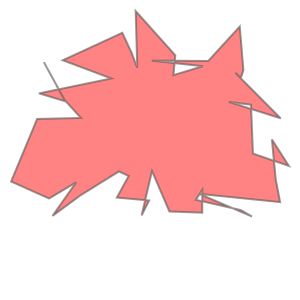

In [42]:
sample_geometry(ground_truth_geoms[1], 50)

In [10]:
ground_truth_geoms_fixed = []
for geom in ground_truth_geoms:
    poly = validate_geom(geom)
    ground_truth_geoms_fixed.append(poly)

## Observations (deviated and downsampled)

In [11]:
# Shift 400m to right
shiftx = 400
shifty = 0

initialidx = uuid.uuid4().hex
fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
poly = Polygon(((cx-size/2+shiftx,cy-size/2+shifty), (cx-size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx,cy+size/2+shifty), (cx+size/2+shiftx, cy-size/2+shifty)))

params = {'windspeed': 15, 'winddirection': 120, 'dt': datetime.timedelta(minutes=30)}

### Run forward simulations

In [12]:
observed_geoms = [poly]
for ix in range(24):
    simpoly = forward_pass(poly, params)
    observed_geoms.append(simpoly)
    poly = simpoly

Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99051e2c794a461a85256712986a25b8', 'compareidx': '35e2e1d45e944dae96a548dc31b59150', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b938170ec3147119c2b7b3295ec622b', 'compareidx': '3e98d06614a349db9b580c9359a5f53a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e6059c85026432989513a5736c39596', 'compareidx': '8f54ba4bb3304fe28df0d60ef862f059', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b6a629130024c05bbe00192ec09db71', 'compareidx': 'e2361ddb016041a1b4bcda337625c828', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25a95db88fe54311a0c5b8e0480a8efc', 'compareidx': '672b7064c2414e1692e972ab5ed89c73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cbc090a639634c7191e8769d901b53f6', 'compareidx': '7ba08ca907014330a71827d16ff5d166', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75a80b8c240e4a7f8fb890619de2e116', 'compareidx': '96600e27e4704f33a7b4b4e80895a108', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd916723f283e49d8975b9904c845dd84', 'compareidx': 'e90de899250242468ac85daa6c658f91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd440127957444729adba364f614d2889', 'compareidx': '9e4361e49462493b92bc0e21b8d40b84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a86889c505c4d19ad3daa5d5ce23e1f', 'compareidx': 'cb44660642c2447a9920214b2652641b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d7d43e09f0f4e28afe28eb6453c9304', 'compareidx': '0dc813c0cc8042b3bf90def61028ed12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57505b5e5e74473d8cf97d9a35613af5', 'compareidx': 'e2ca151eb1294f0cbaaa27e953f8c84f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd3045ecc0724fecae7ba2c5b0771efa', 'compareidx': 'ce06449ac62c4c019f497d35548c5b42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3206404bedb4e74b362adaae647980c', 'compareidx': '352c22f350a445a09b164428df4e77f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c49688a7dd014515b04a5c754599271f', 'compareidx': 'f8f6a3ac97bb466f840426f0d3d2e0c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fe36aec1c4a441f89cb918843820261', 'compareidx': '5b5bc75ae8874978962b9a1f798eba64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7aa040cae8a4f95bf163c01a4d96674', 'compareidx': 'cc70bb2cd2114d988efb644e3c901e53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '796c6fa106764f589fc718bddd796b5f', 'compareidx': 'a1c47e0a001a49189c2d55f594587e52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c97dafff82214d759103659ad05f07fa', 'compareidx': '222decae883d411f8d491c95688e2f08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24c5c7b531ad4c7693ac66b327f1f4fa', 'compareidx': '0d7b78c7086f406daca026a6887d8f30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebbb12f085f94507ad1942595b8a429f', 'compareidx': '918291da231d42caba34f88e59b0e20d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '606c385ff75f4c2a8abf8eb8f91afb83', 'compareidx': '89c0cddf342746d1a6fcb69eed712812', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb3efb1f3c604946b1a9b8322223f5b9', 'compareidx': '81ad062246aa44eaba4a4c7da4e170d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8de49caac52841f1a696ad0098b2281c', 'compareidx': '1d642f2d0e8644d7925484d292a9ebc2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


### Validate and downsample geometries

In [13]:
observed_geoms_fixed = []
for geom in observed_geoms:
    poly = validate_geom(geom)
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

## Plot Geometries

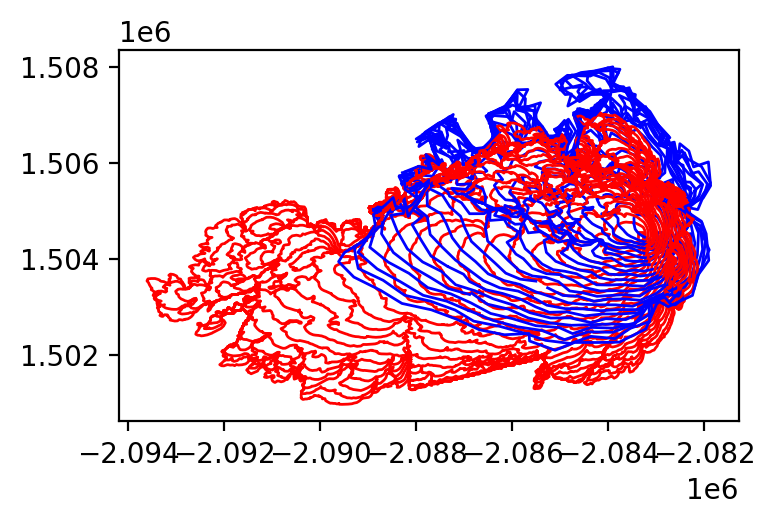

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for geom_truth, geom_observed in zip(ground_truth_geoms_fixed, observed_geoms_fixed):
    plot_geometry(geom_truth, ax=ax, color=(1,0,0), lw=1)
    plot_geometry(geom_observed, ax=ax, color=(0,0,1), lw=1)
    
    assert(geom_truth.is_valid), 'Ground truth Geometry is not valid'
    assert(geom_observed.is_valid), 'Observed Geometry is not valid'
    assert(isinstance(geom_observed, Polygon)), 'buffered polygon is not a polygon'
    
# plot_geometry(Polygon(gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0]), ax=ax)
    
ax.set_aspect('equal')

## EnKF Update runs

In [15]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 500
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

windspeed = 15
winddirection = 120

In [16]:
# for upix in range(len(wdar)):
#     sampled = sample_geometry(observed_geoms_fixed[1], sigma=500)
#     # Validate sample_poly
#     sampled_validated = validate_geom(sampled)
#     # Interpolate
#     sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
#     # Validate again
#     sampled_validated_2 = validate_geom(sampled_validated_interpolated)

#     Y_geoms.append(sampled_validated_2)
    
# Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count)


In [17]:
# plot_matrix_ensemble(Y, lw=0.1, color=(0,0,1,0.1))

In [18]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    wsar = np.array([windspeed]*nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wdar = np.random.normal(winddirection, scale=15, size=nsamples)

    if upix == 1:# First ensemble, use generated samples from observed geometry
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
        pickle.dump(data, f)
    
    if upix == 14:
        break

-- 13-->14 --
Calculating wd=96, ws=15 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a08001a6ef97426185e3df0243df220a', 'compareidx': '9a4fb79222844eeda0466b8d1eb7da49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df590168519d4d1f87acfa16b68300ce', 'compareidx': '7ebc592dc9ee4e738c9fb2688d030b9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db081293cee04b3d8a1bf4ac13d0e1f7', 'compareidx': '49adb77c1f3a483986e6b22101af6b18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=104, ws=15 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33188b9aadd24ae892a860a6ea45ebbd', 'compareidx': '39b7550226214e26acef4b523c7082e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73abfa41a6d140dab7a829792095b1d6', 'compareidx': '552faf04687d444185effab6266ae659', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ba700bb106c4c4aa1a63d70ed3a7999', 'compareidx': '66c35c3ba7594ec3a18511bacc2d37e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7fc8d6c2b204b91ad7436d74f6fa0b1', 'compareidx': 'dfebd3bc1cca4a06b3f310b47f4fd7f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f243b9002a31450bb5d1033f433a5371', 'compareidx': '03d17656815b41b9a007045ae1abf62c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9791720157343b8ae417b1eb1a4e654', 'compareidx': '3f5e2e96d48c43f58f174d606381e3af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8b9f8daa1ce42f0814bd88e567f18d4', 'compareidx': 'cb4b30548f06476c8a823c73f37537ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b95387ac4a3542c18953c74cd5ee8285', 'compareidx': 'a2abcd5fb7ec4432b4c380feb2af5d34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b5621d53d544e4da3e5f78da7531939', 'compareidx': '40914b3a1bdc4f0bb46fc31bac8588c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=142, ws=15 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03df26499f8045f1932fb520e316b6bc', 'compareidx': 'ad983df8faaa4ed6b737386988d4d159', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=148, ws=15 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3a9bc8b875b48dcbea4ec2eab9f7762', 'compareidx': 'c9594d67114347b7b7fac6112bccb7b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 148, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08e3a80b5edf4472876ec6641dd32215', 'compareidx': '4bd92291ff634c89a097a37f38bc80f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45efffc72a4b427baad77b71d855900a', 'compareidx': '3258e1317674462d8c18817a0aec1eb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20530bfbb7594c6a8cbbe0d670f55f5a', 'compareidx': 'c7a9c242ef5e4ef181709c60a8abcdfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e71ec75cadc41a6b48618d93281dc69', 'compareidx': '9e9c34e48b9a4939917cc911fbe6c629', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '506f7c19d17d4df8b4a265389e4e1101', 'compareidx': '72d9c425cd504092acca54172af56bb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c86cbfb8a5e4c469c752844e8319f7a', 'compareidx': '50e61f7889844927bec9b7495344d42a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c060c168920a4a07b22cecbeae237aa6', 'compareidx': '2e48badbf564453397085585419acf31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4b36c76562a40879433988bf6591055', 'compareidx': '02b5561f966a4fd5bd120c8f5c48492d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c2aa286dfaf4af4ac78d6a3a4cc30af', 'compareidx': '4ce53dd5a29b466c953991c0edd9b3bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c59f238fde34abcabec1a00367d88e8', 'compareidx': '8593374598fc49b9bff27f4d077eea4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ee371ccb0eb4dbfb2241a06c50fa290', 'compareidx': '1449c277bf26417494905675470254af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=162, ws=15 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f9ab582b701434cab62788efdce9fa3', 'compareidx': '9051a3ae457142c2893d7537993b6be9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 162, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=96, ws=15 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '797384d0e13a4a1aac22ae6ed8391d49', 'compareidx': '1cfaaf21cc86464a933dada4b1076da2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6a0c0cbae5941d4828a46a1416d7ff7', 'compareidx': '3141377b95864e7abb050d4639ed6d39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8b3cdf7dced4c8fbcf8f9a8cddc7f4a', 'compareidx': '5bcaa2e72cf3434495fd45364c440dc7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a772f519302e472cb2dced6cf24c1cf3', 'compareidx': '16304139ab06414b89a0f4317814910c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c89f1d9053ec49c7a95542400e66f1f0', 'compareidx': '09e113882c884a6e8530826666e83fee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6448f5c3990c47b9af6e9c795da8fb85', 'compareidx': '398bdda1b6ab4f8ab79db811b7032892', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4754e95faa4f4ad98bbd6ce80726d44a', 'compareidx': 'a75f4ba15b5b48099ead0e8525a8bf22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99481e9d83ec4be7a1640e0903fcfb9e', 'compareidx': '082e86544fb245da904fcda099229b82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7dcaf0263f954c308861952106434195', 'compareidx': 'f43497724da747ec853a3c71c816c46d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=101, ws=15 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '629bacf4e6694c13b78a83e991c4da50', 'compareidx': 'e30cac7590734ee18cda1e75a83b1d29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a19fbb00a5d54aca9d3661f716fc5d54', 'compareidx': 'e45dd56af71947e894f5b86d8c6d614d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52653d499bb148a096ed46c7da108385', 'compareidx': '511333343f4b4592828328617e3b6b44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fec915c9f5f04eea9fc448186ae090e9', 'compareidx': '88debc88a16b4e018658b6c24afee58c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a2367b0670d4e8cb67c786d8ea61137', 'compareidx': 'f884e0a3ee354b4b8dc180136f11535e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4986b13152014068b591b40171451c1f', 'compareidx': 'af36cf3e76c944abb8234e3196542655', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=142, ws=15 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'edaaa0a4cc5d4dbb92ebf34edba639d9', 'compareidx': '9942c633c3bf4738a40dd3ea123df8df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb3c1902f5fe440e9713fbf2133312a8', 'compareidx': '142561994b9b42d8bb160575ceb002b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3aad6ea228d04e81a2138a4ec28188f9', 'compareidx': 'b25f750690cf42b385f56f5a4a6d1d43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=139, ws=15 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9567916ec7d431d86751c285711e3e6', 'compareidx': 'ea3c1164702f4367a0145d90877b06c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=148, ws=15 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10ed421429dc4aa6b7587a40d48c2682', 'compareidx': '5c9a4a44c41c442c9dbf61d369d1a492', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 148, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aeb10023a1c54a8babdf0e64050f93ee', 'compareidx': 'f6a8cc3fe1034dedad407e160b032c03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41193c42b9474072ac399cc02d936910', 'compareidx': '523bf45c29754ae59446343ba74a9136', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bf186c4c6274f9a91ba10461e613071', 'compareidx': '31aaf392a238486e953f8c90912b51ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=93, ws=15 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc414f1700974e9abc9fd7d1a3d2ed8d', 'compareidx': 'f1b8186e4ee44329a313e7bb27dcbc66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adee486a908441e69681093960e83623', 'compareidx': 'e097fdd586d24a77abc12c7ad8bfe309', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fa1a8ee9d0f4eab91dccdb1836946d8', 'compareidx': '0806d74d3d7847c2a7b44fdaad2cac5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '793cd2bcf1664a8ab55589668c2a3ff8', 'compareidx': 'c943eee044644da6962e2107e668aa9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65498dee9c0f4bed8af766864a15ba4a', 'compareidx': 'f698d3338455479c8f1c32a57c721064', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1be09da2cff144858086e0daac4e47e9', 'compareidx': '85ef8db94c2c4cda84b6f2cdf4ccb3f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '92579e1ffa714b4aa492eaec36bc3c22', 'compareidx': 'b2034b30221745938520160c7b671d15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f2f3d6ed0da48c9a5b8b3f2a62c8b48', 'compareidx': '602154a4f8bc4fe5bb6b8aca4c5f4e59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f047f10956ce4252a989528df5e33c7b', 'compareidx': '3ece523cd61342e589f0c43133d20d17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de2bfdf2f1624c7fbb78828a949b9625', 'compareidx': '4193d41a27fa4062af2ff4fc7a8c51dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0f7c49e65494aa6bf2368478f370dff', 'compareidx': '49aa2d7e48ec4767b788ac64121dfe42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=89, ws=15 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f927acd57994db08b026a3d6e6712fe', 'compareidx': '922f40d37eef487e8e0586b36c9f2c88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=142, ws=15 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '474dc1df8fea45a0a918bf151ad4d2ad', 'compareidx': '5f484d95ddec4bfcb8328d27bf7531db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 142, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=93, ws=15 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5d67f2f4a4a42c1ab970b86b235bbf5', 'compareidx': 'f05c03feef2f43179861e616e793bf0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '849972b54698495d9b9b871033f58569', 'compareidx': '1207599ee53b4bba84796886a14a3739', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52760990d1c841b3a69046084e9675a0', 'compareidx': '652c7ad488a64cb892b4b36551e7bd81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '052873e5d91f443e8a07e61fdf9ddad7', 'compareidx': 'a5cbfceb04704197883533a1227d5171', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac34a2ef332a4c12a7cdc7e941306d2e', 'compareidx': '6e6593cde5434fd990c7f843d0bcb8f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=101, ws=15 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ddb685aeafa401db9bee2f7b05a36db', 'compareidx': 'f646c5982f9a47f3bffea45a3d19903f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=156, ws=15 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6022bafdc9414ae0adb53be9c69bd586', 'compareidx': 'a189b7bbe26d41c8b862bd9326509bd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 156, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '922332a8a7464ffca722de8abbe3e277', 'compareidx': 'f5e6b7e3f673478086523ed6ee284179', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54ccf327064e431a9901687207bc133c', 'compareidx': '8c0bfa97c87146ed985025ed21e99adb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04f4249d7c06478196bfbbcde8f99dc1', 'compareidx': '2e5449265a60443fbc4117145af39bc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=143, ws=15 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '030c0bf714ab49b584bf6bba5754f783', 'compareidx': '3a50f4af8729443391209780118337f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 143, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '055ad01e6ae445b98c4fd538014bac36', 'compareidx': 'd50dc0e39bcf432ca5698163673e6ea9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4c365aceec14f5dbd921e2737d6feeb', 'compareidx': '46abaf2504804ff8a4fd7c1c42c9a4c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3969efb28d94e7da72b1ae67b78bad3', 'compareidx': '7c0ff8f222714fd7b4a753c6c714c4bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aca8b92ca051452da4002e7c157f74f3', 'compareidx': 'dc1d0db7cfa2427baf54a536e7571bda', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eabb3df160394b70b2e2d0ab0f425b50', 'compareidx': 'c836745f57bb4b629c39509e0c6b8193', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=84, ws=15 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68b47113e23842c79e1da5013714bdd6', 'compareidx': '321ffc17f4424dcea38bdb29f1f77893', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aad40a67ed9341cb9a254f6595d72d56', 'compareidx': '3b3a6e1ff0f9407f981259a9f20b8f0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c3b1fd05ba843a69e02b767d33f0448', 'compareidx': '9088049c13924d3bb32124ad2e80ae26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da16bc10deef41b99b544ead6ff77f7c', 'compareidx': 'aa95ff89091a45dea4f9d254b1befbeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '91fbea4ac19c4f0aae0996ab3b252833', 'compareidx': '3a650d1e4396459f9c53c36903b6ae67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 13-->14 --
Calculating wd=122, ws=15 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e94ceeffb904fc997f481bb0b6f91d1', 'compareidx': '7d00d12a96924e7bb23e3b756e177a22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '107e8143900f4289b4a915f4bec9e22c', 'compareidx': 'd09d529c97e24d8e9917943768971e2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=151, ws=15 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9caba15a782c4bdf9613b88165213d12', 'compareidx': '20ff4ea6e7f34f40b27de4a979dafc3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 151, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab5a5b70dcb1433d964bb5a9ab87dc57', 'compareidx': '342f40d8f8a345f2893e2c6878224505', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b5ad986dedb458cb1f2fd66b4744072', 'compareidx': '0c322bca4a704147b7c8d9cae19a7e4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9dd6a4dd448d47e2b56df55652d62a95', 'compareidx': '1c78532355e1482aa7ff26263c996c00', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90377d8dc5494cc2820958c0f2248c49', 'compareidx': 'fbd927399f964b5e8022641d4c8ca315', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7b5584139da4c1586feb92f39af3372', 'compareidx': '44e59d2e287c454ba205a0c2166f5383', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7c31a9a56c44423a0aca40534ae084d', 'compareidx': '7843fa6a960741a88225c44956617beb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e8209f8993a494c9883279062eb13c0', 'compareidx': '8fc3d06e00c2420ba9ffe30ad6609698', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd08b4edaa5241698c42ffa6b3a911fb', 'compareidx': '2fc5b50b0cb440c2b011db25d3d3833f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1404a409e0144d5ac173ba813ea259c', 'compareidx': '99d3660354e0497e8fac29932c874ea4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3199bd05f3164b5d9f062a1b898931b8', 'compareidx': 'bd2574668d654743b0976f3a8f3d1f34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9df18e4ef5244a7da804272ec72b5ae3', 'compareidx': '0caf66b84b2a44249e07987eab3529dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '805daea003e74a0faf15af1df5670485', 'compareidx': '4ecb8aa30a764556999dcde230f79d86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=104, ws=15 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c872ed7d61d45f3998d06376b6f94ec', 'compareidx': 'a44f2a797b764a2893ce87044069d989', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 104, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e02151c99ef04912b2c84c56ab1aa01e', 'compareidx': 'cd7e28f349cc44aa9a0c97fe71ff54ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e2bc1b3f9f846e68c6e4582ec7e0f1c', 'compareidx': 'fd2350f0c7514f67bc7dc9a21dd66904', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96de447f039c4fc1b960ffdff8400b77', 'compareidx': 'd20f51fd059344788723ec0d2dd71d32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb5a257f371f48c98a4c8fab77a2e838', 'compareidx': '2653e32a15e6427fa61d7770d2eb8638', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbe038ea209b4c8dae51740767be17d2', 'compareidx': 'a7c0021587464545bf47e6065e9de22e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18bbc116de6544aebe5ccfb98e2f9704', 'compareidx': 'f6292169a75548f19a1ce50b45c0f8ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '759474ec80504b72b99d75722dce0b1d', 'compareidx': '46a24b13ffc44ebcb5e9a9e1df1050da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=145, ws=15 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b20a01ddf92647da95946fa68170813f', 'compareidx': '60ea5b00bf124809ac6c1c51f8b92003', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 145, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04c6afb8962244a8b9d28c77a1b609c6', 'compareidx': '76394a3902204be68cbf900bdfb10c22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '503164cfd1a14cc6a24277eed620d5ad', 'compareidx': 'aa20d03158284796b06dfd88b46f427a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e15a3b91e4640eca65841c374be4a36', 'compareidx': '7fa92138566f42709251563ce597080e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb72aaf842d8401b8856c48c895ade76', 'compareidx': 'e7fe615336ae402c8d0698d6357507f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=89, ws=15 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3e2bc2b0f744ce0a73e1053ac5eb6bb', 'compareidx': '0312e64c22124e01a3e7dd803300ae3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd08a3e9935864df69b08715b0832a66c', 'compareidx': '0d3f5d58557143638d54b84e522ebd4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f3ccb1616784224b817d1c0739fc2f9', 'compareidx': '2644a3d674da4ca9a8d0fe1c294ac98e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31b9fe1f80f844e393058a4a9b80e97b', 'compareidx': '666733e798b6407d9e4ff840e5d4a320', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b118776517b46f2b7e2e1ebf7faa095', 'compareidx': '4c504d04b5b144f1b29bb23adbc75d2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff630d8a98404de8ab5e56a2e8cb187d', 'compareidx': 'd289582cd6bb4a569dfd70dd32391495', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=153, ws=15 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '817352999a4d418f92fe32eafe4a5855', 'compareidx': '79e57786b0c84f909a2f4eab13a7051f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 153, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '64a598286a864b59b28b14ec5f0653dd', 'compareidx': '8a36376ddb564b7fb672d453dfc46669', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1df784cf3a6049c5a42a630100cf85cb', 'compareidx': 'd37e5d0f05a84a109dfe6c2e22e6d343', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b02198f4e4ed437d936c5748b7204275', 'compareidx': '50b54ae0ac3b4f83ad4e27e576b31c69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39acd0b23bb8494d90d041287357d43e', 'compareidx': '12f0a75f8dd24013b11ff6aa65f5183d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de8ae124c2fe4e70894340f428d99962', 'compareidx': 'ae841722021e49d5adacde01d512fcbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '865a40f4af13485d99a3a913376ad689', 'compareidx': 'ac07cea985964787b1c6fa78363e3b20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '429e1711cdae4ca4a955483d87da40b9', 'compareidx': 'aefda9966b68465daf9ab3556c3b1a4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1feeda3e46de4e26b8927fdda1adfa7f', 'compareidx': 'cd8f6b6ac8c943c5bf1e3f394035e798', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e8749205f9440ff9968dcc2d487cc43', 'compareidx': '200331b971e84ac0bd5122ff9406d630', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad0883d23742419baa7f65a1644b7f8c', 'compareidx': 'eeb807c37f6a4a1dbae04f4f1b6d1a9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fc3159b8ddc45dbab2fdf883ce89f76', 'compareidx': '6eb5ec8e63624fd4821be584df955943', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5274dd4a4fa64601b5de539d44b80ea1', 'compareidx': 'ab26b56cb0fd4108a7af34d2b3094325', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3806127732348bd866a1262974d3aea', 'compareidx': 'ab7d2dd3b537466c9e83bbc249cb225a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ffe13035a18d4a63b6cd36b82ccda6dd', 'compareidx': '2230c7ab4ae842008fa81cbfac951d55', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '096394f4a1ba4a1ab2cf37816262ff1b', 'compareidx': 'cb199f25750448909646546fe42f4cbd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd826f805a84b43b0b578949d0ace2089', 'compareidx': '08dad8ea28184f45b513d82a32340823', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '831f390801e741d7acee26b97dda9067', 'compareidx': '2edb942872ba41dabbed18f549c6c967', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16fa8e56129f40a088a52f7e3a0600e9', 'compareidx': '06fe987b50394a32883231981deb2c80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b1f6ee70afa475db4727c6ab28abe44', 'compareidx': 'c78b12fac9524a20a2618768a2353559', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc54fcdd0e3b48d6a65876a31dd590f4', 'compareidx': '8200c13eaada402aa6e168bc7bbadffc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6933a346209942ad9327a9b7007bad8d', 'compareidx': '1c4d334905c34edf9feb83d537f83916', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=88, ws=15 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd64eb134e5324e26810a3d466b254cb8', 'compareidx': 'dacc6b4965c54c8990267bd82aba10a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=90, ws=15 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '459600d196b44bd39e4c75ae135184bf', 'compareidx': '0e37990ac1c24c95b23ee6aa5acbfce9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '834d10a35b1c48d19bcc4033b8af4e4c', 'compareidx': '364ff4257fab40bcbbdca1e1e4075f5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=91, ws=15 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12e1ec5e025f471cbd1de8fb309ca7eb', 'compareidx': '08b76c44be044c24bb4c53510afde0b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '258c9cbfa0934e58acd37c005ae75015', 'compareidx': '91ff7dc45a3d4240a1f622364a14dd91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26f43df79c7f4bd5ae0eac79cc2e4a06', 'compareidx': '4b911a071de74d3baa711e2104f860d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '865a53bb72a0491faf3ca8bddcaa593d', 'compareidx': '54e94c6a432745ecb29be9b0cc723f41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0accef7b33d24166834685ad3f9d01eb', 'compareidx': '5599ebfd4b314898869cd3ad25b5556c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=151, ws=15 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6767f1c0f6fd4587adc8f30284c20f19', 'compareidx': '4b26df31e254439f81439c2b7b4a3e80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 151, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45f3e6d13a814cda9f3e046d79ada53e', 'compareidx': '9400411b4ef54937b47f57a2ffcd0e15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b88af232cbc4adcb66a74e525dccd08', 'compareidx': 'c9ebc7a8d3a644a29de0cb86ec9f4472', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1283ab420e8146cf802bb7161f8b72e4', 'compareidx': '32d47b8284954915b4b7fd6a941b7c66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab28da5727864312b8e8c5053aeea99f', 'compareidx': 'e013fb3977d2401abcae61080bb4c934', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a77df4b26b744554ac8b96d5246d70fb', 'compareidx': 'e117734b0c664d55b317191531641d78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ffcd4996399b4b07b8f46ee9e16c0511', 'compareidx': '14af58fcc485459198167c8dd13ca9ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=97, ws=15 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c214fd22df64d5182402528c123ddc6', 'compareidx': 'b567edd0723840b2b0af89c89fd57a6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b99cc5689de4ceeb659a49b9569f33e', 'compareidx': 'f9e04e70899d4069a8613f5147fe6fb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75ef6dd1aba045d2b76aadd8bee9382f', 'compareidx': '8abe6bca07f2431485da5a8dfc81b904', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16926eb357d64c8a8c3caac59de63eac', 'compareidx': '8f9413fd316b4f50b44b9c515b070433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=98, ws=15 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2ac286b1cb64d709a8fe80500f98230', 'compareidx': 'd4acce1eca3f4babbd8dd456b3b4a17f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d44d35983414cd5a09a36d4f90c27c2', 'compareidx': 'dd44ea8963504f31a7d8a2e0a36f254e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8f19ca561844796a0cac1f68ad2bfd1', 'compareidx': '1a1b696ffad6401d830188e1ab244582', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '722cc2b7cfd14db6b9c06af42d6272ad', 'compareidx': 'd056d2b12eee4e6fb1c51213123f634a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19f056cddfb9444398f4901dc93b447c', 'compareidx': 'd8c48bbdfe82412ea28a92cdbb7f6497', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7923c6ecc88b4fec957a45e8da8340ba', 'compareidx': '1e6215a49c674127906b2d7a44f85223', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d0b09d44bdd4b5bab57d1f45777a1ca', 'compareidx': '69a0e71020784586947a1f8d0ac0f712', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a247b52214240439fe66552964d9453', 'compareidx': 'c0718edc9f334a758096b3e23dd16c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'add8b9890ce846b6929467f7de61218f', 'compareidx': '11a5338e5f8346da9cb2e687f0d3f12e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28a4a4e635f6426f9cf9b409f063ab97', 'compareidx': 'fa2006a99f0a4d2f8b36d7830b511d79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3d47e37e87a4e0cb092a020b1cb71af', 'compareidx': 'c81904fe774a4dc382821b201f66d3e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c31f25daa6d847bba5fc10028c2c8829', 'compareidx': '9ddf0df1b0b24f7893250f17ba7933a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0c0f2ae7bab4594b71ee6142989766a', 'compareidx': '5226139cbed44220ad62a246ff5afd34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06348e67557e4518b737070a33b78048', 'compareidx': '894be6e3434f4e3ba17e44f39bcd2b07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '306a5814b60e4e79bc732eba1bf8bc5a', 'compareidx': '61b9aa32dc8147aca596dfa099f376fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91c5608a659746bf9b5bf3477dc5d6de', 'compareidx': '5bd8510ef83b4c1cae452ca989378cf6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3ae3d4e1378419a8afd10329f01e86d', 'compareidx': 'd0e5e018c7bc44c8a31ec20d36194cb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=143, ws=15 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58cdae67248d4630b06909e9ed759174', 'compareidx': '0e585dade165410ba8a6125f7f28b3a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 143, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'beea6b0bb04447bf860b052f417ac1cf', 'compareidx': '7b3d731bec304d0e81a215d9a356b14a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79bad79662cd439c8a152ec8b65c0d7a', 'compareidx': '69c02d58aad1449b83eb6c9da5d482f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fb6c35db8b3460f9970c7ad3ea66651', 'compareidx': 'b447d6adcf5c44d9a15609ebe1325bbd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a0a814aee274447a88b933bef0dcf0c', 'compareidx': 'b75647c562464acf94d94f64bb0838e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '03658a2af9f14023a47e5ddbe54683eb', 'compareidx': '9795e1c775e747d9a13e674c49424601', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '286d4940521d4f20a4598b58e5a6b183', 'compareidx': '9f2391a24740426f88852e94833af5f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '641595d4cffb4a2ba56fb4ebecc6a041', 'compareidx': 'dfee0a142b334f8ea3b5354334594de4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f21d2f6f2904d879b4f53ceab8b2339', 'compareidx': '032b1d0ae6e643abb1375cb0e7909a72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd404480e91564cab998f4909d75668e3', 'compareidx': '64872220741341a592399163c011117f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '785bcdf865114cd19757a1798022668b', 'compareidx': '954f3a30972245aaa2e10379f51389fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3cc2dcd3cad44da93e1654a60a898e6', 'compareidx': '8a095c4f9f424bc5a7313435d22755cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '080d4b1570c74762931e3a697279a911', 'compareidx': 'ca70fa3391db412d873c6b9932f41d79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=162, ws=15 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eaecfb69a41b451099c4b8ec5ac993f8', 'compareidx': 'ff054173207e43e5841ec4746239baa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 162, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3543236047694f64b4af61e7df7e61b4', 'compareidx': '1d7f2da8216f46d18c5ad62a14e798c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=84, ws=15 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '163f1324ef484263a8cb82bca6c0aed5', 'compareidx': 'c0bfd130011042b9b1e51dbb776b6c05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc39e593e7134eb39ee033e19b4edf84', 'compareidx': 'c2e8eddf6ffe48e69bbe1fa458b15e28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c23d24ddaca542b19ed3d3c029b4fe25', 'compareidx': 'e58a67dc5e554801ad915bd39712271c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5c4ba4ef9de410e86127c9ac4d0867e', 'compareidx': 'e939e4f869b04b2d97b85655eb0e5dd0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4066f7d20a74f36b8b7aed924d49488', 'compareidx': '4476539a0cfd4442bc4ec4857084c842', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=147, ws=15 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d045b0aa3104b8f8101ed3cbe69fa19', 'compareidx': '641828d593ec422eb8327b46727c5821', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 147, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '858549bba1384dc39e473978c630c442', 'compareidx': '80df174821d8490aacd596f1e94d62c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23af03bdaa0e4dae89bb4e553a19af91', 'compareidx': '97e313d8269a4bef92589f1663d4ad06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5cbac9d3ee74b9dba6140de59cfa028', 'compareidx': 'fadbe2e697f94ad08c195880d55e704c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4453a08f50f1414f8d88be3f3d0be046', 'compareidx': 'd6b9802668634363a42a1faa0b2ae5a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab057ca589a943058277f8812dd819c6', 'compareidx': 'be37f22973ba472b974a7b51c2f3ca02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5bd3f26aa1dc4ba795e27d1f245a9412', 'compareidx': 'c4f4c1fe8d9d4330bd7618bd2d6448ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a769a0075aec4a66b7be7fa4af2235e3', 'compareidx': '61bc58e2ebb848b09e1cbcc4ca5ae2e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b40d6cb3355c4e45a1a2aa375f458bcc', 'compareidx': 'ecc442aa51c9459aaa524fb458fcf9e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '711f9be3ad42430b8e5ec17265c88023', 'compareidx': '51dec82a25b948e692cc013edd7a70a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '421cb05a374f4fde808c8fe69725af87', 'compareidx': 'caa9980bb9f64e28943b0d58f653658b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c17858c0366345e795a921e53029c3b2', 'compareidx': '121c500fe81d4305ae8b6b11fce5a98b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a3d87e49c494cfb80fd83f474ec237f', 'compareidx': 'cb95277c43c44dfcafd65434727c6542', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b071a1051eb94330b1e38574bc9dbbea', 'compareidx': 'ff6085bf5a664f3e85049563d9445787', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c88280857424750806297b9ce2205f5', 'compareidx': '05cdd8b3357143e5aa01a4de54127560', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=166, ws=15 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f9da26996d049f9b1ff76b063569993', 'compareidx': 'c1f55b862b7245b78210623525c86956', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 166, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd46e640389b041c3a9baf26a050cc65a', 'compareidx': '61a84db61ede40cd836dfe9eab8aae19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd71941c66d7c42ed82de02cf60f58124', 'compareidx': '13fa66076e064320a1a3125ef438f0ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3602d16001a64613939d5d0b6dc1a43b', 'compareidx': '586ae9f96daf4116be6037017beb6d40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd84df032df14ee3a66d831a25eb4c6b', 'compareidx': 'e644ff38a451464e93cffced7e17531d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '045431f32e1a4f32818358584000be0e', 'compareidx': '702c1dda19274da99789163486e531b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=88, ws=15 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '840d2f280f2747b4babe54788696eb04', 'compareidx': 'f1ca671a211d4f9ab9dd09bc42d713bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2aeba418d814f339969ef9fa73f3672', 'compareidx': '72c3743855fb412fb3873ad23dd9e3c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=100, ws=15 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a3a11cc5d2b499093e124092b4d8cbb', 'compareidx': '5d73bf910b5f4142b1391ecadee1c06a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=155, ws=15 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bb4b4bd1b914ce08c83f04b655a4aec', 'compareidx': 'db720c7a5f374e1a8908dfa3f5fdd0ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 155, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e075060338ab46599245025ae21b794c', 'compareidx': '9519f23c51e94518a196003596f0292b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6804bbaaf4b4a45b5bb62ba426125ab', 'compareidx': 'd15cdf12b68e4fe88eb04291fffd5d8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '851139dcfc11453dab6db5a205397219', 'compareidx': 'b6e6e91f122242c9b29f71bcec6bbce8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8ffa065477f4a1b89b8cd82abb8d10b', 'compareidx': '8bf51b45101e43b98313fde8b42392d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53ffe767836e437db346776fa8bef1bb', 'compareidx': '25c951682fcc4ef2b140d0bd0ff8b51c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1178f3dd4c334826903b5721256c7f04', 'compareidx': 'fa8b6f77f4d14661a73b237d9e26f262', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7b86274c85545e1bb4ed2abc70fdf69', 'compareidx': 'd724ffaf0b9c4ac4989ccba057f9e848', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7be560f1644e4b6a9af412a1b3431b34', 'compareidx': '51af82a552d64a598efebcffdb1ee145', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9cf2fe50af32469d9934f43e2e30143c', 'compareidx': 'e61444ff678b42a99286346afa602a8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1be5b91af7149da936027e4a85f9dbb', 'compareidx': '5576ccae4673453da4ed2b22f8e9c7b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c1ab115f0cd40f7bb4c94115ac7342c', 'compareidx': 'd648b49bc00f4c70b2e0e636b6542500', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d62cfc1c02e49258c973a4f72aaa6ff', 'compareidx': '5d086b8f296743d9848aca010a8c5ee6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c098962a8b14635a81eec5776bffbed', 'compareidx': '3956c798fee54218a779a4de3040524d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9a8cb773ea84b6e85177f3883a5348d', 'compareidx': '7da99a5935d342e481f1b964bfe51ce7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=140, ws=15 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d45d9c3586b40d197ccd051a9a50e5a', 'compareidx': '550c6d6e8e6c4bd3b54612a55c549af6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbf971a075e14070a7a2cce02312117d', 'compareidx': '83cc9c72d27343559f3e76636ddffeb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=89, ws=15 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '727f1caa1939433991b3fe9e43122514', 'compareidx': 'e05a8944df934ffe988b9b6b01e2e8fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '516d9b7575f543e3976a255973fe6c92', 'compareidx': '7088336aae624707b83917bfcf77a8d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec87a8c760574800bdc9b8b32a186d6a', 'compareidx': '37596ed447904664a7acfcfe4116289e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bbc5dd3fb08493f9adee047759040c3', 'compareidx': 'c00280246134434f87e993f2bcff4f11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '246f4996ae244aa5ab117d26f01f12f3', 'compareidx': 'ed3878d629094b559425a9426ba623ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '991b3b8b735a48bcb1cec8642a0c54e9', 'compareidx': '0c4ac72172234c55b2a5c6a99f957500', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ba35f8db7b84265b1bc13491daabc9d', 'compareidx': '97eda886480b43808012ae657c9d2a32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=154, ws=15 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24e8f9019079481ea095c45b9bd66cee', 'compareidx': 'e3c56447c17a416db88824387de628d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 154, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=100, ws=15 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d7ac80c9f9445dca8b010e4475dfe7c', 'compareidx': '86fce810912744ab8475d6a3a0a0d16f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4ed8cb3ad7946c8bb17d44002eddf0b', 'compareidx': 'ef0ffcc4f42448dfb8ab8725c233e4cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c36b960743fa41dd8b371cf8f8076673', 'compareidx': 'ff7c241b613447a9af2bd2367f2b31b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=100, ws=15 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fb00ded5aac4203801a1e8035a0eafa', 'compareidx': 'a7085506b61b4215bc5954313ad010b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '721f0cfe68c940edbe103980ac8191df', 'compareidx': 'f85fac8aa35e44e6a7fa320b3b47b3b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4cab3ab90804af88821fbda49d210df', 'compareidx': '12cab6685d5244e382f25bb2e538e514', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac7218c002754b208c1b8f5fd0e82dda', 'compareidx': '7c169346ee9a46c398a8190e64fa3d28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65d32969a16748049f51b979fe850f3a', 'compareidx': '3e1bed9608394786aeb50317d23793c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8884806da167423abfc0e95e9012c8b8', 'compareidx': '75fa6d7781ea46448d854d6906c88166', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=157, ws=15 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75736f284ca74546a95c403df4878f00', 'compareidx': '4d53090981944c12a368654191400daf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 157, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dfee8df1765348d0b93fd9095319eb96', 'compareidx': '3aee1393743445c085efdff0dcf40035', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=92, ws=15 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba09fedd6c52418dbf8aacb67286c728', 'compareidx': 'cd7bcd4ec7d54e0bb26f7bc27506adae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83e9f6b582d04d9eba61c46d8df7c611', 'compareidx': '32a0c50623d941dbabcc9fa924201189', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fe0c447aff2404792cb9cd018124691', 'compareidx': 'b9aa01eb613941d48e120dc1d8b81144', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf128634bf3a4918bdac53e6b1cb8c41', 'compareidx': 'a8653ab447df4cf78ec5041c51d6bdc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57c198efeb9644f891ac1ed33fe3b3e6', 'compareidx': 'c53f266013634ce3a8e5e69fe6a12407', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6785aa1e677469a820319cbcbe66b09', 'compareidx': 'c34d3ea2ef5b489486835a15770eb9ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd931619793ed4314bc1840a176d94672', 'compareidx': '9f2c3b5f0c0b41178d72347aeb4a5b5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0c9f0daf4824ec6826bdea062227a9e', 'compareidx': '6fc00bb447924517bad98d1936edc6af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36015ac71940456eba64b922cb515f55', 'compareidx': '7fb32158b49f48b6b03da182226d917e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cffe8d035257458fac4ca92c7d9657c6', 'compareidx': 'b86363b67df440d38746bd03d068aa35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e341e3bd53247ba8f909efd80b9fe0f', 'compareidx': '3e9b1387a8c94c8b93922cbfb79f0e24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f8cee4d7ac5437da724e18d2704e9f9', 'compareidx': '04a6acb7af994a8897aee361080a7019', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fb83bc3fc1541da9bc0fe2c09f56835', 'compareidx': '7bace189cf334ae3a468d2cee8faadeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e56309a09fe4b629e6fc7009ec7974c', 'compareidx': 'face210881fa47538ebe4793a7799086', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11c5441624674e7eb8a3b6c1c29d3d2a', 'compareidx': '24437b505faf42aebea5119a83fdcfe2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b97bcdbe63d040d68beee0b6cf202583', 'compareidx': 'd886c4bcedd04e6eb17421cb2f93945c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=139, ws=15 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6073d06a6e414dea8795d00d9e1f3e2a', 'compareidx': '7ccc56c5a47c47bab31366a0ecb12159', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=90, ws=15 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2daec5eb1db540309fc2fe473fa7ce14', 'compareidx': 'b8c3d4d5c0704b50bff9aba69847d48e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58dd426fb06b4fc7853d61291e7498da', 'compareidx': 'dc893cc82fd04bd8a0cca29b3c188d34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a3c40d002174f63b7631034e834d674', 'compareidx': '386b4f776f6a401ebbddfc9affe20f85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=120, ws=15 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '766fbd3d73174ad8bae151b8b98c8264', 'compareidx': '84956c6abc044f408702e288e6702a82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 120, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=147, ws=15 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0943181b2c9f4f8d95cb41cf7e42f4bb', 'compareidx': 'b8ad6e77863a4d6b86adb46bf9a7d6c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 147, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=102, ws=15 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5af00255d73a4f2badc3756e9366c367', 'compareidx': 'c5ac90c7e3e946bf9b39a18da646b5ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22728f23819c476c8daa2ca4adcbf97a', 'compareidx': 'e94e831bb8e94a7fa8acac9a54599487', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad603fbf8a84499d9a08b005ab8034fd', 'compareidx': '922a6cbc2dcd49b8bb39f283e7ae509a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7cc4d55035c454da9d11d539d81af1b', 'compareidx': '82447e08ba8742cd85b6832229f5915f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89c414c9face40f2840d0340714021a2', 'compareidx': '2dd00e02946b4052883f6c95e21125ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f44b02e8e7b4e2fac40ac03e25b0800', 'compareidx': 'ed0d60727653440785531d63fabeccc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c677fd73741467cb0da2592897dccba', 'compareidx': 'e8534265ae154507b2f976db9c1ca594', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=163, ws=15 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc2d31d57d054201b6078feb4a9138b7', 'compareidx': 'a1c18562a9344c6d857914794ebb9770', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 163, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2436f22d11f404ebee9afdae1e42acb', 'compareidx': '0bdf4980163744feb8ac017b043c89b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6901a96e0726401fa855a70d498a1e58', 'compareidx': '29b9147606714478a074695b04d7aa76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'daa2c7136f8841da9f368a72fcc410d9', 'compareidx': '35c4a91d547e4624aa07e8f703f65638', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d298e2fc8914b4095f7e1619af59d91', 'compareidx': 'be95682127904104b9d07b0b5db8d66f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c550aa6d72964daa9e4a81cd9f198c4e', 'compareidx': '2824447de83c41b2834d6be79e759eed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a65b3439383f4b0b90089e261a5efb16', 'compareidx': '8624a2a7b4fd4feeb899c3acb838deeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbe407215750400abce813cd63550a48', 'compareidx': '330845682ea04c439366438a8803ad7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff6b3b338cd5483baecd1b50e9f65c03', 'compareidx': 'c7bb2c9098bb4a029896ef2357757c10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10218bfebc4246428ff6328fe3bc6912', 'compareidx': 'a5cad1362b144736ae8b3b8257141d8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19308ea9aa1940c28b0120f4f8b172ce', 'compareidx': 'e3efbd0dbd764d5c888e64755fb36362', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '127c0a76dae94351b346481e1191e65f', 'compareidx': 'e9e0117dd465437e8bbbe893a6b4bb9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=154, ws=15 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2ee6eb316e743a6bfad628e29420374', 'compareidx': 'f9076699984a4063bc7ba3aa3e01fbea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 154, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f693058e670a4da0bded86fd577dfd8b', 'compareidx': '36d207243b2742e2bd5f55de4671a458', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '201051eaf8fa4a6a892c2089f7a9c8ad', 'compareidx': 'fffa1dee97b54717abe26294fdc7fd95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f99aee93ea841d189abba72bf9a9ddd', 'compareidx': 'e52028084ccb4f628f9bb9379c2ee545', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '662ff0cb582e444ba8d65b177d2d00ed', 'compareidx': '5c88ecb66a25432eb1e43fb486b7d3ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=153, ws=15 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14bff920da304f62b9b04d7735773832', 'compareidx': '44bccaf7c3684468a62c5091a67bd24c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 153, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43f64891ffd5468da07b4bba58aaf86e', 'compareidx': '1db82afaf0cc459fb8180ad678db7398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '023b856823264e429fe2133eaec929d6', 'compareidx': 'ac300bdcde41484d8e2da29b4201e336', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e9d4475e2cd48f39893823b7c2ba417', 'compareidx': '749dfd3317474a2b8f23b2e227e139ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb29b687001249b09f0d1f2dea1b5737', 'compareidx': '886d12875d9443e9b42fc319948676bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a98652a125448dd827bae9466ef7147', 'compareidx': 'c67643434370456bb8705e286db8bdbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19363f6ba72943759ed30b68a5337383', 'compareidx': '3985de4068754a2cb72d06da52c3eeaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e0327c148774d23971d263ed33d177e', 'compareidx': 'e916505a65d14bbd8b163805f4329d0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62a1c230922d4843b9200c0cf49c3c8e', 'compareidx': '03dd4a177792497b84b1d2cf5dbe05a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=155, ws=15 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72dc283d22e24b3bae5cb1574b38b58f', 'compareidx': 'e9b45f0e78454c0db69ad5ddcbb3bf39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 155, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '645fdf26729c4120a6ca266362eddd02', 'compareidx': 'fe5bbfbb5a1d499c81bda3d2d021116d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c54985ddc544f0d899da6b277c64ac9', 'compareidx': '13d10956d75f4fb99cab03c1287ec7a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc8ced58dfcd4bc98700fbbd4213d121', 'compareidx': '552a99cba6874153949a5f2cb5da5c3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbd227b85d6a4fa79ecd543f74f3662d', 'compareidx': '49941037ff0545fb97dc1c2197b4482b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '819fe57fac674647b1894c46dd4e024c', 'compareidx': 'b309d53b882447b980575f4e5f4a0327', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e97d5aca3dd4065b85d86e8b25cfe5f', 'compareidx': '78858a967a4a45708807607b5b128611', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a58ce358c47f4658b54afc929a0c11ff', 'compareidx': '84087ad06bf44ea99d087e807be08ab8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88817526a3b04828bd5bb9f41e9ccb7f', 'compareidx': '07beaeb244d64fd2a4638fdd9e640d78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bdcf7f1ba24443d9804cace6622f194', 'compareidx': '9194d516f5154b1ca91e3784bac4f9f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bc29133bfc447d2b362e49c76556991', 'compareidx': 'b8fbe06939cc48a4b58e877f3e3fb0d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=138, ws=15 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ec0339f0889410c988186475b27a91e', 'compareidx': '598ed2551fda4032aa6ee2df1d189c39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 138, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=92, ws=15 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3011d7ad6bab40448c6eaef2f24a132f', 'compareidx': '32270711b1784107ae40d0c93d4d5058', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2de2e94f75e4f00b228a6ee6916cfc8', 'compareidx': '5ac5aceb52f44fbfbc03c3173e970246', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3c5cf8dd98b4ee1b0c841cc713c6138', 'compareidx': '8c4a23dcd7084999bd2bd53a327c66bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e3a4cfdbe6b4e58ab30b7bc1e19638d', 'compareidx': '9336f2ceba5d4e3db0b5c436eba3b746', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d5c33e96791466499a97a300f9a66dc', 'compareidx': '8b74a8e8b31f4ce386e6a312927e0a17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1ff6be44eab49c1a2d31becb7aeb1bb', 'compareidx': 'c642e2d5804e4836a305cb54ff81bdcf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=91, ws=15 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9516b673837549398315ffcb287bf8c5', 'compareidx': '22bb35911f09470a93bd64524f3c4537', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d6062f9142e43cf933020054828c3cf', 'compareidx': '2b642f240fde4dea8d48523de51d1c74', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3120b2b5a7e642ee93dd71deaa21adcf', 'compareidx': '5b249a7fe23946829b6d2f80c4dd298b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c85570a2fe6c4094b228b6ff708a4f50', 'compareidx': 'fbc13f92da0548aa89e0760d95074cdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fd8b9b0ac154f39beb31415991dc478', 'compareidx': 'e738a5bf45c1458f99cb3476d4d821a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a31aff8ffc84a919bddf8daf72de2d4', 'compareidx': '4541055a6f9b423eaf75acf5819b1146', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=96, ws=15 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55b491d86232494fb848270df2ecf9a3', 'compareidx': 'e193a3c59b2f4ec18f158a1daf92e3c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aecf55c6025b40eaa183674870e7e3a2', 'compareidx': 'b81c9418cd0f4dc2ad1fd45a9a5f5a49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02bf6cc5230c493dab70f909da891255', 'compareidx': '9cd539f3e928426983070e0b57978795', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'deed0448cf4643838ba727efac4619e8', 'compareidx': '4b5f3983f4864ce88e873b150d9d999b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5d3025057514a658af0a1bf36f56e4d', 'compareidx': 'e439cb946bd8410f9a2f96cae60e4d72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=94, ws=15 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfd7010b93fc4ff5a3a784439e22a050', 'compareidx': '3227f2402e0047f6b39075c4092a70a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b455ed9cda884bc095dd88de4543c253', 'compareidx': 'c5929ec61ca14d9ab746ad107758f8cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c849675afe784a178514145f1d1a14ca', 'compareidx': '262bf3a0d5fa4e4b9a81b86edcb5118f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4764a06bc64d4d25adb8cd07285a8798', 'compareidx': '5f41fd54bc5f4d8abc52781786be0204', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c346a087763a4374be43aa7e63aecbd8', 'compareidx': 'ec53defc7e1f4b93b83cc2eca94eea70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '041c9cbf53de4bf68258745ad62eed5e', 'compareidx': '19317f109f104695966c080f81022f83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=144, ws=15 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '550ffaec3fe44def83850ca0ed107e85', 'compareidx': '525497f408624bc9966adff44111cc96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 144, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0a323a3556e4be4a739b81bc9ea1e28', 'compareidx': 'b23738830cbf4e0ca097320901940225', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c44ca9f346244b1982514632a1772c6', 'compareidx': 'ad2632325b3a494ebf9d8c503dbfd6a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '180e4366527240f4bd7e51e4ed4780e9', 'compareidx': '970adee50e10423c984169e78346589f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=79, ws=15 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71146500a06745faa2f18e6ded8dc01f', 'compareidx': 'fc67aef437f447198af2ef45d99259af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49c6401b1be84f08bc9157b0c8fc9d7c', 'compareidx': '36c30d602aa849e6999b66887ae51724', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=139, ws=15 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '113435385cfc447d8662dcbefb5fe7a6', 'compareidx': 'fa89e3d6acd9489c85407965c7b700ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66dd76de95e9496081ab600695f7b828', 'compareidx': 'aee5c52e6d854dbaa906f6ae4b3f6b07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59a0c2d096f44f93b7c7fa28550630df', 'compareidx': '7ae0a750e5534e01aef417a214fef731', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85d85b84225f403fa5b33f0e7bb6c2c2', 'compareidx': '9a9e1c38a3e9476984cc0b5e637994e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=150, ws=15 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6e02548311a48a19bfce8d1f5e9a5c1', 'compareidx': 'e43a1bb1418e4a7f858b3177975cac17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 150, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd571afd0d1e74fd68d7231513c380cf8', 'compareidx': '3dc065970dce4126a7f6af245e73e589', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc01c6f1cc4b4063909142a4d6f9e494', 'compareidx': '7e34d91e96b1492eb48cd6618168e325', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02adc0a7921d4605b5b4860ed98f5dbf', 'compareidx': '0bb2d86e0b2a40dfacb8af59f8e61681', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3ffbea21dad4453879fcf497d6c5eb3', 'compareidx': '63cad67b776c470dbb4a3a80d64ef873', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be6cabdab3084e459cc3523f291f2d4e', 'compareidx': '7a9d7226d0e1416d96b6ab510091d2fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=87, ws=15 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a769b764d684bb98445d57ff7f8f553', 'compareidx': '6f243d05d68e4f50803131715e00b4d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=91, ws=15 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b29713958ca443f5b8477a6d13f4bf97', 'compareidx': '725885c0c44b4f0f95a2f5e2f5fec394', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=136, ws=15 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '348b027f7575407398a622bd28a493fc', 'compareidx': '4d7af0f4eaea40f298542362768403f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 136, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '895f67e1fe954ffcb375c99292ec0ff9', 'compareidx': 'b650e3a52b9c47c78a513d4989295c8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=135, ws=15 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5210b3f48e2b4bfe80421f54389f5e52', 'compareidx': '9e734023417843489efc2c61f237ac5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0da4b36cc947498c9f8f6fff4573a0e1', 'compareidx': 'aaa8450d23ee4427bacb7a599f5e6d1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bc80c28ebdd4c62bd187d55ab5bf7be', 'compareidx': '514d864ec83d4fb7817f63b8fcc7d037', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8da0d54ff2404134b6fcef62d78ef9eb', 'compareidx': '3421de221e784be790eaac39b6ee5d4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b5c1052b25d4676ab1b6d3ec5e7724f', 'compareidx': '7d180e466c2c42fbb985e76f71628651', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b50ca1ad61934d0584ffc6ccff610133', 'compareidx': 'b50fd7bc2598476c9e5d03a8f6a348b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69b75138cb85418f80884c46e19dc591', 'compareidx': '794631f4b8fb48f0806fd0db85538c0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '092de74e503f4becb44c13ea97b430cf', 'compareidx': '586dfd01ffba4f02b70b7a310360dc86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66f3aee328b54429a9c52b6729bb31f8', 'compareidx': 'f7d2f029fae4454288afd34f76bd392f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=116, ws=15 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '895d5a824eac4fdabe2cb9bd1695173d', 'compareidx': '81e395c201584016860d41c872b33d2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 116, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be099a59d73347cdb81160d9714bd8b9', 'compareidx': '3a54d947c3c64b6fa948f11087f8cf25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7601dd5bc2047bc9537f01560eadd0e', 'compareidx': '422251b0e42c418e99493126b74d5d42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36458ddb94c8434394144a8bba9a7a90', 'compareidx': 'afb7b1b055cf47298fca2aab6ff0c23e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d36664e80e44550a11be9c59350eb9b', 'compareidx': '6b023279af3b404fac12211c1746db28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=149, ws=15 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21f4ef7d2b55481394ac3a6c223a2418', 'compareidx': '62d6731a90f84a59bf33aa5bc5beafa7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 149, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83206c6e540b41fd87107526d596ae9e', 'compareidx': 'a3a80d6b8a354f17b4544e3e43aee4b7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=95, ws=15 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51e02969722a44cf92c6ffbd1fe4f3ea', 'compareidx': '72511b2e1f8745b5a17365ddcb7a320b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84a37b1984664e7c952513188a5d86ce', 'compareidx': 'd10aa696f89846ff9c97426631c60f28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '928a4a06602f4030b2a56abae825b0c9', 'compareidx': '73770bd6d2f54f63bc7d173ea9b2443c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=127, ws=15 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84b84570cb1b43059fe55b5af2884578', 'compareidx': '47f85caa95c74b668eb8b4a75e1bbd66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 127, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc78487cbd6147838621225b6ab52c6a', 'compareidx': 'dd5a3cb0e72e42fbb7c4f16fa12436f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=90, ws=15 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3314687b7404d6085e7f63e3167f7d1', 'compareidx': '17227be1f6d6499b950645649a782eca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e2f04eda93e48c39a82554a57c67ef2', 'compareidx': '8d5748deaed54e7580e3322d692c1d8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=146, ws=15 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5eeff03626c84ac787f02e6c1238c5a4', 'compareidx': 'ed662bcf6d3446978d8998d8365a866a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 146, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=100, ws=15 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18d12e913fbc461d93f41a6a3755175c', 'compareidx': '47f8498d5b9d40488b19ae50db6af84a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b7baaffb0354e7d9d43380e8d3356f6', 'compareidx': 'a1bf020d9d064150a948f8d1252203aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=88, ws=15 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '031447a705d242538885c9419c82d190', 'compareidx': 'aa9194c38dfe4f94b3930bb5fd22facf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a24f60a5082447e8d16cd70f8b0d421', 'compareidx': '97b48dc4229b4495b12ea3307761b80e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '124d39dd8f8b45089bb57f3fac663660', 'compareidx': 'd43fe255975445a198330f8b06bcd381', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c67b3908a2a4dea918406ad318d65cb', 'compareidx': 'cff67b0c5504453e8c2ace6d1e413e49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2dbdb760bb6486487e9304d0e67ff4a', 'compareidx': '54f9bd5bd27f4243bd3b7dc32d1a5d06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '051fb2eab4bf48df814e526ff484dcce', 'compareidx': 'd4361035f8894f079cc4af70d0e5f61e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0880f8d210054587a7a14932c2f1f5ca', 'compareidx': 'fb2c85405037427cbf9edbba50f2eb9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cba14daf90f4d069ff8261e97bf084b', 'compareidx': '437e36a60c8c4d7ba227a50250112109', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '177809188bbd4b2d8f8bf8aeab253371', 'compareidx': '3c4a27d333c44174b4eb262b1240eb05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=115, ws=15 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12c7ab7b8cf0490bbb29d569cc9d6bf4', 'compareidx': 'f2276f4b5f1944419c1a55cf52d5e285', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 115, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61e8646b827b4a1fb509233714b92658', 'compareidx': '1274a19bf3ae475881c9a72fc9912a48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=97, ws=15 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0de1532009aa45c98380e7c4addbc61e', 'compareidx': '2e91c686dcf64ec6af1dec15144a87c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=94, ws=15 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac31e8f614af417c97c351f65a6bc19c', 'compareidx': '64ac1015fa3148ef8ca5ec11be1467e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=122, ws=15 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4abb667438f418bb10e388f25e0c3ad', 'compareidx': '308bddda0a024c759dea63dabcb9efbd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 122, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c43519a66a8b4dbca59bf2636617461b', 'compareidx': '6a12e9d1c55e4250a6fe0d6c7786a8ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56a207d654394f62ba404ff83ae5c38c', 'compareidx': '53445d09b28a422d97c27299be127fca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=94, ws=15 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e25d59e3a58c4d3cbee78ba3570cf3a9', 'compareidx': 'd4d00e82e12e4822802115ea5bebfa85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82f43794a7d647a09b94019c834dbcd0', 'compareidx': 'c9e4c8f991c54110973606f4585f06d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8710031dd4a34c398fabfe5cf3e18f8e', 'compareidx': '9c293fdcba9541c08c3009b0856f632d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '745dbb8f743e429a996c1498126e8c2f', 'compareidx': '52faa32b133f4c7da9fe72af0cbd33f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=145, ws=15 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7126fe55a39544d19637312a7460f82a', 'compareidx': '52cff014a09c4e6f85dd2b75e0507f8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 145, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '304e98a6b54444d49450f99f7eda896d', 'compareidx': 'e8813fcbd7e240029594830bd8a7c8b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89ac6596f5ff4c61973eed610a84b06f', 'compareidx': '6cdd8dae4a5643608e9773553a8139a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=117, ws=15 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9058a8b156bd4985ad62430ce4bbe4ad', 'compareidx': '3275363f473b4455a31a081b088bd2d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=128, ws=15 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b64d3c8e8484ef3b60dc065e84553eb', 'compareidx': '340bfa073c1b40fc8f13ecdbd4bb0dfa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 128, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=93, ws=15 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9159ab5c2fb4b6d8382503bda17c971', 'compareidx': '99e8927a66f646feadaa6d566bed97db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f8a472807314cc3aa43aece429988d1', 'compareidx': '55388c5c0e05402e8c0d6778c878003b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b04db60dbb6247e7b81bf3d5759bafdf', 'compareidx': '3b4c1b7c2aa64371b091108e602d8be6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f29d1750da8740c981adcc7d73af35b0', 'compareidx': '59491942c3bf4a96895fddd8cb5fdfa9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '070fee46879641d0ba391bcdf84c77a9', 'compareidx': 'a4ea850b2528453a825fd7c2df91d5fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d998f339b704250bfbff8a33c507c10', 'compareidx': 'f584621d0bd24b29a1b698256c963a15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4aaefd92cac94bd699443761a2bf43de', 'compareidx': 'bac2cc35532347fbb8a35e02953a62a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc8c18607172429aaeffc7424007cd21', 'compareidx': '7c770077783044b097baaae379e12b02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27cad571cbb34aa68cf4c7680de05a2f', 'compareidx': '3dbd290736b94c6185f07364f1dc7554', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=139, ws=15 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7ae03d814924a55b9ca937eba858062', 'compareidx': 'a0215d769b244320a23fe4aff12979bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 139, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa293e388c1942d0aa9f39c3914d0c5e', 'compareidx': '96b220e2caea4d84b96062608ae5229e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49872a09a9044e5fa04c259f8f77dfe8', 'compareidx': '9b9665b097234f86b6fdbc0483319185', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '654f70f3aff94fd3aa5768d22ac45ed3', 'compareidx': 'c7097a4579614f90b5a9cd88022f41f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b6a1e340f8a4b848d0f434c993d77e9', 'compareidx': 'a5a7f963800842f5a4ef393d72bac1f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=131, ws=15 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94cfcc439afc4422b141d324b1e32bfc', 'compareidx': 'd91ba73c9d14485f992e1da7728df174', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 131, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48d44e89ec374408b9a26cf9c29aab6d', 'compareidx': '0398c23bf9ca47f5b315735c24e60324', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93bf5cc992004e1088e63b7fef436e8a', 'compareidx': 'f15d25f3cb8a472c98517ceb8ecdfb01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=118, ws=15 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34a2dd903574491683478829ec6f0d11', 'compareidx': '5d8872e11b79442e8a25f414443d5757', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85cdadc4e72640108220b747effa5945', 'compareidx': 'bba1f9b250b1445abee88b3cbc1a58d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=121, ws=15 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce06d7cde0014faa9f2cea60b0be5ae4', 'compareidx': '659741ffe5c34e50a5860b2b1c51a608', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=78, ws=15 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'feb675b04220482cb33e2f0d297d6a7b', 'compareidx': 'c72fd8a0728846e6ab43e62d5158090e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b67cf50e69e400fb419b368ae118f01', 'compareidx': 'd750fca1d7844c949b13d53f1cb14d28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=110, ws=15 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8cdf3621d82463da0c0da9e62cf6d55', 'compareidx': '210160bde8c7460f9c1a3a4a6d29dbfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=126, ws=15 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96f27288768f4788a63490058dfe48fb', 'compareidx': '68bd8dafca4d4fc583e235a336fab3ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba3a32032c1f4a19bdfcfb91f55ba9ab', 'compareidx': '8631a869737c43279105d592015a748f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f528ef8d000e4672a531caef71a4534c', 'compareidx': '82b0347494bf4dd18e119c9efbed4290', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd293575709b24b9fb60a9c9d14d175be', 'compareidx': '435c8f1bc8a54987b1a394d241ea6c17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=140, ws=15 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b27eda41a3e949d0b9ae4a96f8fd40df', 'compareidx': 'fce2358e7b764fe19c8ed4f69c454b4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=137, ws=15 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d1857e366ac4a89a8f958a766f89094', 'compareidx': 'dc6d8e515e7f414fa82a92e81da37749', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6d66891e60e4821b3878ccd5e36d10d', 'compareidx': 'f4f3693e04a448cf8c137b2e8228d110', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e8563fb35d840308277bb458f76a864', 'compareidx': '2f2ee3494dd44884898a8e38507ffbe6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=101, ws=15 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71549ea6ce6e47ce8112561c28e7a465', 'compareidx': 'b8773edf6afa45838d590234679bc435', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=106, ws=15 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02b25e4c930e4f8b9b86e3498cb4be52', 'compareidx': 'ff98fb8ac18447628b870be69b846dfc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=100, ws=15 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9065fac64214293bc7a6e21e7144a4d', 'compareidx': 'c2b09d413fee4710b34cd7d0aee8b4e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff820001d312453390a34c2a8f828912', 'compareidx': '9a359abfcf8141a0b656dad71ff2797c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=99, ws=15 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1d10daa3a0a4d14bf9e5777d0fdf35f', 'compareidx': '380e15a02d144e1d83096b0978b046ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=103, ws=15 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5937ebdf24634370a7772963755d4d6f', 'compareidx': 'ee7039c095054404a58a921210983ce9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=101, ws=15 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '827f4451b54141e2aff9185418cde650', 'compareidx': '5496a8a6257247399c98ebd7f64f946f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=87, ws=15 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '589dccb19205435a873ea2872459bf10', 'compareidx': 'adbe01eabbf84a5e89d8b9651a21f8b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=125, ws=15 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9018893d989f4487af9bca6fa0a88c00', 'compareidx': '38df059eabf448cdb744185e7bfc13d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 125, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=113, ws=15 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '671fc697b6584ee4abe7df9cb7c21af2', 'compareidx': 'ff29edd38cd24a2fa751d03c41a9a328', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=105, ws=15 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a87a379580a749e187cef3b1315bafdb', 'compareidx': '36bc2b7cb7d74b3cbea386746221d936', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c89f72ee931455e9db986c288eec1b4', 'compareidx': 'c4c9ccc6678f444cb56e1150dc97b8c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2bc12f954ba4d9ea4f452a858582aa2', 'compareidx': '146d3beac46e4c819573378b512d4aa9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=146, ws=15 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '760b9bd333a548ada227dc351a84fa8d', 'compareidx': 'ac7682e7adb2454b8acf661b2e14b01f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 146, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c04a36a608f434f915fb291d709169c', 'compareidx': '8349d569615049658a1a553ff434ae79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=124, ws=15 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c7372af9ff64d449a993ebdaad0fd7d', 'compareidx': '2acceb6a9bbf45a88be0127270452c3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=133, ws=15 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '166de86c557e43d3b904c972692be0d9', 'compareidx': 'dd9dc10942b8418fb751ad4021e7f4c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 133, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=148, ws=15 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4dbae7dd73f04e998dde12385d00eaff', 'compareidx': 'ea748e9078534dc4b849adf106083627', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 148, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=114, ws=15 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '895af5f7eb2e4930af0944bc0379adae', 'compareidx': 'bc13d793e8bf4020987c82a59a2028ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 114, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=156, ws=15 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '407f8dcb6d67408185d42883a1b09e69', 'compareidx': '898c268dd6a9446c8400636c280f29e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 156, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95ccdb91e97641eb97cb910c346d1cd7', 'compareidx': '872c4bbd798b4b0b9ddbafe78a93a776', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=109, ws=15 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '410acdfa5a7344ff9b6a1370065be957', 'compareidx': '0c3ed5de947149eabdbb04b59d542820', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=108, ws=15 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc02b7333bf34bb7bbc4acafdac0bdb8', 'compareidx': 'b19d09262351471b95bc2952e4b5baba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=132, ws=15 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '954e186de0f54b03b84f921b9d7e015c', 'compareidx': 'c23767925b564d4f919f24b7e25b909e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 132, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=98, ws=15 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff786171f2f94705b260d24775e33738', 'compareidx': 'fc01f1302ac6424495db3a835bdf22ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=111, ws=15 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51dbaa7ff1f448ad99aecb02bc0d94b2', 'compareidx': '7ee4068b40604611a69c65fbcd90d1d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=123, ws=15 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '174bc52a7a424a33bf562ca6e50c1c35', 'compareidx': '8b3dc9ea7eea4d38a99585b19c6cbfeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=129, ws=15 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a862e967bd074db087632cf69fcf6d55', 'compareidx': 'e0df9ddc16e04b8f97e964e7edb279b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 129, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=134, ws=15 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02ef0cd9bb77409aa41d20a994920bcf', 'compareidx': 'cc74bedebfe4446589721256d2958e8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 134, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=107, ws=15 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '253aafbda9834ba0b58758b19a1b3467', 'compareidx': 'c0abba971c1d44e5b6107c90d4618bad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f552f0e4ad14068971603bad7d39392', 'compareidx': 'ba5614ef682c4eddaed0ccfd41d9d8ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=119, ws=15 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5c490ec19ed485cb0475a12e76f7039', 'compareidx': '7d542318cae042fcba2cfbaae8c57bb1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=157, ws=15 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bf7d64d46ef4aeea993764a2023afa5', 'compareidx': '08eeac29731043f286b5f0e7bdd94940', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 157, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=141, ws=15 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3d5f6b52e344c87bf96abc1ebe04044', 'compareidx': 'a03596b4ba454f0893c8bd4ee917e0e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 141, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=140, ws=15 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bc47cde18ab4aaba0828b986f3ccc77', 'compareidx': 'b6f0c5a0db7c40128eaaf50c207ce2d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 140, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=112, ws=15 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbc8fffadb9647da81af8206915990b9', 'compareidx': 'e9919139ac71410b903932ab500fa904', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=130, ws=15 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52426b1aba4e40c99ab8743f8dbce93a', 'compareidx': '8248087c5de14495957bda4c48927b85', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 130, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 13-->14 --
Calculating wd=95, ws=15 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d695387d2ed47d3a137272bab316d06', 'compareidx': '7c6da00db8eb44358d1935af05ff190f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/208150306.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


CPU times: user 16min 40s, sys: 7min 40s, total: 24min 21s
Wall time: 51min 43s


In [ ]:
print('test')

In [19]:
# with open('/home/jovyan/data/output_reftest_06202023.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('/home/jovyan/data/output_reftest_07062023.pkl', 'wb') as f:
    pickle.dump(data, f)

## Plot filtered calculations

### Load pickle

In [ ]:
with open('/home/jovyan/data/output_reftest_06192023.pkl', 'rb') as f:
    data = pickle.load(f)

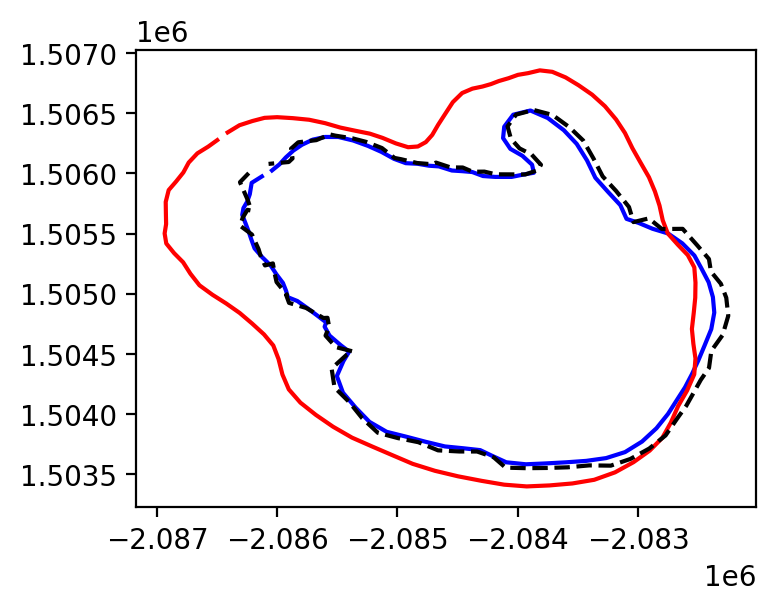

In [33]:
calix = 12
Xt = data['calculations'][calix]['Xt']
Y = data['calculations'][calix]['Y']
X = data['calculations'][calix]['X']

plot_alix = None

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

# plot_matrix_ensemble(Xt, plot_alix =plot_alix, color=(0,0,1,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(Y, plot_alix=plot_alix, color=(1,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)
# plot_matrix_ensemble(X, plot_alix=plot_alix, color=(0,0,0,0.2), ax=ax, ls='-', marker='', lw=0.05, alpha=0.5)

plot_matrix(Xt, show_stdev=False, ax=ax, color='blue')
plot_matrix(Y, show_stdev=False, ax=ax, color='red')
plot_matrix(X, show_stdev=False, ax=ax, color='black', ls='--')

## Repeat Calculations for Maria Fire


In [84]:
# Collect observations
maria_observations = []
for i in range(10):
    dfrow = usr.db.dfObservation.iloc[i]
    geom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    
    maria_observations.append(geom)
    
windspeed_maria = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
winddirection_maria = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

### Generate no-observation simulations

In [ ]:
%%time

# zero concurrent observations
# Considers the first observation as the ignition
dfrow_ignite = usr.db.dfObservation.iloc[0]

timestamp = dfrow_ignite['datetime']
ignition_geom = gpd.read_file(dfrow_ignite['filepath'])['geometry'][0]

zero_info_simulations = [ignition_geom]
for i in range(10):
    dfrow_pre = usr.db.dfObservation.iloc[i]
    dfrow_next = usr.db.dfObservation.iloc[i+1]
    dt = dfrow_next['datetime'] - dfrow_pre['datetime']
    
    ignition_geom = forward_pass(ignition_geom, params={'winddirection': winddirection[i],
                                                        'windspeed': windspeed[i],
                                                        'dt': dt})
    zero_info_simulations.append(ignition_geom)

### Validate observed geometries

In [77]:
observed_geoms_fixed = []
for geom in maria_observations:
    poly = validate_geom(geom)
    poly = validate_geom(interpolate_geom(poly, 100))
    assert(isinstance(poly, Polygon)), 'buffered polygon is not a polygon'
    observed_geoms_fixed.append(poly)

In [85]:
# ws = 10
# wd = 60 
######### wd and ws to be chosen from the runs during the live fire
nsamples = 500
vertex_count = 100

data = {'calculations': [],
        'parameters': {'nsamples': nsamples,
                       'vertex_count': vertex_count},
       }

(array([  3.,   7.,  35.,  90., 128., 132.,  72.,  24.,   6.,   3.]),
 array([-61.8908805 , -41.4352439 , -20.97960729,  -0.52397068,
         19.93166593,  40.38730253,  60.84293914,  81.29857575,
        101.75421236, 122.20984896, 142.66548557]),
 <BarContainer object of 10 artists>)

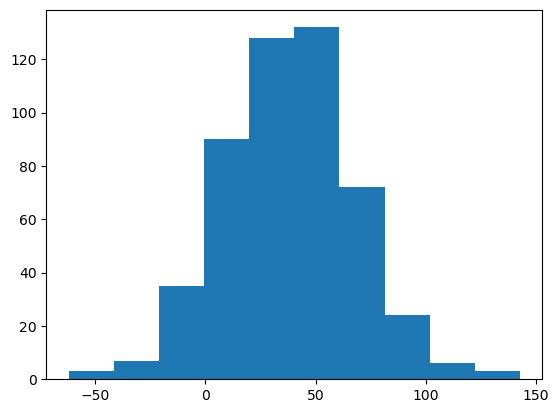

In [101]:
plt.hist(np.random.normal(winddirection_maria[0], scale=30, size=nsamples))

In [ ]:
%%time

for upix in range(1,len(observed_geoms_fixed)):
    print('------------------------------------')
    print('------------------------------------')
    print(f'Calculating {upix-1}-->{upix}')
    print('------------------------------------')
    print('------------------------------------')
    
    # Generate samples of (ws, wd)
    
    # wsar = np.array([windspeed_maria]*nsamples)
    # wdar = np.random.uniform(inddirection-45, winddirection+45, size=nsamples)
    wsar = np.random.normal(windspeed_maria[upix-1], scale=1, size=nsamples)
    wdar = np.random.normal(winddirection_maria[upix-1], scale=30, size=nsamples)

    if upix == 1:# First ensemble, use the first observation as the ignition
        initial_poly = observed_geoms_fixed[upix-1]
    else:
        # TODO: average of the state matrix
        Xmean = X.mean(axis=1)
        x,y = Xmean[::2], Xmean[1::2]
        initial_poly = Polygon(zip(x,y))
    
    Xt_geoms = []
    Y_geoms = []
    for i, (wsflt, wdflt) in enumerate(zip(wsar, wdar)):
        wsint = round(wsflt)
        wdint = np.fmod(round(wdflt)+360, 360)
        
        print(f'-- {upix-1}-->{upix} --\nCalculating wd={wdint}, ws={wsint} - {i}/{len(wdar)}')

        
        xtgeom = forward_pass(initial_poly, 
                              {'windspeed': wsint, 
                               'winddirection': wdint, 
                               'dt': datetime.timedelta(minutes=30)})
        if xtgeom is not None:
            Xt_geoms.append(xtgeom)
        
        sampled = sample_geometry(observed_geoms_fixed[upix], sigma=150)
        # Validate sample_poly
        sampled_validated = validate_geom(sampled)
        # Interpolate
        sampled_validated_interpolated = interpolate_geom(sampled_validated, vertex_count)
        # Validate again
        sampled_validated_2 = validate_geom(sampled_validated_interpolated)
        
        Y_geoms.append(sampled_validated_2)
        
    Y = geoms_to_matrix(Y_geoms, vertex_count=vertex_count, nsamples=nsamples)

    Ymean = Y.mean(axis=1)
    x,y = Ymean[::2], Ymean[1::2]
    aligned_geom = Polygon(zip(x,y))
    
    filled_count = nsamples-len(Xt_geoms)
    if filled_count > 0:
        Xt_geoms = fill_null_geoms(Xt_geoms, nsamples)
        
    Xt = geoms_to_matrix(Xt_geoms, vertex_count=vertex_count,  aligned_geom=aligned_geom, nsamples=nsamples)

    X = update_EnKF(Xt, Y)
    X = geoms_to_matrix(matrix_to_geom(X), vertex_count=vertex_count, aligned_geom = aligned_geom, nsamples=nsamples)
    
    data['calculations'].append({'initial_poly': initial_poly,
                                 'aligned_geom': aligned_geom,
                                 'filled_geoms': filled_count,
                                  'Xt': Xt, 'X': X, 'Y': Y,
                                  'wdar': wdar, 'wsar': wsar})
    
    with open('/home/jovyan/data/output_maria_07062023.pkl', 'wb') as f:
        pickle.dump(data, f)

------------------------------------
------------------------------------
Calculating 0-->1
------------------------------------
------------------------------------
-- 0-->1 --
Calculating wd=40, ws=10 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '001c26c68a024c8c96348eedb21a86a9', 'compareidx': 'bf40b0e5da62466ca8add7db1d1ca4a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=12 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55db701b6f194f14973376f5a1fd94d1', 'compareidx': '19cd27b785dc4adebcd56babe62476d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=325, ws=12 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fb94345e0f74e86b3adce49fa3e6b27', 'compareidx': '229a3a5bca01441d8bdbbe8a492c2d79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=11 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62aa421a881849b4a00b3aad362b36c5', 'compareidx': '5e36d164e09243029010875baa78a640', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=30, ws=12 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea118f72558f4a4d8a657c3b4722a5b2', 'compareidx': 'ea5918715aaa4bbea5de5180606faa62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=11 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f690fba100948d8b3679ca2f3d45bfb', 'compareidx': '7197801c3f804538977909bb8c030f32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=9 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e5f08db3fc64b4288f0f774d0225217', 'compareidx': '4e2e89fa58c743d196ceda59d0805bad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=11 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c20089d2324a4366a3c09355713bf36e', 'compareidx': '2c88cf26896345d584816d01b3fb5d7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f8541a2280549669f3fd0f0b97f8e0f', 'compareidx': '61de0932f8b24e4997905d25f7ff596a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=12 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '64fddafa407d446f895c844b87137ec1', 'compareidx': 'b7f0d7a2981544a29a56d9df72fcb2d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=62, ws=11 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '530c8d8a2e2946d5b4d535f072a526f8', 'compareidx': 'ff770a3b8b24480b9fd338da9c1d7997', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=357, ws=12 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff134c20cd014c8f9d1fcc61b0d146f9', 'compareidx': '962ce1f84e9d439687fa01d69985a911', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=81, ws=13 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52e491c7d266462db7f679c8d0ab910e', 'compareidx': '19ca8efc83f647b0823af5a52cc6d691', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc9e2f2db62c48939a44f9358af14d25', 'compareidx': '5c8c0308fd23417dafd1f7b2327fb518', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=97, ws=13 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ba9ee7d782048b09a767bc0923d3599', 'compareidx': '6c1656c9195b437ea719e66d04b1fe78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=11 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12abff219942401685b1e4a75a5d9806', 'compareidx': 'a04c797acc8d498ba1a206263c381d7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=12 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00c3e6531d5944908ebc1f6af23a044b', 'compareidx': '6d404dba7c1e4f56abd6effe02f2b26f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=48, ws=11 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': 'f6ee697d5790420a9c985c39586107cc', 'compareidx': '8475daec7b574a7f8c08f43e5c34d109', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=45, ws=10 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '920aee54cb3e45dd828478c0dbcacc4c', 'compareidx': '981f594850284bc1827053973bb9744a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=26, ws=10 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '092acacd60e04d3d8658b84403903eff', 'compareidx': 'e9527da9b1c74cb2b92f4774b0ce08e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=12 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c701b2b78f747678250488ee8b7cd12', 'compareidx': 'b880efacf82547a8a9fdf001aa7a0e06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=12 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4df886f518834b52a973cff7a9ee6973', 'compareidx': 'ecfc0783d5834c9a924281eeef30aca1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=10 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0991afc11a26482ba793cca537236799', 'compareidx': '8f519915da2d45c49fc9783959e42722', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=12 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f6251086494429d811392e298bb6eda', 'compareidx': 'db30f9f770074e1ab637b52da331abc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=98, ws=11 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac1d9fd824f44005a2869ac7c7f049a9', 'compareidx': '85605b5160774a3b90798760066ae5d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=11 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c88ea1923aa438b9595994d664ee011', 'compareidx': 'ac16b94b148a48129c93f4dff5bbf902', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=9, ws=12 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c36f443bc76481a95f30ad889166011', 'compareidx': '5251f61bfcdd43418bf8574ca600d274', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=10 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9db00cafa3c4419baf2e670b25c0e945', 'compareidx': '4876437263944438b76491fe07b05cd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=284, ws=10 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aeab95ee7f5b4cea950a1eb869f9dda1', 'compareidx': '39fb3710b4be4e7aa5762cec6196f243', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 284, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=9 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '047df9d3512042959dda535cd5cd3d88', 'compareidx': '8d7944858c054db0ad3474981e814e38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=11 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e8e14d9db5e4c6b9a6cb16115602261', 'compareidx': '0823e67e5d83441b874950087fd2b402', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=18, ws=11 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


{'description': 'Maria_2019', 'igniteidx': '6196aa3f68f24795ab9ec9a20a0a0938', 'compareidx': '2960abaf7eab4f31b520a33b94cb943b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=35, ws=11 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2d0d814e3f849bcab06a10fecf08be5', 'compareidx': 'f723b7814af14f5788d544c7f0e87441', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=11 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '016cbfd9ce76458b8d5b2b9009710449', 'compareidx': '2cb786599ef640c387fee29465359bed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=13 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f91a85514db24cd19212aaa97c01319a', 'compareidx': 'ea779ba76c6f4a3397e1ce2070380174', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=13 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '770cd6bb7341495dbc976bf66b25fbc2', 'compareidx': '3d7034598e2f47bc87e07538078fc4de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=11 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8010a6696c0d47b1a0b10f0ad088c706', 'compareidx': '6f8e0cd083bc40cba2b8081f4c9fd75f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7440e2b066c044059f5d90cc49a72ee3', 'compareidx': 'eaa9417a87844f94a3d1b550a0e4e0cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=10 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53d9979a0f1e432f857b7044fb3a8839', 'compareidx': '29a5778ae7ca4b959927beaa83a3cdd3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=10 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ea50c3032a74bddadf041c8d2c9111e', 'compareidx': '479b8540edba4d5dbb821798516c1bb8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=90, ws=11 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75f81d3c45d443b299bc8952743e487c', 'compareidx': 'ecbe999c2e214495abed00a8ced91d71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=13 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '585a33299d9a4371a02ec8bddfd4dfa8', 'compareidx': '4b293654eeb942d8abb6742231393fd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=49, ws=11 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bddb10e3d3654f12a6f6132147f05c9b', 'compareidx': 'd0b24efa1932428ea65844709043e40e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=61, ws=11 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73b7fe0064ea4c5685c51cb387922d6a', 'compareidx': '9870327916b248e79dd933d32f67b580', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=10 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8f8e72670e64f5a8021513c4abc1af3', 'compareidx': '228209066e864e99be204de795af5795', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=11 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65188385561e4410ad64d4bd79952fae', 'compareidx': '6fe9fdf3f6e74831b30c4df37281a294', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=66, ws=12 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e978a7fe26434d91b10eb7a576da09b7', 'compareidx': 'd0615d18f14d4478930406ce597b51a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=12 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c027777f80d4f33a92ad2ce9b77a41b', 'compareidx': '0ab5ca8d3aad4644a44b3dd3824d8e3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=22, ws=11 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b3695c759d044ccb5f8cce35b3e0fe6', 'compareidx': '04bc015a114341f69e512b82251d6d6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=11 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6362ea0c0c34bbcb1782b9bb17c7f88', 'compareidx': 'e9adbd7ea37a4da78b540350b2f8d175', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=10 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '581f8c5863794c859764b039f5332b9d', 'compareidx': '648972250b24403ca932d250f66c0da6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=73, ws=11 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a87555c1a7b46169287a79ebbcb116d', 'compareidx': 'b75618752b05415595d4e79022d371ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=11 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a428887ce914415dad2a70f2c4bf518f', 'compareidx': '1bec99949e1d46d19535765142e173bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=22, ws=10 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d94511317db43fa85cd220ba5cf9f0b', 'compareidx': '55b7304830cf4977a5170c7c6cf34085', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=11 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82fb4607d7f649d68b16d84c9a699670', 'compareidx': '8d525c01475a4f9c99f05b5a9023f36a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=79, ws=12 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c5f8138930641d9bf742d0e0536d3c3', 'compareidx': 'c9effe9e0c8348d8a8b58b0522463938', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=88, ws=11 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5425f341aec45729f19e5e42c35aa4f', 'compareidx': '8e3189af8da84c1db9aac63d4010138c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=11 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fee1e899ebc7497a9ad17406d84d6786', 'compareidx': '67544ac896514fdd9c57024dc3b569d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=11 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8def5d80a784098aab7c1e2569deceb', 'compareidx': '3134fe1ff3054d6aba98319dd700e3ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=2, ws=11 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d2eb1a6db30474cb82b0667913e2dfc', 'compareidx': '038e0b5bbc3446308468381bb02d726c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=9 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c487178e14744af4bcb27884f9572406', 'compareidx': '0a914b21d7194bfcbe946cb3e9dcc3ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=329, ws=10 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74a730a2ace44dc99eb66d050b45ccaa', 'compareidx': 'a1428aef63464c84a43f481fc331ea7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=11 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1b3912b3e0d46fbb1181876e5aeb99f', 'compareidx': 'a9f4e56a7ee54f2e820127488368bcca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=9 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63a7f43dc4274dc58904292b2092de5c', 'compareidx': '20eaeade1b254408bdc815ab1402efd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=10 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98e47dae8b754451b6c42e33a960473a', 'compareidx': '20c66b55ae9b4682b78ff8f787d6fefd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=12 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5eb740a71cb34d089e99c25282c6021f', 'compareidx': 'f6e33c662b194719957db3ee3191f7a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=12 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe0046fdd6484617a3b44075ec7a0b46', 'compareidx': '46aa3fcaf48344d58a2fa58522e3f5b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=10 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ec272387df643ddba0e1de7e0de326b', 'compareidx': '8299642651b04388bf391bfc5d7b2945', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=117, ws=10 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f7be0a061414da3a2ff1b82cb016a37', 'compareidx': '7275a9dd9393460984439c256a117727', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=6, ws=11 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45571657b9c8431e8a77964fd04e1870', 'compareidx': 'a606054ff32b4d239d377cf6e35e7576', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=13 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94e863c4d1b34ab0a21cf03423046fd1', 'compareidx': '58ffe2e777e94695b16fac3f5fab788f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=11 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8aa700bb03034578970bf259346abe57', 'compareidx': 'f7a4c1340c3d4511a49b1c482adfc3dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=11 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd4caf96104b4aa1ae53f75214127068', 'compareidx': '0b116e61a706445288ff3647dc63170c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=12 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95866ef94ddc4cd2aee60762f76f75c8', 'compareidx': 'b06f90a931504479945484115864a3e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=9 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa19c27303fd412d9c7aa5f099cd05e5', 'compareidx': 'ae019e4947e944269181fa018096e8d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=11 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87534717a5384e5eb66a5258474d55a6', 'compareidx': '769f9d3acc794652b95c010463f544b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=21, ws=11 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '642274e910ed467d9853a924e22f7ab7', 'compareidx': '4e76fb9031a344159e465cc5525eefa8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=11 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49b08df4ad854a019afecac0a1af984a', 'compareidx': 'a87d7f356df2480d910097392f44c17f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=6, ws=11 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3faeb41e1bc049548099b35daa77d092', 'compareidx': 'c791ed8b4af34baba5f111605775e8ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=11 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6954143099e44400a982723ef435e214', 'compareidx': 'd2d1a745975b4f36b2dc363c9dbe4797', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=11 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdfd22d513f74ffba897f3ef1f19df50', 'compareidx': '37cdb051c1fb4c1e89647a77b281cd24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=12 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c1dcf387eb9424cabaf3d48b658d1b7', 'compareidx': '8a79b8be4a3645de91ba35ad980e9985', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=12 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99457fc78fab40c28d9d16ed83712089', 'compareidx': 'a26cbd784d1c43c4b78e682d03221f6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=11 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7865ac5354804d84a9f87f9f0026a5c7', 'compareidx': 'b7d64cc69d0e4174819b677f4154cb39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=12 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c6b84d6c50f495fb768bf4891d574f4', 'compareidx': '5967cc1388b34cfc875a9f95c355fdef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=11 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4dc38e47abc43218293a4de99dae45f', 'compareidx': 'adb00604364648e7aa65237b883fe187', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=13 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94813e071e5447208b3644b898d6e2ff', 'compareidx': '7a25752f20d2497491d46a117f75f1bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3753f0e78567473d89c3be62454f0ff1', 'compareidx': '0fa9d313264845d1a5a5a779fa545029', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=11 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1422e1c7b7f043c1951621f4313ec5c2', 'compareidx': '85a4bcc73d7543b9a08dc327804eca76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=47, ws=13 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66f0af1aeea148b5bac5f42004687705', 'compareidx': '9350638e5e6c455189e0adc117d5be76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=10 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '467c28caa09943bf95e7f26398e60193', 'compareidx': '1c0a8df53c00403b9794acad6b7e72e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=11 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd461c5ae545a4903bcad41e992a60670', 'compareidx': '41d4ebc04c7b4834a886397ed9cb972b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=11 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3e10db801a94af99715c5ca3791bade', 'compareidx': '7177c1be1a45464da6112cc6d5e8b49d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=10 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc371712782543199e01bff444834251', 'compareidx': 'acbb8f0d95414a5a9d1db15da086ce22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=11 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04a48648173a45b296a43a0af16bc8cf', 'compareidx': '62fd76256bc6490dbf32d3a571cb2cea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=10 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43939364bbc94661bf6851e0ac6f87bb', 'compareidx': '80322d0ddf864845963c35bcc7ba69df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=12 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62819af5d5014219b3bb3c2df90cdd17', 'compareidx': '0b1ff64389564401ade30f7de0cd4918', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=74, ws=11 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '905b21ed511a4ba7b676b8420baef95f', 'compareidx': '175eaa9cf7674b0eb738e89bff19b627', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=10 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fc7b17940ce4851a6ebf8f73eabd8ff', 'compareidx': '7d87ab280aad4ebaadd7c6fbf30a63b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=9 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fbf90693cad14641b7284118a2827123', 'compareidx': 'f4089f6065ae424999244abf5777a92f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=20, ws=12 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c53e0b756771444ea84ffd09c0d1f94c', 'compareidx': '19c65f5462964f28a98e0b0a570fb22c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=63, ws=12 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d739d3aa51841db88284e6de3f10d29', 'compareidx': 'f243ea3b2fa3435a820e82bb3862859d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=340, ws=9 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e8960f005764ca18623cb1a3b296d70', 'compareidx': '6d4e99db69e448e9a7a2ca963e83c617', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=12 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d85ccd0ff654e4487d82386a04e705a', 'compareidx': '19c0ba0f911a4017b841ab7864875d45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=50, ws=11 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe21bfbd817b4c97b456c2e907698d2b', 'compareidx': '3159cb028981445385c7e64cf057d956', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=13 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa640e6e98ce4926a46408e9281826b0', 'compareidx': '19885f0dff8a4fc98431e0556d01517a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=70, ws=11 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a6a28ea65574228a6dae7b7ce72f2bb', 'compareidx': '754157cc6a6f44009ef1a0ce90dc19b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=11 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c06c5cc77ff45ebbb2667ca5bfea633', 'compareidx': 'c3cd1998ff7744b090b17b8567314e0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=10 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'caf25e320b2a49ffa084bb4441b60c62', 'compareidx': '77a87f3dd1004d61a894229bf6ec4e05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=13 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96931ad27bd14546a29304605c045aa3', 'compareidx': '767d4ed7427e4f228577944279d5c596', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=10 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5385eb3c84f4db1887c2717141e5b43', 'compareidx': '6d0dac4439e04b4fbc07fdcda90dd1ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=89, ws=12 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99ea46767acd43d29e50218090ac5e5a', 'compareidx': 'cf375a0a5d694d039b174e10970592eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=10 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e124351d96c445f9d5f7915c8b52341', 'compareidx': '39900e08f7be46b19777e6ba676ffc99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=353, ws=11 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51cb8f6c04b144f2ae52338c6c699b16', 'compareidx': '1a7f9509046b435396196f4d73da0082', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=10 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'adb24905c440460ea71b375b01cb71aa', 'compareidx': '486dc8d2eb444a18afeefe15462de61e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=344, ws=12 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47b6db628ca146bd8f46c7b4444a3b53', 'compareidx': 'ce4934da89bd4be8bba6bd8b18e99790', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=9 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bef86e1657ff496d8929c19324f07cdf', 'compareidx': '738fe1b15eeb4ee8be902fd006d3c597', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=2, ws=11 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6224b2cdd444462197951a3cd84ff072', 'compareidx': '40c1c0bea27448c090455d2bf0c04848', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=57, ws=11 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb5990993ecd43b188b8ef9823406142', 'compareidx': '6822fea13aa440b7b36ebb66961a172e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=10 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3c49bc170ec4056821a96275d161b02', 'compareidx': '4a9eef54fd6e4ff8905777e4eee3017b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=66, ws=11 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00a8d177ae1d4b8399a5f836554a32a4', 'compareidx': '94bc3525c90e44a090a95ddd8bf93235', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=12 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f628100c5dc94e60802f90d6d511706a', 'compareidx': '6aaa4eeaf336418dbddd12b0d604268d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=9 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43f808ed5cd54f8b8d1be5a7a7c3bd34', 'compareidx': '5197cc4c49b64044b823fefc03335b17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=10 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c69f499672884000bf7ce1096c26ef04', 'compareidx': '80eafd99d3594da08e8cf24e12c93e72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=72, ws=11 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45e9971437ab436b9ee94da9a69550d0', 'compareidx': 'ed28fccce72f4f60892c6eecc9883d53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=11 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c78deada0af44d8aaf24641166c0f484', 'compareidx': '944c39f3d5b34e53bed9fb2ee46693d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=9 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34d275ce13a14fdb8413b96fc8508f30', 'compareidx': '28acae1209d043b18ab8b3642f9d5777', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=82, ws=11 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47c965064cb94849bc9045f5062d33e8', 'compareidx': 'd65ae30ed88f4ca6884a36b195bf3c49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=34, ws=12 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c446f5711c2a4452abdaebed53c6be2f', 'compareidx': '6ca64d12b70445dab340d5dde632475e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=48, ws=8 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ddf1d5948bdf4981a97a623c57df3e03', 'compareidx': '8e29210e60eb40f2a9ec7d32ae754245', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=355, ws=11 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bb5fd376be24ed49ffa036644be75e2', 'compareidx': 'e1c8752010b24901a54ac364a9786e48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=10 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b35b734b20e04fc78ff0c0cffc302182', 'compareidx': '15b28a2d22d14013826e5bd90cf15017', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=11 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20521bccf0c3486980b1636a5951fcff', 'compareidx': '7cc14d73208c432b9c69febe5644aa4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=324, ws=11 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9084c2a9319248b99dcc75d392f4c0ca', 'compareidx': 'bb3ecbf7c07c454393cd3c3501fc51c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=287, ws=10 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11d4717841bd4a4c94c55b4d3a82ab36', 'compareidx': '57cad39c44974d408576921b69848284', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 287, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=345, ws=11 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4768778c14ff4cd29533450eab794fd4', 'compareidx': 'e75b0a34c72a4aeea545c25f3a2a570e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=10 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3446f82fdde42239c0d652ff80ffec3', 'compareidx': 'd6cb2b8ef137432daafff64edab7761a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=11 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea38a24529f748b88baf87fe66612090', 'compareidx': 'a7d5c33891614bb68aa04246423b7b3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=10 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9452bb1280a410aa0bec5446885d5c5', 'compareidx': 'b1c8581023df4d8cb1d844d14be05905', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=20, ws=10 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a30a59c4bf2406bbcca8f890f272e7c', 'compareidx': '403d188382a5456282140c4d5982cd5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=14 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6cf6f934077e4f84ad5c589934b03ad9', 'compareidx': '855f992b1a67428b90ea4e461ef6b0da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=12 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb5c0cf625854ec0ba8f60ba1e9a2761', 'compareidx': 'fe299d4b8f534d67859736f7a42c5c13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=52, ws=11 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4aacf5ee20284f5882512e8504bf5fec', 'compareidx': 'b644f7c0a38d431db9fafb32c2c2ec5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=12 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a73c9145cd44f198279a6fd42b678bc', 'compareidx': '6683128bb41c420ea9f251bdb35bf8fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=11 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0cdb31c88ba4398840066986f7c3bcd', 'compareidx': '71025b1e6ad2472190161cd24cad10e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=11 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'be32b6ac8d0e4dcd9595592ecedf5998', 'compareidx': '7d3dd19283004694af84ea95a782ea4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=13 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db27792c98d44e0bba87d995aa6b8d9d', 'compareidx': 'f3b0aad7ca3b47e8bd86f705607fa43d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=13 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43a7370529b74efbad9fc553722d0175', 'compareidx': '70acab4660e146189c2406f92a057d58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43f0c8df918f443488f0e1c6d01803b7', 'compareidx': '874c72deef1247c4a905ac309ac7937c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=17, ws=10 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9d850feaefd4c96bc371f99d63c5215', 'compareidx': '97962d4fc9d44ba6860758c1c206c0d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=11 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e73eb567978b47d6a46b627596044913', 'compareidx': 'dda9f740ed5e4b3db716bfd37ff469c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=52, ws=11 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59e25ec2bf974891933159ce60a0b5a1', 'compareidx': '582e0532560744e3969c0c846f52395f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=11 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6984e473c654d7d8761e653071fc8ed', 'compareidx': '29dfdfbb2e554c26b35b018d56ab2482', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=9 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0d92592bc554817a47a4c1229e3555a', 'compareidx': '4b18e0cfb50445dfa1eb2ca85df72ca0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=64, ws=12 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '682de4a28aa64fb1b1d1f22b0b823256', 'compareidx': '65fc7248da8a4167af5480eb30ac9d35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=30, ws=12 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95e6e7e202a6423f963f505ac4f535f0', 'compareidx': 'a423caa0128340b7b161b034cf70bf19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=101, ws=11 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59ef03917f3c4a719620c2304e50c170', 'compareidx': 'ed609abdac57481ba0b4f9fb96a25b07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=14, ws=13 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f22ebad41b354a1a812db6497030d66c', 'compareidx': '487fa6fcab704a8bb6eb103802307a61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=49, ws=13 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0c75efa0ab1407aa77dccd309be6847', 'compareidx': '90cba8c2c057458cb5900b000da3e13d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=11 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8b9dd5634154093b16b38fb5fafdf76', 'compareidx': 'dc8735f78b57499794a88dfe10915dc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=12 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4cf142a816d410d8ade83d139d71d3c', 'compareidx': '9e82e3d597da4d899d5661719d275e2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=11 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7753d4b41a2a4b46b1def3aa615bde26', 'compareidx': '3528b63ac45549628d32e8d3480e4a64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=10 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b886a08abef047deaae2fd6f28735b94', 'compareidx': 'c8dad9810a11481aa27cb35b020af988', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=10 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9515e3cdcfb45109ddc05293c42504a', 'compareidx': '103d56db208946b5b9d5bb3093e79365', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=10 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e00898ef1044661b94f5e1cfcd31103', 'compareidx': 'bd7b6182d80548bbac8a37c662c39bc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=347, ws=12 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cf7e3960343473f884a12bd586433d9', 'compareidx': 'd23e9ca1ddc94d3e98097be5124b317d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=14, ws=9 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7cd0725c5b44940bb739493388b902b', 'compareidx': '9dc4556d147141ce8883950832ee0b95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=103, ws=10 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '012b6e5462714712a851f8edb4caa036', 'compareidx': '2333307e60854acba19eedca2685e83f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=352, ws=11 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f77d078ea6d409c852d9fa08a2beabc', 'compareidx': 'f5eaa5f98e0942a19a91af9cabc7b327', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=11 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1751d14d5144e89bfdaf2fc39c13687', 'compareidx': 'c773275466784876b1129b6b31773dbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=11 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a564c8142834e23a0f06b965dd682be', 'compareidx': '3926db0d9c3f44da8ae937446e403e61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=10 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15f74096be2e4ebfa2a673335e449ab4', 'compareidx': '21f98ed680714864b0b2cbe276dc8ffa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=74, ws=11 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9964609f3a6e4a8883d17a30e17afed1', 'compareidx': 'addf87345ce247b0a344a73a979bed53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=12 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e382f8501a04481bbeb358acc0b40bb', 'compareidx': '0c99abff60114339af20686bb9f763e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=63, ws=11 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ca22fc548c246489424e488d636df1b', 'compareidx': 'd82dd3f8d17c44e5bbe31de62339e398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=71, ws=12 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f23da3b7fcc24cc29252470f61cb2941', 'compareidx': 'fdbaa8cdc5d040a5ad14fcbce791d22d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=13 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1496eb75ad804071a69f2e05bbcfe4b0', 'compareidx': '6813c6de31514b219784c3149f349dba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=10 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'defcee3069534d7da2cd36b30746e4c5', 'compareidx': 'd8335b7d0229477aa31fcbfd81dfbbac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=13 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e5d63e176b34b479ba52c5f81691291', 'compareidx': 'd328ba92351047bd840a4741427aedc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=78, ws=11 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e5e0dc55c864dacb995414f0638f0e1', 'compareidx': '9f8f710f677e4903b5f7f157d0de4a7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=13 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a43e29a953dc43c0aaf02aa0bea433c3', 'compareidx': '5887b2c0e44e4dc6b6256a4f4a56ccd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=80, ws=11 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab9aa2d8de124f79bbd511bc1219c98a', 'compareidx': 'e4ca4f795baf419cad7e38bb4b689af9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=7, ws=8 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3fc1eb61a8c4a02be3c4dfe73d23257', 'compareidx': 'c2619515bbd844b2b4a03f3c156a92de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '669ddf57df0b4a43bfb72637f607d4a2', 'compareidx': 'a030461babb94717811632156fef21a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=11 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9c5bc6859784821901ecf0c7254dcfd', 'compareidx': '88c5dda0f9c4456f9f7c7c4158df7ae2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=11 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf9ff74601174a669839811ae025cbcb', 'compareidx': '567fe022f852436198350df8e3f75dfa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=30, ws=10 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a65a81b4fa5446d3a112b0e629c44afa', 'compareidx': '668eb04493924f98a3e30c8ae9a82846', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=11 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bd95c7b4c3048609bfd8871fd686018', 'compareidx': '698ebd86e46447b69d78fddd297aee7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=11 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd35c33c854e4c57a23a5fdc9cb94200', 'compareidx': 'ccd45fe9f29b43d0b9c2788f74de9b5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=10 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f57eca45caf44e0a8f4f7f0a2ad05cd', 'compareidx': 'b757d248e2af47bdbfb336535be0e85a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=11 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e69cb0322e644e298e5f5c084ca81a5', 'compareidx': 'ed5d54dc0a434a45bc6d5ec22ac24f9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=10 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8cf2c8409da44debb49d819dca188684', 'compareidx': 'ac192091ea8741dd809417c6768b2a50', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=11 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65ebe2167a604132b89e4c917ce8adeb', 'compareidx': 'b5e96ef0873e404799243812ba0364a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=11 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b28c119414e34e20be6a273189f754c2', 'compareidx': '99a3ded4b3e0496ea96ca93c2c782018', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=12 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e541113352a4e1681795925251ad55c', 'compareidx': '5298e9ecb4c043c5ab9458d36abba031', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=11 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1f95b41fa12436da7839cfbc3e1d313', 'compareidx': '40a3df34752f4c90ae0d5762d991454b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=12 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd418c8ff81a4ffe8d01eccefd5b9710', 'compareidx': '8c1622e4669a44a39fd35bc44af8ffce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=10 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c3a21f4359448989e9a0c5705657bf5', 'compareidx': '207db4845a0c4e339805fb86deb3930d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=10 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3be0d84a068e48389011cabf5a46d52c', 'compareidx': 'd49b29cf9b8b4f59b996be5bd28cf3d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=11 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6af632f5f5a647d6bbf9da61542a92f5', 'compareidx': 'a8201bbe1585484bb5dbd8acb4db40a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=66, ws=11 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3182ef37134841ac993e547a10c7c627', 'compareidx': '996fde5573a34e26bcb84968dd79b49a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=10 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ee4450937d045bfb9d7e12da65dad6e', 'compareidx': 'cde7f4ae1a114c7d98ebd8275c95b05b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=10 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7643ce038675400baa2d4507be54e245', 'compareidx': '652f810154624659ad8a36b6cb4386dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=84, ws=10 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53d91e7ce13647bb9f32fb3f50ad8230', 'compareidx': '98caaf5599164c378c117be4b763399e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=13 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84dab2bbe25247b781615f7272442aaf', 'compareidx': 'fd18da38430947b584be5e679826b2e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=11 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89386d53ef75468396012e53345e0630', 'compareidx': '069068e3d82943bc8b33549a4aa25ac9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=10, ws=13 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36a57bff07454d2086c8a45d0f2441e8', 'compareidx': '2de1eb7352e54bfab7e3241a8199c7b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=334, ws=10 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3e0604a53bd438daa36ff69e412fee6', 'compareidx': '71889ef5acbc428890db049a30f68398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=106, ws=12 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47fe7c1d5ffb4b23b5e273cc6ef46135', 'compareidx': '4414dcfaa3da4f2b9d26d1581fa58dd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=10 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4a494e2721e4c15b50c7ec1d82caed9', 'compareidx': '5c68d837bd904031a20704585e79953c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=48, ws=13 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee832c9d974a49f2a9ec5da1e0243c58', 'compareidx': 'cac8b26a33bc4491916035e8e4774a39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=10, ws=10 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8962030582774df981cbae084aac8e0e', 'compareidx': 'a4c6843e7fe446ecac3ef996f8b1f104', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=10 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '599ea69974a04b67b99c2db33b1266a7', 'compareidx': '157c5f0118fa43e9b1d2538d837bf73b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=10 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa728028001d438fafd8382e64f8f3e6', 'compareidx': '47039511f8d247388d4b16e65504a2a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=11 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51dc13c9409e46b2abaa5d2953be752b', 'compareidx': 'b459964357644a5891a537abe1a33713', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=11 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '833621d0dbf6417ca50d30390a147851', 'compareidx': '0af0fcc9e57f40a3a9e6c32ae8e297a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=12 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '862fc0c2bf3542daa4b112667acbe8bd', 'compareidx': 'a9d50812638e488990832c530959b88c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=9 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcd6d0b8a4c74f8fa6dbebc9e0651b9f', 'compareidx': 'd64b31e848af4d8798d9ca82e3c2658c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=335, ws=12 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b33b9133dbd8415ab1efbe48e12db9a9', 'compareidx': '53b5e014e7704afebb0cce73f3cef1fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=350, ws=11 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9154dba097d8439c989e4f57b0c3b079', 'compareidx': '70b9a11cacd742d4b70f647c4ffa1ecc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=347, ws=10 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '999b73d43b394f748fe4338ffdcf9895', 'compareidx': '9f9e2591c3b84e0ca322a24281c98ef4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=10 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf588a5a665c4fb5bcdc30d85c58e779', 'compareidx': '47ec9e18a75c4bffa6ecf6aa73d86020', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=11 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43a98d1aab784841b5a7f698397ca5d7', 'compareidx': 'f3789174589a40b7ba9285ac10ba9ff3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=10 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8ed7d527ca942d884d49f5cd736a5f5', 'compareidx': '0819326588444157b9b1874b1f4f1a31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=38, ws=11 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1124d439e0544f7fbe3f82472f0c71e7', 'compareidx': '8148eaa5cd7b45b59cb1b44d91ea59cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=309, ws=10 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6eb4ecd925354033ba0e57befd437572', 'compareidx': 'ba95c3a6ddf946b7b9fbd7d4d0d94533', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=12 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5faf6e5907954953a50c1a71662b58be', 'compareidx': '18d25f7f95ce4436bebd954bb5581d2e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=10 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11baac70cb5840cfa74700fa516c39d6', 'compareidx': '9a8f573dd37543faa90b75a1212766b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=345, ws=12 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '073d98c26f01457783ea291b77f2e954', 'compareidx': 'e44c211ef7504ee1bfdfcfbbb4b1513d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=11 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3aeb9615c3ff4926977fdb6b83d8eff6', 'compareidx': 'f9fb6b9724a54fbdbf6a6ff45c27a9a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b4276b4d3674e1eb826d1b6df847706', 'compareidx': 'c776ea36051143e6b1abed8d6179c1e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=10 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d2b4d88090649a5b8847a8627aed823', 'compareidx': 'debf6111785b44dcada8b50754656036', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=12 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a3b17ba25c241d3a7c0a3911d17e17e', 'compareidx': 'eda751d5056045faba5192b0a9adbff5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79b81e7f05f34659b8888a6de49ec988', 'compareidx': '5fe1c7b8dbfb45cf901d281cc082f53d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=7, ws=11 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e3ed97907d94708bf60d1fced091fae', 'compareidx': 'a86bde593ee74dc1ac399ad6545587a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=52, ws=9 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5793911da71649cd87cece1d20c1ce84', 'compareidx': '4822ab722e6242e08a6166c5edef1ba1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=343, ws=13 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bafbae3bc6f144588ed247e62b86092c', 'compareidx': '45a96fafb42749319387807255ab6cb7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=92, ws=11 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13ae0cf6fac54e2a87e93db387fb4415', 'compareidx': 'b787ce8c206949b3af3f1c94e66bf0db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc1bee23e5b24b69a4eb04504f3cb30a', 'compareidx': 'a72dc87044444e07938cafb3469b58a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=68, ws=12 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b872aa5f4aa4ce0a9b9a621c2981871', 'compareidx': '02639baa4389449a90f5edfa25d4421e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=11 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16c11ad126ec48e99f1826af7e60420a', 'compareidx': 'dd323d09e7e44fd8866a0b1bd8ea0c8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=11 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3995d0ed84ba403eb5943854f02d8880', 'compareidx': '7411a5ce35484f8a94292e53c6e9723b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=12 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f8992df2bbb4b3b8ca5ef403f55da60', 'compareidx': '932f5b722bf541a7915bccb5ce9912a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=85, ws=10 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d58fdd4a69d4b4a8d26e3bbcbc25e93', 'compareidx': '1cdb1a96f0ec4f539d00141841cccfc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=12 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bdf008c33ba4b1ba98d81e311766111', 'compareidx': '20a7fcab906541b49eb10b77688c35d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=30, ws=12 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a3c551335434960a416eda735e41bb6', 'compareidx': 'e1d1001c3a314d2db7460693a08f56e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=327, ws=11 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eeb6da7e69f04ec8b4a6bc0a6d3d55b8', 'compareidx': '40908ee762a7403a93f09818879e3a21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=12 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '35b148a0a28147e1a86d7808d1110e12', 'compareidx': '43638bdfc70f4ddbaee3a3eb85ba0ec7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=9 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4238abc7e58c4e95b6a9d77da3c5c524', 'compareidx': 'd890c826b07743588c3244b8ad84b604', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=78, ws=10 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b642cb49771a4fa88aee05a6954087c2', 'compareidx': 'b033cd36bb43474bb22bea85f0b29f7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=11 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7904f7d4a7cd401ea4eff61553160766', 'compareidx': 'db6da9e16d9f4aad8081ceb8aab1ace8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=67, ws=10 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d8c75c6882742e3869daf3e36cbb6ca', 'compareidx': '56c11dec13604a3c85521c9879d10fcd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=34, ws=11 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84588333940e4fff9e70cd5bea66c659', 'compareidx': '65f03760d74c4dd691da8fb1f87fbcc7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=77, ws=10 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c449cff88548489d8f929a6e972217e5', 'compareidx': '1c3de48d02ef4ffaa96a42dbc883e3ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=10 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecb33c3ec5464f4d9352c79205461592', 'compareidx': '5f06dc71e03c424b9649fc39be4556a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=13 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52479e8d77624164993f145419740ba9', 'compareidx': '598a835081af44bcb54b2385b1264747', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=11 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdd8b4cdd2174dc5bc915ccfb88c44d9', 'compareidx': 'a66780844e1f4f9bbe2624d3652ef23a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=9 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '595cd6ad7559477490b14255fe1a7442', 'compareidx': '778877c8d68f4c929509b39872c13750', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=13 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3435baaf27584df6be22b188c8c083c9', 'compareidx': 'd795573af4244b568cbfb5b3c9820fdd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=331, ws=10 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1d057ebae9f4f1e996dbb535f0fd6f9', 'compareidx': 'ebe72dfdeee54d6e91a327253494d74f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=17, ws=11 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c46905104ee640d0969f05e9821053dc', 'compareidx': 'e26bf2b5d5874430aaa23f35df6f6fd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=11 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '113ba5ba55634187a9032c3263b8771e', 'compareidx': 'ad6e9aa8c109447bac84526aa6a14d17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9caa9c7c4b64eb7a41d48733f703acb', 'compareidx': 'ca280fe69b044a38947f221de549e42d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=12 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7bb134e6ada47dcb0d51e8957d6ce70', 'compareidx': '4af4178376aa43d5bec4a14fd43281d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=72, ws=10 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06f58aa72c3540de9ac893d87f72ee0a', 'compareidx': '72906b9d62da4d45bb5648edbb7572e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=12 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba0f78490e694498a8966fbf57884afc', 'compareidx': 'a3b5cd3f71c747ab929da3803ba3389e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=356, ws=13 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b5cb431b96142748cb2b9a50c7e298d', 'compareidx': 'caf022a6639645e9980302ffb8532c9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=58, ws=11 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6f063c96a1244028ef43a548f91f3be', 'compareidx': '3b83eaa5c8e74a37a3723f716a43652b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=10 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26d53667d5cc40dfbe1899704a582c83', 'compareidx': '9d8cbd3499894f7cbdef7e300d3624d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=38, ws=12 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b735d5984e54112a59c992d2d7e12fe', 'compareidx': 'a43d3ade348a4108bdf75c8ceb209d05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=11 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09b25d5e662d41f2b1ba69cbc4706281', 'compareidx': '05a6482470dd4ae8b4a8a5cf6bcde7d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=10 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68e3194dd4a14672934e2c1e96f51ef1', 'compareidx': '758c9c7f2b304c1aa8fdba425617c883', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=10 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9390bc726a9a4bc6aa07603af470ee51', 'compareidx': '9baaac60330e488ebbf993c909ec8a1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=12 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7c3b266c3aa46c29d8c1a9b7623969c', 'compareidx': 'b5b4487f8ae6471f9c332a93355d2e1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=22, ws=9 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b17ba453c0c40cf83672d8f8d4af677', 'compareidx': '895aa68e91674172828a88be893c05d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=12 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6906899fc1964fc5aa91e7c19e50c408', 'compareidx': 'c3b094328529428ab599a8f39a34453f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=82, ws=11 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd40a917ff92a4463a45f7f9f70028395', 'compareidx': 'f4e2fff4f906428792c80da78f43f5e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=11 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cf6f5d1dde74f6192a45512fad6eb3b', 'compareidx': '3c31cf0b35fc4b5389a3076926a7e82c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=12 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dcb7e84603634dad8abc9ecfc1679bbd', 'compareidx': 'ec83cf126cb148dc91ae974fe12803eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=10 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efc9f3878387424cabb29bbda038aef5', 'compareidx': 'cf7f39040f394570a6566790311ae0d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=11 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b9270b516e642809062b728307108d2', 'compareidx': '3d68ee8f21d94313b0e44b642d4cd3ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=12 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27165d00f387446184c975df3bbabb0a', 'compareidx': 'ffb4dc031fb14d238065904ed372679d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=73, ws=10 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e3cd8aa49784910a402e651e70c18f9', 'compareidx': '365d9e5353d047438cffbf354d307bc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=91, ws=11 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13863c09124f47f79bcec2797fe35d97', 'compareidx': '09ecbc381bfb484aa1dd40d7fb1245a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=11 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0566e6770ad74a85b4984b62333ac96e', 'compareidx': '77bc71f4e27f4c87a9db9421bede2b9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=8 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bffeec820ff94be38b35dabeaf22a717', 'compareidx': '98e7e831922b4c47aa8952f5749fe404', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 8, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=85, ws=10 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd77c09b048234f3d8007ad04c6afe852', 'compareidx': '5d442adfddc246bf9fe4cca17ae72f3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=72, ws=9 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7bb7de0620445209a9cb085069ebb99', 'compareidx': '302a7e900c674d4c9f3e3779151dc726', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=11 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65ac5852a2db4ecbb3e22b4a2aee7715', 'compareidx': 'fea561fef7e44e9e9dd8775901f23e41', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
-- 0-->1 --
Calculating wd=20, ws=13 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7caa901266764f1bb1fea4202a3d6d19', 'compareidx': 'af7ca56f0cf6490d9697ae35f75559f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=52, ws=12 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f6689006ab54026bd1119158d4ba560', 'compareidx': '2431d730fcaf4c55a6d6adf0ee28ed4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=17, ws=12 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb341a7a838a465ab7fba054b2d8b2d1', 'compareidx': '50fa4d97fc494885916b23f5c5547450', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=93, ws=11 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3453057917a54cb9934f954eefec1159', 'compareidx': 'd07ee0fa5b9749aabee14d2c66d9cfb8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=336, ws=9 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ce7a626f85d4d90b6d69378dd322bfd', 'compareidx': '06ae11d1ee4a46c790628cc1d3e0caf3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=340, ws=11 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b7eeed070d248239b08f502f64d7797', 'compareidx': '5ef13375672141d692f160d2a54b3f94', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=13 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3a8d6291aeb4265bc3b926be3a4105f', 'compareidx': 'f14e33febd3542d58d701fd12472bd2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=11 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6123a5dc3e1549fd8e2d11a17df64896', 'compareidx': 'f4997c2b946c45378db014525d014360', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=11 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab70b524c25d40e6b8e494d304971750', 'compareidx': '256e076c5f134ca29ac8029e03cfb867', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=12 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8948993c21b4bcaa563280fd819fac7', 'compareidx': '10fcddb9b4384a6bbf831ad192729413', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=12 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4f870e270764c559ae9f743d5197a7a', 'compareidx': '572231f4acd44c10b3d209c976f66559', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=97, ws=11 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2aa1ee44037747b1b244627854bfeae6', 'compareidx': 'e2d50f9544a94e788ec6cd20935d5f2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=11 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f3aa950b222445d9bc86752a79f8605', 'compareidx': 'c01f9a3aa6d344fba220162d61ea0268', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=345, ws=12 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66ccfb2bbb1d4a429ec7f7403c2ecab0', 'compareidx': '00b7bd632d44478ca40a7a4a4cdae5eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=11 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d6d434d154f43319c019725bdf52418', 'compareidx': 'f610842e8a4e41589ed9502dfff801cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=10 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cce484fe8ce4f7e8c92ff154f41b16e', 'compareidx': '35677991cb814e68bf2bc710240c4ba0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=49, ws=11 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58fdda7ce50f421ba4f36635bba80d28', 'compareidx': '23f7c1c27ede40ff9171fa95255c222d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=12 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd26217b4587f4ffe90d5881a54948c56', 'compareidx': '67f320bdad6548a880a87566302a67fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=82, ws=10 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d4ea5beab394367bad3e69b30584c85', 'compareidx': 'a0691805eb6946c5b446abbee5b6369b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f88e58a07b6409ca97b5e18bb53f58e', 'compareidx': '705f9aa880804701a3f765dc87b68497', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89eb3125c5fa417d801ab9f3e6f28023', 'compareidx': '45bed993ee354157bf720f2222f94e18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=7, ws=12 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b243a8e70e2548f3837b61cf33c99d69', 'compareidx': '76df4511aa8d42d39db4ae7d745ca567', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=332, ws=10 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b64cda74c8464d449570798bf5fe7b24', 'compareidx': '24f7c418e9e24d239b5da4f15af52626', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=9, ws=11 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47bd39429c8e473f9b1fe9d0af0fee70', 'compareidx': '15dfbd44da5a46b3bea464eee3dd7384', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=9 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc9679a7831f49639d2cb2089eae7cae', 'compareidx': 'cf25dd89cd124349a290b27a209f15a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=70, ws=11 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31063aa8b49240959927504052c9025a', 'compareidx': '19f5bf123e8b43d584f56c0fba4ee25a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=323, ws=10 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5c06ecdbc50446d859112544efdc3ce', 'compareidx': 'ea6fdecdb0df4e75ad46ce6df359e186', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=10 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12ea4394a3f64b3fbf3768510165a288', 'compareidx': 'de0b7babbec4435792376a9234e81d08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=11 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2934e031cd914d3bb39d97b90c502be0', 'compareidx': 'f83794a399b04f669c1c9c4229129d43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=14 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91077bd3e37f45b28a5db0b3359db32d', 'compareidx': 'e74d4bd4ea2e43c5bb7f29205af760bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=61, ws=10 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5668aae44094bd491edb73d386c310d', 'compareidx': 'acccdd2fc1854c2bbe9fb77bb8e1004b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=49, ws=10 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e59e0129382b467688a566cd8458484e', 'compareidx': '656edbc0fd4845b4a5c5a2368fcfdc37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=12 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5011799925d24aaaac94862c1b16ca41', 'compareidx': 'a24dafc1b5cc41d6ac20390f2d586eb1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=11 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecebd3645d3241bda833a7c71b0e8784', 'compareidx': 'aa3060410c954debb204804d0008135c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=17, ws=11 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6871e01677f3408ea21f5a5536533c4e', 'compareidx': 'e35d66130b2a4d8592a7875fa100164e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=12 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ff5ed044f6c4696a9b98c7d9f81f215', 'compareidx': '827c07a802c14a359fde1104870717e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=60, ws=12 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09d2025d350348aaa407804c5975f36a', 'compareidx': '436af6ace63f4036a89805bf8a75c1d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=12 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b823882d590a4228b36ae6e9260ade45', 'compareidx': 'b69b47c123f94f6fb9c25f2918b68f37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=1, ws=12 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0249b188d54412ab0e559e56017b997', 'compareidx': 'c45be2ca4b964dcb8ae1828f65d91075', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=10 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54857bcb75f6493e84581bb6a1a7ecbe', 'compareidx': 'bcb4696b3b2342b09264530354e95edd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=344, ws=13 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd5c4cbfadd6462483abac5c3c3eb3ac', 'compareidx': '1ca50ddeaaec48018cf91d6d7a764218', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=11 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bc444f04ebca4d44bd99ea2fc0be3635', 'compareidx': 'ecef6d8844a94ed1973af04cd93b4c30', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=12 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c6c98ebee8240b5bce9cd6c3cf5915b', 'compareidx': 'b1f8c38eaa2947a8ac09db7070af2d2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=9 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '815284b7986742a4a1ea621cf2c68bab', 'compareidx': 'c443d050430a4c528a64bb327b94efb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=78, ws=11 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0ea4d1ca7e34cb4b4e4d35aebe09bf8', 'compareidx': 'eb891ca52b4e4f4580db1781851c527e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=10, ws=11 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a8e918256db4417a4071e1d8935960a', 'compareidx': 'd9a6aa65edc4413bb4cc40be73299f65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=352, ws=11 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9cbb7f8e59ac47cc96d7ed2d30caa742', 'compareidx': 'f91725b66eae455894fd9df11d440026', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=11 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f106fd30898f40faad40f069d572093b', 'compareidx': 'b5c7314b8bef45dead090de1a1b376e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=359, ws=11 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1f77b201a4e454d9ef0683fd243c9e4', 'compareidx': 'a90b29c2678e41b8b56b8ac607323ce0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=38, ws=11 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a124223f87749be8bdfdfb3cc5f0908', 'compareidx': 'ce0ee7815024405587002f9ee0cee7e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=57, ws=11 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f15cba5d45254c46ae38c68a60e8fb22', 'compareidx': '5b7805835f004b6b89e469ecbe9b4fb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=11 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bb0dbc95bc544c28d3070734655dc6c', 'compareidx': 'eaeb82dcc1dd4ef6a268c417d1478594', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=16, ws=10 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '922348b4a3e244c2a93293ca6fc9c252', 'compareidx': 'ecbf53ae6b384f34892a71ce1d863712', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=11 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2037b4585104e04bbec9775ccea77c0', 'compareidx': 'ced617b90020422bb76169ab225350e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=68, ws=11 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60cfe457942a4a489497497498be324a', 'compareidx': '3869da7e2e744faab4296b1c3049ad66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=11 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eaa4ba149f7d41769b9480821c770eaf', 'compareidx': 'd71a6df0d5ae45c68cea3b223c2ffbfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=11 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '863291fcb71747bf830f4d231e2f2a90', 'compareidx': '126346bbc45d4a8bae0fd343b1dd5c26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=10 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72c66306483b43c38e5830e37b76b843', 'compareidx': '8b1987b4026045f488e7f8095733c29a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=11 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bec2353fd695442b9d466269d317e6f3', 'compareidx': 'fadba9b76f58497792f55bee32729444', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '630e144ab7974b439bc13950cb12d3c8', 'compareidx': '6b186beac95241ba85a0f240402666c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=12 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '875b710acf09418cb1fb342bd158b5df', 'compareidx': '6497035e41d74650b495a16270220312', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6fb26de1a4f45aaae77dddabb9ebc5c', 'compareidx': '471c1caae2244d6484b7201f6a9a0077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=10 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93cf7e4542c24ff2a2abd8d4d769ffd8', 'compareidx': '25acb6323960498ca630a18fa0c9317b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=9 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e25ea48bc7684b61abf9fd64ca7f3f07', 'compareidx': '0609e0c65ce745c6b3059b08167f7aa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=11 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07974ede2c6047c6b798d4e20db5e215', 'compareidx': '65b5c60f612d420bb530f354a652124b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4668fbc028df4e00b42392b3fea2ff1b', 'compareidx': 'e3a2d2ef7c3343528dece30a7bdaa743', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=10 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d39e4ed06b84b8f941a109a607968b5', 'compareidx': '2235fd7b24f34374ba48496e9fd97a66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=63, ws=11 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43b01e88171d4f75b21e8700f40b224f', 'compareidx': '48a98d9912fc462f87fecc568660c46f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=348, ws=10 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83af85b4bde647fba5854d2299b19655', 'compareidx': '7307714c01794ef387e221862a1ab644', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=81, ws=12 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b6ae63857f34462a42ec1aea6e95f21', 'compareidx': '30c4e184addc4524ad292afaeea21060', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=12 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f27c29258be41e89a7edcdf533c6d16', 'compareidx': '30c995d1881947f79179e5a38ff38acf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=109, ws=11 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff22c99b5e5d48d58699baecf8282d9f', 'compareidx': 'b9e1b656cf81409eba617d2ad41fc779', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=11 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da0346fd681d488c9eacb9df70818677', 'compareidx': '6240f8feb4304d5d987fb00a8ddbcb96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=96, ws=11 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c89fb83d7ded4b37b70ee993a6cd270a', 'compareidx': 'b2521bed02eb4be292e086d661652766', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=11 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bca57f2b75b442e6982b3d3b9a054257', 'compareidx': '38c36253c5414a57a94ff278f6fca297', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=14, ws=11 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '002a7b1e813448e8862a08fcddfb8e34', 'compareidx': '4b103ec90b8f4fb88a2d682ddad34c9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=10 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27eb68cd753c4f91a44e9359a8bc8d16', 'compareidx': 'b0d62a10b710474b840c7a2aa4e56d13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=11 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c80d849ff2d749698e8a027b569b2e53', 'compareidx': 'a21b3fba4d8b4a1b9a3139d8f6116eb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=12 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2dcc06906b34bb5b668346068172ea9', 'compareidx': '973e7b33d01e4329a86995ee59a45652', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=12 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '169df5b9d6164e508eafd05a9813344a', 'compareidx': '9a82a086471a4e4fba42be9e42283476', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=12 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8855e0cd5ae2474fa5022ab40084c3cc', 'compareidx': '8cf10febf24c48ea9a0a3f802616d580', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=347, ws=11 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f44a766190cd4cf38bc6d920a892d1a7', 'compareidx': '9061bbbc145f4f22bad6caca495cb35b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=9 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f867a8616054b5f9b12cb10821e4cd0', 'compareidx': '211f048bb1c1443682da70e721875755', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=46, ws=10 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a344d33450c344ab8dac96e3f7be467c', 'compareidx': 'e64732c3772347dca793533afcfde268', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=84, ws=10 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43e14e48771e43a8a5fd1a233a8e6c29', 'compareidx': 'ef0472b8932e4d4f9f0376c8506aff87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=24, ws=12 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '028ce45decf54bb7a03ef03fed133ac2', 'compareidx': 'f2274034cd0d43d9b2705f3355c5e5a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=11 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74d6375e887d45cd981709ef97d4a842', 'compareidx': 'ab973df744d54e0cb01041e3c7b543b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=12, ws=9 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f756d57296884fb6b890536395068fda', 'compareidx': '75efbae6a1ac4e33bef677b0a4233125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=11 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2bf30390c5e4f989c4a2f54dd5be27f', 'compareidx': 'da35fe5e9d4847e983d2e29f0a0024b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=11 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9616190c3a345bc8bc81c0278cbdb09', 'compareidx': '5958d92acfd647fdaf5f8fa6476dceaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=12 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd726eeba16bb46638366e1e220961411', 'compareidx': '0c407d4beba44da0ada79b8e0c1de19f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=100, ws=11 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '529bfee552d74d60a8e14a3e754380f9', 'compareidx': '97821a89956f448d87d8426253aa7467', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=63, ws=11 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0fbfa34ef824246a1c269ca2d72c60e', 'compareidx': 'a0cf764d99ad469489d17d22d2aa948d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=12 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ec9c5abdc214a6f9ca531c71bbd1055', 'compareidx': 'b1920e4d48d240c9aec011b769939c81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=33, ws=10 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebfeec10b26b4e6183bad40bf66982da', 'compareidx': 'cae538080a1548b0be4f0721ed1846b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=340, ws=9 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4eb8c5a33c4d46b2acadc7eccbf99495', 'compareidx': '35c4693855e8435ea71c89612934db79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=12 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d0e2c1403f84befbdf0a470bc846258', 'compareidx': '90b05918b06c410981c767481124621b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=351, ws=12 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ce36f2030a04295a6c40d3108ebcc15', 'compareidx': '46a91efe82724b25b325f98e63e3253e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=11 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c538c74448643959b2c4548450307fa', 'compareidx': '857a6b54f83444f793ee7c25f671a7f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=14, ws=11 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '592853719b1d4c1899e92099430c7681', 'compareidx': '581a3ffb80824cbc8bd0dcb99f65a724', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=12 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '422d6ce53f2a4d84b9acd29606c5b2b3', 'compareidx': '09a6c0dfae0e4c89baf711496bc07022', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=32, ws=10 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e78fd6e84fe4a48a5b17b32fd3e806f', 'compareidx': '75dd33697eaa4e81968234bf71ac49d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=9 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01a1211e81b6427a83ca5921b162ff14', 'compareidx': '01c4a42b577b431a8ee615803bbfdb7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=96, ws=11 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b51f4e41aa694e799c426f0e62111460', 'compareidx': '157e9294a5cc4c3885971da6dc01ae2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=89, ws=11 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2279620bffd24b7189d36ef384bede12', 'compareidx': '381652b9316a45ff8be344de2472714d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=100, ws=11 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec0f35f8580d476499bdb6f737c2b151', 'compareidx': '9f89d3323fd24bc38329c9117b97b1aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=5, ws=10 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd96ff66f3e1349fbbde4661bdb501f58', 'compareidx': 'a989e021a6254bccac13ba8c6ae2e945', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=59, ws=11 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87b6ed093324418f8f26a85cfae9636c', 'compareidx': '34ff25b14bd4447e95f268e72b26984d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=38, ws=11 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a24af350529f4febad864a3de8a6d94f', 'compareidx': 'd237964aa05942808c458ad51510fa0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=53, ws=12 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5118c73601d74be8927660ee6789c5fe', 'compareidx': '4a840e633f5b4a1ea565538099283e26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=75, ws=12 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2fba758dbcd744ac980487452c05016e', 'compareidx': '834cc2d053cc4546b861bea06742840a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=12 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b0d793ea5fa4026b9736028679ff28c', 'compareidx': '432fd91324e9473eabcb206f140ac663', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=9 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd709a92c84474a05ad71cf22b078f759', 'compareidx': 'a7fabdddec8440a7938c433567a4e61f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=12 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8b0d9f7bddf4acdbf7b92a6a5cc354c', 'compareidx': '0144338bd3aa4877ae98334464161f9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=11 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4079f54917254e61a331219b2c6bf3f0', 'compareidx': '9f726ddded6f4c4da182f147ddb0a41e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=60, ws=10 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c005fdc588f047eabb162724e8ec6526', 'compareidx': 'e2e70f3dec4d497887e7a180cb75a3f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=10 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3978007f2cbb4fe8bbc624d42cd3f33c', 'compareidx': 'eb6b4f70322d4dbd996ca1f0e712c03b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1acffed9f8542099ad0d3b1f51d3051', 'compareidx': '29baec665e9447a1930c75f7bf63e44a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=12 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '495f03b2ed6148c9a8a71f66d53b0c24', 'compareidx': '8f7b5de34b08472fba13d01022e05d3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=12 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7f91cbe04594321b633d61b1f055889', 'compareidx': '8fdce76b3e4f46e8926b7a62dcdda009', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=11 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76cba86d0b504bfabd132a9d441d77ce', 'compareidx': 'd6c7be9e9fe640639d6577cffa0af21f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=36, ws=11 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46ed2280a4f54fff9b91b0cb5374f82c', 'compareidx': '05873d2d5f8c4e6fbf139b98a0ed0c1e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=325, ws=10 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c590c8bba3c7428389b600e53fd01ce0', 'compareidx': 'f67f1f84651d463090114c079bd90de0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=39, ws=12 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9d2e34262fa46edbb90b57f10ce1729', 'compareidx': '9beb502f41ca4f4e94f2b61c3ef69163', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=10 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c56630b73a314d4086efda7e6b3aaa95', 'compareidx': '4a0811e1ebb24a4a9316321f1647b6e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89147c1ed32948d8b679d453b82993fe', 'compareidx': 'b7a40f4416744bdfb942ff3d2c779c20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=11 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd42dbad9b09b4639bb03906fef356c6c', 'compareidx': 'cd4b385b38864de09d7471ba15ae1cbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=11 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ba096cf6e93f495687565b4c6b72defb', 'compareidx': '4f3cebb89641424996c3381f96b61e03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=72, ws=11 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32c4de5e536c456fad3d95a79b120f9a', 'compareidx': '4b1ee7a91e434d4fbafdbd460eeddd4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=9 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bfa8c61d12e4d36b28a8f75dd6b7dea', 'compareidx': 'dc1c2fab97534fb2b2434bb72f390c0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=48, ws=10 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6b7d5b5f40745fba65e2902db314799', 'compareidx': '02d0da61fa464e70a23233c01ea3df3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=25, ws=11 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0dac5cc234da43e1852932ec13d016dc', 'compareidx': '899498fc878c44a3a224fa74aec0241b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=12 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2bbf2d77aff4316ae05a94344cddd65', 'compareidx': 'ae7b1b0e732d4d999afb8bb3c12e5345', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=92, ws=11 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '678946c5f7794d7a9cc1cce0a11dc69d', 'compareidx': 'a471afc7f92a454f99b14b89f0e5d253', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=35, ws=12 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22a2bf292b0841f598d025a34bbebb53', 'compareidx': 'f02a2d5a48354c7e81ab19aba28b3e4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=10, ws=12 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bff167885044f9195f6caea22cd0ccc', 'compareidx': '83837918d88446779fe67a20dc76bce0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=98, ws=11 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe2f15b660784c66a39a58e57960f455', 'compareidx': '6e095d3613a0427fa1b3d280d6580a77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=12 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e272de4485648c3bf2c081353db0e1b', 'compareidx': '95eb5391cee24157a42a8e85d53ee52a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=12 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6feac20334b743fd9b0f6b41a9bb2d9a', 'compareidx': '1f5b34c470d74a8cb64978d4287fa0f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=10 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '548456a229e8405c9c50325a84c274a7', 'compareidx': '249431ab4799460f94d7756698b27485', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=19, ws=9 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a7a4592ab1d47cbac2a2f77e211cd30', 'compareidx': '23f34316fb5c4b6f9b02d351b396abd3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=9 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3798a6beba03460899c88a9faab53cc8', 'compareidx': '27c4e1c3a3fc450a93f9b67f8bf1a116', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=9, ws=11 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed4c30a21f29414386f6fb4a8ec5393f', 'compareidx': 'e476cffb442b4af6bb77c89784f7ba08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=11 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83681857fdb04744859f1fa9087a0cde', 'compareidx': '29fdc59348e3461ba628eb43a2c51bf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=55, ws=12 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '094803dd1cbb432fb10ed1ee685b5051', 'compareidx': '671e663bdfac4b76998eba342178870a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=88, ws=10 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e17c4a108e14cc2a55bc450d681c6e9', 'compareidx': '7c2f4213926943d482b485387a113b1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=51, ws=9 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02ed10b57ea946e6950f159287fdbd92', 'compareidx': 'f921fe82f0a24db4adc3b08ce63bbaf4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8247d55b7e8a4ad5b0aca73e2571a8e0', 'compareidx': '1c5d6f2d2e634f0b988018120b08edfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=64, ws=11 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '693f0ea9ce3b4affaac7775824122038', 'compareidx': 'cc333c59c7074ef99d42a26ebbc06180', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=11 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38e242d048544d7f9e0bfbb42ef8ad6d', 'compareidx': '3c26a50db3cc4ade969503ee4a0d73d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=65, ws=9 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41880fb4e9d2496aaa889338a6f36638', 'compareidx': '029be1a38d834a01b470376707a9d8f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=15, ws=11 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef5deeaa5d7a47d6942d63f99f339c53', 'compareidx': '631e8b758be441e28eca495a4a253cd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=41, ws=11 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1553463d43924bb2aae320f6f18cb596', 'compareidx': '86380007117b4726b09bb47f64918ee3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=76, ws=11 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac5feeef02944871a07219e950c6891a', 'compareidx': 'a903e99abe8f476596b64bea8eb93b91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=9 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '758b8c61a46242ecab9031a489a52d12', 'compareidx': '6ca7d681ffcf4899b8de094a7d68df20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=64, ws=12 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d9dfeed379141a4995b191bec02d651', 'compareidx': '428dc3eb1101415680b5371b240d9af8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=10 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7efb871ebd24064b79edb2989402886', 'compareidx': 'ba92ee4f10c9402daac0207516901e0b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=10 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'deb3b71359844085986d9ef1daa919fb', 'compareidx': '92b86fc241764ab9842213a0d722ef76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=72, ws=12 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '987f323e93d74702a64fdc3a85babc70', 'compareidx': 'b8d44e5cb71e4aac84501c8d816cce4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=346, ws=12 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8dc5bfbbad8c497bb922fed9208fa7dc', 'compareidx': '02241b4e137c4dcb8644a8f17d9933c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=11 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8ce69173d934b14a55620a14bbaac10', 'compareidx': 'fb305f083e3047e6b00ab4e69cdccf42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=11, ws=11 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2358b4c95494fe792573d615838ca68', 'compareidx': '5d29f38839a646b09489369d5121dbca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=8, ws=12 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '551ed093b4054d0d84c0001ce88cfc9d', 'compareidx': '595c1cfff3584ea887cc64b37e9bb7fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=10, ws=11 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5afc34c797ea462992faf91e30c80c34', 'compareidx': '9348d2ef413f4e249fd5d2b4035ec6a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '19e4367ccc0b436b8de85b570499f13e', 'compareidx': '85a2ed8899ae402f8050411db709e28c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=26, ws=12 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '418f9562fb434d56aad894923482531a', 'compareidx': '2543e2a2bd344ccd8b1fc0c21c9d550b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=34, ws=11 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '200efb9678c042c8b044a1860f7120d9', 'compareidx': '6ec77f072544479f80d1a48967c8eea6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=42, ws=11 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '307714c6889342ae8fa8deb40034aa5a', 'compareidx': '8c04de5cb999405d9bdb23e3059d8058', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=27, ws=12 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '660bb42d0ce34bfaa4b7fcbb1f008f86', 'compareidx': 'd12b019a79d14f2a884e39f964635534', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=84, ws=11 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60520bf226d04783b089348d858e6af3', 'compareidx': 'cc21ec38d347472ab47697f07c509063', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=68, ws=11 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18ce09549c14460c94bf084abe4bbd20', 'compareidx': '57169fbba7a24ff59311e18fb296dafe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=64, ws=13 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10912197ec874b6291cbbc36e982ef1b', 'compareidx': '8280381038d9463f9804f5c9c7dc81f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=87, ws=13 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '35c0a392814d4ce0a47e20619b61a4a4', 'compareidx': 'eb6f59ac508d4a1886a65e236f865dec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=352, ws=12 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1a56c91e94844558077f94da227c9e3', 'compareidx': 'de0d20fa4ff5422a838ea2984347315c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=11 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0ea6d01f64c41b6a4d7ae5ba7c67783', 'compareidx': 'ba505e7e378946bd8f1345338976d0a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=12 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6758100d84a9472685d86f49b98ba185', 'compareidx': '1b9aaeae1375465aae2e3f8c351ef1d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=47, ws=12 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '755b5017f1c648af8fe3b248bcc1ec50', 'compareidx': '0893550b4b394001bdcbc4f34b16cfb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=359, ws=11 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce99dc22913a4d3fb04aa928a5c0776a', 'compareidx': 'ce13bc92185342ceb1a68be7eebb3887', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=23, ws=10 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9b352a9dc284e1f8261450c2ea3a3a5', 'compareidx': '3a253ce84f1e46b9bd157887326149aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=9, ws=9 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce0d585dd55e4bb0b02556af42c0ea84', 'compareidx': 'bc1b239501ae4c8ca6a948aaf5cfb355', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=43, ws=10 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5f8c4e79e4e4a92999bb5d73bba9215', 'compareidx': '6a4ee76ceefc4036a86194c8e480d412', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=18, ws=12 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ae318a5d2494a6587c9892ad7690621', 'compareidx': '8451952f25e549e090cc2c5b3ed696d9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=358, ws=12 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee18ada16e5b474f878d16c0831ee92c', 'compareidx': 'e0b3414b3eb74d3e86484baf4e021ff4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=90, ws=11 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ededdf3ed9114e2e9dc68657551e169e', 'compareidx': '634757cf031b4ec5846fa372aff7fe1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=11 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '684c16cd51b141b5a7f3fbd93ffac18d', 'compareidx': 'f40086e779a849cf9f655041aea70874', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=354, ws=11 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07d4c6568deb45f593f249214ee5794e', 'compareidx': 'b286daa24edf49fe8199815a51311ec5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=66, ws=12 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bca389306d9943209797c18071143ec5', 'compareidx': 'a63a29059e9b44e9bc251b5888b0fc70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=63, ws=10 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f064ae98d405457aa45a9e6388c06f22', 'compareidx': 'b8b6b8b1bc7f424380c7e0ccff5366c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=40, ws=10 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36bb64c6a08c4e52a0afe270f8f36a21', 'compareidx': 'd201df95a1ac46b5ac40478d673042dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=44, ws=10 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40ed43fc92de41528d85185e78a9b6a6', 'compareidx': 'e2a993f5684d440b9900ba6d8300a541', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=28, ws=11 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '766d78089d054425a9ff25951cb41337', 'compareidx': '93a61bb7af6c4dc4a8333116c7d274d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=11 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e872a56717df4a10a263b641488878f2', 'compareidx': '600d41a5cd7149d78715b171577ad1cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=20, ws=12 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5b880b658394ba480784823369ea7c1', 'compareidx': '931634c66d274aa0b9d8532ca7a59aff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=31, ws=11 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36ef365bf4664bf3b5303b84e9a3976e', 'compareidx': '96e9f511f3f5404e99e2d15340f85292', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=37, ws=11 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a69c5a239eb48cbae786d667bbd8135', 'compareidx': 'f11df0eeb63e4a32b38b79e92218f16b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=49, ws=12 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00f9d683219c4dde90ac7a0e5bd459e2', 'compareidx': '8fd9119e272b45e8b5fcd901d150e68f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=54, ws=9 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee457916b5fa4814ad6be32184837ca4', 'compareidx': '697100e287734c2c8f15180dd877c9e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 9, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=96, ws=13 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad4e25a4aa9a4a99adf9067ad07b7b3c', 'compareidx': '9d46e85fe9454478b78c13e72312fb61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=10 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dac08f43f0984f87b95864f0af442c66', 'compareidx': '3838c3822e504b259bf96e71537eb9a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=11 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f452a7a906e54b48894e9d0b0e587c1a', 'compareidx': '75ecca4148dd42eea681f778dfb88e42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=13, ws=11 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e6f403001924a80a9db0306edeb0324', 'compareidx': '6f84d123d89b4617afe08730955bc638', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=56, ws=11 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ad1675e2e6d46ad904a0eea5ba3be9e', 'compareidx': '5539db20db8e443aba20602f99dad53e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=3, ws=12 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9eefe6c1be3c444fb5e6b80b481a27cb', 'compareidx': '978bd8cd4c264f9c89bc1ab44c96a8f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=69, ws=12 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb2b225ad4704e2ebfae126122d5025a', 'compareidx': 'dff21fced7df4b1f8f1c004649160181', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=45, ws=11 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6815cb32f7274923ae002da4fb05d3cc', 'compareidx': '1c8c2c4e2eda41cca55f3bc5b015d10c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=83, ws=10 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3344433d93df479191f4ea60f850f08c', 'compareidx': '8f963f1dfdf74748bbaaaf77c76e7548', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=12 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0e4f820a8dc41e688b8b64f0282833e', 'compareidx': '9c4b3a363f08460c9a180c07e1240b61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=4, ws=10 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '361ea582fc6f41aba15bb020fdef3a80', 'compareidx': 'e658294cb5df4190978748846da193d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=29, ws=11 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0bbd99f0bcb42faa5258bdf4de5d342', 'compareidx': '43f6336a3fb44d4d86b85f6ed281323b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=0, ws=11 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab660ad760834bb3b9d150e9db634eaf', 'compareidx': '795e56b08c5348109f1ce6ba789c2ccf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 0-->1 --
Calculating wd=60, ws=11 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f9f3e8462ee4650908242587fa36482', 'compareidx': '885a78ff321e411382bcc066853bc04d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 1-->2
------------------------------------
------------------------------------
-- 1-->2 --
Calculating wd=38, ws=16 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78078a6e22aa432d9bb8e966e3508d06', 'compareidx': '7eda664b390b484c90e447b17db839f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=19 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6f58e28c3e248c187cd48fd2d3fb9d6', 'compareidx': '52ae5739f120409b8e6ff89697cd14d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=19 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da5684af76904b3fa155fa813579e8bc', 'compareidx': '92fed08501064e53aad18f44845d14bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=18 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e31425128a534009856938c8ed0b6b5c', 'compareidx': '88fc6c01b5cb4cf3b2521485f187a0a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=105, ws=19 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2603a4f74a674c97b921e6e90dc65cac', 'compareidx': '103dadf079cc4f7594e403f0e136f3ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=18 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5457ffc8b224f05a87694886e131049', 'compareidx': '8ff6a8e68d184b79ab67da93a07c6031', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=17 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c0cd06f663d42b7bbe67cd15135de23', 'compareidx': '20afe7b011bb4210a87ae36b711506a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=95, ws=19 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ee4b6c859574600ae150dc5abe61dd4', 'compareidx': '445e9e5835c448b495e8d712008ba20c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa54cb45de614bb387775e813294530e', 'compareidx': 'b02e98c88de748f6a05c1969b09717a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=18 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7720ab4af2bb46d4bdf39ae7f6a301ee', 'compareidx': '970c7a60fccf409c9896cab366c152f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=18 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5836fecfff6144f6abf6b0a4a42eb922', 'compareidx': 'f8ec7ea93ecf4db0b7c5aebe8f107dc2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=19 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8a13408d4b44fea961f064cddb2ce78', 'compareidx': '1d6b6927e72d4319a9301dfe0724d198', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=19 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '776e60057cbe44ffa5ef1e15bd1b031a', 'compareidx': '20db8e0299634b109fa1a10d5e9c1636', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=84, ws=18 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d11b1c92bd94eb79eac96d756f0abc3', 'compareidx': 'a285546bd91c44c68dfc2036ebb1f62b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=19 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb83df411b7f424d88ca49346bc6c918', 'compareidx': '4c48a2a381a64c4898daef04c3b8b967', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=19 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb9e815befc94d69ada0b0111782c469', 'compareidx': '1d333c87924e40f9a9a1231da63cc4ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=342, ws=18 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5521ba69f3e5416a974906bdfe25b32a', 'compareidx': 'b10410b6b1bd418bb0aab1cc1998c442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=17 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8cf27fb6e20475580760b181438957b', 'compareidx': '0dea66a7088d4d188a83fdc8890d2fd0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=44, ws=18 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '607e7e4e4592437b88d28a8a8fa76fc1', 'compareidx': '80f9850c40fd4d0f8b41f87eeeb9325d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=42, ws=17 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a824615ce0894b73a5dcaea7320aef74', 'compareidx': '83affe919c6c47ebb14d1f93d0c0cdc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=334, ws=18 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc032375c03341b68bb603d9f7c97f6a', 'compareidx': 'b7fe360898b1423fa2df68f8a70fb34c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=19 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87737d0e61b9477aa86dbde2032e6d31', 'compareidx': '6c4d3d2dc60c453caab3105ca12c5af9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=100, ws=16 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aef7e07b10e64fb6b2eb6361df10edce', 'compareidx': '1b213c4b41b4461290bf81ba5a075320', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f96da005237c4dd3b42a5991bdfa9345', 'compareidx': '8bf9b665224346d99d637c59b2c158c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=17 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06f0599fb1174e5e806dead057e4afa7', 'compareidx': '3d8bddd456854a069009cc79b6ddde42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=17 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a46b723294a9482597f827830d1d0471', 'compareidx': 'a9ff7fd8cf8d4cd288baa913a9f5cd61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=18 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5629bc444c14ecb9bd1fe2a2076de07', 'compareidx': '731c77235494447a8aaf19875d4bba11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=1, ws=18 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0479c76910f34f3484921099e2597f1c', 'compareidx': '8928730e03b445f784681bf19afa3a50', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=18 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b4f3a7e1aa245bd828acb43087c1c51', 'compareidx': 'e2ebc7b79286478db985973326a848eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=17 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa809aefc08244cb9156008fa34a77b6', 'compareidx': 'b1801374528241f886729b26440e0ecb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=19 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a38c4488fe6e43958ccd5b5dcad4e256', 'compareidx': '7bd75e8e3ca44a50aad9699acd088bee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=17 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5bb6463e7204d6a91630fcbf44ec4c7', 'compareidx': 'a81199e808ea492da177b6b4582955dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=55, ws=17 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '449195798f3446bd9f9010dd9c89baec', 'compareidx': '6b2d21738e824b6f85a91f8f8f6ea5ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=18 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '259a476f46494d9482ff8170061a4003', 'compareidx': '0a11b419f13b41bca07aa229aba47af9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=82, ws=18 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4240a5c9f9cc487c938bf61bd3a07a35', 'compareidx': '4ad38f0febb0467db3df7e230e698351', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=18 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11aedcbacb234d59bfb27800bde90398', 'compareidx': 'fd7462e6876747c2b8639f3d80a20293', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=98, ws=19 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed13db54d83d4cc5a9ef5d1ab7b9a166', 'compareidx': '6189af3a39b845a2b4d3738c301f7098', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=19 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8d0eed25eb043d4af82ba231086732a', 'compareidx': '0bf3aa5666514e30a9aac46bc7aee5b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=18 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '899a4cdf77464f74990e4fd5f7dacc2b', 'compareidx': '1fec5f10f4e5456192d6f598b1bfd8ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=20 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65f86eba9a54494095b669997df8b902', 'compareidx': 'a74f1bd4204a4fa3bc1e4ebdbbc968e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=18 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '601f8d3896494f518d392c8b4f3d9973', 'compareidx': 'c93ace7757fb4d05a32bc098840ceee3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=18 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14738be65dbb44d2a77ef1354295f0df', 'compareidx': '0d9d625350cf4061adeac0155e48a6cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=119, ws=17 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc972374054d44e3bbf984ceafc77555', 'compareidx': '24bd988acfa74de2a2833b49ed84d433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=19 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c38130942aa4207b34cc8ab693a0219', 'compareidx': '4ff4cecf04f2423ea3c96db3c51d1599', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '774eac59c8174b5589f0addf8730db60', 'compareidx': '2d18b2bd57664bcc8e9f7127f7e67ced', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=17 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '576697937d67441fb7530d773ea02443', 'compareidx': 'ca20216bd0354b8b991f9d9eb28abe04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=69, ws=18 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05f337d118f845509509bc57cbcfe291', 'compareidx': 'c56ec083fbf44067970172b92c27aa81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=18 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ebcab5bb4d34ef5adc7fa0df76e48f4', 'compareidx': 'fcad9f38c74a4c5da6074c2b089fad33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=18 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d4411ed17424767bacdad79d47e7afc', 'compareidx': '2883100e948448f9bf1c535fc5d30836', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=17 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37951197b4bc49559115b88044784f8d', 'compareidx': '41daf0aefc824ba7828dae2907e5b739', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=19 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91f22d64175b4020a3b642e598dc09d5', 'compareidx': 'a3fa80e83e564c44ac0400de3424168e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=17 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8ab6396dfcc42a59e84ecd2d7c30bf3', 'compareidx': '7f863e31badb4a25bea68b1489f73fba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0d7c028774d44d2af0a281c8b584f63', 'compareidx': '298f4eb2f33740448844a50ed9379cf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=18 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b9f738aa16f45c88901b53d18d21c8b', 'compareidx': 'ef2eb33a5be749fbbc594472dce17ce8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=20 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '810672a874fa47d1a6bc7825dc321c81', 'compareidx': '1d1d46ca53d743deb0ce619e400a4c08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=113, ws=18 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e574a77700214b5fa574249299327fcb', 'compareidx': '6261c513f66a442c96f7cf8cca15e43c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=110, ws=16 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27fd42d4ff734e8e93d5c80aa8904a6c', 'compareidx': '4f7fa09699dc45cd8af09fa8c58af1aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=17 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8113d701107d4287a29b1fa1aeac1d38', 'compareidx': 'baa5c5f93d2d48e1b9874808585d42b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=16 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7aff26603154178becf0a419091c031', 'compareidx': '92d4a5eac16f4e2098151b8e13de0fc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=97, ws=17 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '369c3a8f74774b6fa275972cac92cfb0', 'compareidx': 'c5d87f8be01b4eebb9589b3d7dafa57e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=16 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3720a36ddb434ada973ae7fb32995213', 'compareidx': '0492d683d28346f4a8f6f1a427e1a5fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=20 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b935dc014c9f4a8d9ccabdec5647fd3c', 'compareidx': 'd413fb9c25434524912dab07b2d9df4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=17 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '177aab0184604b6fb25adcf0480cbedf', 'compareidx': '891725d56c0a414197b7ee6ec71a7444', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=17 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68bc899d809942f8bce6f08ce39f1add', 'compareidx': '73c0bd97b10b407faf487f1675ee7a9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=18 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09da6f803a6e421284c1fa8a99b98186', 'compareidx': '523755832cc9424caf8ca62dc560b6cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=57, ws=19 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '027ddce9d57641e3be3d5e019d8e2f8d', 'compareidx': 'c71675255f694445b99ba723178db7a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=95, ws=18 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7a9fc0a2619458483b134a69d0e157d', 'compareidx': '27f5d9a146c84da68fef0eb96b427432', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=19 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb1d8ecd606a4442a379a198566b6e23', 'compareidx': '4895abcfb71843e19a8ff95fac26ba02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=119, ws=19 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c764ce0f17324decb32c614fb9775988', 'compareidx': '0a2f129af176451ea87fb5022b90e70d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=19 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b340a1af284b43fc90febeafbbee1df6', 'compareidx': '104fe11797f249b69a2660310d54ef0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=77, ws=17 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f8338e2bc2b47708dbd8ee8987ee944', 'compareidx': 'a7acd420188945a092166387f34f560d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=18 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c95386c18e1499a95222523154d4a9c', 'compareidx': '142efb18eeff4f7f8a1b3ec7d2394992', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=18 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8c33030193f4491ba3f46d04c6c0e2d', 'compareidx': '0357d6dcf01b4b14ab4f8be690ce1b68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=18 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28e53999bb8444d09d74f0df77d22e32', 'compareidx': 'ff94a89b2c984b968eede1872c7b8e95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b39b3f7e24594936a12047aed3eb699a', 'compareidx': '3fe2d43a34b94c18b7f3ad2e32933927', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=17 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f3510e247084414aa3da5a89a52ef9c', 'compareidx': 'bef491caec5f4794a07a33d2d170403e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=17 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01c2298c197645278618017a9b90113c', 'compareidx': '31c48faec32248f58e21e78705718676', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=17 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c08e5310edec4555a9506189cf1271ba', 'compareidx': '9066aa48e690438dacbec0c32498d33b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=19 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c9b54ddd00540c9a814e2b3409fde43', 'compareidx': '41134c42a3bf4352bd9a7e1227157a1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d7ba4bd481b41369f724d3885ee5fd2', 'compareidx': 'e57e68c70711427397add531727f3557', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=74, ws=19 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abd75fd5b994492e87fda568be04c8f1', 'compareidx': '8b021b19994d44d482c0536f46948b77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=17 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2dea380e4ef4a05b2b5e7eb5eb99a44', 'compareidx': '39ccfdd02a2e4b8787b24c47cdf1f6c3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=17 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0acf6d9b79184d748aa328e2e468fc6d', 'compareidx': 'dd80e9b2a41243b9b6158fd1fab2f6ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=83, ws=18 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf0daf1903114a52b48e9c4d6970f93d', 'compareidx': '3c7ca171bb24400a9c90953469da1ac9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=16 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6e8d680dd9940728b4fbac9e0236168', 'compareidx': '59d3890dca8d4439afdae6e723ec5351', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcf97c0063c548b496c44085686f7293', 'compareidx': '517bad0bdb404c0a801dbc9d47471ec0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=58, ws=18 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09081ad6a07c41559239eb9336489a95', 'compareidx': 'ad60a53f63b74626ac8cd4dc7e3cb2b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=18 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47e88df97f134d928215bcae156f18be', 'compareidx': '5f651631b2d7462f8e7151cb4cdd06fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=21 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30bf5bec72a2480d9565c514f3b00751', 'compareidx': '481173ce92634f3ba90cf998b440e60f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=16 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acf96e8e1e234ef099df241ec2490236', 'compareidx': '2bca4159194d455988ca8e9526e2847b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=108, ws=19 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '392c7944fd984ff2a7b1e18de015a380', 'compareidx': '41216f50a49c467485cb5a22e779c6dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=18 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '372bd79b68c24d08a67e136aeadd3329', 'compareidx': 'e44f761ba0de45218f28567456fbaed4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=20 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80169c332e15479abc18b45d640fe5ad', 'compareidx': '602dbe7e0c344caab251686c0cb1004f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=16 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84665186b0984571b7c71491d3c35a70', 'compareidx': '1ffcf84001d8405e9fbffa3a804128fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=45, ws=18 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8abd051a8e840c29f2bce3764a3b7eb', 'compareidx': 'ba78fda33eb04e6699dc762dd63288e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=26, ws=19 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c0645c646384d10a83a45b6984d3422', 'compareidx': '0e91a9fa8aa04c9ebd1e8fbd7e6e8a17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=5, ws=18 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a96d0796764347b89f5314d564079538', 'compareidx': 'a65e62d99f2f4a9fb078fc16685346aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=74, ws=18 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43f8507ec614473dba5999d14de53a26', 'compareidx': '9f9034dece824cb989c8190cacdc67a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=18 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'afb3569c4ffe49dba5272dff9c26d04c', 'compareidx': '850a0b72b77746059ef513fd5fd4b6a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=20 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '137293dc7aa043ae8109af1162f99941', 'compareidx': 'ca1ccbe43f03485ca0d97df6a96bc5d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=18 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1fac6d3e3bc40f6a84b86e80353f8e9', 'compareidx': '7abe406672c04c8e8764456f7e8ca7dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=17 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fa81c0c3b4314be6afcbc55019ca4dc8', 'compareidx': '5398e4245dda41f0a33afe0241beaeb7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=17 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbe452d8873840ebbdc088898aefae2c', 'compareidx': '32dabe91348b49deb577c13dc9648bea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=18 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '64bc468f8ce645cfb8f8bfff4181226e', 'compareidx': '0173184a4d9746468cf3d959c8a052cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=17 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08c78457881a40ca9572878afe40807d', 'compareidx': 'dbdc634eef154d01a9794c96cbf5a979', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=18 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cac7bc50afc449baaa7204599d899452', 'compareidx': 'f74d7f4282664e148b3c5498f02530c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=17 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '254645ad28a546fa85691c6c6de48569', 'compareidx': 'eb1455f2004148aba4c305732651dffb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=22, ws=17 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f4debfafd314c359c74584c3d84d032', 'compareidx': '9cd6809d9eb045a38c7b91cb8d412d4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=18 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6be4cb1dd6e64713bacef90c4156286a', 'compareidx': 'b9293ba413704e88a771e3da439e5909', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=4, ws=17 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d59527d1ae04002b4cbcec31565ea1d', 'compareidx': '81e817dcf206448f89270da29fdafee0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=0, ws=18 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec8f7cfb000342c9bc529b5cb06f6879', 'compareidx': 'dc8b2e977d674320b00f55540ef25267', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=17 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6900b2573ac444db9446b6d322585c8', 'compareidx': '16bbe40b40f04ce2871f7aa84e0dfc2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=18 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a3c217f0b144463af508706b0bc0233', 'compareidx': 'c371af11933247739932af98a945e455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=20 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a5919c402854453808314dd37053dbc', 'compareidx': 'c1973d5d31924b4e960e53d5c8bc2aa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=84, ws=16 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5505bbc22e040c6a38da74014f28c3d', 'compareidx': '309bae99e5554e1eb134c9c359df4040', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=83, ws=18 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f6b269b9d75461fae86c5377e180b7e', 'compareidx': '5dfceeef3239477c89047d9a89d19d31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=77, ws=19 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1553ea0ca3944f3a4d3196111dd0db0', 'compareidx': '17c7d06f75684ac78858d9c2f61f2285', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=20, ws=16 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '092be027bbb74608963568d3f72c5a34', 'compareidx': '4dd6aaff74924c9a9a494ec23291fc1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '060359eae1794c3fa14198b341830ec3', 'compareidx': '5f52b1ea06034cd5a2f36717b179dbed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=19 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '741294f486544926a5f724c87f67cdfa', 'compareidx': '239d4721886f40238cbf2f5517b6c154', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=5, ws=17 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f04b0fd6ae04cafa4f9af3b0c45449d', 'compareidx': 'bbbf7858e14c419ea8c3dd3987cbce44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=20 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f43434d8264455bb53c6939357ad651', 'compareidx': '0c1cc6036a1f40b49c5c6096512de567', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=20 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ff8abf09c2d4ae19f38de196122ba71', 'compareidx': 'e6dd1febcb2d4348a6330b2af0c585f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=73, ws=17 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc930614f75a4bb9a1f16d9b9b8e7d90', 'compareidx': 'c960b34eab6b45ea9fdf61f03c89b468', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=17 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '820fe9e4178644fdaa0e7c129660ee4b', 'compareidx': 'bee0184cbde841958a871dc7f0150f16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=17 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98f5ba44149945e1a641d8def5ab7ed7', 'compareidx': '64aedc3856654ff28c9cf3bf13d96f6c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=20 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e5242bc933748159468dc7e7d5dcc5d', 'compareidx': 'c8210632b71f40de8ed2f2f23db30831', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=17 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff62742517344d5f9fc5eb77f1d2879e', 'compareidx': '9826e74a10254026859a2c4eadb5868d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=18 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e1f1bcbe07d4ae592fbd24be742896d', 'compareidx': '905a73a05a6740d7b5642ec8cee6a22b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=18 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98c6e5346f2a4d27aa3a06fb764ea078', 'compareidx': '7a8a5fa14dd74a2b84b8a2c1977cc685', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=18 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0db25ef446d44b079320ffa7deeaa33c', 'compareidx': 'efa97a6e4fd44ede88e2ddd5cb296858', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=86, ws=18 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7abcf7d9490341f29412e7c4f3d169a8', 'compareidx': 'de7348e7984e40a882583cb1adbe4003', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=17 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f70d2865cc14eb7bdd694ed127e1a13', 'compareidx': '4925fe3ce0b0445e864368910ea6914a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9275216aaeda46969cc2a5ed3a97c617', 'compareidx': 'c3db8ad0b58249048ba6e8d26d8006be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=57, ws=18 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13e7d149183746cbbd0fa599021c87d3', 'compareidx': '0bb01a60291d4f4ebea8a8f533fc667d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=54, ws=17 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad7f4baa42194985b162207489bc4847', 'compareidx': '3f39eb6abc904fd3a14a493ce8a74e7c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=18 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5456a898bc5840eda2438c962148d3d3', 'compareidx': '3c99d776bd83427a8af8d495fb9993ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=334, ws=18 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '696421e67b644325a0a85a8f361b7746', 'compareidx': 'b2b6a0a2f9fc4d17a512c776b7521acd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=93, ws=17 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74a04bdca44f4efd89ce4ee90868a8a2', 'compareidx': 'b8754254983342d3a02673092e172d5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=19 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '92714c9bc4ae4524ab321be17cf346f8', 'compareidx': 'b5f0a4c7d1904b54ad791753d3a435aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=347, ws=20 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2ac4bf1ea614c91872dd407b696a786', 'compareidx': '5b3bbf7c5ee84a41b274732659f044b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=92, ws=15 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '967408cd4dea46c8addc92d5572b1b36', 'compareidx': '7b43810f6c19445ea0d640ecd81b0f4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=20, ws=19 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21941ccfd0e4477e9b26888364f54406', 'compareidx': 'f238f013ffe44ddf8630a1868275aca4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=17 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e964cc3a96342babc8232f685e6796f', 'compareidx': 'b4cfbfa156104812b0aea76a852229ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=18 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f5968218d8145b3b60366659e1db978', 'compareidx': 'bb5534cbd5b34857869aa0c164ce6dca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=57, ws=17 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '579bfe8c632f47d799bef5c7e1b5e4d0', 'compareidx': '9211c1f5e8fc4ac0a12256056580813f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=17 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84f30c5fc5fe436c82a2bb4ee6bd5995', 'compareidx': 'cd00890ae2c94ad8ad52e1490452bcb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=14, ws=16 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ec8394984b241879b3c9a75e510ef23', 'compareidx': '6c3ae74bc3b945cfa285cf6901955af8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=17 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '968973b2ef5b4d8a971a77973ffc1826', 'compareidx': 'c4e1cb56c20a47ffa8679021157f4d84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=18 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd79323351c4448228e08263befa31823', 'compareidx': '9594ad66bfb646fbbe0959be07ff0c12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=91, ws=19 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9945fabb81c413d9c2e2561fff3d725', 'compareidx': 'a698e2a747c94ca59702a3aa575550fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '109ce676f2754a6586f25b7882375708', 'compareidx': 'f9c0bfb976f549e79011d4e9880c8d8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=20 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8dfe4a604712462da91be079fbe9d9de', 'compareidx': '6886061613f24696931be8a33fa78095', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=20 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1057c4b1a4094080ba687e728713e80e', 'compareidx': '882a950f162141e591881a901c68c52d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=17 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdc7e86832784712916d75396238ee6c', 'compareidx': '5a79790a40c846099f76b5b61a7a7cf7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=18 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47d288f2642b4665b3de101e972dba74', 'compareidx': '5310c7b25e8745ac857ec63a5f2e6c51', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=80, ws=18 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a45bd31cc98b41b1a8799d66c5951fba', 'compareidx': '82d6d64af4544a0a80b5d8a12868cc7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=89, ws=17 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '837094d28c8f4b348da196b242cf22ef', 'compareidx': 'b1d8eb73c27649cc90ff8d50d99322c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=18 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '35aaf14ee1894afeb032ba8c8a493261', 'compareidx': '30d5100e52124dfebf0105597d681bb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=11, ws=17 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39e934df2a524a0a81ef7f521ac7f27a', 'compareidx': 'f0a3dfd5c18d45edaf5953858bfd3dc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=19 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f16b4613cf3847e39e9ab0d615b3d185', 'compareidx': 'dfc0bd5028de460dbc8f812852f525f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=83, ws=17 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80ed45f6a3de42a3a6bbab6393a648f0', 'compareidx': '15fcddf9980140ba8a117dd02f4459a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=80, ws=18 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e3ec4ebde6942088ceffe127ba61717', 'compareidx': '3f6405273f6e411c9ef7f9bd541fa457', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=18 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6467eefdb5c4e7ba36ef65a24a64a2e', 'compareidx': 'e094cf1116ba45b7946b8fc260f61a4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=83, ws=18 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b145070b1374020ac3c9add2f903882', 'compareidx': '8ccaa98bc152401588c5b9efd3e18f76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=18 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e75b99c70d0548b381ed4ca6d88c6870', 'compareidx': '3b61691dba694252bb13a7f28859d983', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=16 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75033b3404494acd935f60b0e381dbf6', 'compareidx': 'ea1bd282ac0a4cce8258e0d75e59ee9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=18 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e29151cd983147c7ba5e2b54ec0ef9cd', 'compareidx': 'f2cb17d815444899892b18c788651987', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=16 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90df80974cf6441883bfa4cb482b7cde', 'compareidx': '50ef8ae1d93e4c15ba9d531db150edf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=18 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a955384cc22a40af9dd0de0e914e9912', 'compareidx': '0ac67fa694694c23b248d8eb45ca9e9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=73, ws=18 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c2d89a2cff44c3ca29c138292abc3ec', 'compareidx': 'a19a031654a64040a68162a4e93d3313', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=18 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0820619a682b4ae5ad7e0ed772ab109b', 'compareidx': '5e7cebad619343dd85462f3ab02367fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=19 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97f8d682ade94df296aab932cafeecf7', 'compareidx': 'ad4ec43124734d959bec79b6b02637ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=17 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7a5ab2431434a449f676ca2a5493429', 'compareidx': '54f4693821fe4180a333c85cb4a7a851', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=55, ws=19 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3af54de250f640218551330614badfac', 'compareidx': '2068719a90f84c8fae1049cb5e1c94fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=96, ws=18 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89f84b8038bf4fb4bc8538867792d43b', 'compareidx': '4eec7fbd5d3c461bade73e233af9221d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=19 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '972bbbe7393e4a149b78c88042a7ab0c', 'compareidx': '7de1902a965a4948b60fa7f2b79631ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=18 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '318cadd2e37f4643b9ecdf5e21b208dd', 'compareidx': 'f862763ea8654ac59ab9a886d10f46d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=18 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0073fcbe314848df94376ee57295326f', 'compareidx': 'fc9802c0914f4f2b9c075b628bc6807f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=18 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8552b2e8da1469fbab7e69996fe0e07', 'compareidx': '2bcb12e68cff416eb7c7a537ab9955a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=19 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0778c36cdc84190b050b8dbfd2e6f3f', 'compareidx': '4b1d1578bb3343eeb9ceb67f79400374', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=16 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '244f95d2bbe54f2082dfa2d168aa0961', 'compareidx': 'c6a07c08e6594147b11b735fc5c0b56b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=54, ws=18 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef4acf04cfd948f3a5dd49de8fdf5c02', 'compareidx': '0b3dbd278cf34f23955bea92d4089a33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=17 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '932fdaa874bd4b1a820556a0fc94e558', 'compareidx': '272990fdbbb84534a4fc7d4c95a55cf8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=21 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d779221356f4810bd863dbb06587ebe', 'compareidx': '2a914f4ed0ec4e6686572b8e9dd82a7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=345, ws=18 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66b46942b22045888eb10dc94305a340', 'compareidx': 'ccea5ff58ef6427c87a23627667b9928', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=44, ws=17 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4427839be81944f39f7c04bcb265beaf', 'compareidx': '005fbf4f5b37474e8ff08d5229d5cf64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=19 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cf6023316e448d5b8b882b39d31dc75', 'compareidx': '08f62a2b6f3247ca9569ffdf6f1264eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=19 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2f11337465b46da9ebf27948cd9d068', 'compareidx': 'bb655887b5fd4f20951850dc7876861b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=313, ws=17 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43195763a94945b688845a425f0e7415', 'compareidx': '1e6c0229c95f4415949990b559660f07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=19 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53de723416be411e9c0d56bb373be4fe', 'compareidx': 'ee0ce57512ba4f64b7627748fdfb597b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=19 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25c287f526884cad9818e2a50b316cb5', 'compareidx': '62b08951025345b99c348d80bc3c595f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=11, ws=18 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9e9ce7902d44a22ad580b23b3fa2ed7', 'compareidx': '9445fa83ad4d4a32879237cc25db4aa3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=16, ws=18 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94cd671477124dd9aa4a2676850609a1', 'compareidx': '4062f42fde284696953ed0f4fda5356f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=17 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9d9f3d7b53c4759baeb8c2eb66a0232', 'compareidx': '9d9478bf43864050a146e62e13412433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=17 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1e5f0549ddd469e95a2fb9cc3662f89', 'compareidx': '812e2c91631043d189e25c4ff833d8e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=83, ws=18 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eef5d0f5ed944dbab013bc24518ec813', 'compareidx': 'ac04f206f2004457b39525a4ef43a5d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=19 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8c2790056094141abfc01c3e8a6b6bb', 'compareidx': 'd7df6ceede8b445b992a149140bad326', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=356, ws=18 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '513552b42cd445b88c89224d2e7e5486', 'compareidx': '792c642ff09a43f5a7d6143da7792b70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=18 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8f2b1eb88b44b2cb4fc6e802044a462', 'compareidx': 'a69be9518b2645669e629f7997979347', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '646cb0f717e04381b044e5bb12926997', 'compareidx': 'b831da7e32d04720a68e4a2c6640c987', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=107, ws=18 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd60c98dab3ad45d29bc61b3bd5df9ef4', 'compareidx': 'bc3368f308084a0bbeb891ca8e2d59ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=17 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fda8599438d64d008e27d4d46125ced5', 'compareidx': '393a6f2b1b514358bd4e0806cca4d1e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=17 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e0222a252394e0a87b5daa3ea2153e0', 'compareidx': '9d88e3b5cac145259ed2a4eda9cb6c63', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=19 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '003cf9fe22e44bf4ac7a21140b450d1d', 'compareidx': '42a35b24a289481ba5f410a58391d8e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=0, ws=18 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a1601aa01a74cb8892cc99c08c8313f', 'compareidx': '9cb5563efa624731bbb0555cb8320129', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=18 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c82a600538b4704b647e5c12728a318', 'compareidx': 'f605a54c63244fa5a6d40f22685c8f1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=2, ws=19 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '266ab0e536004c7abf41c1740f323d86', 'compareidx': 'b8812b046d2f4818b8943deddcbb1703', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=16 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd053fd625ce9423c996b91aefc180dde', 'compareidx': 'a3f1bb0bfa63418dbbdd5346fda03b11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=73, ws=18 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5832f4809be5414c98467baf42b1e4f9', 'compareidx': 'feeb41312a1b468bb0a04b8917172528', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=72, ws=17 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '098b13cc9b3244c0b53c8a63c129a8c4', 'compareidx': 'dc1c8dd0834d43e69a27a047d394385b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=26, ws=17 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85918e29f6e04bb0ae7e235c32ac4370', 'compareidx': '224f10cf71864df8ad5badb012379fc0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=350, ws=18 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a01bb5f495c48eb9c9b6164e821e901', 'compareidx': 'bb857f70d159486684055d0b059183a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=16 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '478f1e9eadf3486594ec64e45d632672', 'compareidx': '409291dc677a4563b99b265ce1b18811', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=19 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fbe9d3b5876e4ca0bef0f46748641a3d', 'compareidx': '7898c0fd21b54df0b547d54d879d76d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=17 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '315d64d5588f42a29ceabaec78385d13', 'compareidx': '0c79431690c045a68b6183966ba5c7da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=18 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49d9108e6b7348b98c2c87831591dc5e', 'compareidx': '1931276daf044ee882c1b52f27fe79f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=16 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c1373089e1442b4a57131359b7bf46d', 'compareidx': 'cbfc53b66bc644859b02223ba4f3fe56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=19 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eee8166a34b3436dad0272101d051bf1', 'compareidx': '3ffbc4e90be94d34a12cd826817e11a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=19 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5020daf5db5c4318bb71058a1e42a37a', 'compareidx': '95dfe54c539544e5aebe658c8c8792f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=17 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d91722a1beb45c9a8030e93c454f005', 'compareidx': '091b863154874f55bfd03f507df01012', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=18 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '893b4791371046f0be71fda1ff4d33fa', 'compareidx': '3c6fb47f2fda440982949244051f463c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=18 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '028fd6b5dde2406f987146f4200853d4', 'compareidx': '7c279a9f850e4fe088399939a701f14e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=19 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '967b4f1eed3944c5a2ca4779ba93c0f9', 'compareidx': 'e5418f3ad3994018bb0e290607a838d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=18 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1933f89cd1b54a3c99951f3130122e0b', 'compareidx': 'ad5930a676ed41b7ae4dc17edc3d97d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=344, ws=18 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b7db7c3e89148ff97bf10649541c9fd', 'compareidx': '248dde6e3be4487d983148b9c00348b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=18 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '750ac389b4b0411784264a688bc43d3e', 'compareidx': '3bdce906c71d47e3888c2a2b14f7e041', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=18 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4585cf1a0cb445cb4446b09c7a43af0', 'compareidx': '8bb63ff75eac48e89240a80639cb0522', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=17, ws=18 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b7f6248a4f846439aba92ec22c51208', 'compareidx': 'a7b09cd2bf30440f912579bcb5393d9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=16 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e799d059d55441d8215af13483ae7f2', 'compareidx': '9e802df7ba9d4e5d888f83b0e0999515', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=17 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '752d035e88394011a867d680f4be0797', 'compareidx': '2be1be3029b84a27899c0e46f3af7f90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=19 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '515c092b33554ff5ba9d3e576e3d4e2e', 'compareidx': 'd2cfe723501642a996bee78b72013f2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=18 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b28fc87546346b6a797435b62f3bcac', 'compareidx': '90a8a28f062e4c2881f25a252825a6d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=16 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '520db8881b4843c4b1a24a70f8c831a0', 'compareidx': '75a59d04491046ed9f45b8796ddd4a07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=17 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd406f20b036c46299b11766a689bd0ca', 'compareidx': '473189cca3ee4c2b951653c8a44c2243', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=16 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '058a8efc99ce484490d4a50c94e9fb81', 'compareidx': 'cd1dc623f7bf4066b101ac30c3775389', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=20 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3e55a229cc14e55b4a3a6cec0cd7d6c', 'compareidx': '2c46ae64f9124d66a8326a1dcdf04ba4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=20 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '108a1a6939e34f51b8e5a361b485165a', 'compareidx': 'c1200caad317439ebe439c3958488cc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=48, ws=19 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47053007f6f14a0d8d49b018fe46245c', 'compareidx': '0b5ed4964019444ea8f7ab45b538a02a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=17 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c89c479fd14d4b289773d5df5163ca2a', 'compareidx': '8cc7fb3c36b34c6da5ce1988652459af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=18 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '821e6cb28ab84cbfa8d63fa31f29a38c', 'compareidx': 'e4ee65acac3e459287c8deb77b2912dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=11, ws=16 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2db2540b1f049b9b71ffc793f80933d', 'compareidx': '96a8513332bc4affa5921e33932f037a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=19 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad461d7737934d479526c786a36b5f5c', 'compareidx': 'ced38a44085744f1891b772fae996ff7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=99, ws=17 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f7cdc1b52414baa9c453dc18e89e909', 'compareidx': 'c9bbddb591da4e1d89eeee8e18b96f77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=18 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b71f4f8dcf8043e8bf802fa639c27651', 'compareidx': '30c886472ef14ba69555e4b22e6d06f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=18 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73848daa20814eee883cb69144f35516', 'compareidx': 'f3cc9a4abb9a4100a09a64f7582bd1ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=19 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df8e63640b494e40ae0519ce2999e409', 'compareidx': '6fd6e6fa5c574b199db571f63d627be3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=135, ws=19 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ea1e320d98e49278e210da77ebc155c', 'compareidx': '7d8de455585547318aa2ce0aa58e167e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 135, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=19 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b64c342c6d604a3a92033d019c0c40a8', 'compareidx': 'c7acf1abc38749698cbfccb06d4c8865', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=14 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1e367e4a6ca45d9af7ed6cd5b96f1d5', 'compareidx': 'ea9b7bba7b1a4598bceb7926bcff7a9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=19 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09c6dbfaa8a6413483eb359809ce09a5', 'compareidx': '0abf5aa21b0b4165ac1bb8c81b483877', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=18 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f5c22f15f3d4cb7ad3e4703ee753db4', 'compareidx': '23e4b2afa50c4c64ab7a35b6d2bede16', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=18 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe6978000ceb42fd902d83573f8c641c', 'compareidx': '43a81621089a4d87bad1a3dcc229dcc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=19 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7e2b71f16fb46828d30b90e8a2702f8', 'compareidx': '8826ae1084d742aa928c2c514fbfe960', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=24, ws=19 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65fa5833d5a84e34bfa0c41ac5ad4830', 'compareidx': 'c9cb3cda98aa488ca1d8e34326fe4cf2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=18 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8077208c5c884b37bc4e3b5b3ae1dbfb', 'compareidx': '8d781569ee7f4e34a3c2d0fa7cc7d677', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=22, ws=17 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '258d252b6e65463c8ec68de3a00a0ff1', 'compareidx': 'b114c8ad053c46428ec7bdf6ebda4edf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=89, ws=19 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0937a8a5cf1434ca1cfa265a48388d4', 'compareidx': '6e6a9842a12a42999f3468d697956607', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=19 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a72155f2e9b546e9ba82ae743df7c5c0', 'compareidx': 'df4dd225ea5043a2a8941272a6bb9ec9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=42, ws=19 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '223b0771652f4cd0ac4768fd0180c8a6', 'compareidx': '7f421b2e183e4515b1ffed18a3aad2f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=18 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '130d564013ed41798c904a324c51fa00', 'compareidx': '58847625cc1e4697811139870efc8a3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=19 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd81b3d48d3724ff8b8ed0206d9a6ca97', 'compareidx': '8e1c30af21fb4241b3551712df9a178c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=22, ws=17 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41aeddbb7eb949ad814a8a12ec654dc1', 'compareidx': '8fc28b9f59b84dc78abedc7a91948ee8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=97, ws=17 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0fbcee6f3684d64beb5bdc6281a0cb3', 'compareidx': '71ed5b26c9d54f69be13e675d78c1f67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=18 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '161e2821c4da4917a4d3ba9f8c13505b', 'compareidx': 'b5abc1fc802340df8543eb2b0d0a4dd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=18 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f74b7b05136d450a99c66fbf0a27370a', 'compareidx': '9bb78989565740b3bce8abecd2945f7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=18 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d8d2364369b42ab84a4c801fd72e09a', 'compareidx': 'fcced6412afd41db9173517249aa96ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=17 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01a6099f6fbb4f99b64bd3990e258735', 'compareidx': 'd6178c5c28e14b878f707dc913ac86f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=18 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3190a5ca83c4442389874a23b99c94b3', 'compareidx': '9194b42b624940e7be3059b1d9c976c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=99, ws=17 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd7a943a25a843dfbb423f6d15206ec3', 'compareidx': 'c0b5d6d0b7374488aeece764a7365a53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=17 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '652c90cfc5bf481db4d22e7e04d5ccbe', 'compareidx': 'dc9764ef19a84e9fb43205f5d90b64ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=17 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f662f81f7b2435e94f822d65c72deeb', 'compareidx': '67bef96822f8418aa3d263c0529a8317', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=15 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54d07b3bfbf74ea2a1693a3e1f561afb', 'compareidx': 'a212883c0fee4ee78d3f9b6fad40336e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=17 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f264bc690f84482abaaa59ccfcd9490', 'compareidx': '3771740ffe7f49ed8436afe1edd27475', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=18 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e504b43375ab4e00b57129f4162aecf2', 'compareidx': '45d922cc5ae444bc89599e3aeab2a6b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=29, ws=17 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54a60605906246bf956437b680221520', 'compareidx': '14e4cf5402de4575b76ea0eaa7821d7c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=137, ws=18 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0891bb58bb7845eb95c89b9244a2108b', 'compareidx': '78908a4147b94548aab2cd1a80b6ccb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 137, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09ab2c5ec65d4e4bb22a51b8e061f9ff', 'compareidx': '8a3b1b47ece74a23bed88d3dcf8f388c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=22, ws=18 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9619ef2bf8824e5ab916db45e5f0736f', 'compareidx': 'a28be847213849caa2141f1f17021062', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=19 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65359b31b4494241b13dd4d3936a3053', 'compareidx': '809ba6f5f79e4b0ab6c0c936f51456b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=18 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e5bfcc7bfc149c3a388c2979bc6a858', 'compareidx': '7f2871278367415c9a11ea07d322b9b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=16 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a15a605e807846ddb61a39ac0869e939', 'compareidx': '71355a09578d420bba70531803782acf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=54, ws=17 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49f87582cf4d4d479bb3c1b7e4356509', 'compareidx': 'cf1eab01709f4493935b452e4bd2bd05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=19 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c72d65864a49447c83ae58e72dba9686', 'compareidx': 'f85b4748c3374e37b1725862e7fd6523', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=19 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c336e874aa34456ab940ca4a52231eed', 'compareidx': '3a8a3572b4c14fbd99423965740c2c53', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=16 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1bc5fea27634d0982ada144987dbc0c', 'compareidx': '18bae9a98e4e4608a1280a4ec752e174', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=85, ws=18 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7d5e4a7a72d4a6da6005f48fe1de606', 'compareidx': '3b075cb0ec3b447c864a6f87628d2011', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=18 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb9272228dc448e4b304954358475126', 'compareidx': '5e63cdb1469a49f5aa1fd64012a4576c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=18 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02428ab134ae4549a2c2fe33871e1527', 'compareidx': '965e0a69d2ee461eb4ca3e6393beab5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=20 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '642afc7c07774e8ea17e7c1b59646514', 'compareidx': '119ec2d51a6c4d0799a8ac57d2a0afaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=355, ws=17 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10504f7ee2a7419381e503d920e54ab5', 'compareidx': 'add6e8176e9c409b895a3048466203bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=18 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65366eb91da24ee2a0f9e65e531b0dee', 'compareidx': '515f35b618694c0492b9b303eda7edfc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=20 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76018a2856904b9dabfa5e7b863986be', 'compareidx': '98bc3bb4134a40089c80a0faf68272e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=18 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eda1c9cc629c42e6a3143471cabca1ff', 'compareidx': 'fe672181ea374040a6598741c613703e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38259d02f079496e8c92027ec8c91afe', 'compareidx': 'c10055905ec1478d948170df5f702287', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=18 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0663ff40712f4327a6ac770092fdd6a5', 'compareidx': '5c6db76b4bc64e739d0b33a1e53b3a69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=19 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cfd1370b191471aa35d552a342ff781', 'compareidx': '93e1d34027a147148b40b966389ffb87', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=17 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61450002628a4fb1975b8208a5c952d6', 'compareidx': '02a153c7ffb34536814ffe061e59b7f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=19 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54e53b9a230b4b9db1a3fdcc2f412016', 'compareidx': '79ba4e158f7d4242b43c8b8de2fcbff4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=16 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6de6285b5d5741228190f0b6f17d1f8d', 'compareidx': 'c81cb20fba1c4966aeb8fef4082f2ed9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=20 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c65e074ba70467a905029349c89a0e7', 'compareidx': '2c9bddcbeb764c6085809f2f18ea4257', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=19 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43a3c50587804530b02ade7728a49968', 'compareidx': 'b44b118511df4b77a4d416c24c80d387', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=10, ws=19 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99094dc529564391a5f2afce58a0f902', 'compareidx': 'd8b5e0de11c34e1c8a99449499cfa154', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=44, ws=16 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73f10d1dba2d4600b771af9c9b4b2b1f', 'compareidx': '6cce2fb98dd4424f881e17a1ab830cdf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=17 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f328807aa7c45bc8310836c398554a0', 'compareidx': '61f06bd93a864b90b7db9a7f2c0e8ce0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=18 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de1644fb897b4f28b25c47f588413a90', 'compareidx': '9b1b82a2dbd24ee599b4ae6a47457375', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=35, ws=20 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d8e93baaaa646c9acd9dcbb3886bc56', 'compareidx': '5384399598564b5393ed73963d7541c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=18 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'faee5086695443639c432c06b41266f1', 'compareidx': 'fbe400606c0b406992acabe2e398b575', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=358, ws=20 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f82e3a357c124e588f59106d3e459cc7', 'compareidx': 'c50ed3e68e264e6da36da47302549da1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=19 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6aba85d1fbf84f81a285c1d78a8d3d14', 'compareidx': '457f1b41473f487a8b15af9860eba7bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=76, ws=16 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '110f3e79ff84480baebce4c695173bff', 'compareidx': 'e5366535c76b49edaa5b9aee96f4b15a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=25, ws=17 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a5a9706d5494229bbcecc6b62eaf5d3', 'compareidx': 'f0798c42a0474cf991346e05d3b75c27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=18 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce33f22b434d44d3b88a8a89158a8ab3', 'compareidx': '8e6a62cbeebb43af888850d6ea19da3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=16 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e137ff379b37407f977864e09e58c582', 'compareidx': '971f0fa7b33f40d2b298ecf4533f008a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=17 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28a7b14f25c447f6afbab2929f77afbc', 'compareidx': '2bc2c2c4e0de4d0eb53d9c1205c088f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=17 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdcd0e0f58a2496c9298cb80a469aca1', 'compareidx': 'e34b851f1ef7472f8d8be8a5d6c2d27f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=359, ws=17 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ba19434cf90484f81af5e35045ba5ea', 'compareidx': 'c9b97a705fe04f45b59736149a22eb14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=18 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5e04f89f50442a3a7c31227dcc7a5ba', 'compareidx': '85cf86749a6d4ec496204664d8b66f24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=17 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63ecd713b7254cd2b2dd780e527ae0ce', 'compareidx': '9115d977e4474226aa382bfb240a2fc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=18 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a15378f514e54f5684d5990a7e306a84', 'compareidx': '9bfd46119c8c45d7a889e2d54c7eb5d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f5a4a457d504f369785b6a2c89c4da6', 'compareidx': 'be4d4f1274d8488f92882912252924b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=354, ws=17 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a29813f95e34ffcba9d10e9b45c3f9d', 'compareidx': '993fa9511b574b64bc944139e8a6f112', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b256858680a43d69e4a8b7b2de9d232', 'compareidx': 'f675ff0b5a31436c8348c5417967886e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=88, ws=17 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '796f0b8ec3534cfa817286899290f30e', 'compareidx': '7a21ad965ce0466d9098e7ee894742b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=18 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67521880b2f54d9e882b7fb94d5c977b', 'compareidx': '22d20dffdf9a4f9eb6fa34c0448c5d47', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=18 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dfa94f01140e418c9bb437028e5dcff9', 'compareidx': '5d5aa3e404d24297a15d13b7642b33fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=17 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a701661491344b0aaa3ede5036342084', 'compareidx': '0f40b525f1424e85becb3ae74bec4a20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=55, ws=18 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cae6b18cf47b4607b7673362ab135170', 'compareidx': 'd628ee15b4ec44919d68f78c1aad38f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=19 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d85eb4096c646cab29965f79155a278', 'compareidx': '88c6d2542f664702a480e9c8652420b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=17 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25ea8ea463874a37a910817df9467dd8', 'compareidx': '5463a1b8ba8e4956a19f4d498cf00408', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=84, ws=19 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6060859e282241acba16d43ac9786a42', 'compareidx': 'c0d7814b41c243a7abb587895bf7a5be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=2, ws=18 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'edc5bfa4567a4e4e82e40d1050a120ee', 'compareidx': '03e5f1b430884e02b2f78df0133330f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=105, ws=18 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25cf93a070b4497584cda09b35f13722', 'compareidx': 'cfe7319235ec410dbeb5c07442cbe850', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=17 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8073e84ed2a945ee8becae0941bd9f14', 'compareidx': 'f8ed896378784c2e82b883eaf2cdae77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=19 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '326d603b34084945bf5837b5f8623bd9', 'compareidx': '07ed921a426d4782958e5424718ef248', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=108, ws=19 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '420a8288ca2c4b85bc166d7aaa9291cd', 'compareidx': 'a6fcd52145064c7ab15162a57f830c08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=58, ws=18 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '651a7112c5f84ebc979476b35f5f67f8', 'compareidx': 'ee0c09b630c14e76b28f6b6e0ae55382', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=6, ws=19 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5d201561e9d4b37b6ae8355a8a3db35', 'compareidx': '7ad9ce17f2f241ed922a575c747683d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=73, ws=17 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '181325e65e3e4ba884a7dacaf8816344', 'compareidx': '19fa666f04904d3fad9df15b3d3409b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=350, ws=19 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '416d355e2fda4cc0b1f06b6dfd2837d1', 'compareidx': '3888c421e1204fb787433d1406cdf70f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=99, ws=20 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04868b9de19a4a42897d4431763fe623', 'compareidx': 'd1ad8f8f52e143b08d06f07fd4f1ec27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=17 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f95e22cff353408281ebc3fc51b9d3e1', 'compareidx': 'cb1fe8b5811b4b8eb08d8aa1e533bfcd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=89, ws=17 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c50d18270204909bfbc8ee7b8e780c7', 'compareidx': '730386c27b25415f8cba58e82cf52a23', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=107, ws=18 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53d385c041a1425ba3db7ade216f4c62', 'compareidx': '99468a3e52e2484694f550fddc7844fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=20, ws=17 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62c043ffcd53495c8011b8d7e56c3734', 'compareidx': 'c552aeb5804345ff81eceb8805bc185e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=18 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed5679f0b53b4ce29d1e66f96d240acd', 'compareidx': '16667247c7324f39a89cc9ab3a6a48f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=18 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82e36cb40f4e498c894b6fa6db11d0f7', 'compareidx': '62b52b057bd047929895fcdf13cf6b2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=80, ws=20 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60eadd24357448ff8ea66083ed8a23f4', 'compareidx': 'f2f98d2c48584d23b70ff97e485e8db4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=16 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f62bb66aa484494ab909ccd080cd2495', 'compareidx': 'ef7984ce8c904233bd08cc7c992e07dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=18 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb4059dc954148d8957d058253655eef', 'compareidx': '7a27af398e7b448bb0778c696779eae7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=57, ws=17 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd38d6fbe056f47d689fd791e78035160', 'compareidx': '568cdb5a4251410f93b6984ae7a17cf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=17 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23da4e78c9cf49a19654d27e96f57ca8', 'compareidx': '1d552280dd924bd1baf7d9e2b748c237', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=32, ws=19 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2c4e4c090d74e41aa3002bec651685e', 'compareidx': 'd4bd1544114146aa9c01e3d429729ffc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=19 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0e013bc529546f9ba0b8662288ee6b7', 'compareidx': '3bbdf04aaa67445782a8917471578744', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=47, ws=18 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abaab9b5fd56455a8eaa96d9857714b5', 'compareidx': '83e9552ea4fd458384b12f82c8b38ad6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=17 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e86a7be5ef4648859848a2409efd5e8b', 'compareidx': '10eb73abddc947338ad5cfdeea5e3e01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=90, ws=19 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91a9dd551e174d378b842a81cd6b0b72', 'compareidx': '5a9eff1d600e419db846dde6d75f1e5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=78, ws=17 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9275a7d09ad84406b677cd8445072d49', 'compareidx': 'd0a6537dd2c0441fb984de4055d7f8da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=347, ws=18 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ec1f10d97b24799904c12ad5202a23d', 'compareidx': '4e07e2273d214e4aa07a6a71a93ecc5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=72, ws=18 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '844d884ee25b495b9b7f77518c0a9d30', 'compareidx': '19e7899849844604b6d39181eb43083e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=9, ws=19 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02c74f7efacf40dabed10a43dcccab60', 'compareidx': '1a0cf1e3d1a649fbaa456ea47b2d0c98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=71, ws=18 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '364d2a89d0f944db9d013c3abd89ab24', 'compareidx': '65ad1be6e2554ed8901ae99caa076594', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=12, ws=18 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '403ec231a20e4ad2adbe033cf9779ae9', 'compareidx': '484ad56a0f3d43a284887e1c2f3b2bd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=18 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe0cdc8cd69145faa9f43c89b0eef495', 'compareidx': '6596d678900b4e0a8b08f1dc6ad02d4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=84, ws=19 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87024490b6294939a4030c459c69d8be', 'compareidx': '5e3d4e117d114b62b7ba59d43beac29a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=17 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1d67aa1b926455e85dc5f1ffa29af00', 'compareidx': 'bf80b05ed47d4b4698024dd794c7f048', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=18 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81a1a2119f79439aa38d46d778d679ea', 'compareidx': '7ee8456a73c54a0e9e7c9a7e4a098a03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=46, ws=18 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e412151dda5c425b849a4703fa893650', 'compareidx': 'ec1cffa1f3c6442c803624b0314a7576', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=17 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd03a19ad0954cca9a96e9331588dd03', 'compareidx': 'be5003cb74a94439aeff2d6b94e869a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=19, ws=18 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e7e76db3d5248788cba16f51da77d2e', 'compareidx': '7d5c6efa97f1418ea6e65c04cf6d0446', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=20 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91f010a103ff40a2b4071a90a6ffb116', 'compareidx': '9757a6b38445473c94c9ec26d1ba335b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=19 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b38e2696982a42a98e9d44d7e78265ee', 'compareidx': 'ec2c0608866b43a189ab7a6c3e7104a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=92, ws=18 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88ba25b973294a46bffbeaf493938260', 'compareidx': 'bee02251573d4939ab65d33f4909a371', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=20 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e63a3a47d72497c97e8253b52365b70', 'compareidx': '76b455caa26240438fa6df08384c6e7c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=18 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f213f18d983d43bda1e868f3d5692c04', 'compareidx': '8cd93d818eb3457eb260e7bb93e53e4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=6, ws=18 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32b87a23b3ac4501b5cc9ff6d191fac7', 'compareidx': 'ab7ec7fe0b3d48f0b017a8df3ec54eb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=54, ws=17 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34bc2b25aafb425086632022cbd771d0', 'compareidx': '85e654c24aa044a2ba2193ac279c5733', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=2, ws=21 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e07fdca785c44a59b0825ec6c73df5e', 'compareidx': '10210a444a9b45edab918d675363799a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=74, ws=20 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c93e754aabb6475ba5f83782828d7d52', 'compareidx': 'baca3c164a16484e9d8d42ce23fe26eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=345, ws=16 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d592434203d43f58f9144c61545655b', 'compareidx': '7bd8a3e950b54b14b1c1d5fb117a0ce6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=5, ws=16 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c48c742466b482eb8d63aa5d2232eca', 'compareidx': 'fabf74ce634e492aba66c9b9f3cf4345', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=112, ws=19 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cc8746e39bb43a9b570a03c6765c7dc', 'compareidx': 'e628bf559e4046329eff6fe16c0e429a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 112, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=7, ws=19 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69acc7e8f7e3415baa7a8292a0855c0b', 'compareidx': '9a649ba27bf44c3e80aa3a14113e045d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=19 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f7a021cf9fc437fa410b18711b6e43c', 'compareidx': '1f24225122064d768dcb8111e02bb647', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=19 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f3cef82b8424b1d8942df4011d51f26', 'compareidx': '6dd74e7538d24f778ec714e5770fe512', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=109, ws=18 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e30396de1dbd4f7f8025255096c801d5', 'compareidx': '17256ccd30af43bd82c1cd94e54743a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f00e04b670f4e17bf86bb1bfeda4316', 'compareidx': '94b29a8366f14dceb4e09c84f79959db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a434cf7fd0f74f689f481818ea112692', 'compareidx': '6c8d3c84ac4549d8a45740075bdf62d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=339, ws=19 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58606cfea17543209e06f7f4fe813597', 'compareidx': 'c72413bcb49c4e6bb108f48d027f576d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=18 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9cc3610576a41c28bc1da986ce829ec', 'compareidx': 'b5783713608847c4a736ece407603129', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=69, ws=17 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3671c53872d840adb9f96fdd769a1460', 'compareidx': 'ea309c14698b465191855496f1dd98db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=26, ws=19 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '606a6e1b8b504bcc860ddc160236bcc1', 'compareidx': '43684f1eaeb340019c78aaa4d46d8564', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=17 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f96aaf5a97fd4a4e94c83f55f18bc9b1', 'compareidx': 'e502490d17644132bbcb5e09d6202046', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=17 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33ca8508a54d4850943fa289258d13e3', 'compareidx': '6e135b2a0c434ba698bc1aea852b26b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5fb7f93abb3842c6826eedf7e414b286', 'compareidx': 'ed498ab5f8a54379a8472b6806172689', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=63, ws=18 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aabe6273e3d14ead9f495cab00b8b657', 'compareidx': '56c4d9d9a01248828798b34b72cf166e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=18 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42249ad9057749f1a2e3a246346e10df', 'compareidx': '4a6c3ee9da714130a86695e2bd067b02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=31, ws=16 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '043e2407c6614f9fba8ca133ffdc86af', 'compareidx': 'c0463c083810433eb51e9d9052441426', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=11, ws=19 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77fec01a001146d48d15fc5700e94476', 'compareidx': 'de1db2ea1c4346b3b2cca4ed19592dbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=19 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b109120c220d4edba2b9472dd06b1350', 'compareidx': '8c9669d05e4548938c34b743bbf9a38c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=65, ws=18 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6afee0084ff4de68ef7f6b8194c9b10', 'compareidx': '1d735968c1ed4ff59329e49bbdeed48d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=19 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'face54ccdadf41dc91ea9b3f5b6b9f71', 'compareidx': 'dcda7410ac404d03836585c4d125d15f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=17 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75d31d3faa984a21b73fabd4d50135f6', 'compareidx': '7ea6bd33858843fca55c38d366e76253', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=26, ws=18 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e821cbde045c4a64b4b12f14f5b03314', 'compareidx': '76bd3a522e6d4e959a2ac2bcc3c5dea1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=86, ws=19 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a61e69075f6546eb9b1bd9e223a73fc0', 'compareidx': '81eeafef3a9a42a090ab462c5a31d23b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=68, ws=18 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b228aef44a4343cb8da1c9cfa8279050', 'compareidx': '2fe0ae4dc9b44d9fb010867a4bb9c9e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=12, ws=18 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88b95eb1d3a04f5abdfbf10ddf651d58', 'compareidx': '98e7561f893943479d1d69ba2469fb38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=19 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67b6bb4ef6e34081a3b882b431d57a1b', 'compareidx': 'c3a49df1f374437ea29b5ba113ed688f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=351, ws=18 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc7ce5781ae34b82b31ada8251d8dbe6', 'compareidx': '5ccb76acf392416f983ce060665f11c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=19 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1eef784eda3943ac9210792a5e15d638', 'compareidx': '51f7ff5fd1bc4443a8cbf2c4e99f00d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=18 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac3a5fc5f424426da188dc213d3f0ec5', 'compareidx': '0544b6dd71c34102ab21e1b89509c1b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=16 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb2456bb2f234e3aa31abd9491db2e29', 'compareidx': 'b4ed4a4675ab49e0ad51e0371fdf06a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=53, ws=18 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47cedef37ece42b2b1e3525a51c69a32', 'compareidx': 'fccf3b44451142f09b638b4cfba7578e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=82, ws=17 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bb5f6b68a9b4b61bde54849c38cbfcf', 'compareidx': 'badebb299b8643739b4a1f4ef918a8b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=19 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '830370806f0f474aa91d9e4152b229a4', 'compareidx': '6c6f5f566f1b4befacd8ddc8ee26a691', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=16 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8473258c6e18421294161e78dbda0d09', 'compareidx': '067e215b2c1a4dd09c5a78000c90f7d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=353, ws=17 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f0c398a3a044dc28537ac0710d0b711', 'compareidx': 'f7d74e9b267e4634b852938e72f60125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=17 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a5e39684c1c4e7bae8927a67b8071e8', 'compareidx': '2600037a7f12468f9accae9bc38710be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=86, ws=18 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5751ddf2f9334fa4ad2c04df067fc5e6', 'compareidx': '82fe7c1a5ea5433284d109e8a1073731', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=18 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '494a13e053074a7aae5afcf329784d19', 'compareidx': '804d6b5fba12483885d056f498285238', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=30, ws=19 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1030da500b874dee8e13cd2a3e2c4bba', 'compareidx': '9e4bc62d0f4f48e19ceadd5c6db04493', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=18 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30209e8c3cf54348ab23a31454bea45e', 'compareidx': '2eb0eb5c7c53417db3ce180164059ead', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=17 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5b4660f1b2841c6be53c068b3b008fa', 'compareidx': '8a4f4e00647d4c3b87b5cf46d4d63b5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=18 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c15c351ab40e45aca36d4e601b9febff', 'compareidx': '9ad1f9adfff04bf2969ec84fcae9557e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=18 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fff588b35114c268d7af2da8361d74c', 'compareidx': 'e74a9b27c1e545f3bd4a5f431f125662', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=55, ws=17 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74645d028501434d9c66d254432f69a9', 'compareidx': '2cd43402fcb247d98332f1fab446acb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=16, ws=16 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6787720ab403474289c5cdbeefa00820', 'compareidx': '0d5f9b0be30149e99207b37f462c4519', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=39, ws=19 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd1b07d12ec44305b46ff3a88ac052cd', 'compareidx': '91778002a2fe490fac051ca6bd640676', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=62, ws=19 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10b57949adf54fa69416cd7f650d2933', 'compareidx': '4e74c21ce3ee47bd8fcedd8aeae69558', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=19 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb7e6511edfb4032a5bd894d728327d5', 'compareidx': 'c318953ab24d4fd1883ce1323bd1fbdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=28, ws=17 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6441bf768ee24d79b28eb5df9e261524', 'compareidx': 'cf569447b36e40a4959d67a88f7091c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=17 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec9e294c860745c9a40261335b05257a', 'compareidx': '010cc85d3531413f8fe65db57dd0e8fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=19 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2558a2303ada4197afc4b1050c8a0bf5', 'compareidx': '2e802be4be4342b6bcd397647195e48d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=18 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7dc7ff882f3147339789cafeadfc98bb', 'compareidx': 'a0d0200c881f4261aef8f4548c1b38a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=81, ws=19 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b8a58c7dc5b423f94f544ed52adae9b', 'compareidx': '48ec90a6ba044ad7b2ab93062f2293a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=16 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '241b648a77614cdc87d768149632f3bc', 'compareidx': 'abcc862d90394313b34d21c7e3c4fe1d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=34, ws=18 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71ffc5b6184146e28c2731010895243d', 'compareidx': '848e982bb50e4688bf45df0115dbe6d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=96, ws=18 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd18f1ba74d65498d9b16d597653dc281', 'compareidx': '3025b67152344deb834d02a13d9b5b7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=17 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f4097bec2b7498badcc435fd0495e23', 'compareidx': '8149d09858d14e6da0690161c8b49d1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=336, ws=17 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5676e9c8765c4ea181290d3da9427d04', 'compareidx': '079a6399d84e44d3b2fa73972f822940', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=43, ws=19 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95810aaf799645568e967ef1a8bc3cf5', 'compareidx': 'ee1d77479cbb49059b9e739c81e37de5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=97, ws=18 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcc20e8e01ea4e71948c7b3418587088', 'compareidx': '6afc84f8829b4f1cbcebf2cefa1a2627', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=41, ws=17 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0db8c2491bb94672ab62df52da820ccd', 'compareidx': 'a04f65983dcb46e2befa19f3c0041cc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=88, ws=18 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4edabc10e6f44e082aa65abd391da4c', 'compareidx': 'f4c4eedfb05d4ab0919072e858fb0e62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=18 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e326fa6d177847f381681e09d6451394', 'compareidx': '720c128688874ff1bcb9005f2820e5cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=101, ws=18 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cf8b465f6644add910a875c0031fe2f', 'compareidx': '43d2894465fe47239e5042073d79eff9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=16 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c53acff3be624097a9e475bbaf541183', 'compareidx': 'b68af35bb0774feda7ef92366d07bfe7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=67, ws=18 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ff155b2ee984968900f2b34c6df1b29', 'compareidx': '9ae2a67c02d6458489ac7e34ab73f9ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=16, ws=18 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a76d256a8b1497caf1d3cbc4c0b9e60', 'compareidx': 'ea88a1b92e414ff59f3ff86133b04465', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=94, ws=17 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cc3670964104b5e9b23cb9c9572aeb8', 'compareidx': '2bbbcc8c743340cab8a02c4eecc1874f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=44, ws=17 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e3560ad77e04ec5b34179591b7aafda', 'compareidx': 'd15bb1555d7e47a89be523624312aaff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=17 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8726e67cbde04e64a1fdcf9643b739b2', 'compareidx': '126cea8fdf6c46a592bfe4130a0392c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=18 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ecc981ce6934ba99753c6bdd99fc6f9', 'compareidx': 'a9880fae70364829b89534ccf5ccdf42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=92, ws=17 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6373562300d943348ac35b75d389016c', 'compareidx': '5c756aa4b7544fc98f911313340e71d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 92, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=37, ws=18 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d5f0b697a5c4983a8e78d6b1d5b6872', 'compareidx': '5d74c7165270453c8b0efb8a8e4c246f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=79, ws=19 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b463648a69d42d2baab58ca9f8bb970', 'compareidx': '32c702bff1444e84a83ce4dc530054fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=101, ws=19 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32d2f4f9f0934e6d950dd1b587d851a1', 'compareidx': 'f353f07b2bfe46bd8f9746b940e23a13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=18, ws=18 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a29e5dd0cdf845498ca588d3e7bf33a6', 'compareidx': '979d2aefb65d4688983242c08b5b9b8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=6, ws=16 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d20628c705243bc93616f0cbe79c56b', 'compareidx': 'bb7505ec488f47549b54ede9313edf9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=45, ws=18 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfc1a512ff984ebca67264b3c63e13f0', 'compareidx': 'c5f878ae8b964899924a8380db026d14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=49, ws=17 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcb94effede241eb993ac90b829a68f1', 'compareidx': 'c0d3b1d4154042c9a39ac526feb699b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=21, ws=18 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9318f93178094243aff88ef6eff61005', 'compareidx': 'c5d9e01eb2de4d96b1de64473be798c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=13, ws=19 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4f14d896cbb4dca9bba23fcdad6aefe', 'compareidx': 'c05bbebb46744f9198e1fa624a24caa2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=333, ws=18 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e10b0720824f4916bec760b7ad0eceed', 'compareidx': '2de4fae93bed4bd6be86523e16cdce1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=27, ws=19 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27574abf1cdc4a59af76a708b04111c9', 'compareidx': '221550237b73472fbaf4e94aff697fba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=14, ws=16 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cb35fbbee4a44e18cc259500ef3d86e', 'compareidx': '431a0fc215a646ca9a2450c5ebef787e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=59, ws=19 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd07c0c126d9e404bae973706fc5ac5b6', 'compareidx': 'f833cfc94bc94d44b4fccc4743836339', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=15, ws=18 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecbabeabd6fb4e05b9b7c95e25fe1df2', 'compareidx': 'e486b8e9b5c4436693bff5143ad613e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=75, ws=18 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b348de078042470d841abb419e5bc749', 'compareidx': 'f6dd1deaee8b46fd860dd03d66b01bbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=33, ws=19 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e89e0a6230a048c1916e2fce954a532f', 'compareidx': 'b6e0148ac37b408f9490c7785c34544a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=356, ws=18 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b27d5a8ed95542668d53e3fe2ba3c86f', 'compareidx': '5e60754d4443437ca75e61a28d270c5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=82, ws=18 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dccc700b040d411f9220bf7f5e104eee', 'compareidx': '2f59da3b563646f886a33db6fcd6bdaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=66, ws=18 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88e5e2ccfcca473ab6e2f645797e9af5', 'compareidx': 'd10c012fc30a425186cf7e9dbf11b11a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=17 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3141369142549e7876331616557ccea', 'compareidx': 'ffd5d6456ff74de0bcca960bed400f88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=17 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc00aaecb8a04c24b59eb6572f9a5e83', 'compareidx': '7f53570c2c85492da5334286dd018884', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=102, ws=18 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e08975751dab42669afbb64bea15a5f9', 'compareidx': '2d5d17c0629e43afb35eda8e7591ef86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 102, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=38, ws=18 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd88b4b16c7a146929a342238c3c32986', 'compareidx': '85b0b59c7585457ebcb672d3b5907df5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=42, ws=18 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04e2173f494547628470669733fd465b', 'compareidx': 'e8ba8b5b407f433898908acaae62ca24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=7, ws=18 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9c758357859484cb56b6fe13008c842', 'compareidx': '36f6b4b7849e42228eca95366cf8f337', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=17 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15d92f076456492d9ecb471ee47648a8', 'compareidx': 'a1edbbfd9c0f47ada38ebcbbb77ea1b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=70, ws=17 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a544c770bfce479297c4b3a9a8e9d73d', 'compareidx': 'fb4063e22ede4a619afe6f5a6ec9abb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=55, ws=18 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5668c54f68314d7892ed77d1cd941a85', 'compareidx': 'd1440b36a9214b5ea4fea8f00d9693a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=36, ws=18 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '159df476311240b1838e699133036f8c', 'compareidx': '0ea4bc24511f46b9a947d056cc626fc0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=16 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97d2734c87684175b1f211d103469a97', 'compareidx': '462cd9f60b684aaeb1cd8be3d55f520c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=51, ws=17 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a2de4a1a9c04a889638a1e4a1e1ff3f', 'compareidx': '5fe7a7470d0f4ddca3bedd1abf585cb7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=61, ws=18 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7c105da601e408686942d305b32a75c', 'compareidx': 'f209591d010a4b44a7ae0093a2ffd05b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=23, ws=18 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '032ca55322264257bf2ade2ce12930c5', 'compareidx': '0515c43f73194bb484dbdcdcd022d55c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=40, ws=19 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08b6c3a3211a4fc3aa99334fe38fae44', 'compareidx': 'a26d0d1fc0584c52ab7a132ed5d38f77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=345, ws=18 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b24590dfe126479aa73885306d378574', 'compareidx': '94c9cd82af3e40aab18b0cc559cb3260', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=64, ws=18 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbc66a5181ba40039ee1e725208fd904', 'compareidx': '773205215990479d9218d23b7cc3d538', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=17 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa351fed8f2244048b14791295d6920c', 'compareidx': '40130bea6de148de8ecca22a3344335e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=72, ws=18 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '165d6bedd0f64a0c8eed0f1eb0ec9cab', 'compareidx': 'c058d051308e441ebe4ec84d5e593de0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=350, ws=20 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28a245e387274a3eac13c6aabf3d189b', 'compareidx': '9ad54660ee9642be81f3eecc5b565e5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=45, ws=16 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ef8fd84889144a5b548bb672929ef50', 'compareidx': '7bbafd46260d4265a737e96499e8dea2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=52, ws=17 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb4ec0a79bd24a699a1a28c40c1cbb58', 'compareidx': 'f5de1bf6046540b297636b28e9a4530e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=3, ws=18 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f71cb52a6d24e0e99501926dae5ccb9', 'compareidx': '4076e22955a545fdbd2b6baefb8efba8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=56, ws=18 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc17a40c40da4afbaa406beb5bda70b1', 'compareidx': '161c932c85d744dbbb7ea0e0b2644047', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=60, ws=18 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf486cf998094c06820eb91820e51809', 'compareidx': 'd3fb0ffcab18453f9aca6954fa8d07b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=50, ws=18 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5c162260a2f49bcb049a2298904c091', 'compareidx': '42ac40bdf1414424adf25bfb556e277e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 1-->2 --
Calculating wd=42, ws=18 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '888390e7ff374db3b9658352fab1198b', 'compareidx': '7980cd6879bb46daa387f33ca9d46e51', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 2-->3
------------------------------------
------------------------------------
-- 2-->3 --
Calculating wd=69, ws=17 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '316673b0b49242698f1902373e206d4c', 'compareidx': '48a680cc1e444b679f558f63e1147ce0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=20 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85ced432a91e471fbc202172c595f846', 'compareidx': '6aef146652da4823a03fe06eaa43b913', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=19 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26643644fce4477e98cd2fb7cb13e578', 'compareidx': 'c8a0997ad3244eb58b371c63e1e6ac35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=16 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'caa7afd46513454e99c183cb0786477d', 'compareidx': 'ff85f23e4ad14f27bf24a61094dafa8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=19 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4a89d287d6b46b189b78cccc54869f8', 'compareidx': '2c2b15986ea24fd1aca215a594998837', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=19 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '812e36913839417580270211b1ec39b9', 'compareidx': '88abbc9a647d48c6a09c35ec95f2d85e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=356, ws=18 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0211d1cb46694b9ba531847db3846d95', 'compareidx': 'af64e9e9c0024599bfac429858ac6a54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=19 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72dc6251a1c3479bac51ed36985a067c', 'compareidx': '088a5a32c76945edab0ed0dec1855f0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=17 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2d09cf126cd47d6a6eb922afd5e82b1', 'compareidx': '2de4aff800e94a6fbb193d1747ac8a5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '032d1979d5b84d6092e5f94cb63e0377', 'compareidx': '8b082bbc12b1415996a6a2cd284849f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=2, ws=18 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58e4fdc0796142cb85860d4c4e616e2d', 'compareidx': 'd02c91c87b084e82b6d0bd11cf23a121', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=18 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c58e8dbb462245059afc54329be79b32', 'compareidx': '947b4d33a5aa47f28482b002faf10daa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=19 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '929f77fd6a3443709884465b5c2b5286', 'compareidx': '14d947996c5a4353b72b840be9384251', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=356, ws=18 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4728e7433c544aeca01b25500148bf44', 'compareidx': '611492c51b4843218e8f938b1299b7ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=17 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b05e975759b24479acbfd9c09191ae83', 'compareidx': '660eab9d51ad48438a1c7cbc5a0cf84b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=16 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '641fa386bdbb4fbdaa2d3cd0b3689bc6', 'compareidx': '88607396124b47d6a58bff0118f14774', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=29, ws=18 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41e99ae992d447328946a481657f7661', 'compareidx': '82993ae240484c1aac0b66e1c9d8bf21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=354, ws=18 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12bb87d596344beda101f793d6baff5a', 'compareidx': 'e5bbb3b8e295445e954e855ae8f6743d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=18 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d2c756ca6334ffb8ade40f415ab5460', 'compareidx': '5c9acf6ea62d4fa7b21e7e097cb7b48f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=18 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec6bf117eacc4378a8696dee4820a521', 'compareidx': '0f918c1b811143a6a96c558e0fd469cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=81, ws=16 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4977008971c34b2bbf5798ed3e3df874', 'compareidx': '2609d0c66f994a648350c13c92cbd2d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=18 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0bfc926559344166b548bf39584fa199', 'compareidx': '73bfc9a58d424f09abf7bdb3ef2663f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=17 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce929e0fb9394b0894944fa4a4729ab2', 'compareidx': '6708afe7d53e49b2b0c177458a47773a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=19 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cc52568293746bca0bd3e7ecb558ee9', 'compareidx': 'd5a966a4355a4b61bd703189b82ee288', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=19 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '00a782780ee64788bf7488ab0bafb1f5', 'compareidx': '098c92627adb421385318339e4d50e5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=32, ws=17 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f68f7d350b142b9abce192d9e2e6912', 'compareidx': 'a50f7bcc228b46ed8bce90a3409acb09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=18 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2879cbbc17ba47318b92c023ee5d9d74', 'compareidx': '4a12481506c8431095a59cc9da6468ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=18 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aabe7136316e4a16a0eeb1d232f09d7d', 'compareidx': '7ca602debfc14ad994a7bc0dcdb85d67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=18 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a802332894441d3b9b6793100d8ba0d', 'compareidx': 'af8f444de2f247b4b7ea4e3e8bcd9871', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=18 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2e24205fede4b77baa276ecd83278f0', 'compareidx': '9d8d23a4dabe482ca77551f08d321312', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=17 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fe5e7db1430e41188a5d9f5f63c99af8', 'compareidx': '617e4ba254d34732a95ef4e38da6c232', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=100, ws=17 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23bb4fe1563641aa9e979c1517cc6ad6', 'compareidx': 'fe73455f20f448f79e2ccd307c989954', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 100, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '144e80a5a0504623ab0d3a27d9796b0d', 'compareidx': '05375edfc3e14d09b3260a664eb444e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=19 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e107132731f9402fa1b73bb96c876cb0', 'compareidx': '117f42961f95427d81126d597d8e8429', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=16 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '592835c6c69440e7a7ad21bc66617c81', 'compareidx': 'cefbec53199d4880a53cbe8202ec3350', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=18 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f71f0137531344609661f5749b94668a', 'compareidx': 'd5e4376de7a64c44b248fed4a3a0b0e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=340, ws=17 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a36f886c9029405c8187b0c76b271c35', 'compareidx': '25c2565147134aac93845c43d8ae5206', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=87, ws=18 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40f4f706abf243f4988c2b8abbb380c3', 'compareidx': 'de9ce26511b743d7902207d511e0934c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=36, ws=17 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd309c14c58d34b1994ce385340f98f08', 'compareidx': 'daf89cf717374daf9a0fb811d544a7ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=96, ws=19 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd265e0b988754821b16fb60d8d788348', 'compareidx': '4c6f40eab5244da98ff354ad7b228376', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=18 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7157ba2c9c59443fbaea19ad8df1a442', 'compareidx': '25133289c5a24764a050f7e26997f18b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=18 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a86580a42b7d424cae03fd3b0242ec0f', 'compareidx': 'b7fd44b277204b408833f6b4ed56a586', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=28, ws=16 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b6d163a0ccc45f3ba8e103e2da6a309', 'compareidx': 'ad22e0e388f64e688a56f72d4972a134', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=76, ws=19 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '318d93e1fab049f49d8f8ab733d93434', 'compareidx': '462cc29813e949ed8b972085e4124e3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=19 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60ad51c38a1b402bb049cd272ccbbf8b', 'compareidx': 'a1025f1d77044c25a43ef2bb96334189', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=19 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d9dcd12118f49e7bd0e893bf7bb6110', 'compareidx': '3bd95319c99545f99a1f99391d33caf3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=358, ws=17 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff0fd1f8494b4a9a969ab0d03357b17a', 'compareidx': '143d14cd0f594cfe866b1b22baa3de5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=108, ws=18 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f446d89b27ee43629dd513baa0ef4543', 'compareidx': '68a1742b3b9a497db99448f4c7cf3284', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8189d56caef43409a2b8942bedfc574', 'compareidx': '630e2693c4034bc39efdd142e08475ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=17 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a77b41a1ba7445bbecd289a898e2b88', 'compareidx': '43433c179c2d4d6489f5608a63dfb609', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ffedff4fe254a42b9571453e29fe8f1', 'compareidx': '9eaeec50c9044650a6dd665dc9248ac3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=17 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af38b94b0be34816ae6308e002c2daa3', 'compareidx': '9ccece65b48b4a01b68580275327d178', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=105, ws=18 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd487941920624f76813465e67905eaa4', 'compareidx': '188a4d473a434ddb90cc383fe3d0d68a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=17 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df185ea942b44a18baac26e46de3d01b', 'compareidx': '210cc09f804d481f90b0e9cd257403a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=64, ws=16 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af7548408de94d8f8b0c68021ad3153e', 'compareidx': 'ed3e554490c14303a753f13aeed8c3ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=19 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bd051919b63463581b47da6adfe421c', 'compareidx': '300c390db6334b278abcff1c8b7beb28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=117, ws=18 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56bd25bde7aa4ab3b8c4b0db40b4e326', 'compareidx': '0a86a9eeeaca4b4fa07379abb0f94873', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=19 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '090840c3ce1946328614f43b9e3a3a93', 'compareidx': 'ed5fa62152f54738902998db5f8e95cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=19 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '095109b0d2c147658fa084b690394cec', 'compareidx': '8e3f3eaf03e8491da530fe1f5df62215', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=17 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'babc796fc32b4a658184844fc17cd750', 'compareidx': '52e328cf8e1d42b78ab77e8e3b2a6648', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=347, ws=16 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3329844ffa445fea54001ccf9985603', 'compareidx': '94fc49e28b1547368df71b08eedff48b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=17 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3355543bf294b79aac66b0f6a0338a9', 'compareidx': 'fa81929a84d14118aaa3783b0a1cab65', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=352, ws=19 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5452110243b4db1a6af17d369425c49', 'compareidx': '2cef15643aa94ee49b7b61dcf247c1f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=17 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b3b5cb0e72c4e0abeab969ffda31759', 'compareidx': '10cc161808874b94baede74ed342b910', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=17 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e67e1a630b354cd6a5783620cd068457', 'compareidx': '452d5c30b8b04f189779b2b261298d4e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=16 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd23492255024b8b84f31598fc380df7', 'compareidx': 'e36bf69341424f1fa5e6e0060cac1007', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=19, ws=18 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9548f3d83ee4ce48aac0a224ac08647', 'compareidx': '430d9f3455fd437ab5919ab27ad31979', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20e4256660d442bcb61c7dbe79119d22', 'compareidx': '6c61097948834aea93e498c73b342e5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=19 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af22e63ef5254c3eafb86b02ce18a479', 'compareidx': '82db8a2ffa7743ef9f64a42548264a98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=19 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7922630a202a44829aa8d360a36369b4', 'compareidx': 'b7372bdbe3404d0aa47d69dd6856e354', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=10, ws=20 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42ea70f83ca84f708be537ab7f77bfec', 'compareidx': 'bd1ff202d96c40b3b89e8c90aa4537ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=82, ws=19 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5506fead9a624f599327435ce32f955d', 'compareidx': 'c5458856035742dc9f6bec22cd2be45e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=75, ws=17 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98dad910cd384f9eb8d2616266eccc6f', 'compareidx': 'e8d4f76f733a4737b57dd2a334d5436b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=19 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '367989c6023841eca2075b4e19820120', 'compareidx': '4cf6a908097643339fce4c519ea30cb2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=19 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5297c22b1991429692e1679800de357a', 'compareidx': 'b4a4d7cd0f29470a875c6067d46b37ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=19 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ee7b9f8a190e4b92b2e23bbe74684d16', 'compareidx': '8b221ca1ee4b4298a959d34eb9e11d2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=17 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23d2f44a6a784072a448b32a0e406348', 'compareidx': '09dc7b1299674cf49f3a696adfc51e5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '832663f5b26743e99bae4705253c6e3a', 'compareidx': '6223571cc3a64a90b2cd1eae589b36e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=19 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd49075354c084ea9aefc50a99ed1bccb', 'compareidx': 'b4d37b592a304db0a03e7f17e3baeb98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=19 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b27712f3a0e45fbaa681268005e5918', 'compareidx': '9c362177bd414a48b33d9ae73f0a81fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=19 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db67dc57b51d40e6beb8becaa36845d1', 'compareidx': 'd90bbbef89d74f7c9b1dad15920c432b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=119, ws=19 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e9c4eb9196a40f7a196c3482c238f31', 'compareidx': 'a3f2d34146ec45e8a1ac1d8dbab927b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=17 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25943abf0baf46aba0d534c44247d20e', 'compareidx': '15d5e9dd9ba1441c93b8a8ad05e0cbb7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=19 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c33c033acb24ffaa2d76479dd398139', 'compareidx': '7035b62aa7034522bc7c3760e71806cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=66, ws=19 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '075fa809ef7f41a8a92e2827dfa4b20f', 'compareidx': '6cd36d5e99b74d6991ccf327b2065921', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=21 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd46752c2d3cc480a8f4f6d304477a987', 'compareidx': 'f55eb791b59042439e61426b358b4f17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=19 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b8e3f39205844aca0ea5a6fa680f7ae', 'compareidx': '9c6bee459b1644779e9146a1c6422710', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=18 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4d136f33ba34796937be63ac8eee43c', 'compareidx': '661f091565274bf983523671166f4cb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=19 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dbe69364026c46cdaddc9bf1155ddbe5', 'compareidx': 'dbf5f7f9dcee49cd884eb7130310341b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=17 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96a8801607fe4184ac71f090317b3b71', 'compareidx': '6d35fbb96d71414fa403f4086b041d4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=19 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4dabed208d9464db533b6091c3c6270', 'compareidx': 'bd2b6eb091014e3c9a21b99f546dc3a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=64, ws=19 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df0ab69d29c34a22bea71d3c3f841985', 'compareidx': 'd6e68befa7c242149879f5edf4d13492', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=18 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e1f91d040cc43fca1653ae33ddd5a5e', 'compareidx': '88ca76e9417a46c3b2fe0a3f95622da4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=17 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eefd9dd57b4740e29fc4c5e91c28045d', 'compareidx': '998d8bedb463415ba5b74a3de7f30120', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=117, ws=18 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aabf46bc2a9240d597d4abe888d91993', 'compareidx': 'b75d4ee603434e69bf5d609eb86a0c4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=17 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '718295af888d4f858b0a0b2faed5f79e', 'compareidx': '2a47871ef29e45898082b49b6b273480', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=95, ws=17 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47f9bf9ce38b4bb6ad9d4838930368c4', 'compareidx': '0baaf5b46b4144c18e28b60cc43db19e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=17 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a19fbab04f224039be3bc295761d9fff', 'compareidx': '90cbccbe565a4cd2998b48cb1fc782be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=19 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b77e0aef83eb4fcd99dfae3a44cf9798', 'compareidx': '70e141a48fb646998aba296bb9660d26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=18 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '487743a154914369ac8dbc75a35d26d3', 'compareidx': '2a058bbdbfb647b2b8e864c8478f883a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=19 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8da7f5af87a244e6b19d8e2e48012a6f', 'compareidx': '3537c342848242f48b40c11a86202b45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=350, ws=19 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a58338329c9d45a093e55c7f31b99ff2', 'compareidx': '639af7ddedd34ee48302b1d936cd4d3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=18 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '322a25aa58984692af85353122cf4b00', 'compareidx': 'b39625ba1ef4475288898d97505ba86a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9af26ae1b92543e9a711734ac529891f', 'compareidx': '9cd79cfaef764afb8cd8c9271bd7164a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=18 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1fec663ec46430b958552185afe2b19', 'compareidx': '8cb08267d20a4747ade9226ec3c5199f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=19 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f700176603eb40f9a851a4e30293e2b1', 'compareidx': 'ae02fa1968434494abc6e7e69e936f78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=20 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c4829ad06fe4291a0f07349ae01fae3', 'compareidx': 'a0ff1f298ae142d9b5fed85d09f76f5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=18 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7d7eebb9ad84daaa91ce0c9949cad06', 'compareidx': 'de651ea431c24ed0aa58d53f048826cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=106, ws=18 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41af916a87b44b9e8cc2c2038de607af', 'compareidx': '6b38787d4c784b6e8e78f387d253f62a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=18 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38e58b44c50e4401aba4841792ca24ac', 'compareidx': '64dd0956b1be4386815f77554133aed9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=20 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7776a09df55045f987b590630763ebc3', 'compareidx': 'a3770b06989549a4ac8bd486f3c38ef3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=19 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e61875c82f54c469e19da3f49c1833c', 'compareidx': 'fa97a47dcc2b4cd8bc5c7ab2a7ef8113', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=16 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15c6652a5ab146138a293529627cbc9d', 'compareidx': '38f7effcefb140ac82fa165bc62c5beb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=18 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9e65a1216744f6fbe4f051afc124117', 'compareidx': 'b29b0cb1cfa148f6979e15b877568fde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=19 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54f197c7aa1649028682006ed9a9902b', 'compareidx': 'bb04dfb26fe7493c8a2754654649686e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=101, ws=17 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b76d715053e341eb998bbf4150be2f56', 'compareidx': 'e498e14d2e5540008da00a4bcbbecc8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=17 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f265231f4b1b468faef089fb7f8fdd8d', 'compareidx': 'bd74fe3427514e04b9a28267f93020e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=113, ws=18 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f0247301d314d4b8ba68f28c449d6bd', 'compareidx': '65dad2523ad74e778e463079598234c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=19 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab0a48e7d502436cb1706bd09733dcf4', 'compareidx': '2eeb145147c74385aed76b4933b0db83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=18 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fe1460f03d34eddaad098c4b2d1cbaf', 'compareidx': '9aeed95dc74c41ba85578201578a1d7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=18 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '502615a034504c3f9a376ee955409f34', 'compareidx': '853eb7575ea14414a52b4b1253e1fee9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=31, ws=17 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2c0c450c8f3489ab1ff941da68140b1', 'compareidx': 'cb9e9038070342fea03829af6aaccd19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=18 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c2c00ab3b244f2bb8540cc7c706ecc8', 'compareidx': '895f00dcce2f47bd93ae038ddb787133', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=2, ws=19 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9058ee6b721046d79a262e36d93a82aa', 'compareidx': '9e547e91dca5489fb034cd426f403bf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=16 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd346fce963984af89381fa460be0666f', 'compareidx': '0ee3f4b00779427eb5b5de0b1f673f35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=18 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87fa7a8d84384a09aa43170eefcc00b9', 'compareidx': '0a8e0be0f48f422fae2695de5e76814b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=96, ws=17 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75bd585b49dc4ade9a357ecf70cd456e', 'compareidx': '217fdd8c4697482cad7c3a155cb368fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '845c2b864a714db7a79a4351db8de272', 'compareidx': 'a9b9d90b6d0c4586b6f3ebf481e82523', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=348, ws=18 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2900f3a53d8e4036bad461bf6492bbfb', 'compareidx': 'fce63093b495451fa23c97773f3920bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=18 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4bd217b14e7481e925b36500895e23a', 'compareidx': 'fb67726287454511adcfb86048095171', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=18 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c81800d9694044ee8bd5fc3939cf0280', 'compareidx': 'd197c8bd6c554aa9880221cc2946f1a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=29, ws=19 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '783583cbd7e64efcb74b0112a86fbaa5', 'compareidx': 'c9aa506aaaeb46ab8336d4844ce54f69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=14 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'db8714720055448d9fe78287c4d94cd7', 'compareidx': '48dd0fcd7e074e8ca491249bbe6f09e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=358, ws=19 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13aed72ba4464165a096494ab509f5c9', 'compareidx': '0dd60facd6774c77a456c592b61925e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=19 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad170bd999cb42308c9a47094f0b3dc3', 'compareidx': 'c880fd2205f943618f4465f6633dbf86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7e41d29ea8a4e3f97d9cd663e91d4c2', 'compareidx': '687047bceed64e18b848cbf55b3eb678', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e78e153f08d4dfe90cd275fb1cb58eb', 'compareidx': '69dac04ebd2541d09daa2be5df06aba3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=18 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da2f65c75b084d0f8d3858e124d32c34', 'compareidx': '235de6c9761540a4b0b8a0a7baab8ddd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=53, ws=18 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b644e4e446c4e63a08e558cd3388dba', 'compareidx': '6a126b46c61f41eeac1e14dff4d47204', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=91, ws=18 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e380e20853f45079c0d1d7174eae2ac', 'compareidx': 'a82841db74b646b8b9374ba978e7b7ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=22, ws=18 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44fb5e42219c4485a19da79a5d571f24', 'compareidx': '947ab6d6df114f988bb505943da2a3ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=19 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3252f393a4b4ddaa9731001c61b569d', 'compareidx': '6e1d7dbe0178444489287fbfea848ae1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=19 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '913a8a81069a4ea68360b65a8390398b', 'compareidx': 'b91c5fb98c2543fb9a5a573202d6c09f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=18 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0f8564afdcd4f959145972a0dd9e220', 'compareidx': '3163d00477fb4ec0bd563e5d7161ed34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=18 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1f45da0b1fb4e25bd0e84d1addcc75f', 'compareidx': '0591705040e14343bc44a64d078ec6b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=16 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13fcf7d54eed4f349f399ecea814ba7f', 'compareidx': 'd68bfc0f946144969def1f15e5328e0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '911149161ade4dd7b2b37c2b2a11021a', 'compareidx': 'c3435c66c6b7478d86574b5237b6cd48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=13, ws=19 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f27f8fff2e54405f9d7405dea239b2c0', 'compareidx': '789f08604bc9440e8149d40401a8cf18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=89, ws=18 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39e0cf91ee2d4d2f93b8668c620ed97b', 'compareidx': 'b9c307a09e064df5aef131b0a04abffb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=18 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11cc8f5a7749494aa0f48bff6d5960c6', 'compareidx': 'c40f1dc17cd94e708856f4164a51bf1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=91, ws=17 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '773e3b5cb738424c81974cf1aff4a485', 'compareidx': '4056f411cf544b6c976f5d4ecfbf792b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=19 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b2861466084431a8be71fa3ebebef58', 'compareidx': '0766fac868e24a05a5923bfeb510eb66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=21, ws=17 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd52c32b34ce495181a1f803b9e14f70', 'compareidx': '6803d7b673f4449d83e65cf40c584b56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=17 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '367b05b15ecb4fda95f5e54036fd6809', 'compareidx': 'd36994e9fa6b4dfa84683e9409cf0d75', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=18 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd577950263c54afca76f333b49b57531', 'compareidx': '63948d5d35c745d7baa5bcdb012afd7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=95, ws=17 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '699ca44bf8844e4d911bee1ac231134a', 'compareidx': '0d2615809675446fa224ddb077572fea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=12, ws=20 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84cbf5b47b6344509e1c6e3822c8d264', 'compareidx': '1e59a897b2714ff3ace0bcc557ddee83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=11, ws=18 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd974f55bb53849b48cf3a2fda616656f', 'compareidx': '014819ab6d0344f8a10267d666b7027f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=83, ws=16 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a8f588bf1d74804b6b4ab5c35806f3b', 'compareidx': '6550400835be4cb8bb9888b8e760edcb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=84, ws=18 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5c7609ea50f45788a98483cd2883573', 'compareidx': '53e95ff0ffdf49209170910828587e6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=17 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f973af050bd4223b1ee31e0e9a12f7f', 'compareidx': '06893104fab24eac89dd4bd340abf8dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=345, ws=18 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '917d91bc1f0b422f8f2607811de2432f', 'compareidx': 'dad6730ed16743d3ba28a016227b2b03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=32, ws=18 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcb637e01dc4422b944c8d80baca7766', 'compareidx': '51ca603173e04ec88911fee1a2e61fb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=18 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '321644e5fc484346995dc52583258a72', 'compareidx': '5be338f47c6a4c08bc9d38d2b5c510b3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=84, ws=18 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ab8773b771041ce8b4a7883ccc5b446', 'compareidx': '87164fc25ae9422484b8d36e533212e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96b65ecf5ef6481a90dd24dd9ca46010', 'compareidx': 'b682db22ae974d0089ac712d52c01875', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=19 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8cf54497c4e6405ab434860b031bc660', 'compareidx': '14df3f3fc11a410d9da667dcc9816241', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=88, ws=19 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '948c194777e94e4e838e472d81364cc7', 'compareidx': 'a8b91a7deb47444baf1ea8970ff7c3ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=64, ws=18 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b4b8754a16cb4f6b94f5f2e3f70c48e5', 'compareidx': 'd9705a0df06745ed910604231668c0f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=18 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70f7e5826bf9464c8ab4b03355be1594', 'compareidx': 'f07e6d27f96c4465be56766fbb8560d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=107, ws=19 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f2e6a967f1d491cbde57aa0dadcf912', 'compareidx': 'a987e6a4be3147d3b5207062036aa604', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=19 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34e13c025bf044199f87ae736640bea1', 'compareidx': '7f46b51b47c14be7b38118f9d8d742bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=18 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0dc484896e9043eabab3882486204ab7', 'compareidx': '6b5494f32ca04496a49fe6bf2fbd584b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=19 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2792ca8d95846c38aefe19d240dcdd4', 'compareidx': '74460ec2a6c348dca52dbc626ffd13bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=105, ws=18 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7bee87dca93047c58a200b6334e96415', 'compareidx': '26f9aa7fcfa0414c926f52b7d0d19536', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 105, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=17 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7850858bf6c146d89136ce9bb20eaf62', 'compareidx': '8d10bf949b5f47fc9fd7da33e7e6936a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=20 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1412641f498c4ddb95850ab97d33b8c0', 'compareidx': 'f63dd4bcd33443489d912871da5fb8e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=32, ws=18 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3bbfd5899b2c44f883cac432526b26f0', 'compareidx': 'c67bb877c04b42e1ad1304e39c775d09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=8, ws=19 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '115864c32c9041928d5b44e50d1ab251', 'compareidx': 'd6ede4ffbebf497b8d86c6a6dab31302', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=18 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eaf5eedd9ac24a4ea9f48ac50b062323', 'compareidx': '337ad6f601b646c681e65f9f0d4e899f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=18 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7eac3440d8e46778b346301c41ebd25', 'compareidx': '52779ee496bf4988a07cbcb4b53040f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=17 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40e5fbe0c8b14527896cefb6480dbc8c', 'compareidx': '578fba111ae3444b808c1888c3fadfa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=18 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11aa9f1e3df9420b89fb3ea47063b8e7', 'compareidx': '2df73cf1d36b4a61a1862bc4bf9a53a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=91, ws=18 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8acc6b1e9bf34f95ac6a263285fe39ef', 'compareidx': '414d557d9c6f4f97893e04d13d8fa17e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a57efffa344c4c0888569eb2557b6754', 'compareidx': '60af31351e3b479995ca83e87d8f7047', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=19 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3002b48386b848a6a247fca691fb21c3', 'compareidx': 'df418b5fcee44cdfa154645375753d42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=93, ws=17 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55166007ce9743bfba21a2f4ec37f29c', 'compareidx': '5a83fbfb7784472a859dfdabaf164084', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=17 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f86b6ebdf5d9447d89119d88f6b7b1a8', 'compareidx': '0a04427469264f61b2edadc9006e0de9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=17 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9c062dfc2de41c5b0bbfbcf292cfafa', 'compareidx': '4b54ef710fc24b1eb436540acef520f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=18 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a41f77561bce4277892beb84a4240b1f', 'compareidx': 'ee9ffb37fa9a4559b312ad95e587700b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=345, ws=18 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e8530adbd954fbb8a752fa0e402243f', 'compareidx': '7a7c2130ec7a4b6191c0cafc6cb52a82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=344, ws=18 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '068eb425c1954db4a10af541f36e1dde', 'compareidx': '84aa6b53698e4caa9ee022dee4a9e4de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=17 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97ab2de80998405cbb3b7a820fc42cd1', 'compareidx': '4d848d7e946a46489554810c613f19ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=16 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d2f11a1e3f04379a094ebee39698096', 'compareidx': '264d5b58fce141ad8748aa1c1b69e109', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=88, ws=19 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '503bf58113924c3e91eef8a23deec3f4', 'compareidx': 'fb48f8b35df0461a8cfd5e69204acdff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=22, ws=18 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49bf47138ff54b1bb0ea1d539ac8f9b0', 'compareidx': '674e044721494b6fa37e3c5c35e4b999', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=19 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed8c78b9b0f243f79aa1490266e5b307', 'compareidx': 'a095101c821549ad9ef1cb24bf847236', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=16 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '235360513e8a4c26932cbda76fdb325f', 'compareidx': '175abd42113842d5bf7459d74791e9a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8180343450ed430f8f3ab7f2ea042380', 'compareidx': '35cef9b172fc419db75fd70699134beb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=17 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aeffd46af3244cd79a9429d9069973a2', 'compareidx': '5d1e7d7c336d4899845b493b2cd9757b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=17 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6d115bb86754a95b127eb1acf57fe34', 'compareidx': 'f0b7a42fb67a41c1bfb33cccbbe82e6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=18 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65ecb7182e334c91b112feccf4bbcee5', 'compareidx': '842831305a5344338fd0de6ac9f458c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=18 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a18057673f0949dd851218aee88302ff', 'compareidx': '7990fc90d61a484bbdc7b92662b63dda', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=53, ws=19 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b6a9c7c4b0c4566acee1b54f1af9c72', 'compareidx': '1d8fa4d8c1064716a69287e563642d43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=18 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d6fbdb035474087974203b0fc385b3d', 'compareidx': 'abda2dde10724ea09228d0b8f4e1b125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=18 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6397e07b603422088ed9f73ccf030f0', 'compareidx': 'be2ad4aa2aec4628b6cd70e8074dbd59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=16 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3e1617a6e5d4d4dab00c2fb4531923b', 'compareidx': 'b9d1993deba44dccbfcd365d5ceabe44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=95, ws=18 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e32fd0d1b22446eaaa817525c25ac60f', 'compareidx': 'cfe25c10f85a4a508a45628c96c4210f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=18 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1dab225a6744c2e9d954944c6354944', 'compareidx': '3f424da277cd4a828673a421220a769b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=19 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea094428b0c64ea9af20f4302485c1c5', 'compareidx': 'b362a581d48b4529816101a6d53820cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=16 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c29aaac73d34239824c8f80d87788bd', 'compareidx': 'a6622e3effb243b4b84f438c25f18739', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=17 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf4bc848211142fa8d5f245c7fb0bfc2', 'compareidx': 'e57986a80da248bcaec2b189a68e504f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=64, ws=18 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '747b72c3924440c595f683749ffde061', 'compareidx': '778c87524bf44fb98c1d0db400f6801c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=6, ws=17 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1733d1b659c243ae9842313bed26c73d', 'compareidx': '3fa9ef879b3d46e88f5b6d3c1aca5342', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=38, ws=20 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f80015e798b4e7e99172524fa70c627', 'compareidx': '5c16d16499014edf977597b6ddf97c64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=16 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de630db6c9ce40c48553dee2d3705c3e', 'compareidx': 'e8297d9be0fc4aeb94c1b67d4e4be81b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=357, ws=18 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b480cd0dc4e44bba440052f9a576587', 'compareidx': '075955d0d8c345e6aea82d8c92b4b3ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=118, ws=19 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4bffb899234646dc87975eb8b982b700', 'compareidx': '8b92347f445e4eeeb75500a41262c137', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '451329e2124844b1ab47b2eed86a47d9', 'compareidx': '3b0b055d74a346da84e6b8d6f9ba71b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=117, ws=18 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ed2708445ab4b998d078c74081a09a4', 'compareidx': '62b88755620a4554b1bc6717392dd1ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=18 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdbb4646b5ef4e01a9d282e8222b9b53', 'compareidx': '8a35a5bdf10d4ad2a6da1f619c600cc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=19 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '193a51936d244e999f0bfbafc93adde3', 'compareidx': 'c0a3241c2868445e8c1e30de06283ba4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dcd159f1b80842b6aa84cdee0d2f88de', 'compareidx': 'b7e4c7c53da24edb8fc943328ca97963', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=6, ws=18 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac88f45c6cbf498ca64c770e31299a00', 'compareidx': 'e50a422dd5a944749e142a92ad86d465', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=17 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df42bdea4bdb45c18d484428115356f2', 'compareidx': '87f1ee35f2b3452c853fbfd8da83206d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=17 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5daf54f0a4f74d46a56207ceab1f8fc6', 'compareidx': '95a3f7a94b194151befc3e463e96f023', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=19 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '184eb4643a784381ac69de819f416967', 'compareidx': 'd69f2406bbd14d5daacc7cf2da9fb7cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=19 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97e6105d02ab437cab182609e1b6fe21', 'compareidx': '175c951504a4484080064405df0341bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=99, ws=18 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1419116f4aa483cbf386a4d384f09d7', 'compareidx': '7b479de8431743aebf6db7f158312c96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=17 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd9395a66f834566976aa61e4f5fd3f8', 'compareidx': '6eceb9b3c2a641068fbbcb83abefa471', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=152, ws=19 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4de4f0864a040869665e1f4e2742c9a', 'compareidx': '26babcbcf8614e549d6a244bcc717872', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 152, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=15 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '610493ba05e14d4a8f54ae542d781f56', 'compareidx': 'faec8a8eafc143b89fa90b12f6525026', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=17 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d43fd9ad133411a9c360be9aea2900b', 'compareidx': 'f31745984cb24a8dbf52de2633e64c9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=10, ws=19 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29277ff0c0244a77b4943fa49b937dc2', 'compareidx': '5660046cd45e486d8304d974175bd51b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=19 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ba214ec820240b39ef7a904d6d6c2b9', 'compareidx': '0811b2c82e944e8fb7c0b15c2d7e50c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=358, ws=17 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a616fbca503a4a049376ca40176da2e8', 'compareidx': '9fedfcdb7f9340b7acfdb308ab0e0c12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=117, ws=18 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1441d9dae6334a3c98deba3be15c38f2', 'compareidx': '154c8e2fbfe045d88567910377555fc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 117, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=19 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96fe091fa5a74a078097fc38ec534b6c', 'compareidx': 'e29bbfac58b64489b36b255397f7847b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=336, ws=19 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '984ebd4daee74e65be756e8f1e1b6275', 'compareidx': '36cf9fea93eb4ba8acf28a61055bc3e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=18 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7238e5c744344ad9babcb6fa5bc6c9bf', 'compareidx': '1b107b745c144d7297957a548f1867ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=19 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8049e9462ace498bb2db93ce6169947c', 'compareidx': '41e246760d1d4310a1623baabc714e17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=18 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f8b5a8ae49e41cc828ed11c5694949d', 'compareidx': 'ea0262563c8547f2af5c8efb708e9692', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=334, ws=18 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c47eb769046e4ee1b65a064b38f57aff', 'compareidx': '395a5a33ec3244b2b09ff56528c99d68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=17 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46316c5d96584e89a99a0f4652df4b14', 'compareidx': 'b9c82d38daa24247b0226afb24778e6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=7, ws=19 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd99a64584e6c4d15968469f738a8320f', 'compareidx': '151166f5183c4c2990c6bd53fef42578', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '767e7cb4e5df45669503e912ea1d52e0', 'compareidx': 'fd221e7f8703499ab247dcecf2c4b150', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=19 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bb84cad575748bfa14654e8b484c00a', 'compareidx': 'da0bcd208a674d6a86b035acc878b130', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=20 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65a0df127a3b4c5e9e23815702b9b786', 'compareidx': '1756fc63f6d847628541dcfa3f55b97e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=17 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '508b1ce73b0248b59cf8ed7c8afa4c99', 'compareidx': '6701e2e2eebd49ffada0b0e77d81745e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=20 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43365b8ad1d94874b8848016ec638dab', 'compareidx': '6e67d2f4149d4056a4fd788c35ae4cec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=19 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c0740fd03e542afa58c55cde9938a53', 'compareidx': 'cbafa906703f4c1f8e6b06bd2110fe77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=30, ws=19 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85caf9a410194354856a197b8d267342', 'compareidx': '108021c9ae8448ddba19db50d23986e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=19 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4a3e55a8b8e4515b1a3f666743b326d', 'compareidx': 'd422f28e4ac746938a94b97c85f0d665', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=19 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '939387964d9343ceb7575c9bf57b0e4e', 'compareidx': '891b9e62671c44559b788235a1a19abd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=18 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08fb96b0b92b4e2ba12167984fa187ec', 'compareidx': 'fcebc948e69349e981b7e92f969f4292', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=19 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f841c2e43864ffe9bd22ee8ac5c562f', 'compareidx': '9a56e907ce49473fbd13ea29dae56433', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'add3aa684d6c4481afddba32ff6fd6c4', 'compareidx': '9c26a3b7a6fb4e3980976cc5eae751e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=16 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '986b66455072458287df73b5c69f0e87', 'compareidx': '3d0f6f12b84744e780423327f0ddb0e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=16 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34376e12c78d4d0ab7a71876d6a218cd', 'compareidx': 'a0a5bca1db684ed39df3d8d71b09ce3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=17 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abb3e871a4b3410d8805876dd324c794', 'compareidx': '3cd026c97e784b988064e7279fd40d8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc7fa6d4d9c44275b110d7cdbc05c5ac', 'compareidx': 'aa6ab8ec4c9f44c9a55a18329ab5b4c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=18 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f542a04f28a84ad6975f23221e75592f', 'compareidx': 'a9d1d5f545dd454b88b0fdcababbc974', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '073b6b7dba8c48dd9c46f6d6366a4aa5', 'compareidx': 'd7588bc965494cbb9a0505e21f7a5bd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=18 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25bee981b1fe4e1d9b0f504900653374', 'compareidx': '9e68a5377cc448c297c9008997662473', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=14, ws=18 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6eb49fb33de48409c5c20b069b6653a', 'compareidx': '6808147fc7ab4947bcdf3fa160aa8936', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=355, ws=19 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb65f5ea197541e7b6a5deb285b19232', 'compareidx': '6c875dbd97a146bfb090473638451649', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=53, ws=19 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7b65c2993234790876b731955065686', 'compareidx': 'e17a56dff584435dbfc282384b928932', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=68, ws=16 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '265c940c91a74c7e94e6c4954d732197', 'compareidx': '0fc54c65477e4827a238ca2253afab2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=19 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1f18290f43d47fdb0bea344262af2c0', 'compareidx': '20f69b5a1c1542f382acdcf3fd6f7a43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=18 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4327905f8adc417d89731d06f3962552', 'compareidx': '92ab2fd663cb4b2f9169a341b993a62a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=21 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0fe0264f3a74726a5fa8ba453f7d82d', 'compareidx': '0ba1806fd5294a78887d4cfdf3b3b5e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=18 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43cd6cc7b11142699f9b4795602f4798', 'compareidx': 'b4eb65aca3ab413996623e9c855421cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=18 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df43f34324c5441bb572f7e0ecdc745f', 'compareidx': 'ca5501d8e0c541e28024d258c48d12c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=96, ws=18 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce6b7e3a95d147848a8a7548eb551867', 'compareidx': '407e1b6846b74bbe8df1b1c56069db05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=30, ws=18 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f87f89447414df78bbce025027f2325', 'compareidx': '4ccf55b4e9fb4a41baa8b8b9c818bf67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=124, ws=18 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '364563fe5745443a9dcbf4f2baf2b3bd', 'compareidx': 'b2c61f257476462f8c1e419b6992c8ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 124, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=335, ws=17 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a2159e9b08b4300a773b1cc2637d490', 'compareidx': '448a3d5263b44b96995b77d67254bace', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=18 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1539745121e4ae0a9becd60df9c027f', 'compareidx': 'afc7f2b3726141e8bf615f49e9c78c78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd3a4e084b5d4feb8f91db7794b57d84', 'compareidx': '721c276adc5c4804be0b683c78d9d459', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=18 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68c6f010e58d4a34babe967b9fc25434', 'compareidx': '229042d9f27f4fe2b2bfe469d36ab118', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=18 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f373755f36e47e0b99c643de8d4a891', 'compareidx': '4565e495b2d8481da9a5c25c6213ea59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=81, ws=19 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4999c6121097451e84467894560a3ebe', 'compareidx': '96fb50180ef7454db42d006acbc7a153', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=99, ws=18 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b4d522baa27436c9b49761ae72231fc', 'compareidx': '2430468fa753488eaf0b2509359373e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=359, ws=17 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e73edb8bf67d45cb9974bc39c1f1930f', 'compareidx': '9e1de23093af49bdbc687b33f395d26a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=17 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a0ca7eae5f0439488db43482e966cdd', 'compareidx': '1bcfb81c466247f28d4138559b78a225', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=5, ws=19 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cd831bc693da49b288f58fc67090b241', 'compareidx': 'ed4e0ce94dbf4e0e8b664dd8402c1afa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=89, ws=17 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'efcca2f634f4439085077bfee0398502', 'compareidx': 'd6f12f1d13f743c2ae6ce3d96e96e8dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=103, ws=17 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0555c256ae5c4c66a73044060809f4ea', 'compareidx': 'd15d33245f534a6eaa640f81804dbaa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=76, ws=18 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b428460d1da497f96b3932d47d4a732', 'compareidx': '6bc22e0c3c0343fcbdcd11ffd71a2726', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=65, ws=18 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8896d95b7fe440985d29be3d02dd185', 'compareidx': 'd56c85e413b24770b0fdcf12c991ba35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=93, ws=18 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '680ec5df78444b92bc9a31371b8ff3ff', 'compareidx': 'bd54e5b838eb412abcc1015c4bd87f2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=18 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdda24a7584a440088ef5d63d9b5e54d', 'compareidx': 'e62d4f0e55ef455a971a92c0ac596ab4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=17 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd785e5a740b445a0be646973dd402f71', 'compareidx': '1857465294b1405f94f71c02bae5fbc4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=22, ws=18 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9565842e809a40c599aab1ff92fd2f90', 'compareidx': 'c490d56b3510481eb481d42feb25e07a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=18 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e31447c42e6540a19b3e564abf1870eb', 'compareidx': '7079747ce42c44ff82dd0f6459bd10f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=3, ws=17 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8deec99e245c4d54a603f7274bd48fe0', 'compareidx': 'c0ad79606f954be4b1f31da58c5ad1e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=17 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6005b1122ee4429e994731f75b649566', 'compareidx': '9c3df6f198a44a11a8a82d60b21baaa6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=19 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d712e1bc7f94774971b86bb3abba72a', 'compareidx': '1324889c89044940b3b8c2b6810ffb2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=20 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6e32e4b81c74322bdc2ee6e138cdb05', 'compareidx': 'e0630ebafdc34df2ae98ac4a5330c44b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=20 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89ee2e6fb15648f59ff216210e00667c', 'compareidx': '31a88c6cc1e248dd803d25ec56edda5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=18 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b5dad860c414e4cacefbce6e025df3c', 'compareidx': 'f5a9b5c93f2c4104ad9fe8885d1217e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=19 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e3c649ad80d4e59ad6cb887ece7972e', 'compareidx': '3f8f27b497c043d0a72fac0e40bd3116', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=10, ws=19 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e1e3ada60e54d5a8605d5afe7b79614', 'compareidx': 'c6fb71ce35004a1ea5a1cc6b006bf49d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=16 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d8df2a21bc84b90b74b275b936a4355', 'compareidx': '2c00c9d1b3d8477ca40896592d463903', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8988b08fd78841d08a5e885fbae8322b', 'compareidx': '3de86e9485db42e9b6cb0b232df40d7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=93, ws=18 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '837142048aa84a738efd7afc2c9a85e4', 'compareidx': '424be10a24cf445a96316663fdffc49e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 93, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=18 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c25574b5e6f14e65b40d41feb1dcb141', 'compareidx': 'b69698b649dd48ec9f8eabdaded150e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=86, ws=18 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2dd8bf279f8044cb91b04ba520e851bc', 'compareidx': 'f412f81e0cf642cc8c7d708e3c09977f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 86, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=16 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74557b46675a457b92a7400c19fb14cf', 'compareidx': '14e161f84d2948aca3468f4a6d41d453', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=83, ws=18 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a92b3aea6b54042b400af2e955e2675', 'compareidx': '37b7bd64d12c449db6e7c1a7ca65f72c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=19 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f95152c138c74cd7a2eb6cccbb7e434b', 'compareidx': '2aeecaaf1de644c282430825f35847ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=18 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78a77fbe10af4ea2a03d247950619178', 'compareidx': '0c8bfcb053824640ad1dc257c0aee28b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=18 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc6d40ee489b430dab7e9b77b93177bc', 'compareidx': '2eba0bec56044d0eb20be4ad4887ff25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=19 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '516e0b02c61546d1a3adab6085b259f5', 'compareidx': '87029cb6cad4428097a6ade0bcb47db1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=20 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a56bc99fa5c94c94ae0eadf4092f6be4', 'compareidx': '0cc152addb8842a5aee0155338c8866e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=98, ws=17 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b979bfc2852041d6a84f0f5d3ad81fe0', 'compareidx': 'dc66b6a91d8c4e82ab11fcf4670dcdb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=17 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56871d361aff4e9a92b4d349a8806275', 'compareidx': '466c17345914481388ca301c12942a2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=12, ws=17 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '21531a5a4474496a8bb12971ca1e78de', 'compareidx': '570486b25af84d67b5ada9fe61cb897e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=19 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5886d3e401447f59b0e521122b6934b', 'compareidx': '1f7c3f942f714251a5762872d217621c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=19 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b4079ae8d0247eeaba0735ed6f2464c', 'compareidx': '9e0d5464b46e49a78acec69fe4d75976', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=17 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7c09345db1d4fb8a35911a4b44cc83a', 'compareidx': 'b471a509c5e54ce49430c62524112c48', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=19, ws=22 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acbd9acaecfa4ab1aabaafe844269698', 'compareidx': '44ef3a1a8f944b8c850baee4ca513632', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=17 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '092ce4cf89f944e1a1de4fd9e1c0627f', 'compareidx': '7f5be2b333814fa09b252916fc8d1e7e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=17 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f606320816c4c09a37077d68ebdc8fd', 'compareidx': '174fc1a34027451d89f667c093606683', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=83, ws=18 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77804265167f44399150f1d209f651f7', 'compareidx': '54d9e3f9508e4c44935e8b2bf25a9592', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=18 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '820b799a040e468f9d50251b3c5e1045', 'compareidx': '1cc84af70e854bf3b319752fd8830cb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=97, ws=19 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37e0c95b1c354b5986dc68c39ecd15fa', 'compareidx': '2c9b89cb6a104353aeaf635b956dc117', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 97, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=19 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c21c79ae2515497f862d2457625cb036', 'compareidx': '11c684843f6d4d9c866e33f3c50a5689', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=16 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4f11b4dac01473b8912e177d816e246', 'compareidx': '70cdbef729aa4de098523ae4ff74dbc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=19 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '92974944cd344b41ad06cd7b85d9c9a9', 'compareidx': '4e1493383d36456e8c863c10a1712e47', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79b18ff7fcfe49fe93c3da68f390c2cd', 'compareidx': '087707fba84a462a888fdfa9dfba776d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=17 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bd31ced9adf4e9f86d813e5a758786e', 'compareidx': 'a0302ebeb98d417788ec16a9467068f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=101, ws=20 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0e97248f1344fac9b21c9b6d9281d86', 'compareidx': '81dd4ca89ef141d9a7798f178e3959ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=51, ws=19 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ce2994ae06b4127a0e95cc96d63bcf6', 'compareidx': 'b5400014cd764095bb570b6513bbaa69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=53, ws=19 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4afc4ed3d24d4772bce63e6c0d59f471', 'compareidx': '57ade3cd87c149918d18d7753753c6ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=356, ws=19 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d2ec6c80e0342b1a22ff7c8f397a98d', 'compareidx': '75b756a3407a4a36bce5234dd09c7921', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=96, ws=18 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4dd6a1c2808d4dc3a7f7e3226916a378', 'compareidx': '4832666640d54f9bb5ba08b3317312c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=16 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1219c172e6f4fbfaa473e9b3541e540', 'compareidx': 'd4235ee1c6194c78a697925b9e3b02ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=121, ws=20 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '289d96aac46d4ac1a68be218b16dffdb', 'compareidx': 'e86c518c7f7c49d1a9c6449fbdcfc244', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 121, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=18 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11db34f5c7cd4a958dd31571ad2e757f', 'compareidx': '078204fdee104edd8e936cf7f8358ac8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=70, ws=18 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3602a08e69fd4169a53160b35c9edd04', 'compareidx': 'aa2c14152cfa4346919a6f9ba9d8c1e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=41, ws=19 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '740e6ee017e940e882c212743f8fc794', 'compareidx': 'ae219f48dcbe481d91f42233b7f4a7aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=18 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47a0835851964f19ba116958b38edb04', 'compareidx': 'c20874aa7378436e8fc2cc981cc37179', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=20 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0f99b21038f44f2b723739ae80d70f5', 'compareidx': 'e725eb112ca84e6bbe83b09f43c0d629', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=36, ws=15 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5db064e755b4baf80a56be8925a79dc', 'compareidx': '9b790be261c64759a32fd2322497c4ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=20 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55a410209876402bae776e8854dba7a5', 'compareidx': 'ae98043baf0244648ad155615866c5fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=18 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b3706e18e3f49d6a7fcab5c3ad53c47', 'compareidx': '2ddd58d6331b409c8d94faba63d5e887', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=17 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8f19915716c4553b89e8e2149210dbe', 'compareidx': '4754fae3ba894db280abc45c243edcec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '905c20b0af564b1da9ebc1bd9614e119', 'compareidx': '0f3829a3ac9f4f5890088128472be0ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=49, ws=18 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3039fd0212144782ad1e0d5dadca25ca', 'compareidx': '68ae60dfc8a64b89a68c94b158e82208', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=20 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a35f07bb92d344f182cc59c70a5bbc2f', 'compareidx': '08ceedf8014040d1ada27d420cc55b20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=43, ws=18 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4baeacb8626e48a8a9bdbf253ec65a41', 'compareidx': 'bd6ec22e62824a588a782972a14c3d54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=20 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '167e9621d5744a82947923bacdeb1e11', 'compareidx': 'c2e6a23892ce4a3987b9adbdddbc856e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=31, ws=18 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d43d672e734474fbe4189356c02fcf3', 'compareidx': 'df3150c151f146318c30411b02198945', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8ce366265ab402d8f0b3e030541c201', 'compareidx': '93b8847d92bd49b98f3511d878717223', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=110, ws=18 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3324298b7c91442ea130d2c8951fecb3', 'compareidx': '2d9c681be9684a17bde66c0c5830ecf4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 110, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=349, ws=19 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd71a6574123d4d3682e1fe702c077f4d', 'compareidx': 'a54f8e73b81c42c19d5726f2c8e226fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=17 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22422a5e856c406582d71c0b31a99da5', 'compareidx': '3f2d9b7a451a4ae3982f7c23919d8387', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=356, ws=16 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cdb23ef1acda4edab91e65539f373f87', 'compareidx': '79e8d704cd9449f685ed4f2bc8618504', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=18 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38ca98fe342e41a2a2cd5eda1d82cab9', 'compareidx': '0961ef1d69764a89b4f6e5ce598a270a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=34, ws=17 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'afd84db1d06d4873a394636f2e419b9d', 'compareidx': 'be1be692e8ba44f08273df635698bd38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=66, ws=19 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5542cc1e635049d39c9bc5d971791d82', 'compareidx': 'fdbb7ac545384a45a82725a845b3b7af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=119, ws=18 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11b6b7c2951244a79f012c83280983b3', 'compareidx': '151933a7fc9f4882a4e2b89cac6a5789', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=18 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '963e2e5600f4492cbc2ec46ad2754121', 'compareidx': 'dd3eb2205ac94df5ae2e3bcdc055b772', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=87, ws=19 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da6bb31d368e47f8ba870586a8a5d0bf', 'compareidx': 'c978469b55554735bb3615ebfc68b565', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8670ba0aadfa4ed68d4179092498e638', 'compareidx': '701f606ddf7d4eee971b29054a50585a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=19 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a3badb1f74e741af90ce0821f4634c7c', 'compareidx': 'aecb8d4493ac42fab0c1fbdcc91e053d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=18 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5972fc19e939460d891819bdcaeab4a7', 'compareidx': '2f0b2df8baa14535a561cb5643d20c9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=19 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecf4111d41f94ffe92ed7da7c9befc97', 'compareidx': '20df1e048c4b4da4a134be9a812fc702', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=18 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc37a73895f54f998e2e4765205a7c4c', 'compareidx': '23fc50d45bff4a3491fd551a7c89fcd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=17 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5885663565a84487a99d51d5e5696ca3', 'compareidx': '26ff11b97d9a4672ba64e226941086c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=19 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b1e6d01c3d74ab1a3bf5e08ac0320a6', 'compareidx': '13fdbb71e03046c0a8d0ae74c3854df1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=74, ws=18 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c10e1de340d4a5296504b90a0a0dce9', 'compareidx': 'd338d6c4adee46178d8b63a25382e711', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=18 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59758d7a4790440199259db647e1802e', 'compareidx': '569386814193436fb9778741b21c5e1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=357, ws=16 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '394efbc5cb61464b9ef5fbdd64acbd7b', 'compareidx': '82815e33e9984aa7a357139063f2354c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=0, ws=17 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c90837d486ef4f52928b8823eb5251d3', 'compareidx': 'c7d56bf567554219b1df2138542ef491', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=17 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a70e227a5e84129b41e3952fdaa2862', 'compareidx': '87b938899b1042638049aa858bb3e902', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=52, ws=18 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a6c19c695bb4dd9915b7f40c1f9634d', 'compareidx': '25b24c9b9c41419e9c2d961412b68808', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=20 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8162a1d413444dab87c2e1205455c620', 'compareidx': '70f98b28c2ae46b588f19f7edd90e938', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=18 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a261740d8a5c4f4cb3c0d62f56e301d1', 'compareidx': '10d10131eac541989c83ae2773530070', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=18 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83065bb7b70c43098fabf25b5ee8c656', 'compareidx': 'ecae9f8ece56485e99a8061e33ea5afe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=17 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2ac8a61486244a09d54ebee6607e076', 'compareidx': 'fbcea535f06b41cb95c65aa29fc83a79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=19 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f4e7ee36306498098b8fefdb7d8331f', 'compareidx': '055cfe053a954a7287b86366202d7837', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f6377dcda48494eb263b71d27b21aba', 'compareidx': '6b5cba562e704533b34b37d8702fd05d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=18 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cde5f5e3ecb64d0a938708f14fe226b9', 'compareidx': '93d40fab2d7c45fea5c825b41eb51c31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=17 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec430fbc5fcc452b95bf1d94119b227a', 'compareidx': '3dc8e0ae95b5457da6870b9105d25333', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=348, ws=17 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f4e64ef431c43b6bdccf5a403eaa2aa', 'compareidx': '723d5859da9e4a4a80c2cbfa5d98732b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=18 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b01b5adafc184667bd1eaeff25ecd7e5', 'compareidx': '1e14031ca4ca4371934373433b954339', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=57, ws=16 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67f46c4abf3d4168a8b5672805850589', 'compareidx': '69a76ec398434287b5cc423051c4c64b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=36, ws=18 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '644c47d7f6d748b78b3f785ef5fbf63e', 'compareidx': 'f0f3d2dfe9b84d2fabed24eee826aabf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=18 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f592d28ffad24bd3b0cb25bc4c694686', 'compareidx': '7fc030224de1411ea25f195309f6071c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40d4967c3960481e8c608c24c7af4524', 'compareidx': '15d9f7c8b593406abd1d74b9a945c45c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=335, ws=18 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8896083c497046939eac081c29264312', 'compareidx': '229c79ca806748768c9fbf0042cb4722', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=19 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bef118714383407a94e3d02c5459cc3c', 'compareidx': '8b6b128aa09f4bdc94cff2ede8c80298', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=80, ws=18 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06fa2fe0925a4f7f878ab960125b2099', 'compareidx': 'fab0ac4c80d24a99a2d339a50ef68a14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=47, ws=18 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c6dd6eb8f764dd39dc5f8d244e70fca', 'compareidx': '04cce90f2b0d43c2a23bf58654120146', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4485acdd328241efa7e0c8e65c552616', 'compareidx': '91199701933c4bd5be5b230eab28b4f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=18 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97ae44f3175248d889284fb526a31e67', 'compareidx': '2c9a2c3892284dcfa07a4ed2b866cf42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=17 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65d6f7ec5d2040b2bc4257a00ec602fb', 'compareidx': '170d5e6b625047c9b0afe2a46b73770e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=16 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08cb98d275b44e0e98056557c2cff636', 'compareidx': 'c5be7e55160a4ae68b5d1d622ad69cc7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=83, ws=16 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '084eeeec3b56497689f85500d99a46ae', 'compareidx': '604207f508fc4cf6916de1cae3289c00', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=58, ws=16 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0a1b0025efa4f39b6c0e2cd8097af66', 'compareidx': '1ac3b7d8919d4585a5e2ae8a7411a75b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=1, ws=19 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '28970cab613d4a62b871e84930e21730', 'compareidx': '0a6ce75d563a465b9062345bd865c278', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e1a8c65d8e646cb8c8dd434b7f770be', 'compareidx': 'd21fcf73a99949e2979ea46dcdc66140', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=4, ws=18 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '594bbb6cea7e47e2a6e2fb3b22988cc6', 'compareidx': '1d9238c571024116b5d2dfa588c56728', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=21 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16945236eb274b39872045b6e1c201e2', 'compareidx': 'c86c562be53949b4adab6f34cb36321f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5780c2f2d4084ffcb80a04b918819ff8', 'compareidx': 'b3e95b1d7aec47e9866a3c676ae8e320', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=87, ws=18 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '839c5556cb06414bad2dae1218c3e44b', 'compareidx': 'd036c4ce71a94d00b6fde57714bc4638', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=72, ws=18 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ec7e369da92488891d1c5de64b8f8e7', 'compareidx': '99f013c53157463db98c956f3651f7c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=16 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6fa55ab2f034f85be1207644c4bcdaa', 'compareidx': 'f5987b6201b44703babbf8ee9ce98d1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=19 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c04c8285d8b4591b24b2856edef414e', 'compareidx': '0d0a1f0f76ff46c7acf3dcbdbdd5ed06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=17 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9816ad33bcbe428da189a279a0e9d6ea', 'compareidx': '7f2735ffe8074c1ba3b750352761a4a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=46, ws=18 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '249fce1198684ea09856c0c6697aece3', 'compareidx': '6a3a2db68ecf49a1ab133406f8bd6a8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=18 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1281179e1aeb400d8df81edcefc78da9', 'compareidx': '0f2d28cc9cff4583a7f44f396bd5f84d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=58, ws=17 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c642b75547d4e5fac055c7853bc5ac0', 'compareidx': 'e5a783449e524925867ba1e46e3f69b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=9, ws=19 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '915ac0d70d3e4b299f891dd353642dc5', 'compareidx': '42ce13ff4a4145a7adbd1321ae19d71a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=74, ws=18 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a2a9061996748c0912a296bb24acc75', 'compareidx': '19f7166b32d84d14b1c7d8d2cf9ac26e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=19 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b99a58c194af408bae1824e3af34aec5', 'compareidx': '30b75c64dba846b6a5b45e0cd50c3cf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=23, ws=18 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20cc0da0cc7844eea01aaaf4e0ab4a16', 'compareidx': 'f886d1ecba6a476594116db5eaf03c0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=18 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0d4ef0224be452f95b341409326af3a', 'compareidx': '87c8258b3e2f41818bf9957dc7fc51af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=19 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acc44ba40804490284e7611324a96c3c', 'compareidx': '95f00a9b7787415cb2122d62cb2d5249', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=19, ws=18 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5896a06d76564554af40e178d7f6f644', 'compareidx': '0f8e9331f9c94c6e9d94cbceed7b6eae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=20 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e1caa40f808493faca8412874ede294', 'compareidx': '97024888b81b468db239cb9e848c320a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=11, ws=19 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f65423d1b36344e3ab009caa20323c45', 'compareidx': 'a856bdc8a0564b97a31ac1a6ed1a3fe2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=1, ws=16 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69947453cc40409283e44ad36c39a984', 'compareidx': 'd3f644456b19494eb33cbeff1a013585', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=19 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f65d68a6f1e5433691546de9593618fd', 'compareidx': '3c40f6f7e76b469c930e2c42758f2fde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=85, ws=16 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2308ee660d13494f8dcc1816ffa99960', 'compareidx': 'a15e5882906d4314854ca5f624bd600f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=12, ws=18 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '501b6f8ce06841b9b988391f6f2a33db', 'compareidx': '65448c7d65f44fdabd74ac622fc751b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=20, ws=17 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b28cca57c35c4cb79109958c4f137c2d', 'compareidx': '0eb583cd77164590889f4764c832bb17', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=40, ws=17 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b404804a9f5435e998353af29fee061', 'compareidx': 'f52a920611d74e0881b4deb46260c575', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=18 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e4055908bdf4aa2af1d1cfb04c76277', 'compareidx': '0294af1d28794a9791ba92417f303b0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=18 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecc0c2508c52402fbec568feebf0d726', 'compareidx': '3610aaf95f024c3a9077806473f7e96b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=28, ws=19 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da934b5df6494e2fa4c0555e68750d06', 'compareidx': '52e85d2478204dc9aa8a117f06681aab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=77, ws=19 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45ae084f7dd440a78bc938293d13a5e1', 'compareidx': '97b0ac766d674498a7efd3d4461427a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=24, ws=18 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82a61e6f23f14f83ac92e8852466319a', 'compareidx': '500258a82b5f4bc68ce3f32b39f7913d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=63, ws=16 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ef8ced8013a4cff8c42c0e175227fc0', 'compareidx': '36b88892c0274476aedb7a3ab2c3dc3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=17 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf85693ae9044a1c86c1125dbd5fb5c5', 'compareidx': 'df70a5829c294eb28d0c690f013f1d46', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=19 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a079890ad3540ddb1b0437e541f5d89', 'compareidx': '4947b89c426a4379984914d572157a39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=89, ws=18 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '093320f40f8f475c96b8e5d5f59ff302', 'compareidx': '32ceed5c34424b2b850b67243553fd99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=103, ws=18 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f76fad2ba0c54a30a66d7f530927bc5d', 'compareidx': 'a89d0eebe4504bbea111bfea7669fa37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=32, ws=18 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ecdc1b44d66b4c31b0b0338cbc6de058', 'compareidx': '3c983d6e1125400aa6213a561599fc42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=76, ws=18 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79a96bbd340a4d068517027353f8315f', 'compareidx': 'a10b61ab106a43e2b46f2bd3c58b7309', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=74, ws=19 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '639e80865b0f4d4991e7d09bbe0ce039', 'compareidx': '931d3ef851ef46cc93f0b2f5d57082b5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=48, ws=17 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e820e7008490457e940a964515781ebc', 'compareidx': '816ae1ce2c6e4f0184625b2c44b40dac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=31, ws=18 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f3ca6832c6a456faa94660349bf75eb', 'compareidx': '1f1271804e774f90836e1ea23c0f008d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=62, ws=19 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5b99323caf3429e959fcf6a4a70d209', 'compareidx': '6cbcb266017b43e19cdcdd8f2e756286', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=18 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f751648f0b674477ba2f496c10bc5d03', 'compareidx': '10eaf8e0b0d44fdcaa05016ddfe844aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=33, ws=19 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a678d0ede12f4a479db7a6e93f0d4dfe', 'compareidx': '156e80c2a8e74a7aac6946f9a8c81389', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=22, ws=18 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ec6825820154a96b9fe46017051a823', 'compareidx': 'd54d4e6e0f8c462bb50e2934638f0291', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=74, ws=17 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39c982177e4f494b92ad64894f41bc9c', 'compareidx': '1b0b6718349d47ef928a9955e6577e56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=12, ws=18 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fffb72646e740c5a0e1db8d340195aa', 'compareidx': 'b761f9f738ee46ab87def3efbcd9b3a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=61, ws=18 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4ff61af23954c7da2543fad943d14f4', 'compareidx': '4ad705cf14554a48a8c377a7e955687e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=37, ws=18 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c98831544d445c3890424682c6437c7', 'compareidx': '5fdaad42e7c54f368fc4953b23846c58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=18 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97d33788d36747a98fdd0eb977d91c5c', 'compareidx': '300da09000904bf3878cd191d6761817', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=42, ws=18 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '368134ca9f1848a88e9150b16504cd8c', 'compareidx': 'f51b07a7954148d2b876c4f8d977fb01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=18 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad7add9a8bf34bf6b279aefa2c3b10d6', 'compareidx': '8b3cd51f6def412da6ddc8ea806cd2b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=17, ws=18 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8df010fab11646aeba8d89e8251f3347', 'compareidx': '4ade96219488446b89286b846fe299cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=356, ws=19 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfc92c4f760d4c748fedcabc35b4427b', 'compareidx': 'ce331a94d8504ff6993fad1140608dc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=94, ws=19 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4a31fce4593402e9e42d29ffe91bcf5', 'compareidx': '6930158081fc4b0a8e1e9bad27d01ef8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=44, ws=18 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a634b874c0da48469d36f9b5554c1d42', 'compareidx': '1a5eaa543ba6440c9286c9431ed2ee57', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=26, ws=20 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cdbb08bbc2944d9915d3bf1eb2f4d9b', 'compareidx': '9cb6c672a03b400cbae472c2c64373ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=13, ws=18 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc3ce95956a54fc4aaf380c4da39192d', 'compareidx': '11b52650b54c4f80ac8facd56c383871', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=81, ws=18 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bd504bc3a1e43c1b88bf442f76457ea', 'compareidx': 'a75be914a11044dfa121cc51d0e9b94d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=35, ws=17 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af866a5eb505487db4e11fc634c1e916', 'compareidx': '81cdc1034a094fc4b50885e3863b22ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=20 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c767de07e3b14bc18a6a11dd7748869c', 'compareidx': '9f6892552029499da1d3d9edd64c70a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=70, ws=17 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f984419aaec44e95b3651871191da7c7', 'compareidx': 'acd3830bb3394f2995e81392286abe0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=45, ws=21 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'deb9a0d8f3094af78a6d316ccf8c9bf7', 'compareidx': '4eb74a1eb1f9451c8884a61c3b66a187', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=30, ws=17 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0976b07cefbf4a9f8df50520e7f7196d', 'compareidx': '9fee6163c15347f0b3de9a25ce2ff997', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=73, ws=17 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88b8ef1756a4419793c8483bdb23e3a2', 'compareidx': '60e6cfa40d24428d95ed2deffc77b478', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=17 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5b36e43b5a24f238caf6bd06427b0c0', 'compareidx': '92eca58859904e8b873e847924813971', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=71, ws=15 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a8d0e3760474d738e0be629b35041fe', 'compareidx': '70f3acc775be403ba5fef2d2a1614128', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=103, ws=17 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cba71af79264b749a5b2a61e6375598', 'compareidx': 'd690118be0a04c46a8df5c1787f9516b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=69, ws=20 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9e5b0e4d28b49fea7d9c258a3bc1224', 'compareidx': 'd29282fadbf74bfa95af1ccec0e0c2a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=18 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c20cd1edf2a4382923a28819641fc60', 'compareidx': 'dc1162e9da134f13a7b562e716609347', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=59, ws=16 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5dd5c198b71b4cdfaf076079941ee049', 'compareidx': 'e9120cc7d52f47398cd1ea6eb8ae0930', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=18, ws=20 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '428c120bbdb148259d3e69c0e474604b', 'compareidx': '4e7074d0319e4b9694d2eff2e0400ab0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=20 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '051065a9047a477ca9e5d21a5599ebd9', 'compareidx': '31903934f20c4d3c8d4ebbbf6bb3ae25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=15, ws=17 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5c02d32c9e747d8bf91260c81ccde00', 'compareidx': 'dc17710fc65e4d6592187c6a65087c71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=67, ws=18 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '971fa369040c45899252fbd7ff37af98', 'compareidx': '6510aa6f843c489e9db9f6cbf54d3f19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=343, ws=17 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '413a2bcad01a40339f5cd71a3104457d', 'compareidx': '4d46ac74b7714c9b85d2d00d858d28df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=54, ws=18 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78e73fea33cb424e9b8ae567523feb47', 'compareidx': 'ffe0914821cd43c0bbe102155d1979b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=39, ws=18 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '491febd1c69a40f59a6345fbf272bf6d', 'compareidx': '25ba04c57bc84cbabbaf08f9cffaecc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=14, ws=18 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cc05e56331a4f8b94320294181cc967', 'compareidx': 'b8f5e01ae1834d4880aeeca5a6e57c14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=27, ws=19 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41463420d782447fb712be009ffa3952', 'compareidx': '15b1ffd32fea4c9d9d02d1e50c9bfe69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=84, ws=18 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43bb0917b7534265a09b4dc68752cfb9', 'compareidx': '1cc482f28cf24505b81951d3502f74f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=359, ws=17 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a3093d5a018409ea93ae07275d43109', 'compareidx': 'c8e91df11074480fb677bdbd04080a3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=16, ws=19 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e211c5c461f24a0a930173f1e6bce31e', 'compareidx': 'f6748adc716e43259b21f5c89c926c8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=96, ws=17 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41a96c92b48e4ee5983bb01d64a14d21', 'compareidx': '8cf08cf533284f028538b8eb316575f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=55, ws=20 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20fe2168496d43be81fca65de5a510f4', 'compareidx': 'fe4250b8f7a64e0ba85758538dc2df8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=17 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf96114301d64857a2b0616b0913007f', 'compareidx': '21b64d826958418786de8b6457e4a13b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=79, ws=19 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d03060e385443cc9f44e4421bd113ec', 'compareidx': '1074f9b18f0949d1ad5f197ef7fa3c5e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=90, ws=19 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c1cce11f7f4a40a29cf48a59af4d9adc', 'compareidx': '09c2d6e1157141848e7cdb7ba19b9349', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=66, ws=17 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89ecdc4b159f451987ac561ef0e0f291', 'compareidx': 'd4d42f7adb70404ebceefca42273e3c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=25, ws=16 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb4211de89b845f283753cc27a56f355', 'compareidx': '0035d44f51294c68ab036319dde5a94c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=31, ws=17 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf42c017ba4b44cf99840664f9066252', 'compareidx': '4806a5de2f62422ca0900fa8c84fff07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=78, ws=18 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86628c1ce96b4fd9ab750e8ee69ca3ee', 'compareidx': '7d3cd713354f4dffac914849e7cd0609', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=50, ws=17 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b629f09752d451f8f1889d0a0ebb4c4', 'compareidx': 'fe68c6c72855400c8dac61d8ecbaff9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=58, ws=19 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51eac07ed5814fc0b93c4d429e303745', 'compareidx': '209d4ba0a3ad40988dd5ed1fb06b1b4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=56, ws=17 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ae4691a1e26409daf74a72bd491dc61', 'compareidx': '124ca04da62b4a6492ce039540494d5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 2-->3 --
Calculating wd=60, ws=18 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8614ff8de3640eb8154aea102f57484', 'compareidx': 'ee1861d0f1ca43018f9840fe9c2e3960', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 3-->4
------------------------------------
------------------------------------
-- 3-->4 --
Calculating wd=76, ws=24 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2961e8e77c84f2cb23fec621483a26d', 'compareidx': 'dd7a44cc40b849f6aaa5159520a73bdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=96, ws=26 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e284903148a443108671af76cf93c0e5', 'compareidx': '4062556de9b94c52ad44e3fa8cde9bec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 96, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=53, ws=24 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9a56105a43d4374a5204a819c78a718', 'compareidx': '9c839117ffa14ee6bbcd3d089232edb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=58, ws=25 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e30dacb99ba4408bdeea4ec447697b3', 'compareidx': '46898c9d6e9b4aafaf76d188500a384a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=349, ws=24 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef1d52f621da41169b35dc2ba27b6570', 'compareidx': '557b53621b6f4c7caa0d0145688d9d82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=26 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41fd5d709bfb4c03b5f8651e44dc6a50', 'compareidx': '8185366319f143f68c44f9b64c6d47e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=24 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '083cd63295ee406c94013ca48ec2600b', 'compareidx': 'a940881fbddc45f09fb7638ef5d8dcef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=26 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5ef85dd51c64740a8ffeb0901dad26a', 'compareidx': '0e279fdbf3474bf68a163775a46b61e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=88, ws=24 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7a1388327fb4509b00ec21078f57bd9', 'compareidx': '01a4eca708024a7cb71233ea6d7f7904', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 88, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=25 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ea20952dedd47caae7144ec551d0ef7', 'compareidx': '287e26290dca4f16b0c57720ddc21b0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=23 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01ec3d0d7b584ea3a4f592488b0c47df', 'compareidx': '9530a9664dcf41d5a483949fd9e1e8e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=310, ws=25 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e1e9504c58b48efbf6ab2c641966834', 'compareidx': 'f969e0166af44f4cb35a3c9201199815', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=25 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad814ad31807439da9b30ae9f8c94929', 'compareidx': '276e03d3e39845d1a34685ce58e68371', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=107, ws=27 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8f46af6f5d384b5aade9afecbcf92a76', 'compareidx': '83c044de6c91449e849678e829e40ba0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 107, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=25 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9bbb9269e394eabb98451129fa4a1b0', 'compareidx': 'a8a9cb71c7504c0e91909e9690090ecc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=23 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd5bade70c5340a7a6765b7743f31b92', 'compareidx': '19a27b40675d45e389489e849c226cf2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=344, ws=26 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05a2178be3c04596a9c27c77a9b7bb28', 'compareidx': '6d8492f8a4d641bbac5eae0b621f7800', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=51, ws=25 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78d1332e48cb4ea9b88fad4e3d71789e', 'compareidx': 'f703af2ac4f0483981dff7b26b4377ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=1, ws=25 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07908b8cf5314dc4a6388d9cf3c3686b', 'compareidx': '04dff69255e6434084d229dae3d85aee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec558e12051b481ebe537f5ab4ba01a4', 'compareidx': '0f19ae9bd0f14582b8cf1910bef63012', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=29, ws=27 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6b850b4117e41239eca591f1df1006a', 'compareidx': 'c5c6f33519bb4ed9951313832c249449', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=19, ws=24 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e2e6b14dd2e457fbd677f45c1a0cc05', 'compareidx': '0b2140885771436590ee37724b7187f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=29, ws=25 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b95adb0c2a24e278e46769cc60927f3', 'compareidx': '578a2fe5222a4bc7b53eca0d9deb55eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=58, ws=25 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b20f934e95f5433991d45f34c796b42e', 'compareidx': 'da9729fd187c4c66bfe9502cfc8d7e09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '773fa79ca1a140be8a0dd744b7a6045a', 'compareidx': '8268147122be41689e58a93fb589edeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=25 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29645fe1c8a045bdad36d7389446ce5a', 'compareidx': '40ca29e738d543e68528319b588e050d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=62, ws=25 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66779634921b4739adc30e306e561293', 'compareidx': 'e6ec84d08c8c4bf3923c5a5fdf37783c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=20, ws=24 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f28639e580640808f4193ed1c5a793a', 'compareidx': '67d2f63e5ec14c7d92cc5d175279a8a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=36, ws=27 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0260f0fdb2724fd1a23ccec80ca4dfa2', 'compareidx': '4e86ffc57d414475a9ddbb982d48b650', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '441abcb20fe34d479f896dbeea37a3be', 'compareidx': '78402b879dfa4a44971e0a8fd290f7c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=9, ws=25 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ebaaa6732f254737b5d16d5c3bbc47a0', 'compareidx': 'ab18bba228384f66ad79fa7949d57596', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=26 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04f1f889156c4c98aa98677092836622', 'compareidx': 'f748aed69c5e4297bdcfd3640e9634de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=24 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4dc9895df1f049269659fe2a1da3d9e1', 'compareidx': '60e3276b0ea342b7917cc50f9b3bbf8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=7, ws=27 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c866fb884dd347d085b4efe88bd69893', 'compareidx': '4c96d9d47632452b9f66136083be464c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=5, ws=26 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcafa330718d483e830622e5fff3c5aa', 'compareidx': 'a3fa9be01f794c6aa769ac4a8756bd3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=61, ws=25 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18adaf0a76034e5c823035f464f99372', 'compareidx': '6e13e8f2499a4e7082905f04db542496', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=72, ws=25 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4296b09d5d74dfca4b8bafcfb7a30f5', 'compareidx': '74be7991e9354c6c8f069aac4c1eaff9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=7, ws=24 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0f7d808c52564820b5f211fe90b6d35f', 'compareidx': 'f6df23fc570e43adb58e528fa17944db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=53, ws=27 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '641dab29eca5483189870dc61cc40555', 'compareidx': '64617263b6514fe9ab66895c703eb694', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=24 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6a2ceeabfb14accad9aad6893808bed', 'compareidx': 'e60f57bd31424e5bbf9c4e60e44adcdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=27, ws=25 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0eac7423fd0e4ef4abc75d727e29b863', 'compareidx': 'f77bf27cd6d041549d5c2a0231656d92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=11, ws=26 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f44c7d353c5344458fad066acce198e3', 'compareidx': '180bb5983c484a24b896f5a49fd705c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=29, ws=24 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '79eda0229c5848c6971e27102a67d0d6', 'compareidx': '066cddc923b04686970b063182135daf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=353, ws=25 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '15ee7dd08e9646cfbccf7d8f61f6079e', 'compareidx': '33c89cec1ab742819b883e290c736cb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=26 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d8f237586d94f738a82eea2b1750baa', 'compareidx': '48d508b8cc384a52988712b5eba237af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=11, ws=25 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2b6cd9b55c64201a10afa342e161dfe', 'compareidx': 'c085aa6a18924707b465e038e93cb572', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=23 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf9cf4b820204f6d9e306bec98705b84', 'compareidx': 'f7ef784551064c03a3277a792b56a211', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=24 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e67c823a3dc4fa29e81ac643d6ca186', 'compareidx': 'f22356c58eb44989993d0751aa511108', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=7, ws=26 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '738ef5ba567449cc8b46df3a60544d01', 'compareidx': '045fc2febb314fcd89500321fd044fd1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=26 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74a348ead7ac4a52915e535506360c2b', 'compareidx': '9575bd5458db416fb760918f36a43247', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=25 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '20fbef46cc7440049a23192a3a19af6e', 'compareidx': '3f1e11971699456d8dcbee783d8f829d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=52, ws=23 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b79576c1f20747f1a541d74886bb6609', 'compareidx': '42a7de62094a4f3692dda9a18cd56663', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=24 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9aa9a59b046b445da6600028229d0469', 'compareidx': '6283cde85ecc43ed9ff9ec198c0b5bb8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=81, ws=25 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b195a50862334defb8cf2a037483deb5', 'compareidx': '602851f19cf04ec9bf1bd5a197f6b310', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=103, ws=24 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f0920e2acc6486cb4decbe09cfecd44', 'compareidx': '3ec1418324274f1d8e7cd356d176d2e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=23 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ca248d5a90841ad9d415da67eceafcb', 'compareidx': '4b71b9b941ee47e798d0b58934132420', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=26 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ea09e3fecce4df29a4b20bed3e74729', 'compareidx': 'face5807db8b4e0299720b0cfc35254c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=23 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f044a6c3b7a245d3931f163f7c24fff8', 'compareidx': '744d73ae2d3a4af18a03d38f2830799f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=26 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7c0282e2a8f46988265699173be854e', 'compareidx': '6840bfaab4d14e10b253d8c96dc443f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bbf6467496a49af8b73885ab22db341', 'compareidx': '5c3d5399ea2c4e97b8c4dc920e109b10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=62, ws=25 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6243866b310486098c81c3302828da5', 'compareidx': '583e4101c3a349d4a0dd6d28dd0464f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=84, ws=25 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '119c8d8b78c34fa687413f332516d250', 'compareidx': '36569cb9e5e44d7aa8f0de0055e67449', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=345, ws=25 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ea8596e0c6f4723b06ced78b9f0a2ab', 'compareidx': '0011663bedde4481ac22d99a9362d334', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=25 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d61871fd2164a48afa56150752898e2', 'compareidx': 'a7a33f17a9e44fde9f2a2b93e35029e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=25 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ead4afc4592485193f427347423bbb2', 'compareidx': 'fd8e726a12734f769840187bb6748806', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=49, ws=24 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c6d6e67115da4cb789716ab18f871a8c', 'compareidx': '7921856cd5b849ed9cd2339c1e708deb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=71, ws=24 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4b8b93c4975248da86fa92826d5d2e13', 'compareidx': '7f3e32c7453e45a7b536020088db1a0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=25 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26ff2426a1c64135ad2943cb5a3a1886', 'compareidx': 'd2ba7de20bae4da5abf35cb401918c96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=25 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '68923d4d5d914dc9b9017a61f53a0402', 'compareidx': 'c3340b6eb9104cff845cc4bb6b256ce9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=26 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a59e3b361a1d4f1ead3d628aad8fc79a', 'compareidx': '49f5fbee9eab4079a0f583f15cc0539e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=27 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2860ead5002941ce96889013d92410b9', 'compareidx': '8496b69c18f84babb8665bdc28c59b6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=341, ws=25 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2235bbf5a1224450b8c9a95537cd4425', 'compareidx': '1097cec4cc9d4fe1a4df9cf66c68f877', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 341, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=24 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc89f729020842ed9c266497897d6734', 'compareidx': '13f9b4574f0e4336af3bb6e6e627cb9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=21, ws=25 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b47355eccbf48ed891aa8ebe8155010', 'compareidx': '76622d9611cc4d58b8c32de565b212f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=79, ws=27 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '37b6e3f6539b44989af45f83eb5b70ad', 'compareidx': '6d95eedfc8964c1b894f940c87c5f45f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=26 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '85baee83b525465bbf8490dd2ae7ae97', 'compareidx': '77ebc02a6efe431eaa18301e7d867d39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=23 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a9b03846a6f452fa788f93fd1fdc5e0', 'compareidx': '8af18edb10eb4434a32283ca222e7452', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=323, ws=23 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49c8170487354a4b9933958aed5f1a80', 'compareidx': 'ca5e50310be540f1b2a60b63b209b3f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=355, ws=24 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33f91b99ab69448aa02d6f5c31fd3744', 'compareidx': '4f9248de8d77454f88962f499e8582ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=26 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '45005000d4624c7b9b2b6696be95a7b8', 'compareidx': 'c86bd0f50ca148949850d0d812c28867', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=13, ws=25 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82a0403b08c746b2bc12b6db483bd737', 'compareidx': '7770ab65aadc4d67994f6a9061d6fb5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=358, ws=23 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f5b9d72b3d7401bb8732fe7bfedaa60', 'compareidx': '4462dc335e4a41668a0a003f6e108252', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=26 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd94d4888684f491cb0389f30d625e15e', 'compareidx': '300df79a032f4bf8afac24d0a71a384c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=118, ws=25 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93dd599b95d14d72b540198638836e51', 'compareidx': 'b0f70834ff8040828a6c122ffbc5fa05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=26 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f17329ae9be2483798181c4d81c5c496', 'compareidx': '4e890f63c7b842e693e26a503acf2669', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=16, ws=25 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ae9dab41592464e985cd28334408dea', 'compareidx': 'dca37ae0f6ea4d46ac6168e3a2ff422b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=16, ws=27 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8780c8983b2b4baa909df1057e602cd5', 'compareidx': '6edef61fa4af41199e154970571adb09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=69, ws=26 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86a5aebb9a514579a8c4292bd7904dca', 'compareidx': '50650366240a4445a5f3f7dbb6880931', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=23 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fcb581e2c4a94b1b8a7abbaa15dbfd6b', 'compareidx': '31f04ca8e720411e942b13d20443a67c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=25 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7d09973b7414243916ac2324dfc1a94', 'compareidx': 'de40d7755bdc45dba06f4b9f9498d024', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=26 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4c7b21601744471baf55fa5ed3ff62c', 'compareidx': '81ec79ddb23e431da6037173338f6f21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=354, ws=25 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c3101adce63c442094a49a35d0125d5c', 'compareidx': '321fc75fd8a54d339618a16af07790ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=37, ws=26 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12e8f83577f6424a98a5a152223cfdfa', 'compareidx': 'dc6bb61e08b449179009a7a8a28ba9dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=25 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f08dec2126b44e3c8a08159f82d0264a', 'compareidx': 'e6085a6203594eabb99af710deac304c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=24 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9f0bd1c4a74f466c8809ef6cd6ee2953', 'compareidx': '7dc01966d6a84ec18af40ddfc4ceaa1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=26 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aae18da8b7854ab68d7440e155019b83', 'compareidx': '2964925c8eac4bb4bbcb96d265438056', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=26 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '247ed187da924eb68c910fbb29fdb100', 'compareidx': 'a72399ff6e274f73bdfdc06f627050a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=9, ws=26 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b24db90e053146d399cfd38fdede8eec', 'compareidx': '14585f77d51a4cf48c736c1e3c13142c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=78, ws=25 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a6fb8dc0782456a80794c8db2114716', 'compareidx': '39e3fb2e597b4b94b64e3e08b7e4067e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=61, ws=25 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed79e2b2c60f49fd9c4a76c0a88f3e97', 'compareidx': '18fbe071a49749cb8d7475319104e5c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=26 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c81c929c93ec44829b4a435290a74161', 'compareidx': 'e6fee1e038bb4720944994c3f32916da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=24 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e79ca1d7bfbe4961afcb6fd8393b962c', 'compareidx': '8a23e47d947146f88598a0fb27301223', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=24 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34b85cc91dbe463d9c73e21cbe80ad6a', 'compareidx': '3346dfef186f4a479002874f77de70f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=24 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8826d916e1d84a10a9ab4199589f9b98', 'compareidx': 'ca5bdbafe0ee41b99ed4ae79f9e7b0df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=24 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a223d076eb3e4e3b92bfa8d928a857d7', 'compareidx': '1245970077034e80a95898b8789c8dab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=44, ws=25 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '633c89fbb6a04f31a84bb184e21307ac', 'compareidx': '25a6371698014b4581e2d49b5c1c4279', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=26 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f391393dcb7248b0acdec28fe4234e02', 'compareidx': '32d2f05d17d84c35953c1b8ea9f36406', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=26 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58726f044a9a44ffacb2563072bca181', 'compareidx': '2e9cf1818e8049118c755c2048d9a0a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=26 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d16000922584464b9fa892650166696', 'compareidx': '012d32b346004613954785490a06e0d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=1, ws=26 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57ea43196f6e466594f758339e5a4680', 'compareidx': '505948cd72f94010b6057f8614df44ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=25 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'afa97f1a0d0741679f3e5a39d67fa5ff', 'compareidx': '6290ec1a90d043a6bd1c6ee1ee65925c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '891e163008f245848dffab1a7270da5e', 'compareidx': '808e5a20c9da4294a2dd0239adfca84c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=356, ws=26 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ee8048fd5f34197a979ac00d9c66294', 'compareidx': '5cd6d38518004250aa03de69fc9b23cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=23 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c1bc2dbef2d4cb5b51ecba1c7d7d5e8', 'compareidx': 'e6c98ba9de1542a8a21bca3ee7690721', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=25 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a97589c2b1f47ce8bc5a33a78df8172', 'compareidx': '28f15f65bcdf4442b9e9a3600450cd70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=61, ws=24 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '241f6470ffdb48ebaaa34d91da482161', 'compareidx': '9dd0929e2834412fa7d557e3916d4c3b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=25 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43fe97427b664c39aeff1c6c78a1117d', 'compareidx': '23bcd16257b94b38a536ab37eae1ec7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=51, ws=26 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '469795589eff40c5b0ae02e5b9d0b3cf', 'compareidx': '5110d457fdb44740a126c15886b338e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=81, ws=25 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73ef75d9fd144d4c8732057df5633573', 'compareidx': '8e51c89eab704f8d898b74072823ee70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=101, ws=25 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86d53d1121244c9a96497984cdf95a0b', 'compareidx': '274747f0646a4883ac9aa9c5fd41af29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=21, ws=25 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5bb09d446ab64f27937c338ed953a048', 'compareidx': '8afd07538a3347b58a20a4c93bf663a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=58, ws=25 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7cfa95f88c942f1a699019a7dfc5f87', 'compareidx': 'ca1145706425479a8c84f9dbc9ecce7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=25 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6eee2da287ca4210ad460fff81165c3d', 'compareidx': '8007687c1ece47a88220794dd741a9c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=25, ws=24 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f5db872c26f24a11b4543caf15685788', 'compareidx': '77876331ff9540cc81c446f92710a2cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=36, ws=24 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05f2e6d3714d457da40b3e359e26a235', 'compareidx': '6e73b066b91d40df92af03598d7c9e88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=5, ws=26 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13fea619308b49eab71c0b2ee52bcd46', 'compareidx': '5bbb36cbae4047dd8a7a6d44bcbeacc8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=24 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4546accfb8b84454b0c10ecf581e8e6a', 'compareidx': '2fe03afb31ae44a98da3cd68b330a57b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=79, ws=26 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c35fbe14bf454bf1a9d4c0ea0db5272e', 'compareidx': '4135ac4f1ba042e49a9636c8244ac89f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=6, ws=24 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5d7b64f90ee46959f63ebb91a07a3b2', 'compareidx': 'dad8380ec0844b36b47278f2355f6453', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=83, ws=25 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66a653c1586449da99bca6f3509e068b', 'compareidx': 'e270d79253ba46c19fc9b99c500c0fc0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=26 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72ef293b30fe4632806b2da9d8719277', 'compareidx': '4d1e969f48ad42129ee9ace54fe5f769', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=5, ws=27 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08bf5d65b7d6421797e5569016674cb9', 'compareidx': '53200b47b4954e11a99c75a6fdaa0da7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=90, ws=27 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f34a68c979d43309d341d7288e99593', 'compareidx': 'aec2e1f77e134a72b17c65d21ad4f845', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=37, ws=24 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f00af08ebffe446f9b48301c6b1eea58', 'compareidx': '46de833995cd4da180b2a69789ae9051', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=25 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e44056a2d404d2187036e5da69dccb4', 'compareidx': 'f3b7cc79b648459fbd7523c37112e1e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=71, ws=26 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2a208aaa1804fe99330d1b7e52dc499', 'compareidx': '94156d7b00bc4cdb92596f4fba3c4cde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=26 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5e2c3c64b8304b458ccfef8c461c7296', 'compareidx': '392534caafa44fcaa225f51d83fad37f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=25 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '142f23dda63a41f695c8869f4d6dee72', 'compareidx': '08d09925908b4912a638f960ef848cf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=357, ws=26 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cb593e3def24cd6b931c46e4b30e4f0', 'compareidx': 'b8472e17b3234803ab8ab5a0b4db2457', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=24 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce7755fc40f94e1eaff33f24995935c3', 'compareidx': '720ca169d3f0441980051d23c48cc911', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=25 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c432f31ab9184832b8b6a65024382dc1', 'compareidx': '9cc40530832d4725beaf86e46a2451fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=9, ws=25 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29a76531cee748a39c3202d5f17f7fd6', 'compareidx': 'c29a2638500d4ded945098db95ddb6ba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=26 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c7b0f98a7ff49278c3c756dbb9d9352', 'compareidx': 'af7835368bb6443e97ac31b80a9dc6c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=25 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53466cf64a134e9e9a833b7c1d8934ca', 'compareidx': '47f2f6e41487465a871efe94a6769bf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=89, ws=27 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '30920c4b10834a7194c26208b1f4e4c1', 'compareidx': '48195bc1226e4f6e8d61d4f46f58bfcd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=10, ws=26 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b4028e7acdf41c9b5b575c495119611', 'compareidx': 'b6b07c4cff3e439e83f033e433e7377d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=3, ws=25 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de47ff264a75420b80d7d77f42f31e0b', 'compareidx': '6dba5af80a804817a6092eaede648540', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=78, ws=25 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63cdd533e1e647958aa6169ceddd941a', 'compareidx': 'fdfb96aea68745aa8ea4a8ac1aabbbd8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=25 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e373acba1a854753bd0a4ddb2096e8e3', 'compareidx': 'f4eaad0765ea40189918c7b2536214ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=357, ws=25 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9138d467698742559fc4932c69967fb9', 'compareidx': 'bf6c14a10fc84a9a892abcc33f927379', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=22 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '98b3b67a77764c2b8575438b954056a9', 'compareidx': '2975e6f4e7bd4155999eaab43c97f2e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=106, ws=25 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '197c1c8e6ebf447abe27c7f5e3e1015b', 'compareidx': '76c5d7460fa04a30bf76aa6b411acc5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=25 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d3208f7335742a384aad849e623ff16', 'compareidx': '35d4b6ef451a4241aab16c0ad412f009', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=26 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d75fe2d24074f1988a93c86ed63d919', 'compareidx': '8b946be284ce4995a0c8be3f7b7dc78b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=24 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '69cbe354a337435793ed7d376dfff21d', 'compareidx': '21c5f35ded5c49a69bbc7c0ca26dc9f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=26 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05ccc61da1804d79aabc4e8da1ecea0f', 'compareidx': '6ab1a45e7ae44047bea784dcb96c39fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=26 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '424b147573ce42f6925bbcf1360d392e', 'compareidx': '5abbb8437b98493a882cea0c1c201d08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=27 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7e581ddef554720a8bec7bb6f050c7c', 'compareidx': '113c48f69ac94c52adf142403949daa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=26 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a9c98dcb2f9480480e89541863cc81d', 'compareidx': '8e335f30ff9b4a698f30d8f5327f7c77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=14, ws=26 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdeeb60ccb4748009d37cbae277d9b34', 'compareidx': 'a65df26b0de64e0cabd4e32272b3f7a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=103, ws=24 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2dd1eaa338454c71b0051634ef5073dd', 'compareidx': '52f4f68cd62b4839834b62f9555b6f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=24 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05626f3a0dd34dc0b2ff17e0e0cef1e0', 'compareidx': '89e5c3fc2ab2447382c5fc0441da7278', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=24, ws=26 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '365401d77f114a3ba95e36bede48b851', 'compareidx': '7dc1fd101a7145f3840c9eae3876def0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=45, ws=24 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '261b60e163b8471398b818392e1b59db', 'compareidx': '652351b1080b4f9f83ed8c2e434aa628', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=62, ws=24 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5b62416e66e4ffb9600bede6c2189ce', 'compareidx': 'd53b5ec4b2004870b3c415a41f1d2a1f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=24 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bbe3e2efac3142c9b5ad19222a7fe69a', 'compareidx': '6b30a0c2cdd3476aa840831e3bda4a47', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=26 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b77463f91124c94b149ed7782c9a63a', 'compareidx': 'ca5d9afd5bc941d38c630ff217329f44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=24 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dea86578429743d5a2510f4a87a7257f', 'compareidx': '78c141dca64b42b4bae42bd0b6347701', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=25 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e92a3ea47f864fc0a1eeac20e2ca522b', 'compareidx': '609b4e6688a64dca9265bac4b4f1ec5c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=80, ws=25 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e34420ef9e3432099d864b076f25c7c', 'compareidx': '76ad83c450e440b7a62917c43baf65e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=74, ws=25 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76f01b35919849eca3f7202f09f30342', 'compareidx': '1f8025b9376944de8c95e53863156fec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=24 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f56b1b7eb5746fe9d6c64dfba4a0d47', 'compareidx': 'c147182990d540589428a199f66ab8d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=3, ws=25 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61de82e8cefa4d54a63922e51d0e7021', 'compareidx': '54b79861c3664ed99a3ab8a1e1dd2283', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=27 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47eb3930e6af4f409f105b9dc20add45', 'compareidx': 'ea06a583956c42be91220a92f96d5f58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=337, ws=23 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d6fadf5653f4d29a8127bd9f046a126', 'compareidx': '7e18e6188d38422095acf5a799c74249', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=101, ws=25 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6455155caafd4d279ed177890fd3e969', 'compareidx': 'e3c34a7fd1224421b117f77ffd1a8e9c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=24 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '816306b0c3814099939e1c795148102f', 'compareidx': 'a447721a534f4b108063a0a93ef31b13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=6, ws=25 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b0417fc07fe4e3ab1fde791d1060ef5', 'compareidx': '36e2dc8728984457934e95f26bcef916', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=24 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b76198bc61d4f01a3eb17dfadb07c2b', 'compareidx': '589b8f0c898d436083f24d1004137f3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=99, ws=22 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df8b57613fc14f61ad7958b2354101dc', 'compareidx': '48f69df3730e46e5a782e79e3e1182b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=24 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ad125f7a74f14c78b6a3217bb6146cc6', 'compareidx': '2ae09854416b4614862f4e89915cc91b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=305, ws=25 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80c4cf02390e4d12bc7f1d2b389a5021', 'compareidx': '2cd1fc9611214b86b9a28c4f79e699cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 305, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=359, ws=24 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b94e249a2943441dabddb6f67cf89f35', 'compareidx': 'e2f10b3becf34523bb6929f85c3c6e57', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=24 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ecbae6c05f145fb91c63df9fa484c24', 'compareidx': '0a9f7280191646b09ddfc5a44785a829', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=98, ws=25 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38dfeb92ad264cc790c56aa10cda8990', 'compareidx': 'a6422b6543d74134a6b2fa882b3b7e18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=354, ws=26 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '761073fb0fcc406baa7df7edcf01344e', 'compareidx': '7b5fd7043d6845e4bdb939f08f5199b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=73, ws=25 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b05d08bd636f42b2a9bcfdadd53218f2', 'compareidx': '5711e142395e43b58a6192e66f42d4f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=91, ws=26 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7848dc3b7174d48837c04bfc419b5e8', 'compareidx': '895549182bbb440ca50bad35db068f4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=14, ws=26 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26df55278d46495c81a62bccd1f5c284', 'compareidx': 'acb9d8693fe64c74864d95e5c102da43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=24 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4f035d3f380453b85ba9c62a322de24', 'compareidx': 'b934517b2b074c7694ed80da7e4a5950', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=25 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8943ffa4cd7043b79dc788f9b2d1deb2', 'compareidx': '0793567c5a294cedb9925c50a1f1f7af', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=26 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65a0b22a93c54307a63e67b4b98cc6e0', 'compareidx': '578868d705604150ba449b857c51e216', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=24 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf0cf70925dd4000940a02061f161df6', 'compareidx': '1c6eaff49f4f4a06bae27dea8715dff2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=25 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4468c85f48d842f797c727064cae0769', 'compareidx': 'e33081b33b3742869eb7eb80c4ed1176', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=24 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b09d9050cd244efb87009206661b698', 'compareidx': '87da9902eda74f3f80b94108ddcd3b6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=26 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '196ee2cf823b4992bffad21fb4d71ce9', 'compareidx': 'fb358b71a12348069b016904385f3683', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=44, ws=23 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e9951c7c8054521ad2142961794425c', 'compareidx': '4dcda538c46e4ee5accfb70c92ad079d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=25 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1d8c215bf424eaeb7f06c460f3104c5', 'compareidx': '04384d148e51459fa4e569075faeff8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=7, ws=26 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70a85b80dcb7419aae01415905884da9', 'compareidx': '25c54cae25a349a69694999e4551fce3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=25 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d4df2ce5f1746e0af2fb41d53cc91a4', 'compareidx': 'ddc28448445546018e62a50b76714fcd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=51, ws=24 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2079ff59995240989744a4e693aeb23b', 'compareidx': 'd3cd19863db54c0cbe5fc69652292b71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=24 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '82546e24e0754336a31cd9b701c74101', 'compareidx': '8bf2f708af9547c8a133f8a111f2e152', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=24 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a37d339d61c0433ba6f1216acbff64af', 'compareidx': '6d50bee839c344ba93d88b11185401be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=25 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d80ae3a274b4ea78d65d82c2293ed8f', 'compareidx': '80ab207fe0614667be604520270f54fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78572b63f0cd4c39a71c32f0022b908d', 'compareidx': 'e740c73feb224a938b906253fa4aa35a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=24 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e3b5e125ae94035b159e167e36ddacb', 'compareidx': '8246f319af92434ba4e2b5761840d9a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=25 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '380dbd4bb56d45aeb7e06da2c6962114', 'compareidx': 'd31626f41f92448aade1bca417ef1c5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=24 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '286bb885106d4136b2f181a1a4b87126', 'compareidx': '4e084e75a4774f5aa3f0da6f69da7f8e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=25 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f683d0b855243b8ab4c3b0328cc23a7', 'compareidx': 'ec3e040261a14fc68a2fc2ec4bf62541', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=356, ws=24 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fe39bb45a4148a193c938a154b1b9cc', 'compareidx': '1af803f67d674efa9deb69a2b9261172', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=98, ws=24 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfeed1e953a048bbb736338114042fa8', 'compareidx': '30da563746984ae7bb5496d2504c0bc2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=26 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0cd5b47ce5fa4fe9bea28d7911d74358', 'compareidx': '367a56c7c53147779435a9c4eadb96de', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=81, ws=27 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '941cb6ea29644dbca6b08ec0758beae6', 'compareidx': '5445da00ca594b23b8cb985ba878f959', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=126, ws=24 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f77c3dcc05fa4b36a1201e973cbc9725', 'compareidx': 'a2a6d1789c124229b4ae543990fc7d05', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 126, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=13, ws=24 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95056bb689804b66942145a832b69a20', 'compareidx': 'a64d93b760ec4a359a0bbb7b3d74b47b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=6, ws=24 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e3ee375db594bc280dc4ed8d4d3ddff', 'compareidx': 'df10222907da44afbf4d78f839e63c0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=25 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70db1ff31fb547838620b058b82d4464', 'compareidx': 'f39cd8276d934020a35b73972ca6f5b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=24 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '257eca23497742048945871dba7a04b7', 'compareidx': 'b618e626c2604b4784a525301417eeef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=25 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '392e4df7c1c342f486e722188cbe1b79', 'compareidx': 'eacb36b39ad743f6bef043114d3dfd64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=25 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ecdf9d43e344c7e939c0cd854ab6c6a', 'compareidx': 'e7687a04ce1a46999f21d838c846701b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=25 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d94a462b2bc4f7d921dd979d91ad74e', 'compareidx': '42d54974d208438f8b08227ba6e48442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=21, ws=25 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9530ddd86fcc40f2948c0e9dfd29ebc2', 'compareidx': '3914c5d6bded473fb16862fafd86bdb4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=51, ws=26 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7a42bd494344f3e8e3c05e4e5247ec6', 'compareidx': '18dfad84ceec4ef6a5e6ccaefffccead', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=27 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7c3700fca3544a4826f64e7ac271146', 'compareidx': '312fe1ed631f45afbdaeabec00b7d2db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=23 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97bc0884ff6a42709a83ea256266bb88', 'compareidx': 'd542326ea32448b5a450fe1779865358', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=119, ws=23 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfff5454010d4159a7b31258899449ee', 'compareidx': '058869b798b4472c8dce8e8f14b5ea4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 119, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=27 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf4539a743374b9bb368b4dd4f087db6', 'compareidx': 'c0d3f5126cf64901adfcc535924fe833', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=90, ws=25 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eccf7aada1c5438e9282c729bd614118', 'compareidx': 'bd9790b9fe0b4b79a0d757da285cfec2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=24, ws=26 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '322b5cc7d9b340019304a85344ce62a5', 'compareidx': 'e72a51d394d24b6cbdd960107ba80c56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=24 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0af60817388473798711c40428f514b', 'compareidx': '36ed0b9d9c7b4165a8452d7fbb444eaf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=4, ws=24 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '013882453b1f42b58bf4a8f1e5b3f125', 'compareidx': 'f569da8df3f142379229738bb0d242c5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=0, ws=25 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c503ac8fdd6e46ba9efea8ecd204bcc9', 'compareidx': '7ec0a9e9ac31499287402f92f12803f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=346, ws=26 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fbbd26d254ad4760a38438acd3ccf8f5', 'compareidx': '8a1193547fab44f9a1e362e404dd1e64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=27, ws=24 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b632d6350e2a4007a4da21ce0a212aca', 'compareidx': '1c94098ce50f40ceae99f69721fef3db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=72, ws=24 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '954b1da8cdf14d7d83315df9bf5cef3d', 'compareidx': '87fd4b5e9b9247e58ed249e04e492ab5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=24 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a53088fe4724e7b821627d9c38e49f1', 'compareidx': '2a1c67483b59468bb46a7bbb7abc5ae1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=23 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '399ae890d0d64b55b2c5094ff97cf78d', 'compareidx': 'c59ba669c0b14baa8ca7bb67af1140e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=108, ws=23 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3eb46a6835a8445a83bda4ee10730b84', 'compareidx': 'ccc4e6f77d174cdf99e75a7b64df4f57', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=26 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '46bbd60bcce04fdcaeb3645de467e087', 'compareidx': '3b62ae487ddc48af9a116d401c6d692e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=20, ws=24 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52cc598e4556479db9e534651a413966', 'compareidx': '307cdee97fa44fab9e4934830ee774e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=25 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '675c14418e104527a2ccfbc7222706c0', 'compareidx': '4fffc1323e204b3e9ee8cfa67e66e67e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=25 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eb55aeda8d9f45369fd00eace76b7b2f', 'compareidx': 'e2e55e1d42714ab2a4f9a917480a02d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=16, ws=25 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed761faef53640328d9f42dfbc1993f3', 'compareidx': 'a7646f50a9924d59bfd9cadce74f221b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e9bb510c3184efba476eb63c7fd986a', 'compareidx': '341bfa8351904f7d8428557ed44bb48e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=342, ws=25 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7c4b53f502f44f786179a98919f6c0d', 'compareidx': 'b7a02b52d2204e518c4801c2198c226e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=24 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb9ab195980c4636b6f6ea183971aa70', 'compareidx': 'a88ce376f1814c889647c79f970984b1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=27 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fad648eababa49c49dfc1bfb1e9d99f7', 'compareidx': 'ff17b001783840aebddb7dc902c8e4ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ab0605a6e9b4d89816f74734c5068f8', 'compareidx': 'c363fe9f3c8645b28ee525bdade21c71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=26 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '210ef41355e64565906b2ea961fa9f1d', 'compareidx': 'b1a8a09c15114b90b1c2dd6454642a34', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=16, ws=24 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f58515b8184d42aaabc763ee5af64fdd', 'compareidx': '4c00eeb48c204052a5bac62c89785942', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=25 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0160443f722f430098bdabe22fa70730', 'compareidx': 'a961eec01f5244c18e287aed4feccb8d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=25 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fe7a31e3a9c4ba587ed8ef144ecd1fb', 'compareidx': '80270c86b88045acbb6767a97ce215a3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=108, ws=26 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a963a550126143368f0653811e911b31', 'compareidx': '7614377363d245ffa5ad6c366b6eef66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=23 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b526415b950142edb8afab120e1bc72f', 'compareidx': 'aa3fb0c3fb7c43129eccb4e89b884ac0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=56, ws=26 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd73895a51991476b8c33b4156507f5d7', 'compareidx': '62c6afe3395e436582ed0a6df9dc8051', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=8, ws=26 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7fdc3c22cdf94b8f8e18778ae6c5b74e', 'compareidx': '8ef0bdb19aea4a208ece5b8015ed4e18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=37, ws=26 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '404c28823cf64b519b34a9c6e9423cc8', 'compareidx': 'd9edefd836524304ad2a73b3b6648ac8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=25 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2cc314e23d6942b69445f4d8375818b7', 'compareidx': '1194940dcd404d23afc80e23a53aafae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=25 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99aa0dca053b40f8aafd3d58e11fea4e', 'compareidx': '52f1fc0c671d4e10942e5a960f0af639', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=94, ws=27 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '892ff0bc09f345d78bdb70316d464ac1', 'compareidx': 'a080257b4d31453ea24e5451096e4e69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 94, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=24, ws=24 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d01baee81c34335a08dffe2dd74a646', 'compareidx': '160776b68cd446d792b2603202cc83f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=24 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b479e1ff6514138b0cf2a8d305f2796', 'compareidx': 'a502f51fee8d47c3a6257057b283813b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=27, ws=26 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'caa4e5953211495aa191b7d695ad1ab8', 'compareidx': '975067eef96c4314aac08622866af9d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=26 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ca60f9fb69c4e6e9f4899ebc46edc23', 'compareidx': '687a9f6843994904af425b67f684e93a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=25 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2043785d157944f68cab8895710d1f39', 'compareidx': 'b787c1ee850347fea8affaf0eab8fe8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=1, ws=24 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2f552762e6f4cce887ceb634ef2b77b', 'compareidx': 'e467a21518e34e68af708c7d6c99f404', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=24 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f09cea860c8647209d5ce2f229084622', 'compareidx': '283a42fb713045ca99543d0e4a02412c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=45, ws=25 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e9e63fbb85b40258dc0b489c5c76824', 'compareidx': '98e7093346a84792923c15d282debc72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=26 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5a6fbfd841c4615acc38d1826eea216', 'compareidx': '6c3b7d4740da410aac1b78a66c33e902', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=24 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05915b82da804e73b775ae99c0371e33', 'compareidx': '84ee33ddafc84e389efd8f0fbb780cd1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=45, ws=24 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a0b4986aa3843d3b2d760cdd0751311', 'compareidx': '230b2d84199c4c23abacafd076f54d13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=77, ws=25 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd78fb60ddca4da3bfd1b4bd3b9854d2', 'compareidx': '6186c007ac434fac94061b3abe2624fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=353, ws=25 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97d3c265d6c945d5893e8e409aaefa79', 'compareidx': 'c091659509554a3c8d15ccb7998ecc81', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=24 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24259045233242ff90ff74c04f99b6c1', 'compareidx': '61c58f14467d47818efd4e7376bd6871', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=53, ws=25 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e537a30c88d4e9d851e5d39b2afcb50', 'compareidx': 'fad819b995a14a068fd9ffbe81c869b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=113, ws=25 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'babdf6258ff94a72b31362e353519bef', 'compareidx': '3497b056609340f9abac1cb663b6ba91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 113, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=349, ws=25 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23f1a9fae512492eba040a5b65dd38cd', 'compareidx': '41ba87e7551a483c8bbc8a6ae01a4a56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=56, ws=25 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a5a1528a54c475db6197841384c2106', 'compareidx': '5bdeb4fd47704c43b16712780c2c6d49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=359, ws=26 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b7f58b02d1b4adc874d44c7a89d7f1a', 'compareidx': '01d0b5a7fa3949d2ab266e1d55a705f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=25 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2234ffeed2644481ac79a3181423283b', 'compareidx': '841194c477ea4558bae0922ac9c16035', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=7, ws=25 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71eb50e784c7407f8dc25ed4af02e452', 'compareidx': '70cabb95dd4446a983f1259f9b0d2217', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=25 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a35677dd5154176a941b6fd3b363fb4', 'compareidx': '3406a1d5c8e54e16aaf0bddf80cc8833', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=52, ws=25 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '905531a58ec047fbb3f2bf88d2087fbc', 'compareidx': '31c53627b52c4657ad9dba39b63dd63a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=332, ws=25 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '687b7a30f9994047a8def5c046cb7964', 'compareidx': 'b2324e8920644e149c9ea1faabcd4529', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=27, ws=24 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e03b9da86cf4ad0a41921fa6b5e8d12', 'compareidx': '2144b01d7e7d4825a4baab73a33a6aed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=26 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '217d7ceac52947fa818c6b6f9299044d', 'compareidx': '88ea7c0a6b2c42ea9246298eb9d1958b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=11, ws=25 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd06ea5fea1b7496cb21e62bc52cb243d', 'compareidx': '6d48e99f2a924a75891ac91b3597d237', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=24 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '666bbd517ae4446ab4256ef37e865a93', 'compareidx': '919f6f73e7dd46a481d96e4948cf77ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=25 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d1d73284ea14f15bf3e20b3f5dbd6ce', 'compareidx': 'c542d50f463e4fb393a1ae40ff48d4c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=26 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1e8ec4756e54d81b516d126ace04c6b', 'compareidx': 'bca30e1d46a54a08822a2f87893dfd2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=90, ws=25 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9251eac0696b47b2801eb80a635c0109', 'compareidx': '9f701b156ba8447690219c72e13b3ce6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=44, ws=25 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf4724a8c7284e398a045e369b2c591c', 'compareidx': '5099a16e16fa4663b5d4072070ee1891', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=25 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6971f1b0ac242dbbda2324322a62dc5', 'compareidx': '4e8b3a72be324ddeb43ad0abbea37c70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=95, ws=26 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4637af3e6274940b3cf31a6048028b5', 'compareidx': 'ad8ff5086826418082b8d5d10e21295e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 95, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d8b854245f54a07bc40c2c3e0130a11', 'compareidx': '9f6e34220cfb4d118d2fe5a39d9ce2ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=358, ws=26 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6234dab874146948a3c82ecc4e1615b', 'compareidx': 'f2311cd1cf1042ae8514f4ba37100105', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=25 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d791c2124a04359a6b73e66b3cbdbbe', 'compareidx': '7b182bcf20a94c7680deb8fadc32c3e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=101, ws=27 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f212117982d45c4b4792b59cd0db5db', 'compareidx': '654e647c1bc1441f9d775ecf4a7d9a38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 101, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=23 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '473195b5c7b4445799c8133c69b9a00d', 'compareidx': 'ae7fb4dffc57416a8e0b02bae24a319b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=24 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b7586f55d2b46ff9bffc6e2882e2201', 'compareidx': '22bc0c917e3144a98c58b6e63fe4f548', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=23 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec6a1490715a405097e79478d7507c29', 'compareidx': '1b24f355143241c8ae43c56388eef9a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=24 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc00dc141c9c43479ccc29ba602ffcf9', 'compareidx': 'f53e23ab3d7a4af1a8657278735327a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=91, ws=24 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '955f00728bb340c59fad449b182b0e69', 'compareidx': 'c31a2645c1ff4401bb75b509a3fb85d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=25 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d69b0c57ac24751a318d25f5cea4b46', 'compareidx': '05dea3bce222449e8a84a1deed9a4fae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=25 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23220257184b4cd5bd6e86e39ff6838b', 'compareidx': 'd9bf50d9613542a292bad49e1435b1bc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=74, ws=25 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e5f3bf5dfc245728273f1578747dcac', 'compareidx': '4a265913719b45c89328b88d12d6ccfa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=53, ws=26 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51e92db8f49f45c893ab015c03e80343', 'compareidx': '14bf01ca45934e18b41f5d7df0d97455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=13, ws=23 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a55a57ae6174544b0d4ae1bc0019b29', 'compareidx': '63a39eef55744692ab5daeb3c9ac0b58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=25 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '288985c9b30c4370a7ce663dd1e944f7', 'compareidx': '4a96baf8f43c42999600695cb07736ed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=61, ws=26 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e31bdf3daf34e539000b6fdcaaa76a3', 'compareidx': '10f0dad29c6346d78a8e5e13976f5ad3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=82, ws=25 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '60c29791bd2c480aa2aa8ef110ead521', 'compareidx': 'e99f32642f144cf591c31db152d3ce25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 82, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=24 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a11396165414054b9edac0e903214eb', 'compareidx': 'd3feb22eeb88459d9b109ba9ba8752dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=25 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f6c72d1ad7f4c3ab83972c0c4a29c4a', 'compareidx': '9f45315be22d429da5eaee7a56a8e793', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=20, ws=26 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0d241eb89a04d3e8cf1a701e766952b', 'compareidx': '47402b8293d8429c8c4d30fa1be7e0e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=27 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a91e33a8c174eb1a46ffc6fde58ddd0', 'compareidx': 'abe2fb81737341278de0e927cfc49338', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=8, ws=24 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9513de374ee54b558dfaf562ec5880df', 'compareidx': '6dbf4700b10c44aa80d89ad03b8bdcf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=78, ws=25 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9a9781a0ac8e430895a1f33cde4d151f', 'compareidx': '1a57e541c8194987baa668e84aedb769', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=26 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e48f5970ee2435f8bcb6f0fe120bccf', 'compareidx': 'cbbd369616134211a96d322cd8c88567', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=25 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5a0ee714374416f92d6ee4c687ffa2c', 'compareidx': '6f895df389844bd69011ea1042a42917', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=335, ws=23 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd276972a82ec474b8066d27c4c27d5a7', 'compareidx': '9572f5bcb41e4e698d5aabc9b7cf3c36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=26 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '862b32ad81254728bc0319453461a04a', 'compareidx': '98919e14635f45298679c5222f92d2f0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4841230bba9a402e8a2be157f8305bba', 'compareidx': 'b64877a553cc4a209a746374a4e97d24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=80, ws=27 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '328a94be42be4c1c9e055ac687101c73', 'compareidx': '9e7ed9a290cf447185e7f407adb81e54', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=25 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1d42a30d39944c0b92fc5f01961f851', 'compareidx': 'd74ec042ec974ef7aeb6f9591adcc502', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=26 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a16481c62b49421ab9f3db24d465c8a5', 'compareidx': '101a779c71c747dcab43cde0eb26c321', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=25 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7733768db90348969a2298590ef5fdba', 'compareidx': 'eda204cb97ab4f14bac8f091dc7a563b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=24 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86232d59e674449db1dcced47d5889bd', 'compareidx': '1673867777ce42ff927a6b27fbe0e72d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=26 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '053ed4892aff46a9a8493acbe5baa186', 'compareidx': 'be9368ec41644c8db16d3fdb1f84be90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=26 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '327f1615463a4374824a22ccd1142f66', 'compareidx': '87c1468f65784fd5b395263c7eaa487f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=49, ws=24 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc743fcb7a6d45588ff7cf907fa20e32', 'compareidx': '933c85d23e6a463087cfbd945e6055f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=23 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1be66c1a83df46c5a160146e5522efba', 'compareidx': 'adc5b138123a453a8d5436039b2d4964', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=106, ws=24 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0bbe3857eb14fa6a3cf042e806a33cc', 'compareidx': '9ae6134362394696a340eb5f86c99656', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=31, ws=25 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dcbca02e34a24eb3a7d2ed0c21c5f198', 'compareidx': '5197c181776c4597afd3f0d913276fe3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb0d252bfc714624b19513c9524abe9e', 'compareidx': '14da0debb59547548441816b93ab54f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=62, ws=28 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '219ee283fc0a4aadbe71870ea2782698', 'compareidx': 'e269cf56d7d14b7da62fca573c121308', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=20, ws=24 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9be78f7f54941739bb31b5be6cdac53', 'compareidx': 'ac2a47c9f3fc45c088b9f4c6a3aa9fac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=24 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41e58c3f2c4b44e8bd1e4abc7ba43ba3', 'compareidx': '8510e6f8673a4158a908048085fbb52e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=25 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd91024012434a9c8cf5d403d4856378', 'compareidx': 'aaac15d21144455a8c37db547d5fd6f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=3, ws=25 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b93e69fdda4461a9c60b2a10f9fb9d7', 'compareidx': '0233626a1c584aa1a9efe49a0165b268', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=58, ws=25 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e60b44e5fb744bd2b256921624a91926', 'compareidx': '44e264f1a30341aebaf18c8721d5eb6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=25, ws=26 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61c0772de1554d3f8a58793031a5cbfa', 'compareidx': 'a5c674a355ba47aab99a719b87d944c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c3a71ab4bfe44cd8addc73d12083658', 'compareidx': 'f8255e92a9114c71a9949556415ad8d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=84, ws=25 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f4316f098da94105ac40ae4282ecb28e', 'compareidx': '3cfb91fa759246e4843b5ff0de7f0958', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=111, ws=24 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a6c5107b11d4a90bd4f31c4a60ef35b', 'compareidx': '0571be9c3df246d890a86d31e4bb5ae6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 111, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=26 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c05c6f48e164863a5ca70f9a33db361', 'compareidx': 'b9dd21e9a59e4a0a9373315c6ba88b64', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=67, ws=24 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '755430964ae041008da85b371a98fd1f', 'compareidx': 'af9182033ee743d1810ee3121cd03071', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=25 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '18566c82048849c5a83a1098b18eafaf', 'compareidx': '842d6a0ba82740f8916a11965d8caaa7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=354, ws=25 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acff62a7ade24e5d92cea901d82d7655', 'compareidx': 'fb87c599ef6941bd86761f95c300eeca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=24 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e786ddd77554947b31ace9a3d7c953f', 'compareidx': '4d5e733db019435c972f6263e6273540', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=24 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e8a79fd8b7047ef83f159a8ac9ce13d', 'compareidx': '6ccb7019e7db42db88563e163706ef6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=28 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c89ac28f5cfc41a3a1efc01e5fa50bdb', 'compareidx': '1c2d859cb33e450c8bf9e35d44876b29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=50, ws=27 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40022c2af80b4f968c61c52ca56f93f7', 'compareidx': '34ff874d70e64bd6970bd64279ba0aba', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=24 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '777f757ef1394e3c92bfebc7323530b9', 'compareidx': 'd547aec476084163a1a732f81140fa3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=14, ws=25 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8283a43a4b64f2d994f8b7013042d9c', 'compareidx': 'b261daa4017e4042813b2ac94ed743ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=25 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5919019b9fa1470aa58bdf7ba807062e', 'compareidx': '39eedaff5db0469faa6c4301b652e3d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=45, ws=24 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e40a83ffbc6c4de9857f54b804af212e', 'compareidx': 'ee41fda9363b4eb78a17c980691f4197', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=25 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '005dc59c47ba4438a035df676548df47', 'compareidx': '81e8bf44091b4e4d99c81535704766e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=52, ws=25 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7416f5559e864c76bd160d783c6bd172', 'compareidx': 'd64e5f76ef2b4e27931fb33e7f1e9982', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=21, ws=25 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3de4bf9576e74a68ad2abf23eb4e7403', 'compareidx': '2850085c52784cd1823a705daf688218', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=314, ws=27 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e79253cbe5674e7c906152ece935fd57', 'compareidx': 'a4bdf36796354c6ea52db9d900a4a951', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 314, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=29, ws=26 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '450f7880b99249feb9e6d573a6a38501', 'compareidx': '64e24fd63aca4a1490a96d52abc75ea0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=54, ws=24 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7ba0f0ca4614ae98e6476c3e17920e1', 'compareidx': 'ac69a2592e024fb6a7e57944ca86d76d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=85, ws=26 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42dbb07a25af4a26a0de2d8144c3ee52', 'compareidx': '7c65a9c3a4da4910a6789c263434a6ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=80, ws=24 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '032f180f473c41c4b8a5d292c6befffd', 'compareidx': '399ced1ef20f4f4692773830b8e943f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=32, ws=24 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c855db77b68643efaf036fd01f53327e', 'compareidx': 'ed91d5cbc2f04aacbced6edea653c24c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=85, ws=24 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0251e22b6bd4fdebcf6e457bb9dfe6d', 'compareidx': '5076cdd510e94a7382dd3ee4972f239a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=43, ws=25 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcfe0af726784348a641f6f457320ea3', 'compareidx': '66f8adf1e0f24c21aaebf2a207a95a12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=25 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8887c3e2f41442059def07c81fbe6765', 'compareidx': 'd8ebaa27d91e4843b159ea68a2674f2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=26 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e56c1b7876d345b0bb91f627e0dc454f', 'compareidx': '3ce45988b91a480893cd0db8a9fc24d2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=20, ws=24 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '981a5f489197436ba346082f0308d328', 'compareidx': 'e097c08ea25d42468b8a87623b431cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=3, ws=26 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7c6a1fce9c145179a9d226786c1232f', 'compareidx': 'f9ac85eaf5b4405d952be985d2d54748', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=25 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43d75b7aa0664f069c81ab005fe7b529', 'compareidx': '1aa340739a6e411a8eee30393b0768ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=24 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '166dc23ddc864f53b86f7c09abf1641b', 'compareidx': 'f0eee358253940dc89145d0e9082a41c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=78, ws=26 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1196b7ae03840b0986ca9d6121c0280', 'compareidx': '6e2f962b3e72481bb02e6e5128ce9c22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=0, ws=25 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e69476465ac1400aba02f0c6bbf5313d', 'compareidx': '26d2fbedf1d1439d87475f1f7367f458', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=80, ws=25 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '293f16035051422db08ab14ff0767504', 'compareidx': '23f7cca2124140f780908cb875c7dfde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 80, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=25 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7ca43dd699c4cbe8bb91db2f3f79a03', 'compareidx': '672004d4d5b1423b9c9a2eee25e6d0ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=19, ws=25 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6d66c7930ed49a2a554860e5a23da87', 'compareidx': '46bfd60d07d64a52ba45a52beaabee72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=27, ws=24 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f206777bbd214bf89bfaf02cb4e8e2ea', 'compareidx': 'ebbc5dda67a24af49c08e41952005db1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=23 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd485ad8645cb42e4a3cfa7390059bf35', 'compareidx': 'd36e3663dcce4471bdc7b6fe19287bd7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=354, ws=25 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '518c92cb306e477f93d38661cea034f3', 'compareidx': 'b67dfd4d73fe42069f0f1c193c425dac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=359, ws=24 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd04b3cce091043318a5a17f62677e039', 'compareidx': '8a1f64a1e909449b9866fb7ec6065405', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=89, ws=25 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6d3c1845243b41b0ae8d3cade2de1cb9', 'compareidx': '5c12f14c8e884f87adc3654c28ee3bf0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 89, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=25 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'da2c67440f9043239759b7dfafa640fa', 'compareidx': 'c1373497efdd4313a97ddd895955e61a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=56, ws=24 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '875b67fb618f467d905f0f5509dafd44', 'compareidx': 'dbcbcb0ef65e42879254567ec94d609f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=84, ws=24 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1be16243f00d4bda84c2a062944d54ee', 'compareidx': 'a3a1a9c6ab924a51becd63ca097ad742', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=70, ws=26 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e0083100cd94f9db936e587b9323fc9', 'compareidx': '24ea82b3e70c425997f1cf12f4aef414', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=108, ws=25 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '438348f66125482ab0709ea5ada51685', 'compareidx': '4d6e7112ebfa4e43b3abbfea1845028b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 108, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=51, ws=23 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49f0e6b4c88848428c9f6930bdfec81e', 'compareidx': '09bdeb3ecfcd4bf8a40ba3e769210b78', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=24 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22315047ebdd413d83f3f6e0f0d074d7', 'compareidx': '66f57a90e3394220866cf3534b817764', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=44, ws=24 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bd17e6f47a9467bb747649b91537d0a', 'compareidx': 'bf3dc13e81b84a4fa528f9175f8706ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=25 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e3a8cf0cb68e425a8413c44fd6eb5263', 'compareidx': '43093683e8c94aefa4b4a8a7a538fb4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=24 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '190b7b5a56b7445da3e1d5e8078ebfe0', 'compareidx': 'dce53b68b3ed405aa1d85bcdfcde08ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=26 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '808ea1a4ca684819b8517ea4973e5ddf', 'compareidx': 'fa49d9022b1b4b72b44a525f7a40c9f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=6, ws=24 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a595a3eb668f4ffa99abd1b805370c72', 'compareidx': 'eb7a6825b4b14bd183408e5aeaf024c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=16, ws=25 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '945d1db0e2b94bbb90c6b32787cc1820', 'compareidx': '7c324dbbb7334a419411ac0a60be44a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=25 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '883db960f0784e62983fa832142deff6', 'compareidx': '057ed4cee6ff4a63b551e59154e8b887', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=84, ws=24 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '525d5d36049f4d4280b97402ecbd5cd3', 'compareidx': '08d0d00b67194b698b78ecfe7271fa6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=25 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '986a38fa55854890944aefb9d018dcc0', 'compareidx': 'd6f939efe2ba4518a6db5f3390775c10', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=34, ws=27 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '43ffd2c5c64e4b73bfb3ad798e0be6b3', 'compareidx': 'a2eb1c0048be4f528d64d539efff26ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=77, ws=26 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54c68569955d4f0e8aafacb30c844da8', 'compareidx': '445cb621371a42fcb1a7cc8bd61f7e29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=84, ws=24 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7df6c9cb7e5143229f8a1de822a319fb', 'compareidx': 'e8dc81fbca0c4101bdeab8a8b5ee1f68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=25 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '423b88decb654d0db69f4ac621e2d92c', 'compareidx': 'caad5ddab7504d50a9d096a916a57011', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=26 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2a69f8c2f7694706b24d5c58a5ec7f58', 'compareidx': '374adb7c16c3453d92a377d8c88251dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=69, ws=25 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6661c0992269430f90d0346c4a3c53d7', 'compareidx': 'bed98ec589784bd9a2d56da3cad41a67', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=52, ws=24 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86d90e8b58b14121958ac46a05dadfce', 'compareidx': 'f0f00c016c1c422e9e6f1ee0757ecd96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=19, ws=24 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b298d95010564ad0bb255a7dda853578', 'compareidx': 'd781bf7b553341d48e26a30c181f707b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=78, ws=25 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4fb1323596bc447889c31789d20fc153', 'compareidx': '19b34cdf6c5f4a509db6e59ba434fd2b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=25, ws=24 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d0c01fbb648415eba9ba95a0787fd78', 'compareidx': '57cbbc51a6be44bfb2a83eefdadb14c8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=25 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9cb99a462b5437d948f991769eed271', 'compareidx': '4cd6494d925b4b3ea385237c80fab6a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=25 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4792d67dbc604fbfbf05f7fbf69dae4c', 'compareidx': '2c4dd44846f0478385e8504b33f107cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=58, ws=25 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'acf114521cc043978f44582e67886b35', 'compareidx': '513868823c6c4327b8eeb4814c11088b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=25 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80b1611d8e9247ef9fbfc049141acf38', 'compareidx': 'f80659b3c9a14b1aa65e578235ecdae1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=1, ws=24 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '276583608ec442b58c210a4bc0c64a80', 'compareidx': '527f9a5597ec49469be1b21696f13736', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=353, ws=25 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32ff3069e55f4e65bbdaf830ee510233', 'compareidx': 'db4e7772df0d47a1a0853241ec15e31c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=75, ws=26 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b829162c895f4aec812f727fe0aeaf3f', 'compareidx': 'bf0790cf89b043ae9fadfc2442fcbca9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=26 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e8b250b6534141e1b40e8fe67dd71a69', 'compareidx': '31c520ef5cfd4a9dac75e1bf3e45ed18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=70, ws=25 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '171f452b136f4d18884b9a99d9b8a343', 'compareidx': 'b8b686abe0be40899d51ad3f52ce694b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=26 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a174e44c8b5a42e9928da090bcd142f9', 'compareidx': '4ab805367c5e4ff9b105ec6bdf8b0b52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=74, ws=25 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '155dd536bcba4e06b72da6417d1e41fc', 'compareidx': '4eb2bbe804be4087b20b93124024e933', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=25 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '663afead82594e9f95a60959cd947da6', 'compareidx': 'e1722d52c81e4437b9897ee14597eea8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=26 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c174e3b68ba466586ce4c1ddff95628', 'compareidx': 'a4d2c70e81c048ad83c08ee2824c1a31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=37, ws=26 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '341f3125985c48579c45803d13eb82ab', 'compareidx': 'f04524f71f3242f0bb01b8a3fdbf5e7c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=25 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3097a164823a472eb802deb2f7a6c391', 'compareidx': '60087fd3d3134899881bed4e45605a82', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=69, ws=27 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '014b2a8c548646569342248cb73793e6', 'compareidx': '5b32f69c3b6a4dec8024c77cc84d7b0f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=4, ws=25 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '532bd2fc77e0463c81a7c18a17172a17', 'compareidx': '394fd5513e294d8796348e22d1a9a109', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=41, ws=26 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd10ef4f10f934ee8b1e76cba19e7b293', 'compareidx': '8c81e5bf0ddc4c30a106cebfa89ccadb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=38, ws=25 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '789e21bff4ef485bb328fa161194937b', 'compareidx': '5ca37f934ebb4f0a91426e336e7cd0f9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=56, ws=25 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f079373b4d954716a4aefc6ba1bb4660', 'compareidx': '5886240b6dea4f2487f33df325cafa0c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=71, ws=25 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bd2bb2f83bc46ea9a2fe5a330030ab6', 'compareidx': '91893046764e47368951faddb1bfe25b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=33, ws=25 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9307b5f99d61425e95e190816c9178de', 'compareidx': '86d59a746cf647d387116334433f0442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=27 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f08fde4fd9d54e58ba5c0cd9534e04be', 'compareidx': '45659445ba544a3fba0b316426fa77fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=25, ws=24 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9e87597da0204c0eb17479cda097cfd5', 'compareidx': 'c8eaa50e08ba4efd954c040ec3dad6ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=44, ws=26 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5677225c7699428a84c4561b0bf8042c', 'compareidx': 'eee877095f504d30886c99c200669731', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=63, ws=25 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2493b46743494e7ab663ae2f4c533802', 'compareidx': 'ff2e3b6f93e14f1aa9c6b0989ea8ef4b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=68, ws=23 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5c917c6e1c274578ba0dc370f468b60e', 'compareidx': '211841857c48452c82f1cfe8a0f7bbf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=26 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '187d6f5fa9594170b1f5f1288cdee62e', 'compareidx': '5f48155eda0d42a3ba942fc777daa762', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=25 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a85848ddb9e4e739141b0f1b0ff8b6e', 'compareidx': '7d66443f9fba40b4985888d7c2ccf332', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=346, ws=25 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0879eaea2ea4594ae3eb6fb83282726', 'compareidx': 'b6609ee32c3841caa6ec1cba02b74461', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=348, ws=24 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b52cd03d55f4ab69ef4e3e91db5f400', 'compareidx': '0da34c4e30c64aa8b1fb8803fa7535ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=73, ws=25 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22ce016cdcc54cd9a06e988c68ccffd8', 'compareidx': '3e29810fb5dd4b8690df560418cc07ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=24 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd3b0df64c6d1487793827ca2b8aa2c4f', 'compareidx': '04262da0261840ce9ac3241b079d2ea2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=24 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4a4efe3eedb6463d869ba2986e5a462a', 'compareidx': '087af8c2f0f24e018798249f98e773ce', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=69, ws=25 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0d4aab34862418b8aad144e33d484a1', 'compareidx': '1aafe0ed14164604aa57c91d20427613', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=4, ws=25 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9e62d082443472784bb9f8f28679efc', 'compareidx': 'e2e90c8fe3b14dc8935d41adf8783fbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=25 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b61d811d9e149989814602c6e6b5d92', 'compareidx': '09e03ca4cf284f00836059730dfd9675', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=118, ws=26 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fd2e869221fd44d7bcfb68d86e862dd4', 'compareidx': '76547050e04f456d8163e8daf708f809', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 118, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=40, ws=26 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b31fbb5540b4c919dc0e91ab5446279', 'compareidx': '204f2574a64c4e02a08e7fe5f4a05d9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=12, ws=28 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55dab2a2f76a4a5b983ce77baf4dabf7', 'compareidx': '7c25bcf7588e4e87865e6e702a51daa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 28, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=24 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41e1bd64258b4eb99a7916ee31cabe9d', 'compareidx': '6fb3e5fbc2bd46a7bc908880d220fe6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=347, ws=23 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42b898e41be7433e9227e86267ece4ee', 'compareidx': '9340402c71b5492a91a25e46886e47ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=83, ws=25 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff71ce47f1c04c0c95afe31322b22bbf', 'compareidx': '5ad3fbe326ab4e06ab6a3fe112bbef7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=49, ws=26 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e8613945450450e9369bd996afb0497', 'compareidx': 'a321eec971d64147af46c12e671dab59', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=25 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0ee6f84a09d4d93bb1a802fbbb82d5f', 'compareidx': '6ad2b8bb30e246c5adaa5740876f8ff6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=18, ws=26 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '14b553a8efb54c8a8ef126adf6cd86fd', 'compareidx': '6c493b7253fb48e0b65c01ed9a9ba649', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=30, ws=25 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4075f78c86042edbfef7bfb8b194c02', 'compareidx': '905e9676498145019192b13d1c8589a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=46, ws=26 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9865e1630a89494797a05ca94765ebf3', 'compareidx': 'd26fd152fcdc4fbbb942c72427caf6b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=354, ws=26 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7374bbaa45a4b0b87467db513b75b79', 'compareidx': 'b24e83b9f8b74acc9b1d3186d91d64e1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=39, ws=24 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fde64e27138843a5a10e15b9a5077d34', 'compareidx': '440ddb23c73d4687b0c500aadce06143', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=24, ws=29 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c4d30fae6bc43ffb36b254c78483582', 'compareidx': 'b4621d03c6604f869dd9924f2714f41e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 29, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=81, ws=25 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0d45dd5eca264258a976df503c9df190', 'compareidx': '254281f340044c5f876b60591580a8da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=5, ws=25 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd71d9168ff5e41bd9848e4e149db837a', 'compareidx': 'a4ab9f8c8b4e4d58bc7c6de5ee947c72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=109, ws=25 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bd7691e86d94deab74f61e36b8441c0', 'compareidx': 'd530471afc05484498b7913b7d957b72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 109, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=25 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6778bcc8849c48e4b11b36ea210c0bde', 'compareidx': '666d097e0db94a5dafc99f17e9f0e4e9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=28, ws=25 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fefd94309cf346a88fc294ae30ca57fd', 'compareidx': '9f4e9f0b7cd7402d95e9604dfe9bc679', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=3, ws=25 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33b5636e8c314b648a6d1248f98510ef', 'compareidx': '7e287b17f4c847c293c18ba8642fe1b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=24 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc565d6c680842e5bf078a796ca840af', 'compareidx': '72f7a55bee9643e1a4bda4977ade8e86', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=22, ws=24 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2fc40525f2da4d76ad53c57609f468b9', 'compareidx': '611e8beab63a4ed5bb64d47a9ed437e0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=37, ws=26 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a19762d94bb4f878a5e6ce8b494d58a', 'compareidx': '51e0e83cb65f42c0a07812d60daaf0b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=26, ws=25 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d0a6d6c83944d8495f20311a7ff7b5c', 'compareidx': 'bbdee4d6667a4af4a3ef07e41ef4d10d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=26 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce49c5c828ab4208a8d9d931b38cedeb', 'compareidx': '789cc2c015404f82ab93233c9e6d1f7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=25 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81cb7fc880524c32935c5b37912b0791', 'compareidx': '5efc0496f61e46d39ef157a2baf21b36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=83, ws=24 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd7b91d508c564ca3bd56e34e45d565d8', 'compareidx': '36fbc584da604794adadcdc4516f981a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=23 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78f221b1d7c34ce6a59c0e498b05cdb7', 'compareidx': 'e50df0f0b2254c688a00da5e43979ac4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=47, ws=26 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42a41d1f189c46aab8f4f461d2e6c3c4', 'compareidx': 'bd8d2459bc6d4b1eb5955713067fca1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=23, ws=25 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '128df45e39aa4290a8304ca66411c22f', 'compareidx': 'daf97e10c7244ab88ced729cad2980e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=55, ws=25 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcc60a07a3a94b839e0675462b66c0f2', 'compareidx': '87ab8da5903c48ebbf7bdc97e4c0a833', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=17, ws=26 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b32d325897584dc59450e9cd21769f56', 'compareidx': '1b3ccb82d7c444c1a4f3e3f7b9fdafc9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=35, ws=26 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06b3492c9a914deb80337563e318ae38', 'compareidx': 'd1febe38370649519daa99642d5b4850', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=59, ws=24 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1a0af1ef0ae74c5cb13116a760bcaedb', 'compareidx': '294a9fc8e9ad4c29bfff704847e102fe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=36, ws=23 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd49e3ea47ab041319040a571e3f73c13', 'compareidx': 'c5da035c3643456ca9f57512bedce03a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=87, ws=25 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4e8460ec6184f998b861c448126c307', 'compareidx': '2de47a965a2048a0821177ed8d2f2b9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 87, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=49, ws=24 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02bf4c22b3a34c0a8d7dc766abbe5934', 'compareidx': 'b0a16408189a47839c8cf6aba4e6a83d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=48, ws=27 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0fc25e9c57004faa99284fa259dab8b8', 'compareidx': '779d178ea8634523b608fdec1dd974f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 27, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=356, ws=26 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e537ccc9d45c4457ad7efda3cc962492', 'compareidx': '68c36737032b4d3692aa62d3bf1e0398', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=61, ws=24 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8f6d171da72c491bbf940ddba5383985', 'compareidx': '022bf8f08f6e4b67b4a75a7d19ad6d29', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=98, ws=26 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1255f69d6e5344d09cb61d2ecbe872ed', 'compareidx': '2a6f7a9181fb455c9191227b2d944157', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 98, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=85, ws=26 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '779b4be5f5a94c53826aeb8d67ff1d48', 'compareidx': '72357899da1248c1aa3a2dba57229c5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 26, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=57, ws=25 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cb60e2b2fd8456c85017ad5a3abaabd', 'compareidx': 'b202ec7df04147388f6258a56ad81556', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=65, ws=24 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd366cf5b7b2e4df3ac0a6587297ea679', 'compareidx': '2946cacdb83d4dcca245c173f5d1804d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=25 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25a19bc4c69b4d1a9362cf2f9353958f', 'compareidx': '17c3f8e550f0401697041071800fcbb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=15, ws=24 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f920c0edc6b04ad4b48fce1930a7b762', 'compareidx': 'a9d1ad4c1ca845e7abbac54ff9780c98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=42, ws=24 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05c5f637a68043cc8a211ecf6da92cac', 'compareidx': '73fd9d9457c34daf95fc72c2adbdd3ea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=1, ws=25 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '009d24788a224ff79d3624c6013dc228', 'compareidx': '2535b516cb3a41ae8e512abd469f7b62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=5, ws=25 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9adf247cb5c94175bb0d4247672b10e8', 'compareidx': '7bd39574f5e247aa8c6894e268e569b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=66, ws=25 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7aea7884009f4eef9bd972595aedfd64', 'compareidx': '55277e9a56b5442a807479393ac6d28e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=60, ws=22 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ae769716022439ebaf5a323ef20a7f4', 'compareidx': '4f6ab9ffde944de2b72084087fc29eb5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=64, ws=24 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '75e49026ba7e466fa0b8c4c24b609118', 'compareidx': '7b61314085c24afeb65a4efa90425329', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=81, ws=24 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb499544a5cc438a8c0f6b37d66d2f30', 'compareidx': 'dc6e35226739425f9b4701827d2667b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 3-->4 --
Calculating wd=99, ws=24 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3031705b8d104a80a59bfde80d060f42', 'compareidx': 'f1a9ace3420945e78aa66ad05033fad5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 99, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 4-->5
------------------------------------
------------------------------------
-- 4-->5 --
Calculating wd=51, ws=18 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b501b95d8ebd48a38c60b81e166e0a49', 'compareidx': '86efd2f16ad44b14a9eb0e05170e6fab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=17 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b532b71ba8f7436eb65d40649f0b7843', 'compareidx': '84009537b6de43119ca6b8ee98fe05a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=345, ws=17 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23eaa06b997f42f399915ad627d62067', 'compareidx': '561629424934440da971b18c08fac3b4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=17 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '54c7e6d69bf4442c899d1568159da2f8', 'compareidx': '9f78ce77e01d41a1bb9a76ef7be06642', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=38, ws=17 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08e125c7b7e34b79936ae1bdb3f7b604', 'compareidx': '9aba12e3921b4bd2befd895df8b6d42e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=17 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4087b082ac804ad880613972831f8d2c', 'compareidx': 'c76dfbdc3127460eb5541dab7c59683a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=12, ws=17 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5bb9ae706f745b2961a6b104b1a7b66', 'compareidx': 'e08a4175dfd040029028ae22e5d6f37f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=17 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c71a151a604e4089850378b995ad0b5d', 'compareidx': 'f48a15761d9440f7a9abfc67c137d4cd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=18 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'def83fda7b7f4b13b633a2a009b665ed', 'compareidx': 'b753b51203d54004b65aba20eafee197', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=16 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '63c24de58bef40dcad6f65475510a427', 'compareidx': '7ab58d8f8d2e4654b1d48cd1a7cf2c8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=17 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '66bd40f6236c47a596969405392c7ea8', 'compareidx': '7f741d4929e545c6a7eb08b85568d3e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=17 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '696e01f7977743c4ad148e2c885ebfeb', 'compareidx': 'eeb2a34814304033b84ab7cdba18327a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=328, ws=16 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0efb79e77ae74ac0bd88ebfb5660d5af', 'compareidx': 'a022b42d65ee416a92388fe94672144c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=15 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd6ff98d586cb4dec814d0de75126a139', 'compareidx': '5d56e1550e0f46e28d05427539b5d356', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=17 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97950a03d94047ccaa56d6a2561df95d', 'compareidx': 'f82e48b6e35a4859a3069141ec3e9602', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb2ffa5521a34f7a8e6e546cfb92f7fb', 'compareidx': '3288acbfed4d469e81a28b247f41b0b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=16 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7566316065614a4b85074093faf512ce', 'compareidx': 'd7d1da1ce06e46d1a2346125e6d94e0a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=334, ws=17 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74514b25dcb04c27a6c9bfb298936ce2', 'compareidx': '97b921d2b8794d31b6d478f4208cddbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=17 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7e3dbf30deca4d16ad8b2d7da49d70db', 'compareidx': '7e2fb44071744c9d91a301be474da221', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=18 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17ee3f56f5c746acb27b6a26bafdb454', 'compareidx': '4e8e497be2354b5290d4569403495e06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=17 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c230f97ee53428f815212b0d77aa085', 'compareidx': '3f3f9359973d4443840c480d7ce814f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=64, ws=18 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '471ae0d2046e4eb8b177bed0c14befd1', 'compareidx': '89bc6828a2f6486794d0aa39768e14a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=17 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52eb56aca7ff4e03a3de1ecd13e9c9e2', 'compareidx': '67d5f1874f024f67a708a75abe3688bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=26, ws=18 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4380342295a347e99960f4070dc214a1', 'compareidx': '3b1decb87b6044dc9f5438da645f2123', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=17 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e35c87b1baa4ac18e06ee03a2e381df', 'compareidx': 'b5507e2f66424c1c9531c47e970fa44a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=16 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3a0493b2e6a94b5bad96aedae4a99edb', 'compareidx': 'cad6414e867e4b6db06c76055f3e9fc3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=16 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9145f51940f40609edba480f0e5ce66', 'compareidx': '854e6c82f1344963964f36f20d8d083b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=32, ws=15 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29cc2217754a43c187c551884993c41c', 'compareidx': '08adb4f4c4b94c62a947951cef4bb616', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=350, ws=17 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4aaeb20367ac4ce1bb1eecf9da56b1c5', 'compareidx': 'e4131b205cb842a8a85b220efd0ccdf1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=17 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8581ab1ae174439fba279d93233f7789', 'compareidx': '1527fb1f362f45a2aa66e8dc4ebb6d6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=11, ws=18 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22b360b01c174bf59c307e67c7203e80', 'compareidx': '4f0bdbea05b645698414e7b712d1a578', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=60, ws=16 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aaf3cc3d8de647bcb9b3af200b82acc6', 'compareidx': 'e748caaeaf98493da7c997cd276fe144', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=42, ws=17 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77eae1304d094485b07274eee173a52e', 'compareidx': 'e8cf4006539843c3becc3bd467c8afe2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=52, ws=16 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ac029614df264ce78da06cb56a4006da', 'compareidx': '0196bbe695534fdfa553cade67900844', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=17 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7cb367b65a7544d6845a379ba5940cae', 'compareidx': '68de603fb2b24c06b7913c939d82a4b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=16 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8cd61af4b6cf40f39d3517934350334a', 'compareidx': 'c6d3da05d1bb444ba71ca9c8f5aadf5e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=19 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f444c6f005c4f038beb97e141dbf2e0', 'compareidx': 'e23dbe30a87144fa924c49ccfbb860cf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=47, ws=17 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fba49103b324376b27b05b3dfc90959', 'compareidx': '5ca24f6e164a441693bd95ddb8ed18e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=357, ws=17 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e35a8d01bed24ddc94fbeaede5614dd2', 'compareidx': '57b347594ee64940a79fcfec447a5beb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=335, ws=17 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9365942860048b4ae66d77d3c363ffa', 'compareidx': '1d545ebd9ccd470f9d1a9c2ddd5a99f7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=15 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1834f092b02c4b4f855fdab23271a5fe', 'compareidx': 'aaecb6ffacd84cba933841f807686354', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=336, ws=18 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8be70364f6a44e69a699bccecafee37c', 'compareidx': '37363f9eee7e48efb4d4f331bc32a6e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=7, ws=19 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84a9b64dd2d54912a8d6fecedbe0ec8f', 'compareidx': '2c008e8e9c88484484733e4bc8b84392', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=17 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd57802e57e22490f8c3122a38c4f77ce', 'compareidx': '0bc6e19ad98e4afa9e391839b24b514f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=17 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5149c671bee54e69a1a467e73b7c7b25', 'compareidx': '5569882e7f664f48aae226d887d38380', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=68, ws=16 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09a6d04d39604c76b8a52c296a47e3d8', 'compareidx': '8581815348ac43ceb92418d7912afe07', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=17 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd58274d242dc41269c64f2a80bdb99e6', 'compareidx': 'a7c95d7904d14d299d9ae37e0d612b68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=23, ws=17 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b81c21c13a3c4dc9b84f0cf79dda4187', 'compareidx': '2d04268638cf4417831d7ddb37818e5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=49, ws=18 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '90cc626a634941e59a3330cba8f63f8d', 'compareidx': '00ab6de05d274a7199d14cc9ce224498', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=16 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f3cddc48548c45058447b0bf34df245a', 'compareidx': '5f0962eb69ad46b9a8a39b279148edcd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=18 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c4710475e5144a6eabfbfd4fbdca9b1e', 'compareidx': '0cc6ac70d71c4cd7ba8c7581ad0aa826', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=18 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bb50ce9d403746c1a8c3b9a33c44b25e', 'compareidx': '9a08846e02d54eeb9fd09a1fb556ac77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=15 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97a0ea9c2fd347e49c3264090f13c381', 'compareidx': '41d2629ae7104e0289baac34eb5de7ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=17 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32de462d7b17472e96a8e7ea822587dc', 'compareidx': '1f929aa8405143aaac9b9b5319e887ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=17 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf4d4585ec7e45bcb133d5e4d9492d42', 'compareidx': '38949eb4cc9f4c3995ea2030b5be7553', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aab0279827af48a78a5d280148109c5f', 'compareidx': 'a9d8bf4ee6cf4a2782b21f3f0bb718dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=3, ws=17 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b3f34525cbd499f95fc34ed3baebb95', 'compareidx': 'b6e7b878bb29434eb4c9eb9c246591f1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=16 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d7043bc5f5e4a4f9d9c1c8765d6a11c', 'compareidx': '2a614150a48c4e30899b521ba9d89eea', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=17 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9551e026e05f4f2595099d449cfb7ebf', 'compareidx': 'ed83f7f3ef914abe8cae06a8824748e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=106, ws=18 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '269796900152435d9b15915800e6670f', 'compareidx': '2f1a2bcddd3249ad80422dfb87945b14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 106, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e05b5ecbc9c74c939fddc0914306e3b3', 'compareidx': 'fc14a8d48fac4baa99474be1f839f477', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=18 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ce15a46a99294f8c91ca15bfedf50f54', 'compareidx': 'a7790659ebae439ebc83c9491987de62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=310, ws=19 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d12a62be41041d79435c9557c233f24', 'compareidx': 'e5f15fdb9f064ec4981b1dd9c7e8217b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=18 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c432ad4e82df45b3856a63800b589a7b', 'compareidx': '4d995816319b473c82ce9dccd067158f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=17 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1489c9b30c974d37bf2896ff0ffa90ae', 'compareidx': '274728329c244723a9db3ffcae078bf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=16 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '032bdfbee0f04351b44f0741330228f0', 'compareidx': '1299914f20ff4c9cad24fa083748b649', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=73, ws=18 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07b737a048fa47b58cacb900ef3fff82', 'compareidx': '0eccd23cf08c4948be0bf4f7c71b5870', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=17 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ab5b12e2a4a45b3919f99f501c65cbe', 'compareidx': '597b3d3c316d4dcc8a5a4701c59d49c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=18 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95b2530aed6c4c62b27bc39d368b8522', 'compareidx': 'f1b19771b4104527b8d2d9f7904721a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=42, ws=18 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6047f6f19f64489bb6bd5efd403c8813', 'compareidx': '271ec2e592a44f4db7760f5dce5f80fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=18 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '62f189c5104e4013bb78230a8983060b', 'compareidx': '99e19b66d89c47bb88a518be296dc309', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=3, ws=16 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36dc1945cf25472ca06c89aeed6bd50a', 'compareidx': '6da5c9f085bc425aade58b035efa4ecb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=17 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af2db245b86e475f9d3d66ff29b86756', 'compareidx': 'd509d0a8126d424da34de1edc516f663', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=17 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96571207d5fd4003a29ff27ff2c53730', 'compareidx': 'dc5f0d87551c47bf85f5bdb29c2b3497', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=15 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8886efea7725484f97446c4c08836425', 'compareidx': 'fb1c99bc2191412893a232ee2e4a5153', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=91, ws=15 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6a6d364e28f4629a32352a53a0d4c74', 'compareidx': 'b75eab34a1f74195a63d89a89fdbd04c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 91, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=16 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '164d17a1f917457983b2ebed53216e7f', 'compareidx': '13d25fd86f674a56abee8c1af78c8972', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=18 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '214d1e50422d411bac974fcab3b7ebff', 'compareidx': 'a8df28a6df17449595994a45973b2d76', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=17 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5484b334d8794fceb2354a69612aedd2', 'compareidx': '876a0618590e4bf0a273e3aaef45c70a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=18 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0672e80d1304765851eda3dc44d351e', 'compareidx': '2810dc6f7dd946f886063f5fcb4ad4d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=18 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42acb3f175ff4acaafbad098925b053e', 'compareidx': 'b6b994789641477d972ebdab04b97052', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=67, ws=16 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc9603e1da334ad1a1443a789015bdb9', 'compareidx': 'f13cb9577fd24800bc2583672ba9976c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=17 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fea86502258343f4a993cf4c91e5f9e6', 'compareidx': '516cdcf04c32446993178e8f06daf681', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=17 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39a908a644af412f9f1a64ed5244698e', 'compareidx': '2db17b6d9cf1449aa77809aa6eb8dc44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=329, ws=17 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4df837679d774d43b9b3a1179cdd6807', 'compareidx': '85e385e3a4454157b1645964629bd483', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=328, ws=17 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '61147d74e3c242a59b0bed54b7b697a9', 'compareidx': 'd77dd79dda504290825d6d80dc10777f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=17 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d4c881190444b43ad918246dd84cbae', 'compareidx': 'fd896e1204ee4409a47544e59c86c3d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=18 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '86dbcb27d5174e63ad526a2af17509f9', 'compareidx': 'b3cc3be4fb1949f3a99d27772e0e3df9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=17 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80261c2f4e394ec0ae7cb9e8a18f30bb', 'compareidx': 'b17fa09b6e484f07b6cccbcffa5bd442', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=17 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4caa3411aef24ae5b12a63410b20a8e1', 'compareidx': '2177d62ddeae4c3d8f95db4dc9d98a49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=68, ws=18 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2807263ac01457890dbcd4dde3e5c5f', 'compareidx': 'd7bfc4e98cf742baadffb9b039dbc843', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=18 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fa1deb7c7b34162b371305bd3a52fad', 'compareidx': '214704bc04bf401c9863012b3846e3fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=296, ws=17 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '703d5a9c81934b5586c3ea0e4bd58dd3', 'compareidx': '51625288b4ea4edabe342af53db2cde9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 296, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=16 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ce03a365fa547a5a1bd62f882405e17', 'compareidx': 'ec9ea5af192b46cf9adadfdbc158abe4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=17 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80175dd95cab481c95570245d1bd601b', 'compareidx': 'c93094f7899a41e3a190d81b59793688', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=329, ws=17 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf01b2adfe054bbdac72dbebe29eb532', 'compareidx': '12199634e8e1409eb7a8bbf5a4bc9e6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=345, ws=16 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d74afaadba049238210d1427e9cebb0', 'compareidx': '5b30b2d6464248c299f2f50b6446edc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 345, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=19 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1302c91230f743ee833582a05b4ea63c', 'compareidx': 'f5aebc8a5301424eb03643f8ce468315', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=17 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7a27a1d5d6d436b91a6271ff7108e31', 'compareidx': '21f05b64ba594d2ca0e341030e1c3004', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=38, ws=16 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8b30ae0646b24fdfb078b99e51b49777', 'compareidx': 'b296749354e14d339dd76dae8fa49324', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b562f96f0f854614b4157cb2b77f993e', 'compareidx': 'c45c24fe861c4cf492ae4395df554a7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '043c9e9e82aa4ae4bb57b183162c13b1', 'compareidx': 'a0f3d8ea17804f53a8e21a6f1ac8e177', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=26, ws=18 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ce38c1e5d3543359b62f290567bcf8e', 'compareidx': 'e36a703692a148f7ad40aa181a59073a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=59, ws=18 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9217a5efc49e44ba87408c9e873c613b', 'compareidx': 'a70f7a41807a48f59235340ef67a41da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=16 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f973b8b981a40c6a59621f1d38fb2d3', 'compareidx': 'ea38fe60b0ce4aeb8d5f2fb4d615e372', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=357, ws=18 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b359b88622274d1ebcc2e7d3ba1f30fb', 'compareidx': 'fbc344a450d04f00812e3a2a9e09b708', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=327, ws=17 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a4dd11f2f984d6fabc862b0a8888371', 'compareidx': '96af3ea616f24be2a214f00967bdf32f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 327, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=59, ws=17 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a2b2304d3041403483c41d53fc320209', 'compareidx': 'd8540a08a6fd4411932025edc73afd43', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=78, ws=17 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e00a7efef4e040b39a4bc671c3dd1266', 'compareidx': 'e9ff0b3d36d6485680ddcee83e586d2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=16 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '08a903ead2d54899a936cca2e0a31799', 'compareidx': 'd6b34783d81041ec906f8d6d622d4a36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=17 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f52edb2485d54e2c808e1028db701086', 'compareidx': '87450f8891e0462c9723cd566458f68c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=18 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a06f2503f4a04905a8f63cdc0cb74abc', 'compareidx': '562b3a95872248eeab8b4e5ef507d20b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=16 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a7a04135f02941bab21ba17960178190', 'compareidx': '13796947f3cd4ef6a62441e5b89a0686', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=17 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77bce3d19f5242efbefa0ac7d8c02e67', 'compareidx': 'c82989ac7845431faa0fd4b16c098268', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=103, ws=18 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b08871967fa48e58c3b9f7c389952fb', 'compareidx': 'cf73ab717ef1412d892844430992acbf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 103, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=17 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '309e2b7dcb2a4fd4a5817c62188b99cd', 'compareidx': '07f9ea7b271c4d769018540e2521da69', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=348, ws=18 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2fc6826f6bf42e78d394904b422a0e8', 'compareidx': '883a2998762a47b4a2df545ac276f456', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=16 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b429366f67cb4b4cb3f00a47aa6ec216', 'compareidx': '6fe10ab3d9584d9f987a13bb9c77ed46', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=16 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22817fe1e49a41d4b363ad5baab47e0b', 'compareidx': 'cd46600df3cc4854a9d3f34c0f7f5812', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=62, ws=17 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a28548c0d17d4c87bc724f37233d9183', 'compareidx': '4e17054bdfe24a63865ba3e122a2a58f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=17 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c57b18cb0f64ab6a001adf71eb71643', 'compareidx': '5617a1f78d16450c85d98b563ca09ae0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=17 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '698cd49c1da048ccaf054120360c7df3', 'compareidx': 'a9dff6a3af4f44a69356954fdf89d982', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=344, ws=16 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f95aed05c5d64a1589e6d2cc1e835f6a', 'compareidx': 'b0e9058c535a4df18c665dee668d209b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=18 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c184124a00b444cb90c7ff2067d19cb', 'compareidx': 'dc9551a7a4a241c49d3b23740b0b4db1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=17 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '012b21ab2cb14ddda9a1a8e12f3ffd45', 'compareidx': '5025b4b2c21a4baf9bbcae99bbc973fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=15 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bcccec1b66d54408968ac820e3938f3d', 'compareidx': 'bee2bcf21782429ab297e829f5becd62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=38, ws=18 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47679469a9a344d8be8bc0adb1094370', 'compareidx': 'a27d0edbff8648ec86352405637aeb9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=15 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36f83cb490824ce3bc9efffdab214677', 'compareidx': '1f49e2239fd64a48a7451aa1f93dc9fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=348, ws=17 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a4f472479ad54f77bb99d1a5839a0541', 'compareidx': 'd0ad32c9644b4166909bc3379840aacf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=40, ws=16 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e06dbf36f664a0c9b7a8525a89b80f9', 'compareidx': '7b34e49bd1494fb9a45cfad130a27bc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=19 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bd0ad641756340199316177a169798da', 'compareidx': '5de41c481b734e1880455b6170171c2f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=346, ws=18 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '12494f4c339a402cbad4216e9d628a45', 'compareidx': '67d1a0aaeb964e9a8a5f041c7e7c297a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=344, ws=18 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '172c46b66f4b43c081a9ad9a630b4ff4', 'compareidx': '12936b3a107e422f89927bb7027ddd8a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=18 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '344560721b5848058576172bdfdc1612', 'compareidx': '0fb9fd1a93764ff3840e1bee17ca71f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=17 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a513f577782f43189cdbcad49d0ee138', 'compareidx': 'ef9ddbe517ad46b78e035f5ffe256e4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=18 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c01f3fdce79f4277a4c0ebd489f39e1f', 'compareidx': '8663bc5bd8044bd48a5ab8c6512fe5f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=333, ws=18 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e5e8f292063471081045fce88174296', 'compareidx': '1177d1ca464b4ce6a47f0a73fa95aafb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 333, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=17 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cc950bf572f493a87d1715d65f50658', 'compareidx': 'c8f64dd953a349b1b9677e815c625624', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=19, ws=18 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f4b8109a0614b9499b60841c9fb0e90', 'compareidx': '3f7fa29c0c4b4f218ce3a4592f022b03', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=301, ws=18 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2dee51145015419391c6334c9d5800f2', 'compareidx': '5cead210c7004092816e44942bd7bd46', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 301, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=16 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c0c3df0095e44fdb0b6ae90418dcddc', 'compareidx': '8d7baa46441b4ca2b8b7f82c099a9b8c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=18 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f11138ffe85d43efb47500f9dac73b37', 'compareidx': '637b12aa1ff24b0a8affa431ffa421d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3aae6ae7c1744b71b35742040dbfd3f6', 'compareidx': 'b1c41292ad18439cb5f4d008d6dcbe11', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=359, ws=17 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07628c61175746a7920e091744e51b31', 'compareidx': 'a72f670e96f846f3b75dcce440ff5578', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=335, ws=15 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'defc1c5c9a854c90b1bf08c9b5bd9192', 'compareidx': '40b62e6c52aa469cb3114ca6b81c063c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=16 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9480a9ab954149bba3e410bfa638bf01', 'compareidx': '69204355185b437d816debf3bae4fb6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=17 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e7af5f9cbd74c4cb1a645ecb7c4b12f', 'compareidx': '62b8de1f39a54ccba4b78a0e9f3dee51', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4be5393f8c914d22a4a42a880049c040', 'compareidx': '00477ee724d34958bd886a080a8ab4e4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=19 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e99b12375c5941f0ad30c28aed7e651c', 'compareidx': 'b85ba040ab4147918454761bfab0a613', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=313, ws=17 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '09ef0a243bed4f1e97ac3fcaacaadf88', 'compareidx': '245ce82c2a4f4e5cae3aaa1d72f9eeda', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 313, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=16 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c5eb36fd85ba47b998d365388db05fe1', 'compareidx': 'b586cf4269d7427d99a4e8f3e2beab6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=319, ws=17 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c608f6c53cfe438b88cd99af72ce5354', 'compareidx': '3a4d9570f5374c8a889adccad7020f71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=315, ws=17 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a399afd703444e9f86bbb863f029265f', 'compareidx': 'e4e06019d3e74d93b3f477c4c49c1b35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=16 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17a37aff2c29488fa13cfa9ed32d963b', 'compareidx': 'c0e47419340140afad7e0bdeb0384d04', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=337, ws=18 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9d3cda88fb0a4981815a26367bf1f53a', 'compareidx': '2f5ef6fd382a4556985f03a514838b95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=36, ws=19 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34b83689a8d6412aa83977de5622889a', 'compareidx': 'c190f40203ab4f35b77e07db0f87951a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=336, ws=18 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '826800a79a904bdda0472d24c39779ce', 'compareidx': '977541c11f084a4ba87761559caeb97d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 336, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=18 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e1018bd7c3364404a33288c0d4197ca7', 'compareidx': '76fc3ecc7b5e48158d51b9f685d99873', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=17 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aabd6ab541fc4a889fcd5e3234084eec', 'compareidx': '204af93deab947e582b8d7956a75a714', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=36, ws=17 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8a08fa42ff3148e9873bc905fb54643c', 'compareidx': 'aa1340967843402ea7d1160d861a0946', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=60, ws=15 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78ce85e9fcc94921845ac7db68fb2da8', 'compareidx': '972cc1a0cca34209be486f622ac26f35', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=2, ws=16 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '931bee6497c249dbada54e69f5731a58', 'compareidx': 'f9fe90b62ed249708c7d06500940929c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 2, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=19 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '658f6dc85e4e40a9bdd63f6efba2611c', 'compareidx': '4c0535e2d70c43c5bab00b14b8e1ab91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=15 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7ff096d96fad48f6b707aee2e962f77d', 'compareidx': '65b8c89489a54c5cbb075530eff256a7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=12, ws=16 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '479db98f4b8e40c5bc8dc055acc0c24a', 'compareidx': '80b8a26afd6c4825afdb665bf178add4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=16 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59af3d0b1ffd4c53940883f7e3fb2fe6', 'compareidx': '17131e5fa9094b39bbd598b583921e6f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=19 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31022f6e46024402995ed5ed64e46646', 'compareidx': 'bc2501bdb6b54aa08ab9eed09a194672', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=17 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d04646316734e30b3b6b6147e7c01ae', 'compareidx': '937ae182284049f5ab254711e0dd7778', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=340, ws=19 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49c0bfb1e7114534b083182f429153b5', 'compareidx': '155e0ea0633c4cda937e526a598464a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=339, ws=17 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0e6c1560219e47869f10eccb1dca373e', 'compareidx': '66e653a6922d45da8e319fb3f6bccf3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=18 - 170/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b976e8f2cfb8408db1e4a34cd6c2d129', 'compareidx': 'a5d0380b1fe14e71b74935ef75f67654', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=16 - 171/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74b2ff21b1dd4f9385712b7aec510f90', 'compareidx': 'db1b002c5fd743498ad1025c2992f37d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=15 - 172/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec5de66c9c9846259a91921c7be76ba3', 'compareidx': '6439ae5fe134401bb297161ab4e34b71', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=17 - 173/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a17accd2587445d3b8975fddaad3cc4c', 'compareidx': '01f7b20d89ed4c8e98d5870bc927f889', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=17 - 174/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f1715110061c484fbd5cf10f28b01681', 'compareidx': 'e224da94e67d4617a93a1080c24ddd3d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=337, ws=16 - 175/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e700ee99d86e438cb7c1defdd7ca4617', 'compareidx': '8b5b80340e454607a211a2bf3c40bfc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=351, ws=16 - 176/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3b2e21a46bf24cb58478ee4dcf7133a6', 'compareidx': '8640400434c2424b9908945d8693fc40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=15 - 177/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8eb6b9eded744721b3b96e4df7ebbd65', 'compareidx': '8450c4d0c36b4fdb88fd7e848198b8e6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=346, ws=17 - 178/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '775aac039d1b4384bf4f4fd79c195174', 'compareidx': 'a9f05cadbc5a4d6bbcba88f07303ab09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=15 - 179/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'faa95c3db566404b8d5229dae7ab273a', 'compareidx': '76c20bc2d06941d6ace120153c423eac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=17 - 180/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '008f186595fb447da420ecd2b2560d97', 'compareidx': 'd4b878855206413f9525cbd5f4fa8ec7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=326, ws=15 - 181/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a7af85ced7f4cd3a87b439edc564506', 'compareidx': '6e05ba2fb6e64f64baf72aadf9836eb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=57, ws=17 - 182/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '929269b50d5d4719a6279b5d0795fa00', 'compareidx': 'e77cb5ffecc346b28e67eec985897f5b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=15 - 183/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e63f1aa47c6e422a9f0656fc19a6a514', 'compareidx': '02828459cfe44568a05957c7af58b3fb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=16 - 184/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '480937222bc34a28a7f630f002144685', 'compareidx': 'bfb2b31bbe8e4c2e841d715a824780b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 185/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2cdafbed02a4dd5b7465be29cc2cc8e', 'compareidx': 'bba8425e9c1342e1a762a4ddd70fdce7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=334, ws=17 - 186/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd466d098f454403ab0c4731a4c75620', 'compareidx': 'a0b582cef55a41f8b8e3b70f3b639415', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=18 - 187/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2001c87b5fa2497297ed518f6238b3dc', 'compareidx': '49c732e6f77b405dadbea6f91e391923', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=18 - 188/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2ae6a945bfc4137b270ef207713ea91', 'compareidx': '5662c01f51d04fa7bce1920db7c25b9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=17 - 189/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77175195b6854feb9fd39173768e8aa1', 'compareidx': '41401d37326c4916b2a42d0dba960a4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=15 - 190/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '65b23ca910b5464c8670100f7a309699', 'compareidx': '3233224138b34123b7a1e80a18dc4c7a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=18 - 191/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b0ff6b9841ae4d8bb028670e77ffa06b', 'compareidx': '63f9b6b2fc034b53a5222f68f2592b44', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 192/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e1f86aee80f41fcaaf021b5109abbd3', 'compareidx': 'ca6e4d14d7f1456d909dfc8be13ac11f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=340, ws=17 - 193/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de5ba6674d4d4ace997123d293e595de', 'compareidx': '690f91aaf7f14992aa228d853da8c6f4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=17 - 194/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '047a9813c6504f52a27ef4edf32e4360', 'compareidx': '41a2001ef8004e84bad5809f8314887a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=60, ws=17 - 195/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6b15145b80f4db19e48d9e6bca65a72', 'compareidx': '708de96baf71436c9aec218fb4ea22e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=16 - 196/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a9f7abb67a904d699cb7675a94420376', 'compareidx': 'fa2ca8481e6146b69f628d694a2273fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=310, ws=17 - 197/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e7b85445ae664154b805c55d0b1b3594', 'compareidx': 'a8197dc4c1ba4926a253364ffb821222', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 310, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=331, ws=17 - 198/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4776f1028fe84e2bb5a4629d8855c45d', 'compareidx': 'bfada41586f44d1bb318a27d2128b07d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=62, ws=18 - 199/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '746973f169d3439c9c3f3f56d46300e5', 'compareidx': '92a01057e2d2497eb644083cdcfc3d84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=17 - 200/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aaeb8e6e8f7a4c90a40fbd8a0f4af49e', 'compareidx': '67f728b2ef604698b88bb1a724d4f50e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=17 - 201/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'edcee46b1c1b4190b7c17703e701f6c5', 'compareidx': '51481c6df6f54705b82e57bc85c44f26', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=16 - 202/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4098f9c04f9b4039933e19c952e1bb56', 'compareidx': 'c497f3e45af64a62b976ed0535867d19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=347, ws=17 - 203/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5a24fb68a674f319dc32389944ae16f', 'compareidx': '3146f88b3921445b989b2d6f8ab84fa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=17 - 204/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3609f8d394ac495aba99e2ad3aaa25de', 'compareidx': 'ce9407ea56ee4e94aef86473fdc552bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=17 - 205/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a46fb10c05f94d2ca070513e71f5fee9', 'compareidx': '3a5408f0280047e0a73a04f63132a41f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=18 - 206/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a8b75d28a6d5462e8980073089fb2ce8', 'compareidx': '76d1f978ecf84a518fb64c8d050a7bf8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=16 - 207/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '357e5b3c6e8e465db786e8bbf5d0ebab', 'compareidx': '6c755efb77504e3fafb57c3a2d091dde', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=359, ws=19 - 208/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7a71aef37ddc464d9ad8bb040df5f97a', 'compareidx': '7b15fb6bb3ef42a6a344fce634f07610', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=343, ws=17 - 209/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb74c43d85ad43eabb824b56fc7d49b4', 'compareidx': 'b21fca8666d342d390b66bddad867100', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=321, ws=17 - 210/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '163ba2ccbbac4db1825da602faa0642f', 'compareidx': '7d782f8e747643b997df66ad834ac67e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=47, ws=15 - 211/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '033fe9e9a06f4c36aac64ba4b30bc2e6', 'compareidx': 'fcf44655ae044d62933e4111e1241d6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=326, ws=18 - 212/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '856e1e26a65e45bfbe50c4cbcc46e6e6', 'compareidx': 'a9df59fc2bba4bff9660ae3cf04116bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 326, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=351, ws=18 - 213/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78725240d3264b79a715c1298e577ffa', 'compareidx': 'a6249c12d90247e3b00505960410a521', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=7, ws=18 - 214/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca61f7c3a15f4c43b3207bd3b996748f', 'compareidx': 'a3a7d09c298e484ab2ef1f1eba4d5268', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=17 - 215/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0344a2f60b84fc7a30658d92b13919e', 'compareidx': 'c750f810775d40beaef4b93136a56f6a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=18 - 216/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39cece1d62e448b7a0006908a39b314f', 'compareidx': 'a2707c53acb344fcbaf6a46a15fbf21c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=77, ws=18 - 217/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d146e0d7a224371886dc30819694b7a', 'compareidx': 'faddfbcfeea845d181a7f1c50fcec4b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=19 - 218/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '015ba714b43c463a8d0f3d8a21a75524', 'compareidx': 'f1a43b5cbe8045b190193098eadc9709', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=48, ws=15 - 219/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd30ca721cdcb4cdf924207b1943d436a', 'compareidx': '3ff9cb1f2edd4c998e7df8bd1c65ac9a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=18 - 220/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52543380a79144808caf12a659bad904', 'compareidx': 'b2ff4befc2c64eb1ab710f8d6842077f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=348, ws=19 - 221/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ca539866db2941078bbbbfebd58a8734', 'compareidx': '354f43b00d854bc0ad71dde54098f359', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=343, ws=17 - 222/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3169034c4c4844a3836ebba24501c8af', 'compareidx': '84995801daeb4acb99f880d00c3b39f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 223/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01c8fdf3bad54a11a4b757a60b3d6fd7', 'compareidx': 'f93fcb101b5e4a54a5e5265ef0146038', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=16 - 224/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72245136cd6242d8aca837c86ef43bd9', 'compareidx': '433e3e5a6bfa4bfe83e470ae9d11c6ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=352, ws=17 - 225/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6cdce4a89a1d45abb260f601aabac999', 'compareidx': 'd8b953df18b74bb3bc9113d6f82e6ccc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=17 - 226/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c75945b3cec4c3ba3dd73a91da8f4df', 'compareidx': 'fa4b8c0cb143490c9a8e676a0870506e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=315, ws=16 - 227/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc75acd07c7e468c846a2e63f971154a', 'compareidx': 'e0654c7f0a0d4c1a9beffec8d447c860', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=17 - 228/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6d08a81992a4867919ba8cab531500f', 'compareidx': 'f7cb1a8e1e634b8da7a96c4e0af13228', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=17 - 229/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '238bdcc5cb47492f81c6baccc687c3cb', 'compareidx': 'd962b38c59934b6aa81ac80f3175877c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=48, ws=18 - 230/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '305346bf657840b79f27408290bf312f', 'compareidx': 'bc8960388c1e40178c26946c48700025', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=58, ws=17 - 231/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c76d48d3c5bf49ec8e2d2c8769eb6cb8', 'compareidx': '946f786834ce48f68d87d41b1feeaba0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=23, ws=15 - 232/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '23b89487510a4e76991453e3e7bd0ed2', 'compareidx': '6af0988a282f4b9cb297fa04f8cd3192', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=17 - 233/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91b98eee3a9847c6b82a2924c8d4aeb2', 'compareidx': '08802ab4a2b440f48a64cb1116986f56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=18 - 234/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6ff62b0c766d4b0aa4ae4ab66d0c4296', 'compareidx': '74ac06c6cd46428db02404b1d8daaff7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=17 - 235/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ee14fc535624b3dbaf4652a614e4a1c', 'compareidx': '090c9491f76c4c1493d20ddd387efb18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=9, ws=16 - 236/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2134d11a120e45dca2dc91af43cb2d02', 'compareidx': '8d1f8099a1954ca483e75c0df72f0124', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=17 - 237/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b64f327df804eeda83a0b7acc7ed87a', 'compareidx': 'ddba9a66efaf4879ba4a778ab06a6259', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 238/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b812ab114e594486a255be86430eb596', 'compareidx': '5a0b93e749f14178ad95d2b78675d917', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=18 - 239/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9935741345804e329fbf37eba2042973', 'compareidx': 'de216f9538714fe69f47eb6238e28276', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=36, ws=18 - 240/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '26ea90ccc8dd468fb049a8d5ae69d798', 'compareidx': '3a57b0ea14254ac99eee98262ad55f42', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=75, ws=15 - 241/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '94b7409453d74144a3f91fe6bda322ac', 'compareidx': '9455dc0f1e7b4d22a665059d78b43015', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=0, ws=17 - 242/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f3b320466374572a6d1c4b6fca5b8bc', 'compareidx': '141faef1dfc340b0850d7a416e535fd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=352, ws=16 - 243/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f315f5f26234e33bcda154fb9e0eb25', 'compareidx': 'df3384144ef043aeaaed7730e78531f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=335, ws=17 - 244/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f52ce503560e4bf9b097788c2acea786', 'compareidx': '2cf98dde5b2c4e208c639490b098a88f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 335, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=340, ws=17 - 245/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '273d8d60fefe4ab6bf1d0adc7d9a176f', 'compareidx': '59cd389af5b64868b36e02ba8d4b37be', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=356, ws=19 - 246/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58120577c09a46fa88b8d204e3718530', 'compareidx': '6f7a9cd5f3f54a92842cccb337ec4175', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=17 - 247/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '578b75b3a37a4747823f4731c7630bf3', 'compareidx': '7f0154ea06a64dab8c514ed88c7a60b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=15 - 248/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c898fec4374c4b15a04aa0f7ad32f0db', 'compareidx': 'a9e7f4b5f5f44bbc901d554170be17bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=19 - 249/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '630131fb9f6649c389a120ea1bdd57bb', 'compareidx': '7fded93414da44d29a94f4516c58ce08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=16 - 250/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '27d736b6ba41428da461af88ea345710', 'compareidx': '9ace86db1c004735bc8481751a5ecc79', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=14 - 251/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '71401c55f5fe4161a94fbc7ce2f8316c', 'compareidx': '2595797c54c6477faa9415c8f2d40f1c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=18 - 252/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5811ff3da2534bb09d6c6abe24550461', 'compareidx': 'cb0801cb0f6548d3be14668d0b7dad22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=0, ws=18 - 253/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '10cd0c886fb14205b87f8ed299b70dfc', 'compareidx': '80e37a45aae240f59fe81284ab232ca9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=19 - 254/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3408e1dbdd8b418c96b2893873ad7303', 'compareidx': '93b6a16b3bb044c9b78b57a7d95d588d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=16 - 255/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f01230451ce4f96b1058151c714e78b', 'compareidx': 'f6cb2718afff49499c11d4ea3f516b6e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=72, ws=16 - 256/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fe0138e70414cc7b7030a09df3f8576', 'compareidx': 'a100577796d64845be708ec24d771833', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=294, ws=16 - 257/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cee917316aee46138d0d7ce62ae1f2f1', 'compareidx': '1f7c059b26be4542acc9b2bc4a5e4b3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 294, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=19 - 258/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c3acc9b12b941b9aede8704cd5a7bec', 'compareidx': 'd3faebd8f6fb4897a21b0352508162c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=17 - 259/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b8d9806b053d4717bcaa16ef5b97a02c', 'compareidx': '2948b95cada940dab261c8536dbb472f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=65, ws=16 - 260/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4011092da7074c3ea07bfc12e39e704c', 'compareidx': 'cd4fe3ed004c4b259557171e2773d917', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=18 - 261/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '553773dc89da438d927cd3082f4e934c', 'compareidx': 'afe8540060724d1396948028168f01fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=9, ws=17 - 262/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81132dbd7514438185c50a9b9c499106', 'compareidx': 'c8b69f7d14144ba1bc37634d614577bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=16 - 263/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4065dd613e394ca782a7da2cd2a57c67', 'compareidx': '55de1f08fd7c4102aa2b336fd63e5845', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=16 - 264/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '51557aee808048b1adb0814b9af59563', 'compareidx': 'e3b426afc1aa4bbd981a96cd8162c197', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=40, ws=17 - 265/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7014100b223e4c578e13bd808bb6f750', 'compareidx': '13cf060da3e844bb90fda507f08d94dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=329, ws=17 - 266/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c71e3dbe11c4479bef88d6edaf9eba9', 'compareidx': 'be0b9b24be554c628a0bedfce854c203', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=17 - 267/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25499372d29042dd8f4ccf2095d77c42', 'compareidx': '7b16109ad4754a969abc265c94ae7d1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=46, ws=17 - 268/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7d92c3751ba545dd9be28ff8da24165f', 'compareidx': 'b8f4399b5e3846abb578372e0e080405', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=339, ws=19 - 269/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3e5ee56f84a04466950cc249cc4b87c3', 'compareidx': 'e2999cd8aae3413193ac56f34f40bccd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=16 - 270/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '435482449dd041999472dbcbdb7c465a', 'compareidx': '97afea8f5e54411da022c7f2af6057ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=18 - 271/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06c1cea5cfd041c3a1c970d04bd08964', 'compareidx': 'b090eeb9995b48289f5fa62ec00ae5c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 272/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd0ef87aea0b34e3aa657288365f4254c', 'compareidx': '09fc7dd4fb4f4d748c3a5a5cc1aecc8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=59, ws=17 - 273/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '31a0acf2ccdf4bbfbb3786dc558421c2', 'compareidx': '5d4009cce8714fb08ebcf871f7a35783', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=57, ws=19 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc79ca8e40f04dc2ae433c4c6e7083a5', 'compareidx': '0122f41df3b744429dd52462e4507a37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1bb87358b1544c1ea7824c5a902d6fd3', 'compareidx': '1a30418a368640aaa931731d7ce57e8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=69, ws=16 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '154e6a7636304c5db1248b14177509a9', 'compareidx': '2d741a7caa5c40b995056a3b93b139f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=17 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '34e5e69be1084844a1d9863cfc91334a', 'compareidx': '75971fa84fad4c9d83c94c0359fcc159', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=84, ws=17 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0882092841ce4f7e858a7b0cd9181a41', 'compareidx': '54a044744b9e4bcea6abcced83eecfc6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 84, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=16 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b9a8b4b990264f048f2ff911fd5d52b8', 'compareidx': 'ebda88c6364141d7851a366604bde777', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=32, ws=15 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f9d152f3a4a14865b27013f0464668e1', 'compareidx': '6551824c38e54c83ac5f0c4396d52c3a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=319, ws=16 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cffcdbfa0b7a492fb868a4dc3112e6cc', 'compareidx': 'a74db31cbd814d7f9116a968902eb04e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 319, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=340, ws=18 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f196984216804390952b8ed84c61c072', 'compareidx': 'd71916578bbc4008884609ef97f7cf57', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=47, ws=17 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '99fba9ad63114602ba4723246a7975a9', 'compareidx': '403cb7d8e78f46acbab0ce15284af24c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '80f4a771f88345f7bfc8a3c33fa995b6', 'compareidx': '820a182de764401599539fdb09e4cd88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=343, ws=17 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fd5d17054534017941cb21a2a64e5b5', 'compareidx': '56911281ed1746dc9a7dde6595460a62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=26, ws=17 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '845ddeecdc82411c9562638d5f5b642a', 'compareidx': 'efa98336a4e34a7db89cb68bf4c01039', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=17 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '019a2b1fb7ab4f83889d7e96e564387c', 'compareidx': '9f17a4e3cd8246e1bd9589cc71844447', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=51, ws=16 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dda7f4dfdd334a06b7199cd8f1de41a2', 'compareidx': '7cfaa1bf2c134d6baf7d69796460916a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=46, ws=16 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb1c7be0d863478ab70122e566066d41', 'compareidx': '4211d78920e94457842a063fa1d01f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=320, ws=16 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4eab3d388e0422c8117ff3f137b76d2', 'compareidx': 'af73b76053d0492d98a61e5b4ba569d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 320, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=15 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd264df46ab08479baa7c33f24e65fd0c', 'compareidx': 'd45b79b32456497c9b6efe806eeb7939', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=56, ws=18 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '36ecd2019008482c82dbca1a3a0fc25e', 'compareidx': '2b960e3a13d84b90a4898b87148272a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=17 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04e1a21843e54f2183b7be69df3e8d8c', 'compareidx': 'a3ee71c558334b26af7c7532e69218a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=17 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93e56ff836054fc1a8b52a6dc1fd996d', 'compareidx': 'f622f920032d490b8b97fd440c56faa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=17 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b46ee8d8b284b8a917fdc14e88cd598', 'compareidx': 'c14be25672f24169b4444b798c294681', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=17 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '266147ac1d9b4e1fa601b305fb5e5d9a', 'compareidx': '1429801036af4437ab371efaf42a4567', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=19 - 297/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2757cec14957426da37fc2ed5cb37962', 'compareidx': '6bcd46af4340400e93d1800626a905bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=68, ws=16 - 298/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '97d22f4e92cd42aeb6f3104d1f975729', 'compareidx': '2b930a82fbe94eb6a26b0eeec406bf12', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=18 - 299/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '165560943638423694dc0a6672cfe75d', 'compareidx': '171fa8968e124bb29808f3be0234a08c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=71, ws=18 - 300/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c97c83cb232456dba76f649351ebe58', 'compareidx': 'c6ead7acba1447e4932efd7c2b1ce24a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 71, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=17 - 301/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc4192faedbb4de8bc2493b16b9c67fd', 'compareidx': 'cb734a987c3247b3a80965572273766e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=18 - 302/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c35ad4ae7bc340adab5d0a91bfb0605e', 'compareidx': '3d151ccbc7af4e8d8e530a5b5c0fa246', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=17 - 303/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fbc922df01e84fa3a57bd8fbed853966', 'compareidx': '4a4a0f0fadee4116bbde1a30da8990e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=16 - 304/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f647635433b4ce7968d0d6249442a33', 'compareidx': '615cec763c1e46f19724f3c58c9e7512', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=18 - 305/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec0166742ad4489e84e948373339d048', 'compareidx': 'b8fd80e067d14ec98968d3592b56e041', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=17 - 306/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf439934f041419b88bc8a4304af9aa4', 'compareidx': '4e76aa13b31e4d4bb8bbb526ec03d784', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=67, ws=17 - 307/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c2b8fdb31040417ebe26da3430b10bec', 'compareidx': '3cefa07b9cd94a5bb8baacc2984ce0e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=16 - 308/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b1292545b06494fb97487e5e55edc5c', 'compareidx': '13f33598f72d4b7da90ce1bc8423ece1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=44, ws=17 - 309/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af5cddf35af54e03a32243855e203a53', 'compareidx': 'efda86fd7bc64da1a92aaf7aabab7728', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=50, ws=18 - 310/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ff27e81efefe46e9b344e27da5f702cc', 'compareidx': 'eae30398909041c4826c530f256d0c91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=19 - 311/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8a934119b744ea79ad8a91f00623513', 'compareidx': '8fd6cd87b08a448eac1207f976a114e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=17 - 312/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c96e0c4a60cd4114a51716b16e475878', 'compareidx': 'e637e58dd1054f16a8b425bdbd477f93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=15 - 313/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6856d619f2814f29979806e0fecef61f', 'compareidx': '128cd729037b4242a8a9ee19810b3eac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=61, ws=18 - 314/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b7447525d92466fbaf43e42473c51b5', 'compareidx': '44d820783d004bd8bd01cbe61cac008d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=16 - 315/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bfafc4f1c037451ab806cf5e33844251', 'compareidx': '5d04e3d479f148b589e339010a4703a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=16 - 316/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3284d997d5564ef6aba7f56b13118dff', 'compareidx': '7b6a9f01a460449986113d7b663908ab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=340, ws=18 - 317/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4f4c4481fd74e23ad5633db0526977e', 'compareidx': '6ebf94675b6547ca8310023656187dee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=328, ws=17 - 318/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '135740687b554f11a6a646068dcf6f16', 'compareidx': '2ea1640d1c99408fae000ffb7f7b9a32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=17 - 319/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c7abdbb19db0454f887480db79404e85', 'compareidx': 'e2b9e60c8d9844039d4eeeaa39ef679d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=11, ws=18 - 320/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7108cde72314411b222937808544b11', 'compareidx': '0c5642521cbb496c9bdf18a39b179f31', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=53, ws=19 - 321/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '317c085920974cf68b9bd9d033903cc4', 'compareidx': 'fb9cd5bb4b144617aaa164139f29ce4c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=15 - 322/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49a2aab60bb1412080ab4dc0e1af31a8', 'compareidx': 'b70c83ab40074cc8ba61915f016be1a8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=19 - 323/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e921771b9da14c0ea915b32749a185c8', 'compareidx': '4b9938a91c66490db804b5295a3a5d2c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 324/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8f95d7f52c04246b3f0c2c8d0bea4af', 'compareidx': 'e296ef9d5a174e0ab0567a0cc830ebcb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=61, ws=16 - 325/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6390a16f92684b7899f7e7450db58bb8', 'compareidx': '0152663f7933401cb7fe9e0647c61300', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=16 - 326/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2733690598a4ddaa1f71793b8255cc9', 'compareidx': 'f8d62d1ccabd45b3815fee279706632d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=40, ws=18 - 327/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cfb9861d6806455aa959bd00e5d6d57f', 'compareidx': '643263e16b594398bc72b256597ed06c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=332, ws=16 - 328/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1cd3b121d20c4722ac1704ac4a89ed50', 'compareidx': '098f157677e642cf9db8e970fd38fde2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=16 - 329/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9744a5c940d04ec091bbb11eb00049fd', 'compareidx': 'df838d116f484644b194fef74ff8432e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=356, ws=18 - 330/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67592f611f8542ac885691a62689550d', 'compareidx': '36295a631a824e48a716d11b39e7ab77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=13, ws=17 - 331/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b42c3326b864533892cf5c730e6699f', 'compareidx': '4a5205adce3b4807afdcfc5d64d1e0b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=18 - 332/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '317a70a4d6204d2989097dc435982fe1', 'compareidx': '2ba91983dd164eef85f3c1a71f4f406f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=350, ws=16 - 333/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f30e5eaecab4af99acdc6d0668f6926', 'compareidx': '4343531596594d01b7e1361d73e801fc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=36, ws=16 - 334/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b09f64e843c74deb9776c7d11be52cae', 'compareidx': '4c780c39a0924621bf09e182063c4015', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 36, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=17 - 335/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ccc4563e669f4091ada6ff45ffc174c5', 'compareidx': '1a304d16c3da4c2eb6149d6df5cc318b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=18 - 336/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0b222fbb732475289d122ca0366418c', 'compareidx': 'e42dafcab0b9461e8c806ed2f25d5671', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=12, ws=19 - 337/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5a3952e6777040a48fb6f9a703044ff4', 'compareidx': '5f32221ac80a40e9b4a7574c5df40966', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=54, ws=15 - 338/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a8af3707bfd45a3a3698a714b3045e7', 'compareidx': 'd18d28b468d945d584e3feebb97825a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=17 - 339/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0561bb0410f14981886960d9aac188fb', 'compareidx': '343216a3a9d944e08213ac33776333cb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=63, ws=17 - 340/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0baa51bfa5744b42a5f2f2403f05a48b', 'compareidx': '4300e8089c854af9baa8f38df81fd7ff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=351, ws=17 - 341/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5efefcd738934ed381319261ee6ba16c', 'compareidx': '5ff352423a3a492b98b7e9672476be88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=16 - 342/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e54cc5c389b438b95183aad84d5f373', 'compareidx': '6fb566a4326146149f66b10117eebc06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=67, ws=17 - 343/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3f887dcfbedf43eb925303ff8979459b', 'compareidx': '1b7bdc68a93747888fb59326e69b3c58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=329, ws=16 - 344/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '04bdf80ae34947519d7fc0640e3ca6c5', 'compareidx': '60702a32523c4bd083f6d32cdc0472e5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=339, ws=15 - 345/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '84261ea2fc0f4e729ed464ac4d779c93', 'compareidx': '3c5a58dcf35641fa94516311d7e53b0e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=315, ws=17 - 346/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c2994dfc1594c80a05c1977fd063b50', 'compareidx': '0f7bf03b69ae40f4bb0319229cae6ea9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 315, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=67, ws=17 - 347/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf1dfdeec5d04d05b9176a46a21aef0a', 'compareidx': '274d77c411544a6ca50ae5013f50d6fd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=68, ws=18 - 348/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a6662ee630c74a1bb697b686ec38f773', 'compareidx': '2cc55918c20f479e9f8c5c2d2269c4df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=7, ws=16 - 349/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '64645728c1394a0a9927b4722067ea08', 'compareidx': 'e028c47886ca4f5d9a350214a38254dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=18 - 350/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c630ee7a973f4817b214330f85337bfd', 'compareidx': '9326ad4ea7f2473897bd909fd8cd3d72', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=35, ws=16 - 351/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72ade46320f140efae889c45182e63c2', 'compareidx': '9e95de8380cc4b039fc4ea0d6058b4eb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 35, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=16 - 352/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '855e4a255bcd43019a6f516ae82954e4', 'compareidx': '626e155b2cdb45729eb2ce8cd538efab', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=0, ws=16 - 353/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3ac8d1c8fb444fbb9bd3958f370d3aa6', 'compareidx': '1cb5734559564954a00ab0ee36e80f8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=17 - 354/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22b5c952cebf4914b85f3a45e72a1ca6', 'compareidx': '66a5a3488b32495ba2567c1aa5482d99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=17 - 355/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dd6f20ce8623448791174486121c3e1b', 'compareidx': 'b181a86449534d55845f4062a35cabff', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=62, ws=18 - 356/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '52d9fe4fb46044b58d8ff521fbb5ec55', 'compareidx': '649c0493a3ae4db595f38911c4c987e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=323, ws=18 - 357/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1c10fa307ecd45d3bdae3c70ccca0a32', 'compareidx': '30f47186dce5439fbff3068c0d79ac89', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=18 - 358/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6cf98c55ce224bf4bccf757500e13eef', 'compareidx': 'b48018d3694d46fe8a56f672fda48e49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=17 - 359/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '755cc632cd4e4f699bd54b39b8a018a0', 'compareidx': '5164b8d2551e4057ac90921154d886a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=303, ws=17 - 360/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ed01fdc851e4e80b1c735e4097283db', 'compareidx': '08553d899f084229a0d7a1ff80f7de8b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 303, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=17 - 361/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f0a9f6f1edc40e2841063d5688df836', 'compareidx': '9198ddccece54316a6265e06b4f552b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=16 - 362/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fc6100a4c494506bf104230db50bad0', 'compareidx': '9eea45b8f94b48db9c681928df19335e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=11, ws=17 - 363/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '55d47998c9d74c5799e1f8bee0015c14', 'compareidx': '3e6f1baa69f3444da0d54304e9fa1998', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=23, ws=17 - 364/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bf946fc51d44600ba94a7974599cc2e', 'compareidx': '0da2264af4a043619d0fe9e48fb9d6a5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=16 - 365/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5a16462776a4f869e1f4d4654cbc737', 'compareidx': '63bba42f4e2c4d52986e73c8b6d747c1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=344, ws=16 - 366/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1690fbaf049d48ce92e78172dc48cde1', 'compareidx': '8c3face7f6f44cef9bc928db2c951d4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=16 - 367/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e497ffa2b3d8466aa1f8feba27f887c8', 'compareidx': '4ce1188480c145598151d09a4d5110d8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=39, ws=16 - 368/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e4411caad90d415a87c16700ca514d7d', 'compareidx': '2c8ae14cbfb349ae8bd058cbf39987c4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=27, ws=17 - 369/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8e6f36ec758f48aaa7c9b1f16ed04b9d', 'compareidx': '38b7c8615bce4ab1b71a8f97d782c1c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 370/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d95164d2d1148599d90c8a0be8a8359', 'compareidx': '492ebb5d57c842ea9542451ca4b1724a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=26, ws=15 - 371/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '33d70841f295440fa720fddfbde1d4ee', 'compareidx': '92c1b47dd86346e1b8470b7df93c0c02', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=16 - 372/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c14ed13d3cb24c1bbca8fbe8f1e47c03', 'compareidx': '8ae728dfc118452991177ff0c168d7f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=17 - 373/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c7e3acb4170494ba799e018733d0b7a', 'compareidx': 'b5c48864543c41bc8cda556c6bc26844', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=18 - 374/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2df4d1479ec64402a2304a080562e229', 'compareidx': '88c8995db0f44b8eb5ab975691917390', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=18 - 375/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '560721b5565a4c1682da3009a14b8a73', 'compareidx': 'f054c378af4147d68968a3a2532441f3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=19, ws=18 - 376/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f999b8153d584a4c890a64ef0d8dd2ab', 'compareidx': '38fbd8cace214b968b35a7fffb60ad9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 377/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '58e64e01e0c6484e9b70ae85e71d6196', 'compareidx': 'd14344dceb504808a7f9fe3f888fc7a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=17 - 378/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d39862ab18e44fabc0f11331adffea4', 'compareidx': '02bff67bb85043ea90c0bb6b9d694f13', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=17 - 379/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8405377fb9484b7bb521a542b0f31ac2', 'compareidx': '0ad9b36f2c144d65ae11450592592b6d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=16 - 380/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'beb1497e9e5249f99b47f9f5a7baaed1', 'compareidx': '22182aff35fa4d4b9e733d5d9819d013', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=81, ws=17 - 381/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa49e41bc7fa477289df3f99eb1606f7', 'compareidx': 'dffeb49e3f1a4f95a71f1617ad9c5283', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 81, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=46, ws=16 - 382/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4873379284c14650a5db7640092ebff3', 'compareidx': 'f148bdffbfb644bfa6281ed80e459429', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=63, ws=18 - 383/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a0c5d8a8324f459d9d22b8bbf0212e1e', 'compareidx': 'f90e5d62c1c54290a2ea5d22208fecfc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=26, ws=18 - 384/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e53fd50134d9427c946e15e609390140', 'compareidx': '67b78fb9d0c342e188d783f7550a1f2d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=17 - 385/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8200a75b56254e049e27af29643ed01f', 'compareidx': '15e9f7092b924f088443add39a688d0b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=17 - 386/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0a0cb2ce6fd54aff8aa2f307c4b8be02', 'compareidx': 'a1ea3bcf71ab4e6aa80411715252472d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 387/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1df8be40ddd841ab9c069bd1fd9488bf', 'compareidx': '718014fd823b43278d9c0b7a7080c96a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=309, ws=16 - 388/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07e44a85ade94be7b59fd913b362ce9d', 'compareidx': '8e92f3ad22a74c36a3515dcec081aa98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 309, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=31, ws=18 - 389/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57b0a12ffcb445b58c944b3e31658608', 'compareidx': '2168864e20a946beb34ee88333e281cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=13, ws=16 - 390/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '89844d2218af45e9a525a2c7499a4e46', 'compareidx': '871d673b28b8444bb22dbf90da014494', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=59, ws=17 - 391/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c35215c8fe04c3c96d6d134d1c1fdee', 'compareidx': '99cd81e0ee9048c8b2f342f5938b0776', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=18 - 392/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c705414c3e04b198d19a680abcbe83e', 'compareidx': 'b7b94aa3530e4504a6ea23ce011d7084', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=17 - 393/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cceafed4c3f4d929b7ab47305342efb', 'compareidx': '8449c1add9a24f60b70aa80781ce3f4a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=0, ws=16 - 394/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '67b1583506904329a3f5fe37e4a04a19', 'compareidx': '55e14efbf31b4d7685a43e2d4ddcc9a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=17 - 395/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fc85026a8fcd49c39ad952b8a16deb8a', 'compareidx': '4b82daf76a9541d78476d6182693d544', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=18, ws=16 - 396/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73beba51dc0243529256ff071a01c1a9', 'compareidx': '9c7f55b0b1924f77a2c0d0a6c60db14a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=11, ws=18 - 397/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b80753bfd5d143ceac021914e37edeed', 'compareidx': 'b1892878830c45b68a7d2b7881e23281', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=18 - 398/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a5705fc2265847e4834de2f817194591', 'compareidx': 'afc2e40ec370431eab4aead4b63b20b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=18 - 399/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '88a37ec43a3e4c85bb49a4056edaab59', 'compareidx': 'd7b2bc38dbaa4ae7b8c328dc3f8661aa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=17 - 400/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9b67c5ccd9574bc99a3760991118a6c7', 'compareidx': '8d2242f3b7bc4213b30d0f053215af60', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=10, ws=17 - 401/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b108c1037a74f429f9d3f71ca15ce83', 'compareidx': 'cbac7f0ec8cb4bdfbd3ee91c8233a32d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=18 - 402/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '570e217ab89645489c6143b015c569ff', 'compareidx': 'fdc18c583f494dc8ac77189e66a41c14', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=18 - 403/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c91b89700b6479f950680e1f0500065', 'compareidx': 'd7452657d88a48c8bc59da2f9c500d2a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=11, ws=17 - 404/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cb5fb94f70ec4623855be62c6e267ca2', 'compareidx': '772a562c2ae84c06be297c8707f53384', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=47, ws=15 - 405/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5cc72f55a3ec4cab89711216e6ad2e25', 'compareidx': '8bb4377be6814039aa6ebb31477f9e90', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=16 - 406/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8ea4976a36fa4a7289784da63c7a9a61', 'compareidx': 'd0126ec87bcc45d2a122ac9f7872b1f6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=15 - 407/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e29b8f209914f468f7ea0c7364cd179', 'compareidx': '2e8b24260d304812bed3d764c5c06da0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=344, ws=16 - 408/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e52b09ea75384c4a8ef503b5984633d4', 'compareidx': 'b6cfaa14bebb46699e6fbee445116386', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=70, ws=16 - 409/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ce1a606337d4447bf523202d30473a7', 'compareidx': '65dcc0a76a2c4b359f22356e874d3d52', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=17, ws=16 - 410/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '56e9038068d74af2971ab2e7f86ba938', 'compareidx': '0a363b64935c4d97a8a1cf4d59a18aed', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=346, ws=18 - 411/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '53512cb22dc6401b89fdd550b693a18f', 'compareidx': '8bb1c3fc97b94873804d5628ec652df6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=7, ws=19 - 412/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8df385270d43489fb07af93fafd94969', 'compareidx': '8ed4ea9dcb9a43459b4386a77ff766a9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=343, ws=16 - 413/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95eda74c1fb242938a97c91b38f3e8b3', 'compareidx': '1bf6d22a3d3c44f1b27cf5602b2a8cb6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=47, ws=18 - 414/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a974341b7ec14ca8a447a4cd197f5ff6', 'compareidx': '2f1fdcbd096043a3979d2c24b9bfb871', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=348, ws=18 - 415/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '81ac0551f52146b39e18082be9892b69', 'compareidx': '8e2315f1b01d462293ec0a85b69c5b06', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=358, ws=18 - 416/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '363982ecccda4ee7a29858859e8cc7a6', 'compareidx': '6e4964e72dfb4eea897d832e4658450d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=63, ws=17 - 417/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '658bf50d393c4eb1ae599b01562dc3bf', 'compareidx': '20c9a329a97a48c88f2ee5fbaa339b18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=18 - 418/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f7c7a32071a648679c0f7d4f2dbbeb53', 'compareidx': 'b8c9c029f2d244c48a046a9b78bc4fc5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=16 - 419/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '74702251eb79468ba6f1a04e254c0726', 'compareidx': 'a8e51957aeb548f7a2e6880c928cda25', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=22, ws=16 - 420/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39322027c73240fa8415e5894b481cfd', 'compareidx': '6268c765e0e542a0903b8ce4ada8d978', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 421/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9e42b50d06e4aeeac0e2924d0f94998', 'compareidx': 'e581d3a945974e168c10952d0771649c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=17 - 422/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05c924be651e493692870bdc6c7700e4', 'compareidx': 'b04dcb5324ae44c5b497179b7f836387', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=352, ws=14 - 423/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f1544a89cfc42418dc7b856c424b494', 'compareidx': '7176766e85d447e8b39f393470e3b4e2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 352, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=54, ws=17 - 424/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '642cd598481940f09cf7bd93dbd80261', 'compareidx': 'cc8f8b85efd447ba968f15aaf6b39f45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=329, ws=16 - 425/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '24159cee693a4a21b23d230ecab3f094', 'compareidx': 'c17e71a6fe244a10b00ba460c7116d88', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 329, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=19 - 426/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c60443e90384f1b8a93a8cb597a1d26', 'compareidx': 'a20a6f55cbce41ebb368e53ae037795b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=15 - 427/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bf31df4f4c16463989a0dc013e063fb8', 'compareidx': 'af69ddc60288418ab5b7122d0a45e1a4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=52, ws=17 - 428/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b3a07752b3ee4cceb6047e49dec35aba', 'compareidx': 'e11c982aeb7d42419039eb47ee23a6f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 52, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=123, ws=17 - 429/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6aaa301285cb4e52945f74fcf62b5c68', 'compareidx': '361e2d70abc04c14a37370bb2a1ac6b6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 123, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=16 - 430/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '786c58321b1c45d39b87377d1b5993c6', 'compareidx': '36a93637df8341ee9225504b42aeb830', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=13, ws=17 - 431/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9c1b70e21c147028f364a8eafa751d7', 'compareidx': 'b9189ec2b8ab4686a89353ea6d82afe3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 13, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=349, ws=17 - 432/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef9d68ca0952491c8ba93356e3d16ce8', 'compareidx': 'b151877fd64047a899bd7afdfbc23ad7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=75, ws=16 - 433/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2feac8327d0429daf69d228d3ca4cc8', 'compareidx': '7a5a3aae31704ea5b5e9ae0211adc984', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=65, ws=18 - 434/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e87730ae428f4072b8262482e42c430a', 'compareidx': '601031a70eba49f08c1461857845bc9b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=15 - 435/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '192c32561fb84a64b07cec9d98a691ab', 'compareidx': 'f53e972ff4f045728c438c75598c6e61', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=30, ws=18 - 436/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c9a75891b3424a3eabf29d6c54aa068e', 'compareidx': 'e1c2ccfeea90441ba84a8a4963ffbc0d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=85, ws=16 - 437/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5f9d97eab1114710952adee6827f63dc', 'compareidx': 'b649999057d543c79c997ee05de611bd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 85, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=62, ws=17 - 438/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc5aec7ef2984774bba8af290c437075', 'compareidx': 'ff39633cf5a549e48bf764a95dab7fdd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=42, ws=16 - 439/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f83043acb3ed41a9a6e88e3fae4b041b', 'compareidx': 'ca770a3dd2ab4690a2ce6ecf5c5287c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=330, ws=16 - 440/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '892c558561a6412e95a6058fcf08f45d', 'compareidx': 'd9e0e1676c1a4249ad307cb059e78bd5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=347, ws=16 - 441/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8c175525bbf246a9967a7389e25e39ac', 'compareidx': '62c6be0670bb49f6876f8b7ce9f4f0da', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=19, ws=18 - 442/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc480b62fd884fb791ffebe41ec5ae57', 'compareidx': '4eefd5babe1742f2aaa396d22ff4ec32', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 19, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=20, ws=18 - 443/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf4f21d2541e4e849e4e52056d77dc03', 'compareidx': '0fc29e2fb71d46d7832dbda14bacea93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=353, ws=18 - 444/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f50d3faecf6745f0b89e9fba7cd68642', 'compareidx': 'f1f8341842d64d82b3cbb058fc3ce053', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=5, ws=18 - 445/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd1fd83c08b4145b6add290eddc041a29', 'compareidx': 'b03f1498eb7a42af9e146e2b00d52a9d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=350, ws=15 - 446/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aab6498d88b34750a822bc62f1c7b440', 'compareidx': 'ebf32f4ddf7b4d1883b3af52db0dd45c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=323, ws=18 - 447/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '72b0d7e0bba44da0b84e3cdd8dc1743c', 'compareidx': '87f1e528d94d41f18d4b6f64dc48c0d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 323, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=55, ws=16 - 448/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e6dd4e17f5c34876bd96400ea2c717ac', 'compareidx': '19b40641d1644265a279284063c85c68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=325, ws=17 - 449/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ce3fc264dcd478cbd4056bf8b7b98fb', 'compareidx': '878de1a9bb19462e96e65e86abdbcb5f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=34, ws=17 - 450/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a872f1a7483c4880a7fac38b47cefd79', 'compareidx': '923100db765347e8878d45d7f5a5ccf6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=17 - 451/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0c5b72d1e5e54973b9992b6a45a6e1e9', 'compareidx': '66af6e37731e4b468ed1d6004996860f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=33, ws=17 - 452/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd2ab52eb43fa4752b3045e7bfd665eab', 'compareidx': '9d0371f283584f259d523793a1495470', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=21, ws=17 - 453/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c10075cefbe4dd5acc18f3d08c9f4ba', 'compareidx': '882254a67fcb4798af4448c0356d9f66', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=25, ws=17 - 454/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2b264ee59f7442fe9e1533eebac20e73', 'compareidx': '4630b3b527a14eb8aa2407cdc4163d37', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=15 - 455/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c80c6a3917e419bb7e9f6cb77e0635d', 'compareidx': '743fe66b6004458a9f37f5586cbf5e08', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=17 - 456/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd15f2c71632141ceb7a93f576c726c60', 'compareidx': '02d8fbcf42fa4f40be0ffbc368be0fbd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=16 - 457/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d7e46ff372742d69e7079fbb76cec0f', 'compareidx': 'fc3e740ebdb244938d124332de551fd6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=354, ws=16 - 458/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bd14c9286ae490ba669fb49d7cc64e8', 'compareidx': 'c0e9ba4322f04e68a75ccc238a20d369', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 354, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=7, ws=18 - 459/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '614c9c121efd449b9d879fa12223ba95', 'compareidx': 'e1b4ae83e0cd4796aae123a368d87db8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=59, ws=16 - 460/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cf1ba6713a8842a5a6f8e6a3ef37cd3c', 'compareidx': '49054ed5aa5b48ea9f61542f2a512be9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=29, ws=17 - 461/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b52caac3c6a74ab29964341a9697c3ee', 'compareidx': 'eb13fb819673460da5b001b69c139d3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=16 - 462/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b9ad1fdcd2d417e904bb36f17961b2e', 'compareidx': 'a04740d51b134a8a882c8eaa12a2f309', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=1, ws=16 - 463/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4feb7517f44c4419b6a92f3e6abcaaa4', 'compareidx': '4ae5cd2ccea9455aabde77f92aa8698e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=28, ws=16 - 464/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '83a36c49861549178c7ade5bc3f5ceae', 'compareidx': '767c723f8f0949f79dda357a8220ca95', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=9, ws=18 - 465/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9767e3b469d3490ba6c8f6ae91cac387', 'compareidx': '3551848d9de0420e91667bcbe1397308', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=18 - 466/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b38dabe405fe41d09ddc8bfd45945a4a', 'compareidx': '352a46958f2d4f82a50f2f396785c956', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=17 - 467/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3d1e41287f7c47e5911d14a0af99e7ff', 'compareidx': 'eca55760dffd45ee9a89598966368583', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=16, ws=18 - 468/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3018e8dfa448451a98ac9a5aa4fb2796', 'compareidx': '41cbfac4176d4c99a07fd3ccd7151326', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=346, ws=17 - 469/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e5a3f06a296c41faa48d487f922243f6', 'compareidx': '1870a717dc0e454b862149c1c3270591', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=356, ws=19 - 470/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cdde933235f48af916745feb9ed1fcf', 'compareidx': '8059986c08bb4ebbb6d3d30bf100dd9f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=46, ws=18 - 471/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96d85b4732ee48799dfc474f548abd68', 'compareidx': '9afd023cf1c24b658ebdcabb266025d7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=14, ws=17 - 472/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d8646447293417f9a18f1ec78750147', 'compareidx': '025e58f9d1054a0e8bffa0290c94fc62', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=78, ws=16 - 473/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4f5173959a684614932c3734090194cc', 'compareidx': 'daba88a466ba4dd18282dcba6c920d38', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 78, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=18 - 474/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ab8ae836c17149be9038df14d57fc720', 'compareidx': '2861ee0f1e2a4c0a9838723c15019ccd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=17 - 475/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c8f09b1660104bc28a95f9a89ad55e1a', 'compareidx': 'b64c3b9f87ec487ab2fb6b35b3ead223', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=355, ws=15 - 476/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1ccc668d48af4a998535116b41ded94f', 'compareidx': '606027282fd14133921f8cd4d2374ef0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=41, ws=18 - 477/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d754e9bcd41492bb90ffd89c1a71176', 'compareidx': 'aac6187829874abfbdd85ec633821f27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=18 - 478/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1d612712a17141da8fd0cae6b9a8d458', 'compareidx': '4602367b290e48f7bd51017fe04f1889', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=4, ws=16 - 479/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '16f9e473078a482f9ced5bd92b2c03d5', 'compareidx': '1f71954ef69441b5af763c1c195c4122', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=16 - 480/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a263773ab2d949408098f798aaf04cd0', 'compareidx': 'f116b414c7d54fbdbc6543b76c8b6062', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=18 - 481/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6110fff1bd51430daefa340fd4c994ba', 'compareidx': 'a9aa394d2ea24f369291cedf1720ec7f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=324, ws=16 - 482/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '076be04c1a4a4390a35f265d02efe6a1', 'compareidx': '7f89bf80cc33496eaee9f03043ab748e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=24, ws=17 - 483/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f917e02496774fb49b0df48a52655a66', 'compareidx': '7fc635d0bd98435e895410e14d23652a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=37, ws=16 - 484/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2abf1c2a6b9d4cb2ba90ae2243f59f89', 'compareidx': '1d21426aaa624364b1d39ff5d0a45656', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=343, ws=16 - 485/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9345ceaa9ec246a39640dbb8708933fb', 'compareidx': '3c7bacc88362416f97403f15655a1e19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 343, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=83, ws=17 - 486/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b87093ff5e148ac88ad0f35cd78a17a', 'compareidx': 'a4f48a473c4e46418b23b92f06463761', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 83, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=63, ws=18 - 487/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '38c35648260d43a2a6ab1055a84f7c19', 'compareidx': '01ade63d9695490d958046ccb687b5bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 18, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=43, ws=19 - 488/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '13f52f83e1b6441599aeb6b09f83f91c', 'compareidx': 'a3bd82d4999745abbd303478f71162ec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=337, ws=19 - 489/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd9978cc81778475db00d99dbf55a75b8', 'compareidx': '143973b52600488596a11ca8857f59c0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=321, ws=16 - 490/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '06d6c3b6549644b98a6e7aace16adcfd', 'compareidx': '8919ef99451e45ad8ff28d626d77a03c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 321, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=16 - 491/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7b5f1d86f942424e83e82f7545e88425', 'compareidx': '9abb535ad7cb4740b44dea81cafac41c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=6, ws=17 - 492/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c58b3cebe72b462f958e1136253a2782', 'compareidx': '3ebe20300f1542c49840e18dd3113bfc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=19 - 493/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f8f636c65a684dd5bad875f73c831ffe', 'compareidx': 'db074abfa3b341469d0a6218779fcf92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=45, ws=16 - 494/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a400195fc1d4729a65850548e7cce79', 'compareidx': '0385288348df4bd5bef509633986f6c9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=342, ws=17 - 495/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdd5da7ac1114075b343e1f47c96df8e', 'compareidx': 'e045485387df423fa64d475f626561c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 342, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=38, ws=17 - 496/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c875bceac00e46629e4c5be14204e955', 'compareidx': 'e9b33ce9ff984172b2d7e06d670b49ac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 17, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=330, ws=15 - 497/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0ffc29c7ee6c4c43b60c4ba209dea47a', 'compareidx': 'c89253e6f0f3424dafc3217e95f9f65d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 15, 'winddirection': 330, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=15, ws=16 - 498/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'aa2318eeca2e4c6a8d89e47711be0be8', 'compareidx': 'ef3e9e467aa84e28b1be35815e953718', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 16, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 4-->5 --
Calculating wd=8, ws=19 - 499/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '986cb5701548420a8f247864223823e2', 'compareidx': '177c40882299454c88eb436c5b69401b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


------------------------------------
------------------------------------
Calculating 5-->6
------------------------------------
------------------------------------
-- 5-->6 --
Calculating wd=50, ws=22 - 0/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dc89dc61745f469a80f1b90ff887f458', 'compareidx': '33cbcba5ae2247da986549167a2853bf', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=56, ws=20 - 1/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5571560577204c239b46d17ba0290684', 'compareidx': '455d15a508074131a22f03c645d89995', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 56, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=65, ws=23 - 2/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c16c94c55c04218b101d39f89564e53', 'compareidx': '7f3c4aad169a4237a670715b1ead82d3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=28, ws=22 - 3/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7811320772814720af6ac25214d5b9da', 'compareidx': '5a651ca032ab469291e704799b53df77', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=69, ws=23 - 4/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '080df747ed4c4e26bdbf09a13c6cb6a6', 'compareidx': 'e18927a8609e4c91aeae784793e86836', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 69, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=23, ws=23 - 5/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1adb3b1896a34598944374f85198148f', 'compareidx': '007bdb6836944856a29ad4b2878ab54e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=22 - 6/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7007bebeb0084186af73e5ddae022a99', 'compareidx': '8864d1a18cb64539b9b3d49861c0f270', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=34, ws=23 - 7/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'eee8475df8134aeab6d9e44b01449cb7', 'compareidx': '4c3d1d3b48b14db4b561f1ef864b23d6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=332, ws=22 - 8/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2e174e573fa472cb9e924d68cea7892', 'compareidx': 'f1a38feef0a643ef917d03018d51aa6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=22 - 9/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6a07fe4943444258a3116581c604f2c1', 'compareidx': 'c84e0c86ff814d43bd86840ea6668e49', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=21 - 10/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2d49bf02e5284b1b898f778c5359d72f', 'compareidx': 'c4a8d47421874bcf8c0753cc2d34ab3e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=328, ws=22 - 11/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d8c86dccacc4c9bb73440fb41c939fd', 'compareidx': 'c767a2fc28d0487cb442faa509467350', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=58, ws=21 - 12/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b954f5b91c0640e4b1f118a34c91bddd', 'compareidx': '186274acf97a44dd9b4380e1c10d2904', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=43, ws=23 - 13/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '29e307a692644151b1bec5fee8c35cf1', 'compareidx': '13d466f1f7bb47de9fa4862c6da70aa0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=344, ws=20 - 14/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5ba43da4d68040c48f25b3dcc3106e8c', 'compareidx': '6a58e4e4efcb429696edc808e3b8ae7b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=46, ws=23 - 15/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c671f879305446ff9ea9d8168905c941', 'compareidx': '3aed49d702944f8d92494ad99e407565', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 46, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=21, ws=21 - 16/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b13d67ffbad2436c998e2116d5faf7a4', 'compareidx': 'e14bab021543421eb5ac2e127e95db8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 21, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=76, ws=22 - 17/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'af935ad30cbf4dc59fd1c5384aa941b4', 'compareidx': 'e76c460e33944c6690419ef9c2be9e8f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=67, ws=25 - 18/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9678d2bfad8947908e89b5f5a914bed2', 'compareidx': '065046d9a5c44cf888d8fc89fea40f15', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=22 - 19/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb70324f5b5c403ead30bda60a3a26cb', 'compareidx': '7a52779ef387443c8f0f6c81c44fefa1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=23, ws=21 - 20/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9bd1975ddcab47109773111bc2efc959', 'compareidx': '831ecacc8e324b2b85a78929e5368bb0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=59, ws=22 - 21/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a578407e17d84752ac73d4d93caf7b8f', 'compareidx': 'f6ffe68aa7e743b9845e8d6a1a1155f2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=349, ws=22 - 22/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4ae618e6edc94c03941612673c4e728a', 'compareidx': '12f0c92e29b242318d63578692616c21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 349, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=63, ws=21 - 23/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '49e227b9ce4d47999f808ae3052126db', 'compareidx': 'c68f69e571f44e22ba87e820ac9ea75f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 63, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=72, ws=22 - 24/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42917e66adca4edbbf391526d357d82a', 'compareidx': 'd31df86c781d406387d28e36e7bb4fbe', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=22 - 25/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '771f50dacb2a49418182e7b3f529a3e9', 'compareidx': '367adcce171a4de1acb1de0b0f144b68', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=22 - 26/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0b60082219d049c99ecac191a996c910', 'compareidx': '91425477ce434bd9935d11c80bc32d6b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=23 - 27/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6c93b2f7f8b54b7bb24e669537607265', 'compareidx': '76d5667185ae43adbff5c49a7716ed45', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=9, ws=22 - 28/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '57618e206a4f41299001b3085a5a2ef5', 'compareidx': '0f9c013ebff44c96bc9cdecfd18e690e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=79, ws=22 - 29/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fdf8d8bb21a343cd99abfcfa96cd6ce2', 'compareidx': 'b99b7597ba1a4ed8af3012ed83be3e24', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=33, ws=23 - 30/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'feb04c81ff20495e9d018e009a7444af', 'compareidx': '784efa2d0e964142a65247493e44c813', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 33, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=66, ws=21 - 31/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '908971ef23e74b8b81f6a99bc1471220', 'compareidx': '9386537fb7ff4646b097318fbe1ab3df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 66, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 32/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '669c052ee5c04da2a900a6f0000efc58', 'compareidx': 'fd24dce2da9344349b3c7f1fbc0c0c9e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=30, ws=24 - 33/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '17884567937647a7945252b53dc24a05', 'compareidx': 'e5ffeee149864a0f8e0435fe3c985379', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=75, ws=22 - 34/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2909b6c813b4cd9adc40790eb3030e0', 'compareidx': '4a2947a40b594747b72ce8af55d41359', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 75, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=311, ws=24 - 35/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c0e79b0602f4dd8bc1f1a39b47e5804', 'compareidx': '5c00894003a3406c8bf91c44f69f7146', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 311, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=31, ws=23 - 36/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e00daba5c56240c4944c0c8dde26d48c', 'compareidx': '8e5868c419494cfdbcf54f0beb50cd19', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=22 - 37/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c76ace48a8234b3db7ea911f43ab8a4d', 'compareidx': '5ef0cf16e2154465bc757236c2c108e3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=21 - 38/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '96f76c0fdc1e49d7a0fe0191cd3c80c8', 'compareidx': '1fb5027817294af68528baa8d1558125', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=42, ws=22 - 39/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6690e051d072488298d462ef7e7b1d8a', 'compareidx': 'c8dc9b39dce141d4a137b241475d89ef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=62, ws=22 - 40/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '01392048d2e74ba683778b16e329ea0d', 'compareidx': '54e6f90085294f62a00c9291307dc327', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=22 - 41/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2e5769c71ef4214a088ddeb2b228332', 'compareidx': 'deec4d8449894f0b8a61399d2f73d973', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=11, ws=23 - 42/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd27d226d1ad04759b734e6952e97de42', 'compareidx': '2d2ec75d4ada435aab2630b1d21a7409', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=12, ws=21 - 43/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd4b981d530994a9cb4f1aa2280f3d38f', 'compareidx': '0588ca9a59f241c4a0b0e770be3d1771', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=23, ws=20 - 44/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fab2fd3a7b8b489e929cce2488228045', 'compareidx': '96f3979119f6410ab29871baef67bd98', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=20, ws=23 - 45/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8928c7204aa64e72868f9715ad0f197b', 'compareidx': '436cdf2d5bab4d90b5ab60a0a9992415', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=42, ws=22 - 46/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '386b1083853c40c0be4bbf1775de66b6', 'compareidx': 'f6c2e7551eb14e98afc751f3e98eceef', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=24 - 47/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd595814c534949c8b6fa4fd72e214c4d', 'compareidx': '53bc09a4b6db4a658781b5fa15113402', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=65, ws=21 - 48/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a91ecc6dcf9a4366af259cadd204afca', 'compareidx': 'f6e28a1e01334f8ebde84dcf9981b78e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 65, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=328, ws=23 - 49/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '41693b8430364e8a90365fe7082e6b28', 'compareidx': '5de20a4e3ef64a48b9505dd076e2a914', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 328, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=21 - 50/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5b4ee466361d4661a8a98de91b0d2e29', 'compareidx': 'bca70b602bdc4d5793af72ff9d4e5556', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=21 - 51/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd8180ad8089e4516ba3de7444d7307d3', 'compareidx': 'b07cf53ca589432485aba7f18bd87f36', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=340, ws=24 - 52/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c36916eafec04015b4d63618616b790a', 'compareidx': '1fd2e8d52056469496fa28a30038621a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 340, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=12, ws=22 - 53/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1769243cd6ef4af7a5c875b258710d83', 'compareidx': 'c1615e2658d64fed960d3f0442eda5b8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 12, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=38, ws=22 - 54/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '558627012b8c444784b5bbea9381b9e2', 'compareidx': '210ea0d3eb174d868efb7efd321e437b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=31, ws=22 - 55/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4e063e1d27424d0e9e4bd95c798534f8', 'compareidx': 'd8848320ac844452b846839042f4e026', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=39, ws=22 - 56/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1247be360de41e6ae84d94611a22f81', 'compareidx': '05365918cebe42948da99bb10fbfa004', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 39, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=344, ws=21 - 57/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f743e7fa498a403283232b090cd3ae52', 'compareidx': '80d666c726b04c3da582760bc2ec8da8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 344, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=6, ws=24 - 58/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8d71be8ae28d4ae79be892d221539ccc', 'compareidx': 'fd6cbd7b25864586b7a601a6c456dedb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=37, ws=23 - 59/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '484364a7d87e4a1eb318eb334197020d', 'compareidx': '7213378715e945cbad27bc5c71add3f5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=17, ws=24 - 60/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b6cfcefe923049eebb4ca3883c9059b9', 'compareidx': '80b0ad15354842989fc8324a8611b761', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=359, ws=23 - 61/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5ee4a88f152414cac54ee2cb20a5bb8', 'compareidx': 'e545bfd0c6934d24bcea5eb59602498c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=60, ws=22 - 62/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b78309aa613c4b4d8585d56f284f8b65', 'compareidx': 'd6884bd3922c4d0b9d948fa85c155a28', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 63/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48228e024ecb4d57bc5fa802c217800d', 'compareidx': '9ab38ffbb3a84325aae9dec47b8fcfb1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=334, ws=21 - 64/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91e599a9db99400ca4e6f75d9ad305a7', 'compareidx': '55030b7442de45918b5f0c4484f81348', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 334, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=29, ws=24 - 65/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1dadf99f7a464fe09064736515fdd4b6', 'compareidx': 'd9db88ddeac34e2eb5b8e41fc5089388', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=31, ws=21 - 66/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f07f505396164f8b84c68cd1db6742a7', 'compareidx': '9d8f4c57bf754eb9bae27ecaf0490006', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 31, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=53, ws=23 - 67/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'faf3a0d1a3fb45bb9179bf0a5798292b', 'compareidx': '469f162169b14a0390915b5cd803f112', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=22 - 68/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6b716b999dd64e4c98f69842290d2a10', 'compareidx': 'bcd7351f87e24ab7a875e2607ab2c9bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=37, ws=21 - 69/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c951dd890704c5dbf47ad56cc3dfbf1', 'compareidx': 'e08b30d52b3048c7b6f264dfc50b41a2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=338, ws=22 - 70/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a53f58f3eae64eed91e9a88ffeb3af0e', 'compareidx': '143ee2bc777f466d88625c6b62173bb3', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 338, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=61, ws=22 - 71/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a45d6df558e94768992486f7c9436680', 'compareidx': '10346803e5e84d4da17fdf5bb40dc26c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=1, ws=21 - 72/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2c30942ecf1e4078be7a2f8c535d3414', 'compareidx': 'fade8add9f97496db5a83803049ee78d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 1, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=41, ws=21 - 73/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '40d9355dc7e84f6d8ab17abfa6845c62', 'compareidx': '0cff0e30abe54f7299349a9f4162cc58', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 41, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=40, ws=23 - 74/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '95b88936659d426db9e4ccf21c0ab3e7', 'compareidx': '119db1177e1849d795fb0fb4eca323cc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 40, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=347, ws=21 - 75/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2bfb977f9d2542319a66b8c4509ce73d', 'compareidx': 'dc73b69925d9473b95962918f865f4dc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 347, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=16, ws=22 - 76/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'df798bd1a60d4593b8ae36e8c7f2684e', 'compareidx': 'a20c45fa1fa54076a099cd856d401a27', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 16, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=332, ws=23 - 77/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ec3c9696ecbe49f4ae04207a09debc25', 'compareidx': '368b31babb874da6b0221c4aee961eac', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 332, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=50, ws=22 - 78/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5298243509d9419fb13665c3c182d330', 'compareidx': '07d9711a1b974f3381dac260cb6aedc1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=18, ws=22 - 79/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd548c033310c4c78be0d4971dac9f905', 'compareidx': '31408f7da90745d68dc37b2cb3d0164e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=28, ws=23 - 80/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a83df60f163a439594fac3fe795e5436', 'compareidx': '9c7fff68d0944f888ac6f88660f833a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 28, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=8, ws=22 - 81/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a1ec86079fd14452845b264e17ed7f41', 'compareidx': 'a76524dbb4e24c67affda8e7bcabd014', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 8, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=50, ws=20 - 82/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8fdc128ea81d4afebcb7b23635ecbb68', 'compareidx': 'fd924fa8ae68497a9d9fce618283e715', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=74, ws=22 - 83/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '424bd18b35d84f9fb08fe172f3493fb7', 'compareidx': 'c005efd324b54d6e9f4ef06eceb70b22', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 74, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=6, ws=22 - 84/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '426cd95e5cfc4bf0a2cd7ec45e3777d7', 'compareidx': '01f714eb6cd448709a5ef0b7341f5444', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=21 - 85/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '619c0a0a2fed426e9ebe0b8bf4ab82c0', 'compareidx': '0eaeb05d4b814effadb5dc486395c87a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=350, ws=22 - 86/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '205f0e99c43a4c718a4ad15e3444bf17', 'compareidx': 'b0894b62f9ac48d48d246cd9acbc2026', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 350, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=42, ws=22 - 87/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b7ccce6c32394331bd541f6a806a2156', 'compareidx': '499d9041885f4b348e777e3819dc875e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 42, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=30, ws=23 - 88/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a93bdb4f75c3431cb4a2bac411c0969c', 'compareidx': '647e43c22a1a45f6a4e7013644e9a1fa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=27, ws=22 - 89/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1e5c962eeecd423481f44479a9e71272', 'compareidx': '18277c2b24f04aac92f3c3ad4be8d068', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=11, ws=23 - 90/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed8aaf5e504b4639bad7550fd96f4c0b', 'compareidx': '223cfdde6ed04deda591f71403d69c1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=51, ws=23 - 91/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ef002b44991542fd90f27e8f3bab29cf', 'compareidx': 'deb409c6cf474199a2a641e75c2f1d1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 51, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=55, ws=22 - 92/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '535a59884a3e47c7b24ffb3a8c284ff2', 'compareidx': '32b948e19d2545bd870889d860ce773f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=21 - 93/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4c36714d80d4442ea6194f20d40ab996', 'compareidx': '0c72aaf0fe36449a8b79c08dec8b7066', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=18, ws=22 - 94/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e0348044559a48ef83c79861bdfc73df', 'compareidx': '02970cea7fba45fbb709af573a03d3a6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 18, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 95/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e28f1c9270f44b67887c5c0d37408ec2', 'compareidx': '0d635fa38baa4460aacab24b199a5cf5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=358, ws=22 - 96/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '93e7964b4880459ea14976a1784aba9f', 'compareidx': '082db76a6e324acf8c94164bbfa19059', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 358, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=22 - 97/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f0d65c1b4f454f7ba6538426ec7dc4e3', 'compareidx': '1a81dc016b7140afb51702a3a6c57786', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=5, ws=22 - 98/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f38f13ae3547418d96d4b2eb61dd06da', 'compareidx': '784697d586b84e159dbc4e7bcb40b9bb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=73, ws=21 - 99/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c0dfd31ab8b1406da61c3d688a61039d', 'compareidx': '8ba308b71aca483d82c73de62c8343d1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 73, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=72, ws=22 - 100/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6e88a056791047ab83a6a137c3fa3906', 'compareidx': '5c8c1eddb21540649b9c353e621e885a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 72, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=6, ws=23 - 101/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '579fe0340605408e900e0c636721f388', 'compareidx': '6be5a48fa13146b998c0bf1bb9ddb765', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 6, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=58, ws=22 - 102/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48a911f6cf1f4e858f6552a48370e874', 'compareidx': 'c56250ffd957453db38f5ed2f904c972', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=47, ws=21 - 103/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6b7c98fafbf4082a2ee60a672b71c73', 'compareidx': 'a1711da40033467f82495a075b7bf136', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 47, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=43, ws=22 - 104/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0157c95379fa45409428faad96c097a1', 'compareidx': 'ad173bb0a01d40e8a6fab60b9a900282', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=331, ws=21 - 105/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '851a525cd5584c84b0f2abae7202d55d', 'compareidx': '52b6768fdf42433fa492620412978d96', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=357, ws=20 - 106/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e2be436cd2464c30b3ac1ad0e160b2bf', 'compareidx': 'fab211cd44a041388d06fd5086b6292e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=17, ws=21 - 107/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '59ef94086e9d420e8b77dcbd8d03f7c9', 'compareidx': '96adf83e2d544dd6bf9d264898c4a899', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 17, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=357, ws=22 - 108/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b2d28815eb044102bb8f3ef4c43f2f72', 'compareidx': 'b3aa13e5f39b450d853bb633502d0efc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 357, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=5, ws=22 - 109/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6bd11dd4b9d047a99ed5c2ff1ecc93f0', 'compareidx': 'd8f60b67328041f0a911dccef320c2ae', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=44, ws=23 - 110/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e9a2cb0f89464382b8f8e43449fa4c48', 'compareidx': '0a87e4034d41447ea1bedea9c6c3e025', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 44, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=22 - 111/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6fcda9cb79b34e8f9eaabaccc34633f1', 'compareidx': 'fe8f1e08b1af4474a49db3d605f5ac4f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=20, ws=22 - 112/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39f7f3b1f13a484c895d2ab8b96646db', 'compareidx': '6ecb623544bf4f7cb6cfe2fee787235e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=29, ws=21 - 113/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '22854977b2e24d3c9158fef6340cf6b3', 'compareidx': '951aa3e78153433cbac8eb60da681bf9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=346, ws=22 - 114/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '48245bcffeb4408884539245adbf8f32', 'compareidx': 'bc35aea1cce7473b9e7fb551515e0512', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 346, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=68, ws=21 - 115/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e17400302b2947c8aad25160dba606c6', 'compareidx': 'f423d71ccbb8410a8cf15ac7c2211ee5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 68, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=0, ws=24 - 116/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e878c37045df49d096a26797c9ff7ad3', 'compareidx': '4d73490310ec4ce3a8377f7a9a40260a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=351, ws=23 - 117/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb297b0a5aeb4871b5f9a31dbfea3728', 'compareidx': 'eb0b76c628ab49e58b4346c02252ba7d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 351, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=4, ws=22 - 118/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '39ea2e7888d743b0a73b3b972f07df60', 'compareidx': 'e679a39fb7cd4fe3964efc185e6d7fa5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=22 - 119/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b5f19890b2ea4df09b4c2226347f5fa2', 'compareidx': '5fbb2add340e48feb27879a7b9273ac8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=61, ws=23 - 120/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d33ab2d3de94ca7a3142a2a9b36a485', 'compareidx': '6b69a3eabbcc4ae9925c97ca7a70a2dd', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 61, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=26, ws=21 - 121/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4cc45c0b26594144b157105fac07f293', 'compareidx': 'cc37502246634e56aabd24ed2e4be466', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=76, ws=22 - 122/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '35b8920bed8b4c51a15c79132e9c5a09', 'compareidx': 'f2486be1c4fd430ebf25f96a7b4d1989', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 76, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=25, ws=24 - 123/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ed6c7ff3b4cc4fd3a5e9a3afd5cbad13', 'compareidx': '19a33d193c844d969ce15f511200bb39', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 24, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=57, ws=23 - 124/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7c68934fa0d945f79b6ec54e08d2b114', 'compareidx': '3b1d6aa187014375afc9c62f9bc5fa09', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=25, ws=21 - 125/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '05937be2effe4973a251d75320c76ad6', 'compareidx': '0e9b4018694842418e2fefe4f6cb2737', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 25, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=348, ws=20 - 126/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b67962e779d64584b32fc8f01aba5708', 'compareidx': '68923a08d3ab4041ad2ca3af6cc4b854', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 348, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=23, ws=23 - 127/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '059307b3509046e09508e36d23f0ead1', 'compareidx': '43feac5db3ec4efb9e1bcce2b586a4df', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 23, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=22 - 128/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1b6adc25605043269f44121568794d88', 'compareidx': 'd2958648934542979a40ce830e157fe7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=26, ws=21 - 129/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2ce11f69fe6347d7aae7b1c3a89dfc20', 'compareidx': 'e4da526dd76346d3a931b15ec0c6543e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 26, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=57, ws=21 - 130/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '776c0d8e22964895bc8299ea10fcc9f9', 'compareidx': 'fedb01f2062e49c682abbddfd2f13bec', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=58, ws=22 - 131/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '70620f9bc03c4113b969581d26c7d0c6', 'compareidx': '2bcdc3636d1748dc923cd55385c1bc51', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=339, ws=22 - 132/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'e185870342f449fa9e8aa291e7a03099', 'compareidx': 'd64d273caaed478e9cacce71c15454ad', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 339, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=21 - 133/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'bdbc7efed90544d2a29f1e6378b4b65f', 'compareidx': 'fa7f46b564c3444bbde59dfb8e4837d5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=22, ws=22 - 134/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47450a4ba3e747b3a44368758d4b45d3', 'compareidx': '40f08b82a77c4e1a9af615af1048c9ee', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 22, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=15, ws=21 - 135/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '44f905b7114c4bfd8bf05a55dab29b97', 'compareidx': 'd6c256662d9b45a2bbfe3370ff96ed5a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 15, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=55, ws=22 - 136/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '78886d0a8ad446199756c8600d8778b4', 'compareidx': 'f4bdef0564e0428984b9dc0d4332a761', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=14, ws=20 - 137/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f366fb85bc0a46519e859e0aedc2cbcc', 'compareidx': '046ccd392a224d859c8c9654f55b53b0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=29, ws=22 - 138/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'a54e9f9058c0480c96b23e87884f3a1a', 'compareidx': 'a2f46e2461a04896b6e91979152e26a0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 29, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=53, ws=21 - 139/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '6f306a52f8f84b57bca94f37795d513b', 'compareidx': '35f3bc77ebef4c1ebff331be68042f97', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=7, ws=25 - 140/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '87b3d8d3905c4da9b99060ffe4acc8c8', 'compareidx': 'b03fd5c0b53b4f24ab1bcf23aedbff70', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 25, 'winddirection': 7, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=34, ws=21 - 141/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5d55c1564bfe480e9dc296a7f645d44e', 'compareidx': '1a46f748634644efa94cfd109e254d18', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=79, ws=23 - 142/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4d300ee43fa64b0aad8b52b169f2eff9', 'compareidx': '6fc2bd50f0c1438881c1878609a11ba5', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 79, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=45, ws=20 - 143/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '642f32c4776e4a718eaa58b2a3d92d00', 'compareidx': '5b95494652bc4dbb9e8ae67ff99caeeb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 20, 'winddirection': 45, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=50, ws=23 - 144/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '8bcd8a1e14f845de9e24593c07e5c96b', 'compareidx': 'dd3d9e4cd7704150bbec9ff23f5c77e7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 50, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=48, ws=23 - 145/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '293160b327e6471db725ad78eff2045d', 'compareidx': 'e19dfa2186274a0b82fe6f377d2a2b83', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 48, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=49, ws=23 - 146/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1f5b98f94f6e4810b9f49bba20e883a4', 'compareidx': 'acfec9e644f64b1193e536e9f1091fdc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=27, ws=19 - 147/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '42b2dd2fedab450d8aeb6b3d873e9448', 'compareidx': 'eeb231192e024cbcb172e41017f67f20', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 19, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=0, ws=21 - 148/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b1dcb33767974865a99da844dbc5a144', 'compareidx': 'e9ca8ccaa56e461d880fcd12b55cf7c6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 0, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=34, ws=23 - 149/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '333a14fffd684917928ef42653a6d44c', 'compareidx': '317b31862d9046be9562775dcf9dd5ca', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 34, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=331, ws=22 - 150/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '5046e048bd974f9eacf70218a0494696', 'compareidx': '2ce6aa6a43f44ebaa8682a87a7b66d3c', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 331, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=5, ws=22 - 151/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'b413fc0b41314694822f9b805845795b', 'compareidx': 'f1766bbd3ce745e38d88a13f1bf0ead9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 5, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=14, ws=21 - 152/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9986e01b9cc1424db2134d9bf3878106', 'compareidx': '35235d69a3074935a871aa9e787d690f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 14, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=24, ws=21 - 153/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '91aa18f83b9a43c8a3f6bd59b21a725a', 'compareidx': '45675bcb514a4d32a7463cab51cb9809', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 24, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=49, ws=21 - 154/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '661064a575a44b2b8de2dcd7e977d05d', 'compareidx': 'f53a3187678c42ecb861cac53447a469', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 49, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=10, ws=22 - 155/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea2180a4ef0247f9ac7ac15df600da93', 'compareidx': 'eb7ef7e8b4a54195b6d69112b57e3a92', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=43, ws=22 - 156/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '47dc46cb978f4741badd3624d910efd3', 'compareidx': 'e75aec6c56754d16b1502a7157588f99', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 43, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=4, ws=22 - 157/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f6d89c92664542f59d71fe9d3ab86f69', 'compareidx': '1ed9f87495404126a6e073e1cea6783d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 4, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=22 - 158/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'ea0fcd4f5b0044e3b3989b0168187fe0', 'compareidx': '55a600cf6ec34ceb84e51ac002984832', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=27, ws=21 - 159/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '77ad85cfacf74e269c97e143130f2771', 'compareidx': '91074846add043628dbb8c68d9975c5d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 27, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=62, ws=21 - 160/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '0703546db11d46db9e4b55900a60eec1', 'compareidx': 'de5327bc859b42a7b2adbe3fb2bdb617', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 62, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=64, ws=23 - 161/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2f25cc2b10744703a50112c1b5e57a4b', 'compareidx': 'aa36130249d7420c8cf6d81aba121f1a', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 64, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=23 - 162/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9fec8e16e6694639a875c9664c606b65', 'compareidx': '25f4330c60d2478587ee4dabfa1e8c4d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=54, ws=22 - 163/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f2302c9a12364226a4ce755889168b34', 'compareidx': 'f97c758c212c477f88db6634eb01ca01', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 54, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=38, ws=21 - 164/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4dfbecf4322841deb3d7cb666dde674c', 'compareidx': 'b2e457387d114c64935df52f41ac2a21', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 38, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=3, ws=22 - 165/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9c7d40a7d5e0484c9741fcb4d38838e6', 'compareidx': 'd9090cdab2624dc2975cffa8f9b454e8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 3, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=55, ws=21 - 166/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '32386389986e4918b676ace07f71f0d8', 'compareidx': 'd8d84ee2af4242d6be99935eaf0d4a91', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 21, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=356, ws=23 - 167/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'f904d5fbb42b4484b48db84376548202', 'compareidx': 'c0a222066c804f64a2d6bb474138dafc', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 23, 'winddirection': 356, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=77, ws=22 - 168/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'de7386c5a62f40b0b69c986e96cb05f1', 'compareidx': '5014d557796a489abb14bd272cc69d80', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 77, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 5-->6 --
Calculating wd=67, ws=22 - 169/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '3c61a41bc862438ea5400611a1feec20', 'compareidx': '0faf036c160647599ffe52377dac5275', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 22, 'winddirection': 67, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=57, ws=11 - 274/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '4441dfc994fa4fef8ef93bdea102176a', 'compareidx': 'cb1eecc625d54bbe813744553e29eddb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=55, ws=11 - 275/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '50baced3cc6d4671a7f95dddc9a72abf', 'compareidx': '91b84f00e6b64eddbde15c8a48dd5650', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 55, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=58, ws=12 - 276/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'd5c862ae67ee481baf4310e84abb61cc', 'compareidx': '8b5612f0271c4854ba37708cac1eccd2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 58, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=11, ws=13 - 277/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '25ac3732e15b40babac74410df04aa0a', 'compareidx': 'c076704b95b94b518d03bb62717277f8', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 11, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=30, ws=12 - 278/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dde62377049f48de92201e9f6aee66c1', 'compareidx': '04acd78cc1eb43fea904085a9f8aa902', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 30, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=57, ws=12 - 279/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '681c8e23a7c94e618ccbdcd49beebdde', 'compareidx': '1c0f7616ff684776baf8cc5374602c56', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 57, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=359, ws=11 - 280/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '9ec47863065a4c3aa6de4d16bd8be8dd', 'compareidx': '6846e2df34a142ceb5a3eefccb4917c2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 359, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=53, ws=13 - 281/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '02581c6e98e14a8ebb5a45cdbf162f5d', 'compareidx': '35d56cac541a4cd399344294d1df530e', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 53, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=20, ws=10 - 282/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1480a40bf44e4e06a35a043d377b928a', 'compareidx': 'c77c2402501e45fca0d4d395358630db', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=353, ws=12 - 283/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '2e94c717253649bb96d073095e36b702', 'compareidx': '246407aa34cf49d5a4f1b4453fc3d184', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 353, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=10, ws=13 - 284/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07f98938188440538ce04dea83c64467', 'compareidx': '6f5001eae286407c936922b7aca3f252', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 10, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=355, ws=13 - 285/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '7f7e8003c04e49a1a94d71ba142b97a0', 'compareidx': '417c262cd312446491e20712a744f789', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 355, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=37, ws=12 - 286/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '1fe9255649f04c9294a742ef018bab03', 'compareidx': '10dbec10f47c4bc38e222fca308ab455', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 37, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=9, ws=11 - 287/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'abd495e693dd4883b30f7f2e6ec77401', 'compareidx': 'b055f85c0f9f458284b8e73f13a15cfb', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 9, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=70, ws=12 - 288/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '07b6864261444a3a9c507524cee0c305', 'compareidx': '0b6f1bdd7ca944c99c1df6e59d1e5e3f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=325, ws=12 - 289/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'fb6ec162ec9a40249226521c08bfd1af', 'compareidx': '182aa603d6764e8eb5ece6b88fa3ba73', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 325, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=70, ws=12 - 290/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '76cc3e881015462988217a0208fe1a46', 'compareidx': '7838b1cc8d4e41dd85acfe089e71b322', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 70, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=20, ws=12 - 291/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '11437776ebc84489a7eb383ca97e76f4', 'compareidx': '61ce73be43034391a083979e0dd43585', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 20, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=337, ws=13 - 292/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'c303a6ba41b74603a8dfcd9bf2990b88', 'compareidx': '5669b173d5854022989565bf19cc5bb9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 337, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=12 - 293/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '038cee9710734dbdb7b8ec299c716f6f', 'compareidx': '1fbdf5831737484b98254920a5f24717', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 12, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=32, ws=14 - 294/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'dda9ebc333724931afa6a17a4060ded7', 'compareidx': '04b8791a5a764ea5b2bb9135051ddb33', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 14, 'winddirection': 32, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=324, ws=11 - 295/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': '73b618e2273149a1a12e6987469288bd', 'compareidx': '2f317390c22c4e5fb2f05e52e3ee08c7', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 11, 'winddirection': 324, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',


-- 7-->8 --
Calculating wd=59, ws=13 - 296/500
Database interaction not yet implemented. Use pickle file for dataframes instead!
{'description': 'Maria_2019', 'igniteidx': 'cc342562ef3a4ac2aa2221820aca0ed9', 'compareidx': '391f833b756d486a8a0c4216d1a27955', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 13, 'winddirection': 59, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/tmp/ipykernel_30712/3353749124.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
